In [1]:
%matplotlib inline

# Fitting TESS FFIs

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


This tutorial is nearly identical to the :ref:`tess` tutorial with added support for the TESS full frame images using [tesscut](https://mast.stsci.edu/tesscut/).

First, we query the TESS input catalog for the coordinates and properties of this source:

In [3]:
import numpy as np
from astroquery.mast import Catalogs

ticid = 49899799
tic = Catalogs.query_object("TIC {0}".format(ticid), radius=0.2, catalog="TIC")
star = tic[np.argmin(tic["dstArcSec"])]

tic_mass = float(star["mass"]), float(star["e_mass"])
tic_radius = float(star["rad"]), float(star["e_rad"])

Then we download the data from tesscut.
This is similar to what we did in the :ref:`tess` tutorial, but we need to do some background subtraction because the pipeline doesn't seem to do too well for the official TESS FFIs.

In [4]:
from io import BytesIO
from zipfile import ZipFile

from astropy.io import fits
from astropy.utils.data import download_file

# Download the cutout
url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0[ra]}&dec={0[dec]}&y=15&x=15&units=px&sector=All".format(star)
fn = download_file(url, cache=True)
with ZipFile(fn, "r") as f:
    with fits.open(BytesIO(f.read(f.namelist()[0]))) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

# Compute the median image
mean_img = np.median(flux, axis=0)

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# Choose a mask for the background
bkg_mask = np.zeros_like(mean_img, dtype=bool)
bkg_mask[np.unravel_index(order[-100:], mean_img.shape)] = True
flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None]

Everything below this line is the same as the :ref:`tess` tutorial.

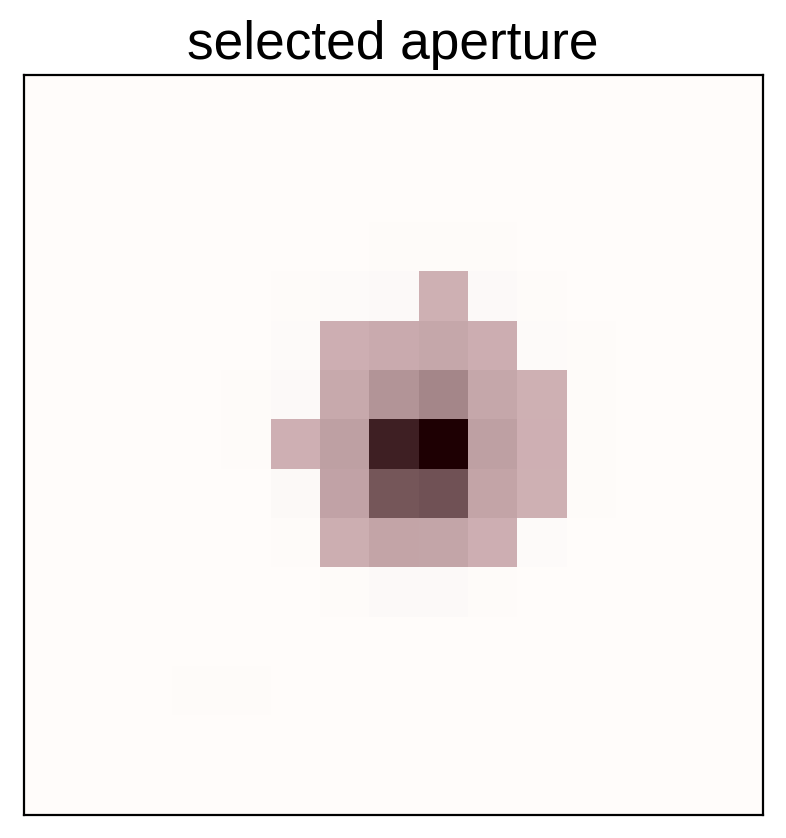

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(1, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

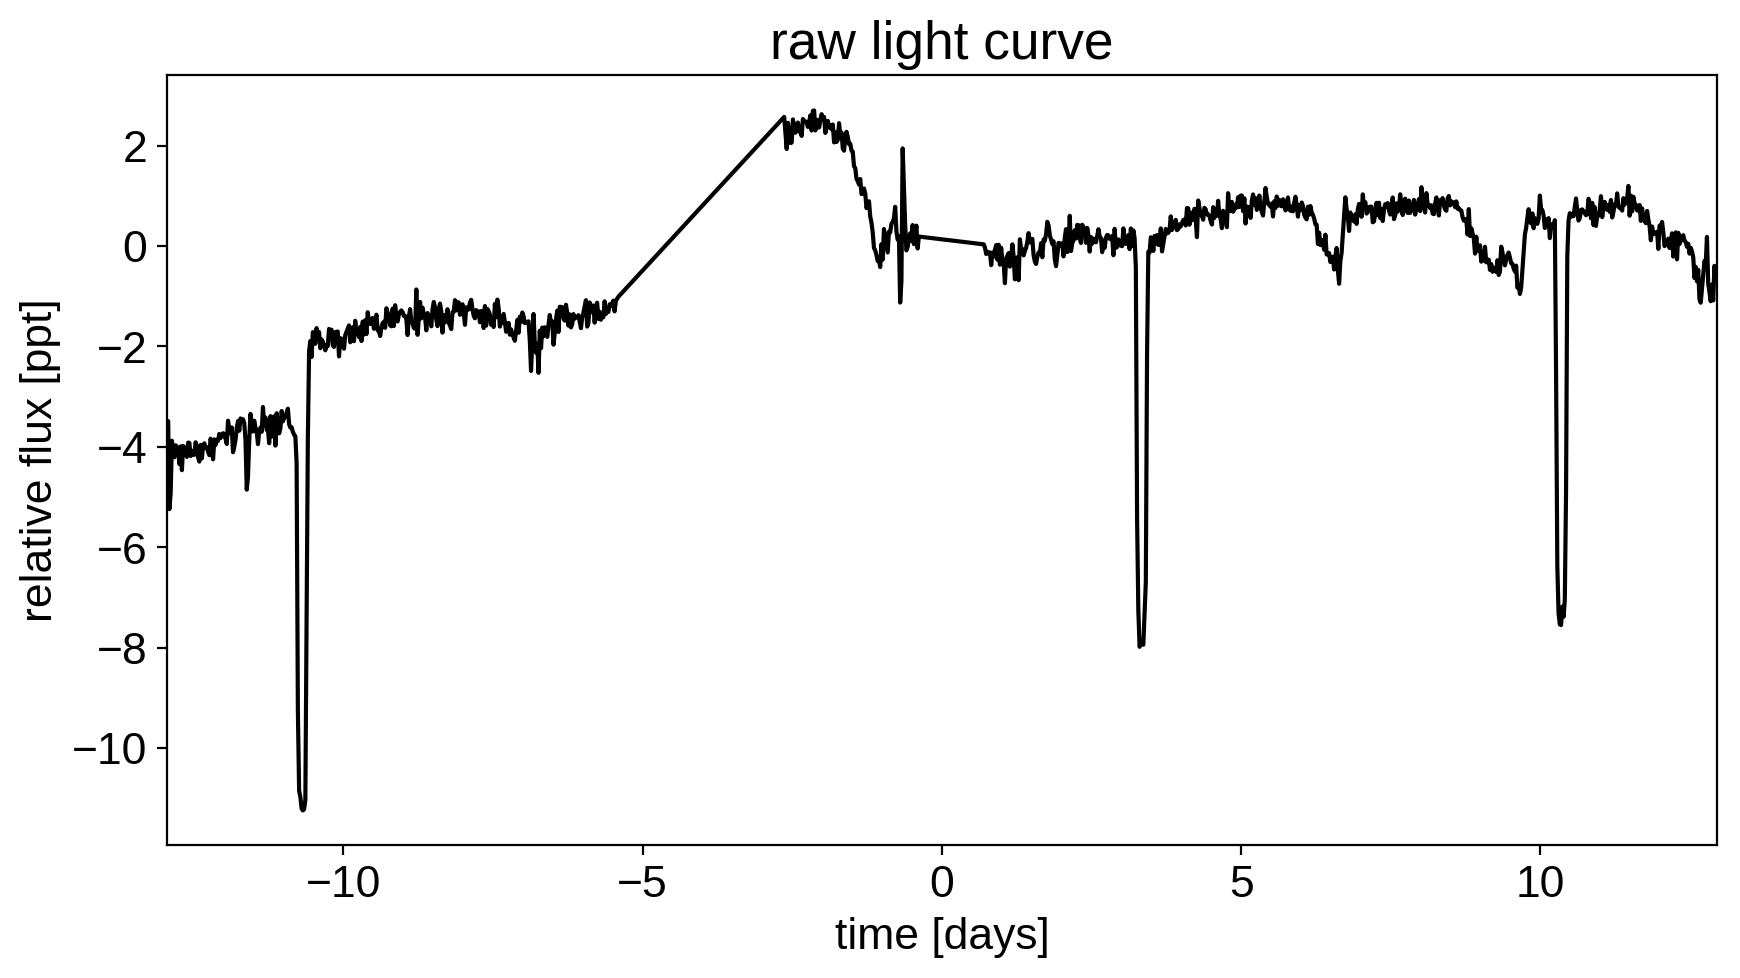

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

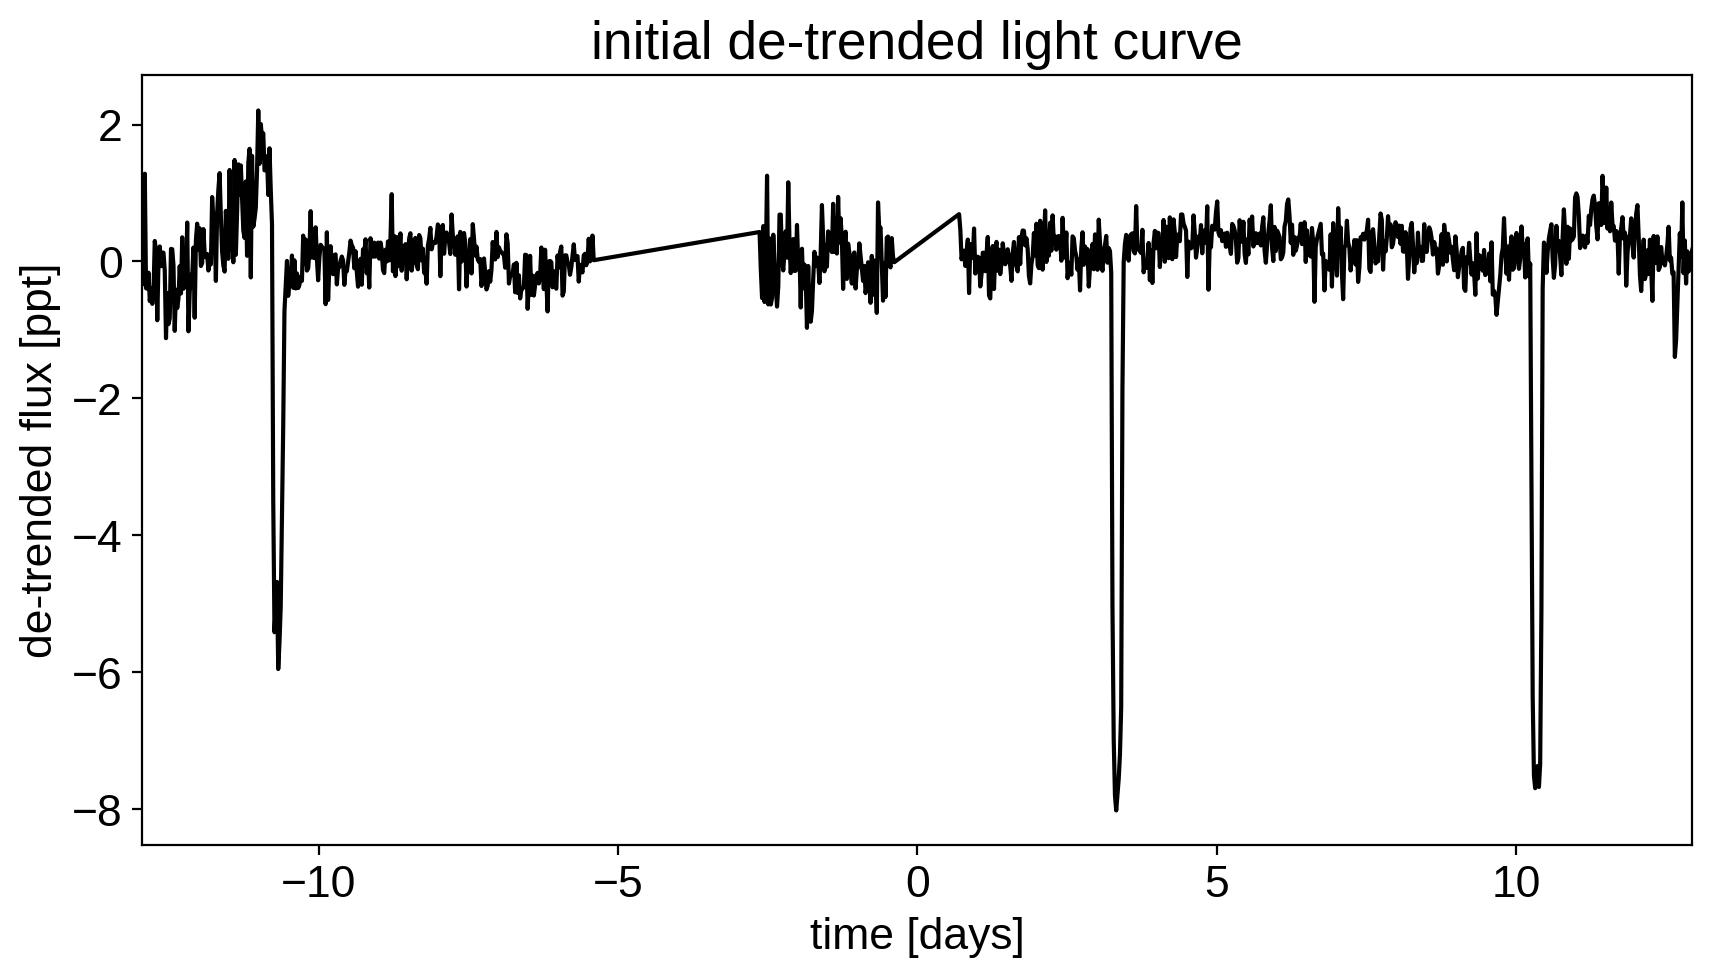

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

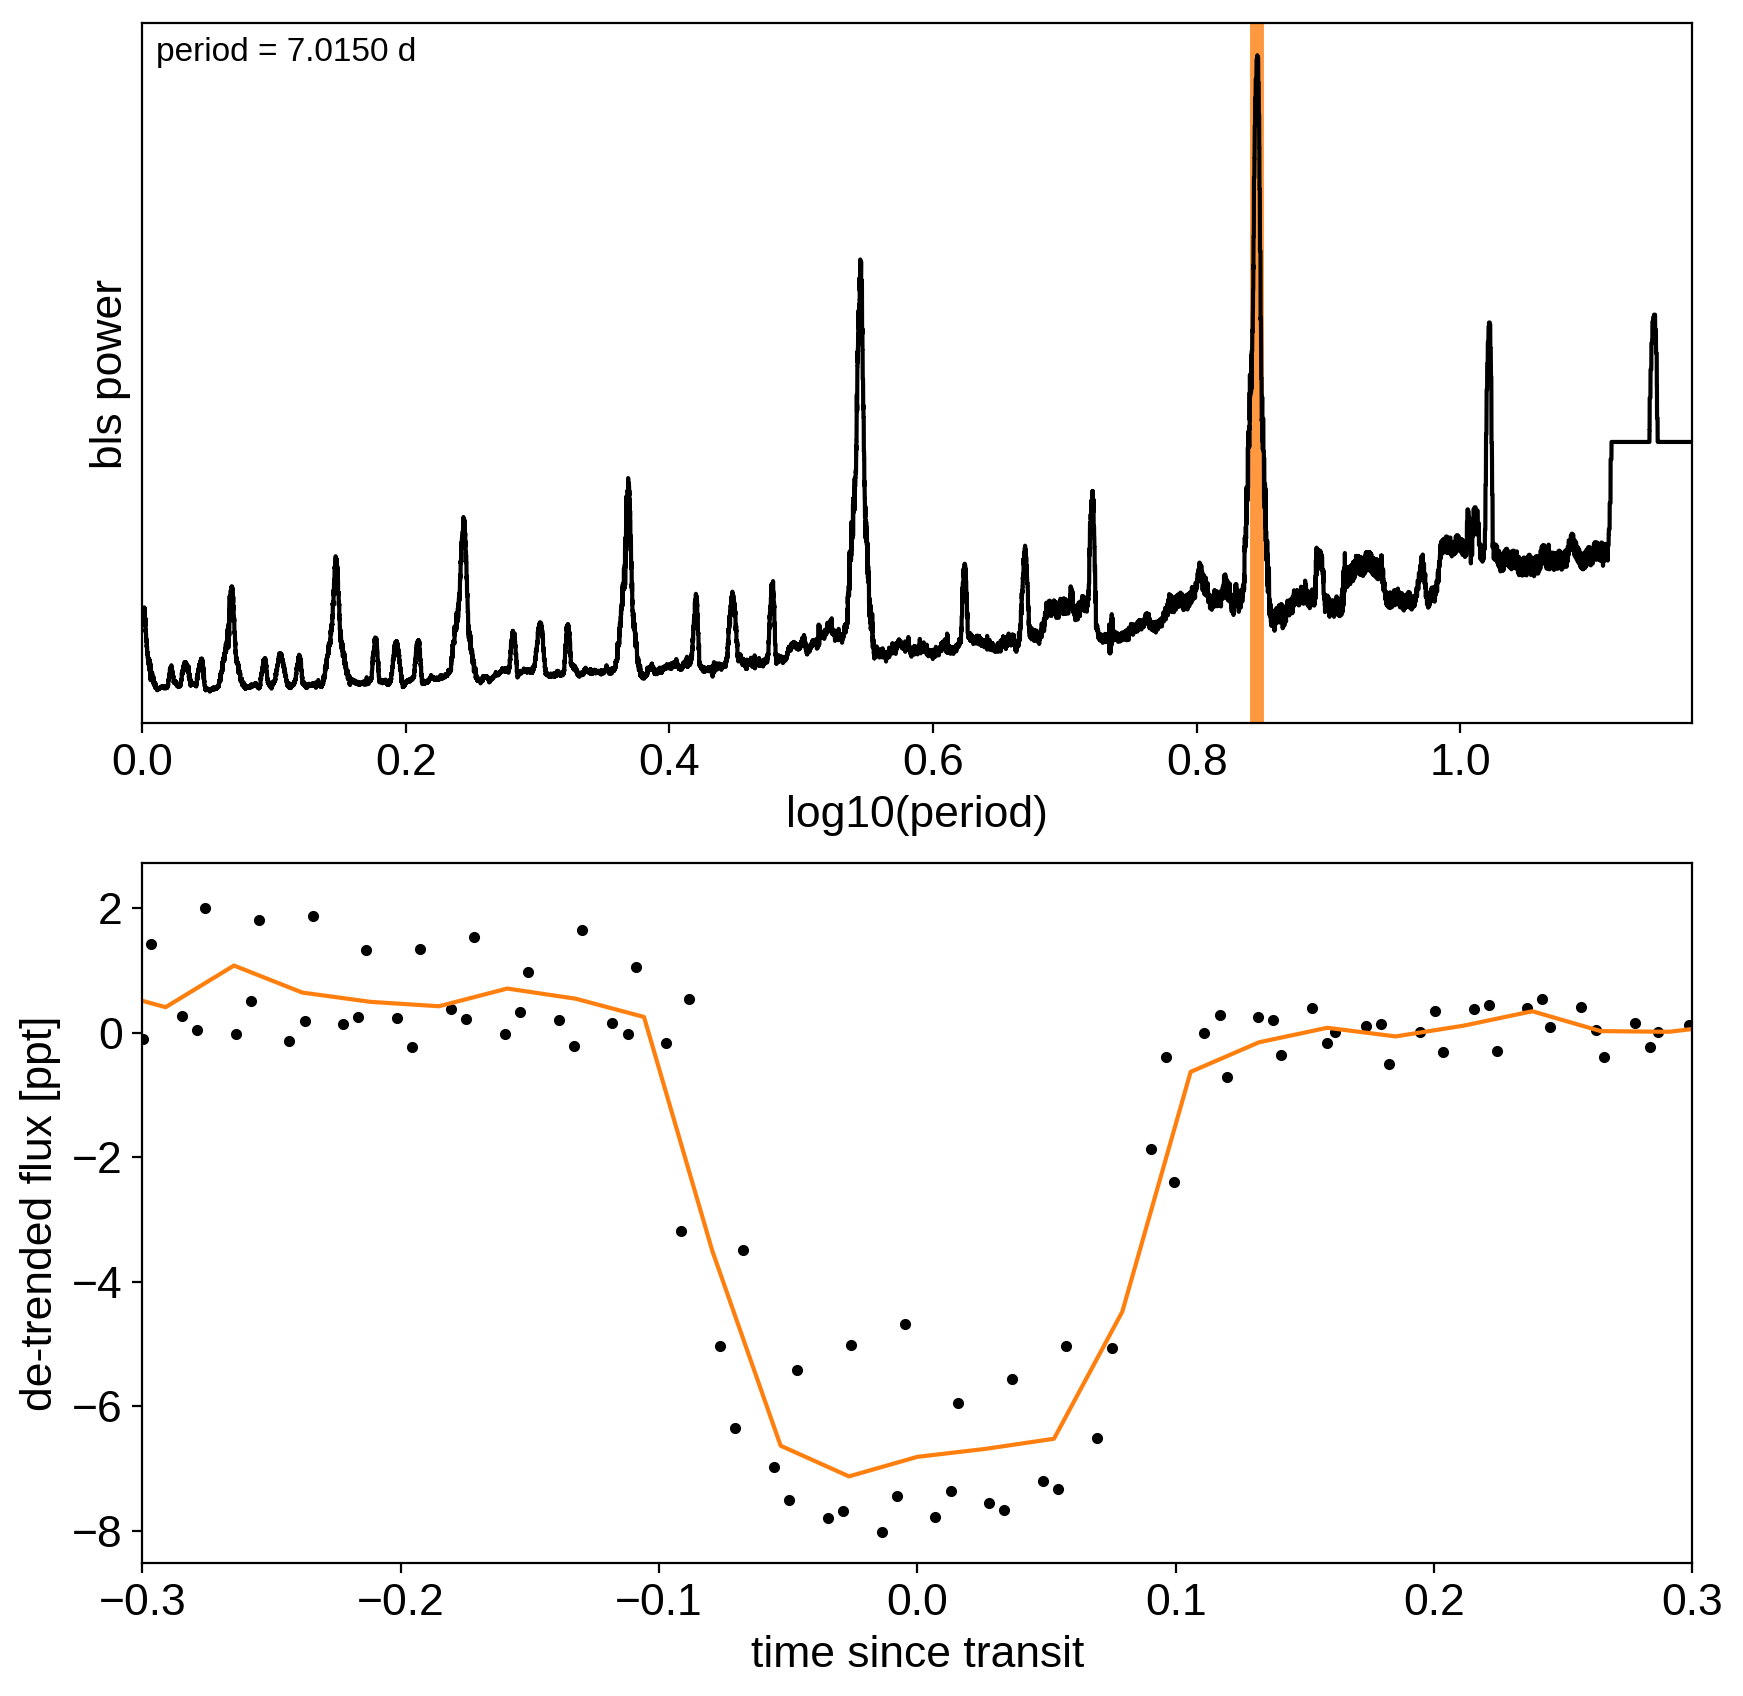

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

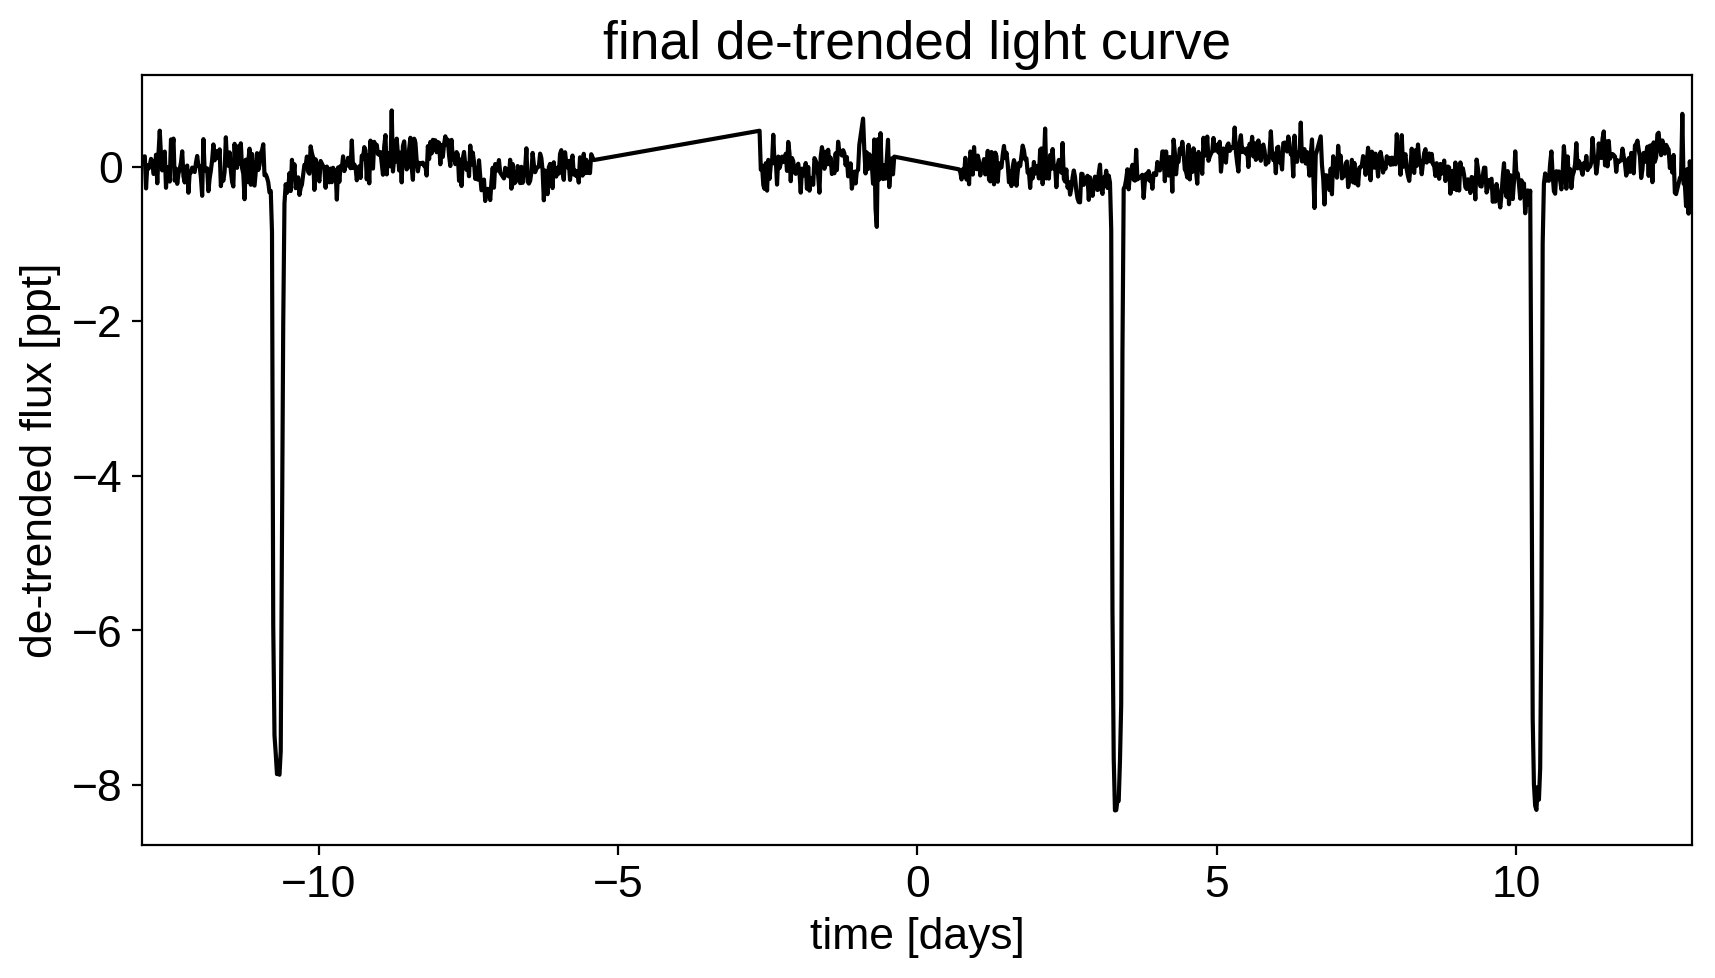

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from TIC
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        m_star = pm.Normal("m_star", mu=tic_mass[0], sd=tic_mass[1])
        r_star = pm.Normal("r_star", mu=tic_radius[0], sd=tic_radius[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(tic_radius[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)
        pm.Deterministic("a", orbit.a_planet)
        pm.Deterministic("incl", orbit.incl)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: -1181.8355629633472 -> -1165.2287368771365


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: -1165.2287368771365 -> 83.7577748952358


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 83.7577748952358 -> 118.9245857261479


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 118.92458572614562 -> 344.3805435085572


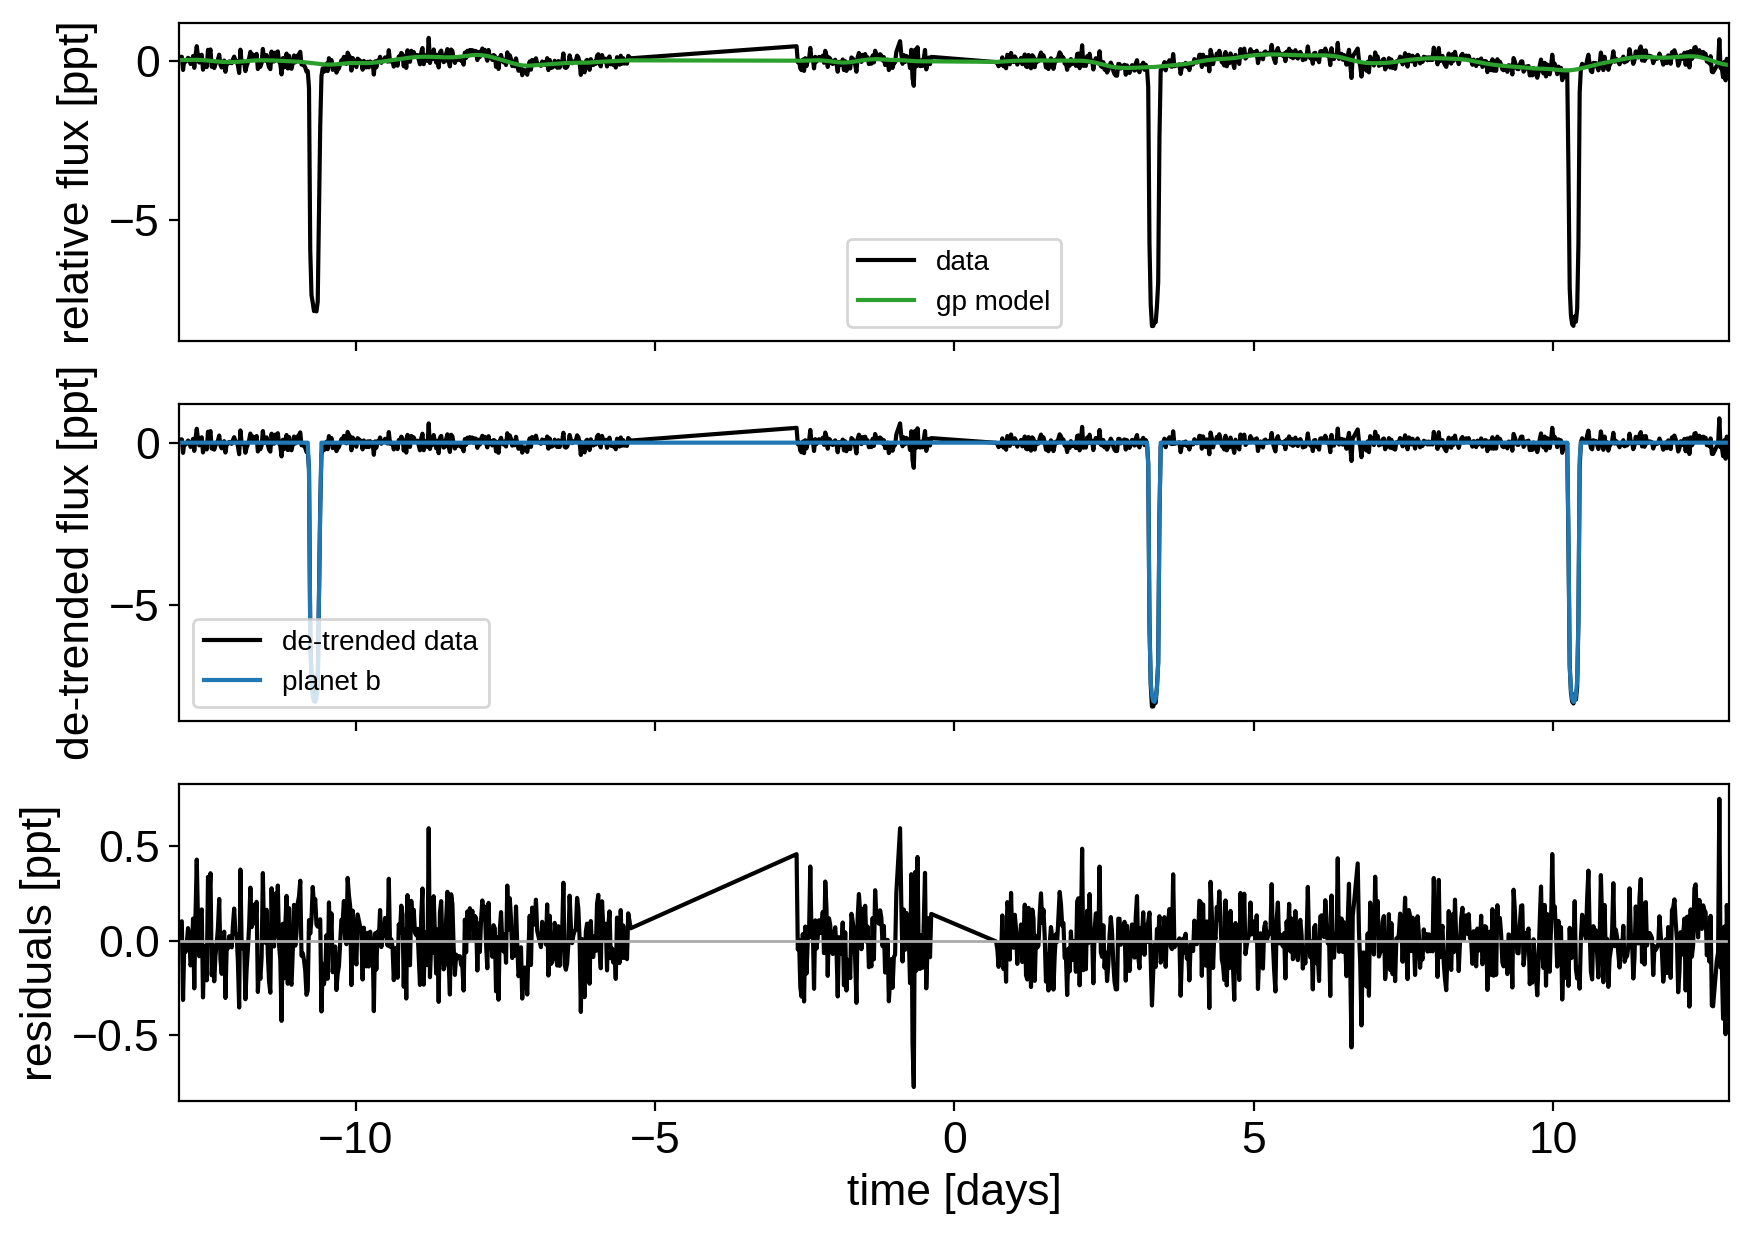

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

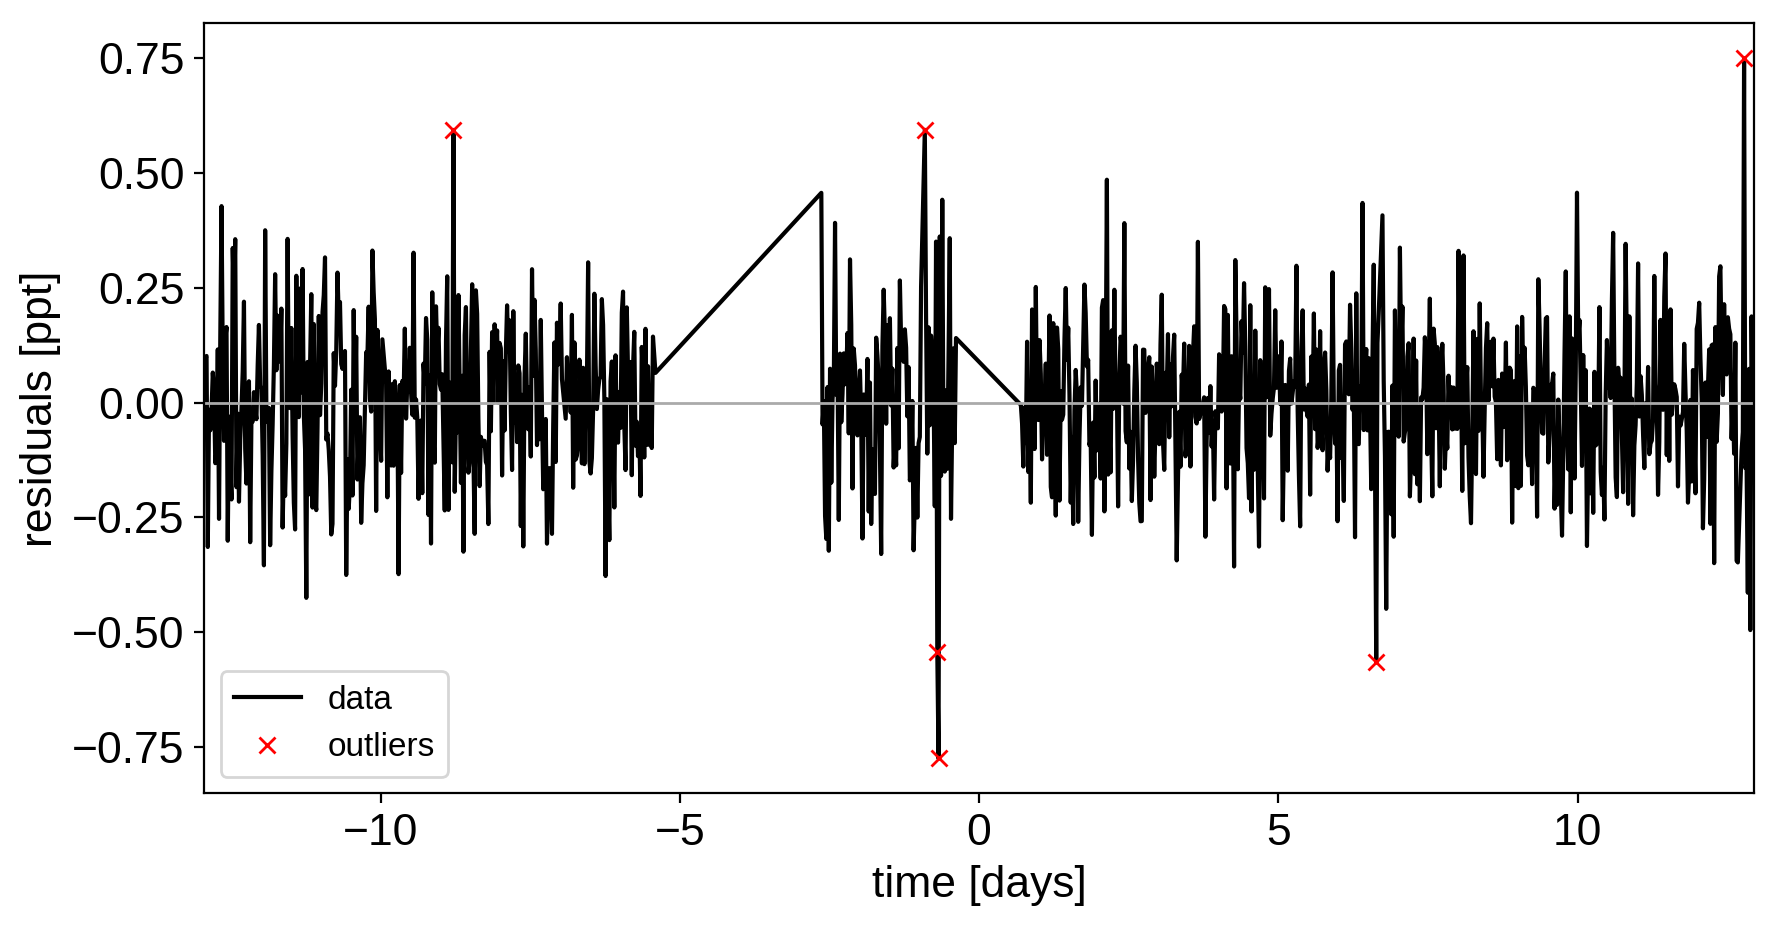

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 386.78260184764116 -> 386.78260184890496


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 386.78260184890337 -> 389.6638025170509


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 389.6638025170509 -> 389.68441484331356


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 389.6844148433131 -> 389.6948927325044


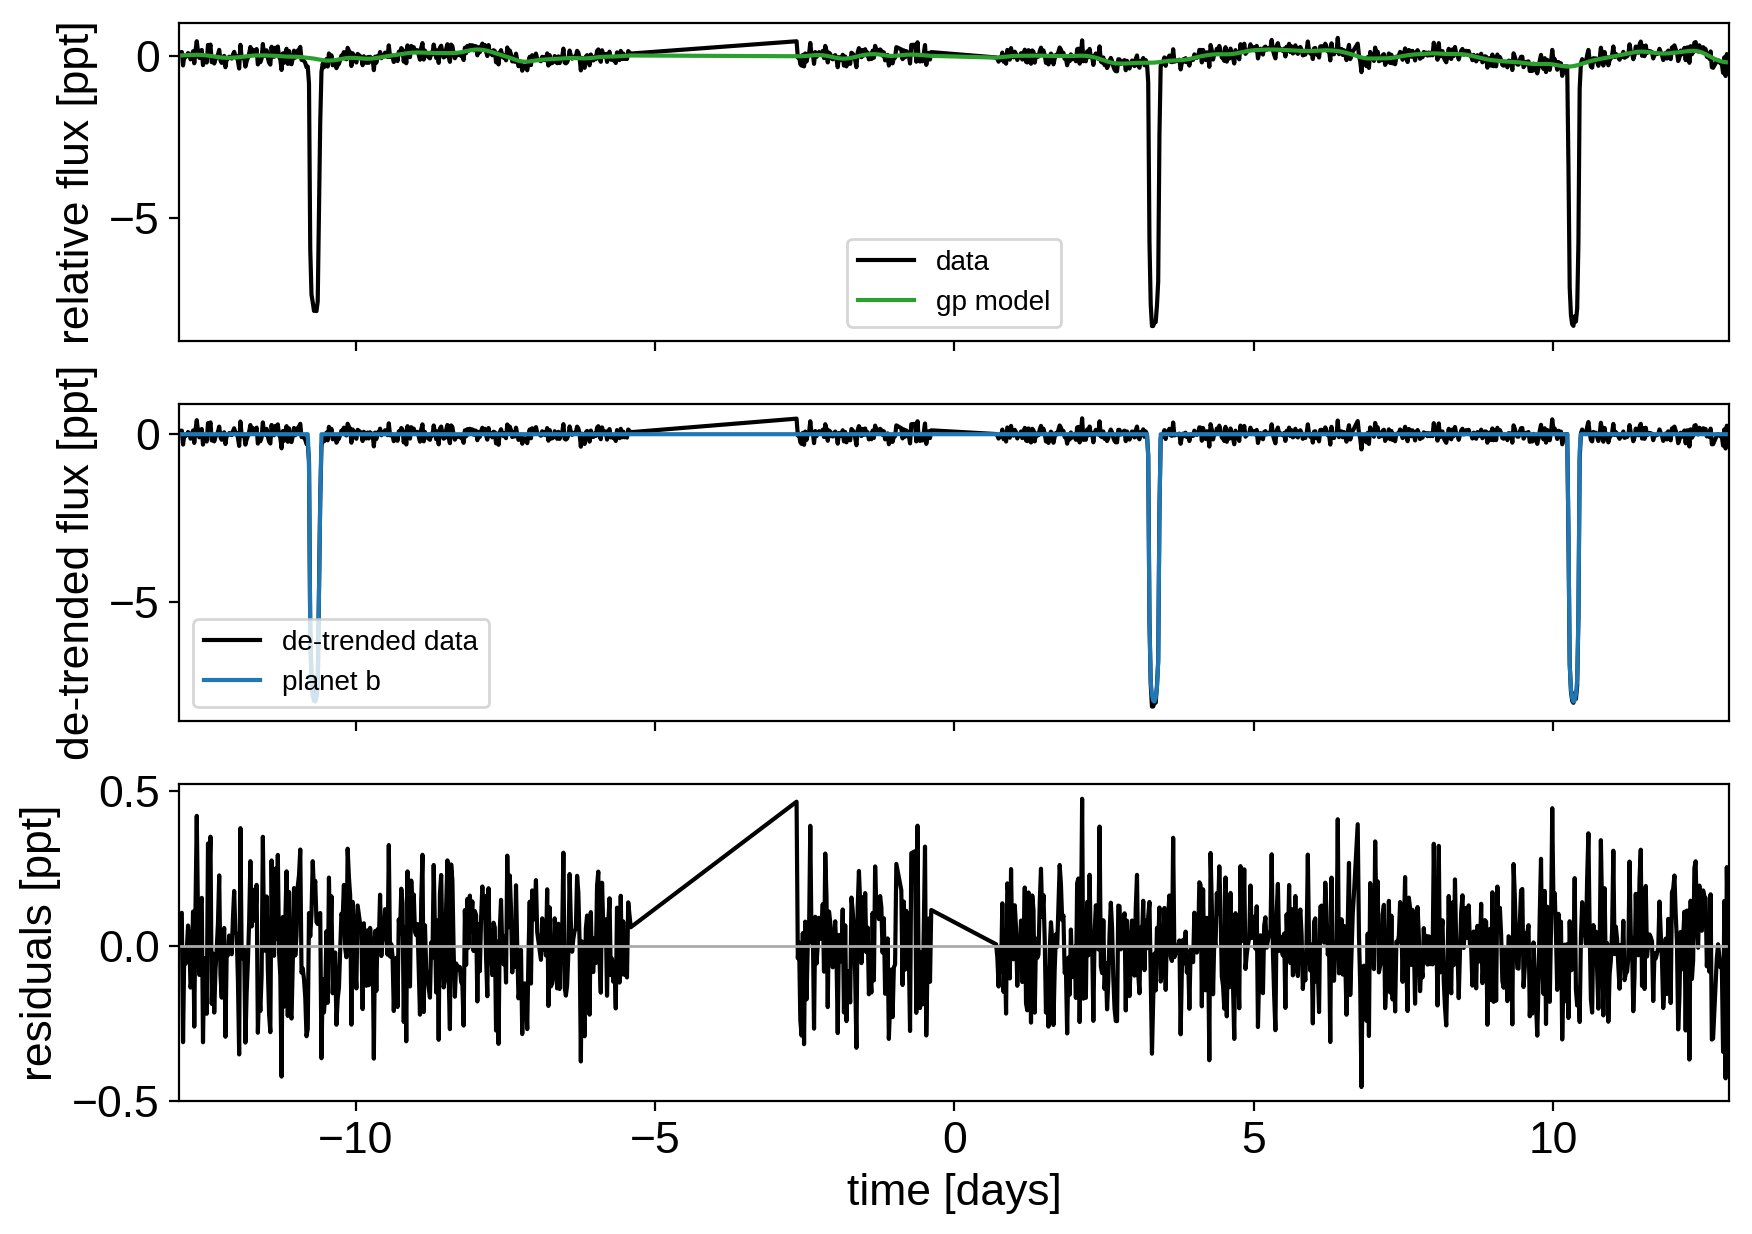

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

In [14]:
np.random.seed(12345)
sampler = xo.PyMC3Sampler(window=100, start=300, finish=500)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 18/1208 [00:00<00:20, 58.70draws/s]

Sampling 4 chains:   2%|▏         | 22/1208 [00:00<00:37, 31.31draws/s]

Sampling 4 chains:   2%|▏         | 26/1208 [00:00<00:49, 23.91draws/s]

Sampling 4 chains:   2%|▏         | 30/1208 [00:01<00:58, 20.20draws/s]

Sampling 4 chains:   3%|▎         | 34/1208 [00:01<01:03, 18.47draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:01<01:07, 17.42draws/s]

Sampling 4 chains:   3%|▎         | 42/1208 [00:01<01:09, 16.67draws/s]

Sampling 4 chains:   4%|▍         | 46/1208 [00:02<01:11, 16.19draws/s]

Sampling 4 chains:   4%|▍         | 48/1208 [00:02<01:08, 16.81draws/s]

Sampling 4 chains:   4%|▍         | 50/1208 [00:02<01:15, 15.38draws/s]

Sampling 4 chains:   4%|▍         | 52/1208 [00:02<01:11, 16.16draws/s]

Sampling 4 chains:   4%|▍         | 54/1208 [00:02<01:16, 15.05draws/s]

Sampling 4 chains:   5%|▍         | 56/1208 [00:02<01:13, 15.69draws/s]

Sampling 4 chains:   5%|▍         | 58/1208 [00:02<01:16, 15.03draws/s]

Sampling 4 chains:   5%|▍         | 60/1208 [00:03<01:13, 15.54draws/s]

Sampling 4 chains:   5%|▌         | 62/1208 [00:03<01:15, 15.09draws/s]

Sampling 4 chains:   5%|▌         | 66/1208 [00:03<01:04, 17.58draws/s]

Sampling 4 chains:   6%|▌         | 68/1208 [00:03<01:09, 16.44draws/s]

Sampling 4 chains:   6%|▌         | 70/1208 [00:03<01:09, 16.30draws/s]

Sampling 4 chains:   6%|▌         | 72/1208 [00:03<01:11, 15.84draws/s]

Sampling 4 chains:   6%|▌         | 74/1208 [00:03<01:12, 15.68draws/s]

Sampling 4 chains:   6%|▋         | 77/1208 [00:04<01:05, 17.26draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:04<01:08, 16.46draws/s]

Sampling 4 chains:   7%|▋         | 81/1208 [00:04<01:09, 16.31draws/s]

Sampling 4 chains:   7%|▋         | 83/1208 [00:04<01:11, 15.66draws/s]

Sampling 4 chains:   7%|▋         | 85/1208 [00:04<01:10, 15.94draws/s]

Sampling 4 chains:   7%|▋         | 87/1208 [00:04<01:13, 15.26draws/s]

Sampling 4 chains:   7%|▋         | 89/1208 [00:04<01:13, 15.31draws/s]

Sampling 4 chains:   8%|▊         | 91/1208 [00:04<01:16, 14.54draws/s]

Sampling 4 chains:   8%|▊         | 93/1208 [00:05<01:11, 15.52draws/s]

Sampling 4 chains:   8%|▊         | 95/1208 [00:05<01:16, 14.56draws/s]

Sampling 4 chains:   8%|▊         | 97/1208 [00:05<01:11, 15.49draws/s]

Sampling 4 chains:   8%|▊         | 99/1208 [00:05<01:06, 16.59draws/s]

Sampling 4 chains:   8%|▊         | 101/1208 [00:05<01:11, 15.44draws/s]

Sampling 4 chains:   9%|▊         | 103/1208 [00:05<01:09, 15.99draws/s]

Sampling 4 chains:   9%|▊         | 105/1208 [00:05<01:12, 15.14draws/s]

Sampling 4 chains:   9%|▉         | 108/1208 [00:05<01:03, 17.19draws/s]

Sampling 4 chains:   9%|▉         | 110/1208 [00:06<01:08, 15.93draws/s]

Sampling 4 chains:   9%|▉         | 112/1208 [00:06<01:07, 16.23draws/s]

Sampling 4 chains:   9%|▉         | 114/1208 [00:06<01:10, 15.54draws/s]

Sampling 4 chains:  10%|▉         | 116/1208 [00:06<01:09, 15.74draws/s]

Sampling 4 chains:  10%|▉         | 119/1208 [00:06<01:03, 17.22draws/s]

Sampling 4 chains:  10%|█         | 121/1208 [00:06<01:05, 16.67draws/s]

Sampling 4 chains:  10%|█         | 123/1208 [00:06<01:06, 16.25draws/s]

Sampling 4 chains:  10%|█         | 125/1208 [00:07<01:08, 15.70draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:07<01:02, 17.16draws/s]

Sampling 4 chains:  11%|█         | 130/1208 [00:07<01:06, 16.13draws/s]

Sampling 4 chains:  11%|█         | 132/1208 [00:07<01:06, 16.29draws/s]

Sampling 4 chains:  11%|█         | 134/1208 [00:07<01:09, 15.43draws/s]

Sampling 4 chains:  11%|█▏        | 136/1208 [00:07<01:06, 16.03draws/s]

Sampling 4 chains:  11%|█▏        | 138/1208 [00:07<01:11, 15.07draws/s]

Sampling 4 chains:  12%|█▏        | 140/1208 [00:07<01:06, 15.98draws/s]

Sampling 4 chains:  12%|█▏        | 142/1208 [00:08<01:11, 14.85draws/s]

Sampling 4 chains:  12%|█▏        | 144/1208 [00:08<01:06, 16.02draws/s]

Sampling 4 chains:  12%|█▏        | 146/1208 [00:08<01:12, 14.59draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:08<01:19, 13.25draws/s]

Sampling 4 chains:  13%|█▎        | 153/1208 [00:08<01:17, 13.59draws/s]

Sampling 4 chains:  13%|█▎        | 157/1208 [00:09<01:15, 13.87draws/s]

Sampling 4 chains:  13%|█▎        | 161/1208 [00:09<01:14, 14.09draws/s]

Sampling 4 chains:  14%|█▎        | 165/1208 [00:09<01:12, 14.38draws/s]

Sampling 4 chains:  14%|█▍        | 169/1208 [00:09<01:11, 14.58draws/s]

Sampling 4 chains:  14%|█▍        | 173/1208 [00:10<01:10, 14.73draws/s]

Sampling 4 chains:  15%|█▍        | 177/1208 [00:10<01:09, 14.78draws/s]

Sampling 4 chains:  15%|█▍        | 181/1208 [00:10<01:09, 14.75draws/s]

Sampling 4 chains:  15%|█▌        | 185/1208 [00:11<01:08, 14.85draws/s]

Sampling 4 chains:  16%|█▌        | 190/1208 [00:11<01:04, 15.86draws/s]

Sampling 4 chains:  16%|█▌        | 194/1208 [00:11<01:04, 15.72draws/s]

Sampling 4 chains:  16%|█▋        | 198/1208 [00:11<01:04, 15.63draws/s]

Sampling 4 chains:  17%|█▋        | 201/1208 [00:11<00:55, 17.98draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [00:12<01:07, 14.90draws/s]

Sampling 4 chains:  17%|█▋        | 206/1208 [00:12<01:09, 14.45draws/s]

Sampling 4 chains:  17%|█▋        | 209/1208 [00:12<01:02, 16.05draws/s]

Sampling 4 chains:  17%|█▋        | 211/1208 [00:12<01:08, 14.53draws/s]

Sampling 4 chains:  18%|█▊        | 213/1208 [00:12<01:03, 15.59draws/s]

Sampling 4 chains:  18%|█▊        | 215/1208 [00:12<01:08, 14.50draws/s]

Sampling 4 chains:  18%|█▊        | 218/1208 [00:13<00:59, 16.74draws/s]

Sampling 4 chains:  18%|█▊        | 220/1208 [00:13<01:03, 15.56draws/s]

Sampling 4 chains:  18%|█▊        | 222/1208 [00:13<01:02, 15.71draws/s]

Sampling 4 chains:  19%|█▊        | 224/1208 [00:13<01:04, 15.25draws/s]

Sampling 4 chains:  19%|█▊        | 226/1208 [00:13<01:04, 15.14draws/s]

Sampling 4 chains:  19%|█▉        | 229/1208 [00:13<00:57, 16.89draws/s]

Sampling 4 chains:  19%|█▉        | 231/1208 [00:13<01:03, 15.35draws/s]

Sampling 4 chains:  19%|█▉        | 233/1208 [00:13<00:59, 16.26draws/s]

Sampling 4 chains:  19%|█▉        | 235/1208 [00:14<01:06, 14.65draws/s]

Sampling 4 chains:  20%|█▉        | 238/1208 [00:14<01:03, 15.16draws/s]

Sampling 4 chains:  20%|█▉        | 241/1208 [00:14<01:01, 15.62draws/s]

Sampling 4 chains:  20%|██        | 243/1208 [00:14<01:09, 13.96draws/s]

Sampling 4 chains:  20%|██        | 246/1208 [00:14<01:06, 14.47draws/s]

Sampling 4 chains:  21%|██        | 249/1208 [00:15<01:01, 15.55draws/s]

Sampling 4 chains:  21%|██        | 251/1208 [00:15<01:07, 14.19draws/s]

Sampling 4 chains:  21%|██        | 254/1208 [00:15<01:07, 14.07draws/s]

Sampling 4 chains:  21%|██▏       | 257/1208 [00:15<01:01, 15.56draws/s]

Sampling 4 chains:  21%|██▏       | 259/1208 [00:15<01:06, 14.17draws/s]

Sampling 4 chains:  22%|██▏       | 262/1208 [00:15<01:07, 14.04draws/s]

Sampling 4 chains:  22%|██▏       | 264/1208 [00:16<01:03, 14.83draws/s]

Sampling 4 chains:  22%|██▏       | 266/1208 [00:16<01:06, 14.17draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [00:16<01:03, 14.90draws/s]

Sampling 4 chains:  22%|██▏       | 270/1208 [00:16<01:04, 14.47draws/s]

Sampling 4 chains:  23%|██▎       | 272/1208 [00:16<01:03, 14.77draws/s]

Sampling 4 chains:  23%|██▎       | 274/1208 [00:16<01:03, 14.74draws/s]

Sampling 4 chains:  23%|██▎       | 276/1208 [00:16<01:03, 14.67draws/s]

Sampling 4 chains:  23%|██▎       | 278/1208 [00:17<01:02, 14.96draws/s]

Sampling 4 chains:  23%|██▎       | 280/1208 [00:17<01:03, 14.58draws/s]

Sampling 4 chains:  23%|██▎       | 282/1208 [00:17<01:01, 15.15draws/s]

Sampling 4 chains:  24%|██▎       | 284/1208 [00:17<01:02, 14.74draws/s]

Sampling 4 chains:  24%|██▎       | 286/1208 [00:17<01:00, 15.30draws/s]

Sampling 4 chains:  24%|██▍       | 288/1208 [00:17<01:02, 14.80draws/s]

Sampling 4 chains:  24%|██▍       | 290/1208 [00:17<00:59, 15.54draws/s]

Sampling 4 chains:  24%|██▍       | 292/1208 [00:17<01:01, 14.79draws/s]

Sampling 4 chains:  24%|██▍       | 294/1208 [00:18<00:58, 15.72draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [00:18<01:01, 14.73draws/s]

Sampling 4 chains:  25%|██▍       | 298/1208 [00:18<00:57, 15.87draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [00:18<01:02, 14.64draws/s]

Sampling 4 chains:  25%|██▌       | 302/1208 [00:18<00:57, 15.82draws/s]

Sampling 4 chains:  25%|██▌       | 304/1208 [00:18<01:01, 14.60draws/s]

Sampling 4 chains:  25%|██▌       | 307/1208 [00:18<00:58, 15.47draws/s]

Sampling 4 chains:  26%|██▌       | 309/1208 [00:19<01:03, 14.19draws/s]

Sampling 4 chains:  26%|██▌       | 311/1208 [00:19<00:59, 14.98draws/s]

Sampling 4 chains:  26%|██▌       | 313/1208 [00:19<01:03, 14.17draws/s]

Sampling 4 chains:  26%|██▌       | 315/1208 [00:19<00:58, 15.28draws/s]

Sampling 4 chains:  26%|██▌       | 317/1208 [00:19<01:01, 14.38draws/s]

Sampling 4 chains:  26%|██▋       | 319/1208 [00:19<00:57, 15.43draws/s]

Sampling 4 chains:  27%|██▋       | 321/1208 [00:19<01:00, 14.69draws/s]

Sampling 4 chains:  27%|██▋       | 323/1208 [00:20<00:59, 14.91draws/s]

Sampling 4 chains:  27%|██▋       | 325/1208 [00:20<00:58, 15.06draws/s]

Sampling 4 chains:  27%|██▋       | 327/1208 [00:20<01:01, 14.43draws/s]

Sampling 4 chains:  27%|██▋       | 329/1208 [00:20<00:56, 15.50draws/s]

Sampling 4 chains:  27%|██▋       | 331/1208 [00:20<01:00, 14.49draws/s]

Sampling 4 chains:  28%|██▊       | 333/1208 [00:20<00:55, 15.80draws/s]

Sampling 4 chains:  28%|██▊       | 335/1208 [00:20<01:00, 14.46draws/s]

Sampling 4 chains:  28%|██▊       | 338/1208 [00:21<00:58, 14.99draws/s]

Sampling 4 chains:  28%|██▊       | 340/1208 [00:21<00:56, 15.38draws/s]

Sampling 4 chains:  28%|██▊       | 342/1208 [00:21<00:59, 14.65draws/s]

Sampling 4 chains:  28%|██▊       | 344/1208 [00:21<00:55, 15.47draws/s]

Sampling 4 chains:  29%|██▊       | 347/1208 [00:21<00:52, 16.28draws/s]

Sampling 4 chains:  29%|██▉       | 349/1208 [00:21<00:50, 17.12draws/s]

Sampling 4 chains:  29%|██▉       | 351/1208 [00:21<00:57, 15.03draws/s]

Sampling 4 chains:  29%|██▉       | 354/1208 [00:21<00:50, 16.80draws/s]

Sampling 4 chains:  29%|██▉       | 356/1208 [00:22<01:04, 13.18draws/s]

Sampling 4 chains:  30%|██▉       | 359/1208 [00:22<01:01, 13.86draws/s]

Sampling 4 chains:  30%|██▉       | 362/1208 [00:22<00:51, 16.47draws/s]

Sampling 4 chains:  30%|███       | 364/1208 [00:22<01:05, 12.82draws/s]

Sampling 4 chains:  30%|███       | 367/1208 [00:22<01:03, 13.25draws/s]

Sampling 4 chains:  31%|███       | 370/1208 [00:23<00:52, 15.90draws/s]

Sampling 4 chains:  31%|███       | 372/1208 [00:23<01:04, 12.92draws/s]

Sampling 4 chains:  31%|███       | 375/1208 [00:23<01:04, 13.00draws/s]

Sampling 4 chains:  31%|███▏      | 378/1208 [00:23<00:53, 15.65draws/s]

Sampling 4 chains:  31%|███▏      | 380/1208 [00:23<01:02, 13.34draws/s]

Sampling 4 chains:  32%|███▏      | 383/1208 [00:24<01:03, 12.90draws/s]

Sampling 4 chains:  32%|███▏      | 386/1208 [00:24<00:53, 15.32draws/s]

Sampling 4 chains:  32%|███▏      | 388/1208 [00:24<00:58, 14.10draws/s]

Sampling 4 chains:  32%|███▏      | 391/1208 [00:24<01:01, 13.24draws/s]

Sampling 4 chains:  33%|███▎      | 394/1208 [00:24<00:51, 15.82draws/s]

Sampling 4 chains:  33%|███▎      | 396/1208 [00:24<00:58, 13.95draws/s]

Sampling 4 chains:  33%|███▎      | 399/1208 [00:25<00:59, 13.64draws/s]

Sampling 4 chains:  33%|███▎      | 402/1208 [00:25<00:51, 15.53draws/s]

Sampling 4 chains:  33%|███▎      | 404/1208 [00:25<00:56, 14.23draws/s]

Sampling 4 chains:  34%|███▎      | 406/1208 [00:25<00:52, 15.14draws/s]

Sampling 4 chains:  34%|███▍      | 408/1208 [00:25<00:55, 14.49draws/s]

Sampling 4 chains:  34%|███▍      | 410/1208 [00:25<00:52, 15.29draws/s]

Sampling 4 chains:  34%|███▍      | 412/1208 [00:25<00:54, 14.63draws/s]

Sampling 4 chains:  34%|███▍      | 414/1208 [00:26<00:51, 15.35draws/s]

Sampling 4 chains:  34%|███▍      | 416/1208 [00:26<00:53, 14.70draws/s]

Sampling 4 chains:  35%|███▍      | 418/1208 [00:26<00:54, 14.40draws/s]

Sampling 4 chains:  35%|███▍      | 420/1208 [00:26<00:52, 15.04draws/s]

Sampling 4 chains:  35%|███▍      | 422/1208 [00:26<00:53, 14.58draws/s]

Sampling 4 chains:  35%|███▌      | 424/1208 [00:26<00:51, 15.24draws/s]

Sampling 4 chains:  35%|███▌      | 426/1208 [00:26<00:53, 14.66draws/s]

Sampling 4 chains:  35%|███▌      | 428/1208 [00:26<00:50, 15.36draws/s]

Sampling 4 chains:  36%|███▌      | 430/1208 [00:27<00:52, 14.69draws/s]

Sampling 4 chains:  36%|███▌      | 432/1208 [00:27<00:50, 15.42draws/s]

Sampling 4 chains:  36%|███▌      | 434/1208 [00:27<00:52, 14.69draws/s]

Sampling 4 chains:  36%|███▌      | 436/1208 [00:27<00:49, 15.47draws/s]

Sampling 4 chains:  36%|███▋      | 438/1208 [00:27<00:52, 14.68draws/s]

Sampling 4 chains:  36%|███▋      | 440/1208 [00:27<00:49, 15.49draws/s]

Sampling 4 chains:  37%|███▋      | 442/1208 [00:27<00:52, 14.67draws/s]

Sampling 4 chains:  37%|███▋      | 444/1208 [00:28<00:49, 15.53draws/s]

Sampling 4 chains:  37%|███▋      | 446/1208 [00:28<00:53, 14.31draws/s]

Sampling 4 chains:  37%|███▋      | 449/1208 [00:28<00:53, 14.10draws/s]

Sampling 4 chains:  38%|███▊      | 453/1208 [00:28<00:45, 16.49draws/s]

Sampling 4 chains:  38%|███▊      | 455/1208 [00:28<00:49, 15.35draws/s]

Sampling 4 chains:  38%|███▊      | 457/1208 [00:28<00:47, 15.96draws/s]

Sampling 4 chains:  38%|███▊      | 459/1208 [00:28<00:49, 15.18draws/s]

Sampling 4 chains:  38%|███▊      | 461/1208 [00:29<00:47, 15.69draws/s]

Sampling 4 chains:  38%|███▊      | 463/1208 [00:29<00:50, 14.76draws/s]

Sampling 4 chains:  38%|███▊      | 465/1208 [00:29<00:47, 15.64draws/s]

Sampling 4 chains:  39%|███▊      | 467/1208 [00:29<00:51, 14.41draws/s]

Sampling 4 chains:  39%|███▉      | 470/1208 [00:29<00:52, 13.99draws/s]

Sampling 4 chains:  39%|███▉      | 473/1208 [00:29<00:46, 15.74draws/s]

Sampling 4 chains:  39%|███▉      | 475/1208 [00:30<00:53, 13.73draws/s]

Sampling 4 chains:  40%|███▉      | 478/1208 [00:30<00:51, 14.21draws/s]

Sampling 4 chains:  40%|███▉      | 480/1208 [00:30<00:49, 14.68draws/s]

Sampling 4 chains:  40%|███▉      | 482/1208 [00:30<00:49, 14.77draws/s]

Sampling 4 chains:  40%|████      | 484/1208 [00:30<00:50, 14.35draws/s]

Sampling 4 chains:  40%|████      | 486/1208 [00:30<00:47, 15.30draws/s]

Sampling 4 chains:  40%|████      | 488/1208 [00:30<00:49, 14.47draws/s]

Sampling 4 chains:  41%|████      | 490/1208 [00:31<00:45, 15.64draws/s]

Sampling 4 chains:  41%|████      | 492/1208 [00:31<00:49, 14.54draws/s]

Sampling 4 chains:  41%|████      | 495/1208 [00:31<00:51, 13.88draws/s]

Sampling 4 chains:  41%|████      | 498/1208 [00:31<00:44, 16.04draws/s]

Sampling 4 chains:  41%|████▏     | 500/1208 [00:31<00:48, 14.47draws/s]

Sampling 4 chains:  42%|████▏     | 503/1208 [00:32<00:52, 13.46draws/s]

Sampling 4 chains:  42%|████▏     | 507/1208 [00:32<00:50, 13.85draws/s]

Sampling 4 chains:  42%|████▏     | 511/1208 [00:32<00:49, 14.22draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [00:32<00:47, 14.48draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [00:33<00:46, 14.67draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [00:33<00:46, 14.81draws/s]

Sampling 4 chains:  44%|████▎     | 527/1208 [00:33<00:45, 14.91draws/s]

Sampling 4 chains:  44%|████▍     | 531/1208 [00:33<00:37, 18.26draws/s]

Sampling 4 chains:  44%|████▍     | 534/1208 [00:33<00:40, 16.45draws/s]

Sampling 4 chains:  44%|████▍     | 536/1208 [00:34<00:49, 13.66draws/s]

Sampling 4 chains:  45%|████▍     | 539/1208 [00:34<00:41, 16.25draws/s]

Sampling 4 chains:  45%|████▍     | 542/1208 [00:34<00:44, 14.83draws/s]

Sampling 4 chains:  45%|████▌     | 544/1208 [00:34<00:49, 13.32draws/s]

Sampling 4 chains:  45%|████▌     | 547/1208 [00:34<00:43, 15.10draws/s]

Sampling 4 chains:  45%|████▌     | 549/1208 [00:34<00:46, 14.06draws/s]

Sampling 4 chains:  46%|████▌     | 551/1208 [00:35<00:42, 15.41draws/s]

Sampling 4 chains:  46%|████▌     | 553/1208 [00:35<00:45, 14.44draws/s]

Sampling 4 chains:  46%|████▌     | 555/1208 [00:35<00:42, 15.51draws/s]

Sampling 4 chains:  46%|████▌     | 557/1208 [00:35<00:44, 14.69draws/s]

Sampling 4 chains:  46%|████▋     | 559/1208 [00:35<00:43, 14.78draws/s]

Sampling 4 chains:  46%|████▋     | 561/1208 [00:35<00:42, 15.08draws/s]

Sampling 4 chains:  47%|████▋     | 563/1208 [00:35<00:45, 14.31draws/s]

Sampling 4 chains:  47%|████▋     | 565/1208 [00:36<00:41, 15.54draws/s]

Sampling 4 chains:  47%|████▋     | 567/1208 [00:36<00:44, 14.41draws/s]

Sampling 4 chains:  47%|████▋     | 570/1208 [00:36<00:45, 13.93draws/s]

Sampling 4 chains:  47%|████▋     | 572/1208 [00:36<00:43, 14.61draws/s]

Sampling 4 chains:  48%|████▊     | 574/1208 [00:36<00:44, 14.12draws/s]

Sampling 4 chains:  48%|████▊     | 576/1208 [00:36<00:41, 15.14draws/s]

Sampling 4 chains:  48%|████▊     | 578/1208 [00:36<00:44, 14.11draws/s]

Sampling 4 chains:  48%|████▊     | 581/1208 [00:37<00:37, 16.72draws/s]

Sampling 4 chains:  48%|████▊     | 583/1208 [00:37<00:46, 13.56draws/s]

Sampling 4 chains:  49%|████▊     | 586/1208 [00:37<00:46, 13.33draws/s]

Sampling 4 chains:  49%|████▉     | 590/1208 [00:37<00:45, 13.69draws/s]

Sampling 4 chains:  49%|████▉     | 594/1208 [00:38<00:44, 13.95draws/s]

Sampling 4 chains:  50%|████▉     | 598/1208 [00:38<00:43, 14.14draws/s]

Sampling 4 chains:  50%|████▉     | 602/1208 [00:38<00:42, 14.34draws/s]

Sampling 4 chains:  50%|█████     | 606/1208 [00:38<00:41, 14.55draws/s]

Sampling 4 chains:  50%|█████     | 610/1208 [00:39<00:40, 14.74draws/s]

Sampling 4 chains:  51%|█████     | 614/1208 [00:39<00:39, 14.94draws/s]

Sampling 4 chains:  51%|█████     | 618/1208 [00:39<00:39, 15.09draws/s]

Sampling 4 chains:  51%|█████▏    | 622/1208 [00:39<00:38, 15.19draws/s]

Sampling 4 chains:  52%|█████▏    | 626/1208 [00:40<00:38, 15.25draws/s]

Sampling 4 chains:  52%|█████▏    | 630/1208 [00:40<00:37, 15.30draws/s]

Sampling 4 chains:  52%|█████▏    | 634/1208 [00:40<00:37, 15.34draws/s]

Sampling 4 chains:  53%|█████▎    | 637/1208 [00:40<00:32, 17.53draws/s]

Sampling 4 chains:  53%|█████▎    | 639/1208 [00:41<00:42, 13.37draws/s]

Sampling 4 chains:  53%|█████▎    | 642/1208 [00:41<00:39, 14.37draws/s]

Sampling 4 chains:  53%|█████▎    | 644/1208 [00:41<00:36, 15.31draws/s]

Sampling 4 chains:  53%|█████▎    | 646/1208 [00:41<00:38, 14.56draws/s]

Sampling 4 chains:  54%|█████▎    | 648/1208 [00:41<00:36, 15.41draws/s]

Sampling 4 chains:  54%|█████▍    | 650/1208 [00:41<00:37, 14.81draws/s]

Sampling 4 chains:  54%|█████▍    | 652/1208 [00:41<00:37, 14.86draws/s]

Sampling 4 chains:  54%|█████▍    | 654/1208 [00:41<00:36, 15.16draws/s]

Sampling 4 chains:  54%|█████▍    | 656/1208 [00:42<00:38, 14.43draws/s]

Sampling 4 chains:  54%|█████▍    | 658/1208 [00:42<00:35, 15.55draws/s]

Sampling 4 chains:  55%|█████▍    | 660/1208 [00:42<00:37, 14.46draws/s]

Sampling 4 chains:  55%|█████▍    | 663/1208 [00:42<00:38, 14.28draws/s]

Sampling 4 chains:  55%|█████▌    | 666/1208 [00:42<00:34, 15.82draws/s]

Sampling 4 chains:  55%|█████▌    | 668/1208 [00:42<00:39, 13.70draws/s]

Sampling 4 chains:  56%|█████▌    | 671/1208 [00:43<00:37, 14.17draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [00:43<00:35, 14.94draws/s]

Sampling 4 chains:  56%|█████▌    | 675/1208 [00:43<00:36, 14.49draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [00:43<00:35, 14.87draws/s]

Sampling 4 chains:  56%|█████▌    | 679/1208 [00:43<00:35, 14.75draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [00:43<00:34, 15.19draws/s]

Sampling 4 chains:  57%|█████▋    | 683/1208 [00:43<00:35, 14.85draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [00:44<00:33, 15.43draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [00:44<00:35, 14.83draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [00:44<00:33, 15.60draws/s]

Sampling 4 chains:  57%|█████▋    | 692/1208 [00:44<00:30, 16.65draws/s]

Sampling 4 chains:  57%|█████▋    | 694/1208 [00:44<00:31, 16.56draws/s]

Sampling 4 chains:  58%|█████▊    | 696/1208 [00:44<00:32, 15.71draws/s]

Sampling 4 chains:  58%|█████▊    | 698/1208 [00:44<00:33, 15.38draws/s]

Sampling 4 chains:  58%|█████▊    | 700/1208 [00:44<00:32, 15.45draws/s]

Sampling 4 chains:  58%|█████▊    | 702/1208 [00:45<00:34, 14.57draws/s]

Sampling 4 chains:  58%|█████▊    | 704/1208 [00:45<00:32, 15.49draws/s]

Sampling 4 chains:  58%|█████▊    | 706/1208 [00:45<00:34, 14.59draws/s]

Sampling 4 chains:  59%|█████▊    | 708/1208 [00:45<00:32, 15.55draws/s]

Sampling 4 chains:  59%|█████▉    | 710/1208 [00:45<00:34, 14.59draws/s]

Sampling 4 chains:  59%|█████▉    | 712/1208 [00:45<00:31, 15.59draws/s]

Sampling 4 chains:  59%|█████▉    | 714/1208 [00:45<00:34, 14.17draws/s]

Sampling 4 chains:  59%|█████▉    | 717/1208 [00:46<00:32, 15.10draws/s]

Sampling 4 chains:  60%|█████▉    | 719/1208 [00:46<00:31, 15.73draws/s]

Sampling 4 chains:  60%|█████▉    | 722/1208 [00:46<00:29, 16.75draws/s]

Sampling 4 chains:  60%|█████▉    | 724/1208 [00:46<00:31, 15.30draws/s]

Sampling 4 chains:  60%|██████    | 726/1208 [00:46<00:29, 16.38draws/s]

Sampling 4 chains:  60%|██████    | 728/1208 [00:46<00:32, 14.59draws/s]

Sampling 4 chains:  61%|██████    | 731/1208 [00:47<00:33, 14.08draws/s]

Sampling 4 chains:  61%|██████    | 734/1208 [00:47<00:29, 16.30draws/s]

Sampling 4 chains:  61%|██████    | 736/1208 [00:47<00:34, 13.67draws/s]

Sampling 4 chains:  61%|██████    | 739/1208 [00:47<00:34, 13.47draws/s]

Sampling 4 chains:  62%|██████▏   | 743/1208 [00:47<00:33, 13.91draws/s]

Sampling 4 chains:  62%|██████▏   | 747/1208 [00:48<00:33, 13.79draws/s]

Sampling 4 chains:  62%|██████▏   | 751/1208 [00:48<00:32, 14.15draws/s]

Sampling 4 chains:  62%|██████▎   | 755/1208 [00:48<00:31, 14.39draws/s]

Sampling 4 chains:  63%|██████▎   | 759/1208 [00:48<00:30, 14.58draws/s]

Sampling 4 chains:  63%|██████▎   | 763/1208 [00:49<00:30, 14.74draws/s]

Sampling 4 chains:  63%|██████▎   | 767/1208 [00:49<00:29, 14.85draws/s]

Sampling 4 chains:  64%|██████▍   | 771/1208 [00:49<00:29, 14.93draws/s]

Sampling 4 chains:  64%|██████▍   | 775/1208 [00:50<00:28, 14.99draws/s]

Sampling 4 chains:  64%|██████▍   | 779/1208 [00:50<00:28, 15.02draws/s]

Sampling 4 chains:  65%|██████▍   | 782/1208 [00:50<00:31, 13.70draws/s]

Sampling 4 chains:  65%|██████▍   | 784/1208 [00:50<00:28, 14.80draws/s]

Sampling 4 chains:  65%|██████▌   | 786/1208 [00:50<00:30, 13.70draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [00:51<00:35, 11.73draws/s]

Sampling 4 chains:  65%|██████▌   | 791/1208 [00:51<00:31, 13.41draws/s]

Sampling 4 chains:  66%|██████▌   | 793/1208 [00:51<00:33, 12.45draws/s]

Sampling 4 chains:  66%|██████▌   | 795/1208 [00:51<00:39, 10.37draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [00:51<00:44,  9.30draws/s]

Sampling 4 chains:  66%|██████▌   | 799/1208 [00:52<00:41,  9.88draws/s]

Sampling 4 chains:  66%|██████▋   | 801/1208 [00:52<00:47,  8.63draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [00:52<00:54,  7.48draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [00:52<01:11,  5.69draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [00:53<01:00,  6.69draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [00:53<00:55,  7.25draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [00:53<01:18,  5.12draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [00:53<01:53,  3.53draws/s]

Sampling 4 chains:  67%|██████▋   | 809/1208 [00:54<01:39,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [00:54<01:32,  4.27draws/s]

Sampling 4 chains:  67%|██████▋   | 812/1208 [00:55<02:07,  3.11draws/s]

Sampling 4 chains:  67%|██████▋   | 813/1208 [00:55<01:47,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 815/1208 [00:55<01:37,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [00:56<02:14,  2.92draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [00:56<01:45,  3.71draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [00:56<01:36,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [00:57<02:17,  2.82draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [00:57<01:46,  3.62draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [00:57<01:44,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 824/1208 [00:58<02:25,  2.64draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [00:58<01:53,  3.35draws/s]

Sampling 4 chains:  68%|██████▊   | 827/1208 [00:58<01:43,  3.68draws/s]

Sampling 4 chains:  69%|██████▊   | 828/1208 [00:59<02:21,  2.69draws/s]

Sampling 4 chains:  69%|██████▊   | 830/1208 [00:59<01:53,  3.33draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [00:59<01:39,  3.77draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [01:00<02:15,  2.77draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [01:00<01:49,  3.41draws/s]

Sampling 4 chains:  69%|██████▉   | 834/1208 [01:00<01:29,  4.18draws/s]

Sampling 4 chains:  69%|██████▉   | 836/1208 [01:01<01:46,  3.50draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [01:01<01:35,  3.88draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [01:01<01:15,  4.86draws/s]

Sampling 4 chains:  70%|██████▉   | 840/1208 [01:02<02:07,  2.88draws/s]

Sampling 4 chains:  70%|██████▉   | 841/1208 [01:02<01:56,  3.15draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [01:02<01:28,  4.12draws/s]

Sampling 4 chains:  70%|██████▉   | 844/1208 [01:03<02:12,  2.74draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [01:03<02:06,  2.88draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [01:03<01:33,  3.86draws/s]

Sampling 4 chains:  70%|███████   | 848/1208 [01:04<02:12,  2.71draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [01:04<01:57,  3.06draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [01:04<01:36,  3.71draws/s]

Sampling 4 chains:  71%|███████   | 853/1208 [01:05<01:38,  3.59draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [01:06<01:29,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 857/1208 [01:06<01:31,  3.83draws/s]

Sampling 4 chains:  71%|███████   | 858/1208 [01:07<01:30,  3.86draws/s]

Sampling 4 chains:  71%|███████▏  | 861/1208 [01:07<01:30,  3.85draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [01:08<01:31,  3.78draws/s]

Sampling 4 chains:  72%|███████▏  | 865/1208 [01:08<01:29,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 866/1208 [01:09<01:33,  3.67draws/s]

Sampling 4 chains:  72%|███████▏  | 869/1208 [01:09<01:29,  3.78draws/s]

Sampling 4 chains:  72%|███████▏  | 870/1208 [01:10<01:35,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 871/1208 [01:10<01:17,  4.37draws/s]

Sampling 4 chains:  72%|███████▏  | 873/1208 [01:10<01:24,  3.98draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [01:11<01:15,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 876/1208 [01:11<01:08,  4.88draws/s]

Sampling 4 chains:  73%|███████▎  | 877/1208 [01:12<01:41,  3.28draws/s]

Sampling 4 chains:  73%|███████▎  | 879/1208 [01:12<01:28,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 880/1208 [01:12<01:19,  4.10draws/s]

Sampling 4 chains:  73%|███████▎  | 881/1208 [01:13<01:42,  3.18draws/s]

Sampling 4 chains:  73%|███████▎  | 882/1208 [01:13<01:22,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 883/1208 [01:13<01:25,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 884/1208 [01:13<01:20,  4.00draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [01:14<01:37,  3.32draws/s]

Sampling 4 chains:  73%|███████▎  | 886/1208 [01:14<01:24,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [01:14<01:22,  3.89draws/s]

Sampling 4 chains:  74%|███████▎  | 888/1208 [01:14<01:22,  3.89draws/s]

Sampling 4 chains:  74%|███████▎  | 889/1208 [01:15<01:32,  3.47draws/s]

Sampling 4 chains:  74%|███████▎  | 890/1208 [01:15<01:25,  3.71draws/s]

Sampling 4 chains:  74%|███████▍  | 891/1208 [01:15<01:19,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 892/1208 [01:15<01:23,  3.77draws/s]

Sampling 4 chains:  74%|███████▍  | 893/1208 [01:16<01:27,  3.62draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [01:16<01:26,  3.61draws/s]

Sampling 4 chains:  74%|███████▍  | 895/1208 [01:16<01:17,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 896/1208 [01:16<01:25,  3.65draws/s]

Sampling 4 chains:  74%|███████▍  | 897/1208 [01:17<01:22,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [01:17<01:28,  3.52draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [01:17<01:15,  4.10draws/s]

Sampling 4 chains:  75%|███████▍  | 900/1208 [01:18<01:26,  3.54draws/s]

Sampling 4 chains:  75%|███████▍  | 901/1208 [01:18<01:17,  3.94draws/s]

Sampling 4 chains:  75%|███████▍  | 902/1208 [01:18<01:28,  3.44draws/s]

Sampling 4 chains:  75%|███████▍  | 903/1208 [01:18<01:13,  4.17draws/s]

Sampling 4 chains:  75%|███████▍  | 904/1208 [01:19<01:28,  3.44draws/s]

Sampling 4 chains:  75%|███████▍  | 905/1208 [01:19<01:13,  4.13draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [01:19<01:30,  3.32draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [01:20<01:27,  3.44draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [01:20<01:25,  3.49draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [01:21<01:23,  3.55draws/s]

Sampling 4 chains:  76%|███████▌  | 914/1208 [01:21<01:21,  3.59draws/s]

Sampling 4 chains:  76%|███████▌  | 916/1208 [01:22<01:18,  3.70draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [01:22<01:20,  3.61draws/s]

Sampling 4 chains:  76%|███████▌  | 920/1208 [01:23<01:15,  3.82draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [01:23<01:02,  4.62draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [01:24<01:25,  3.34draws/s]

Sampling 4 chains:  76%|███████▋  | 924/1208 [01:24<01:17,  3.64draws/s]

Sampling 4 chains:  77%|███████▋  | 925/1208 [01:24<01:08,  4.12draws/s]

Sampling 4 chains:  77%|███████▋  | 926/1208 [01:25<01:26,  3.27draws/s]

Sampling 4 chains:  77%|███████▋  | 928/1208 [01:25<01:17,  3.62draws/s]

Sampling 4 chains:  77%|███████▋  | 929/1208 [01:25<01:13,  3.82draws/s]

Sampling 4 chains:  77%|███████▋  | 930/1208 [01:26<01:25,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 932/1208 [01:26<01:15,  3.64draws/s]

Sampling 4 chains:  77%|███████▋  | 933/1208 [01:26<01:16,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [01:27<01:24,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 935/1208 [01:27<01:09,  3.95draws/s]

Sampling 4 chains:  77%|███████▋  | 936/1208 [01:27<01:08,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 937/1208 [01:27<01:15,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [01:28<01:20,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [01:28<01:08,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 940/1208 [01:28<01:03,  4.22draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [01:29<01:16,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 942/1208 [01:29<01:17,  3.43draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [01:29<01:09,  3.82draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [01:29<00:59,  4.45draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [01:30<01:17,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 946/1208 [01:30<01:14,  3.49draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [01:30<01:10,  3.73draws/s]

Sampling 4 chains:  79%|███████▊  | 949/1208 [01:31<01:12,  3.59draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [01:31<01:07,  3.81draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [01:31<01:07,  3.82draws/s]

Sampling 4 chains:  79%|███████▉  | 953/1208 [01:32<01:10,  3.64draws/s]

Sampling 4 chains:  79%|███████▉  | 954/1208 [01:32<01:02,  4.04draws/s]

Sampling 4 chains:  79%|███████▉  | 955/1208 [01:32<01:04,  3.91draws/s]

Sampling 4 chains:  79%|███████▉  | 957/1208 [01:33<01:08,  3.64draws/s]

Sampling 4 chains:  79%|███████▉  | 958/1208 [01:33<00:58,  4.24draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [01:33<01:00,  4.14draws/s]

Sampling 4 chains:  80%|███████▉  | 961/1208 [01:34<01:07,  3.66draws/s]

Sampling 4 chains:  80%|███████▉  | 962/1208 [01:34<00:54,  4.48draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [01:34<00:55,  4.40draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [01:34<00:48,  5.04draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [01:35<01:19,  3.08draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [01:35<01:05,  3.71draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [01:36<01:00,  4.00draws/s]

Sampling 4 chains:  80%|████████  | 969/1208 [01:36<01:25,  2.79draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [01:36<01:07,  3.53draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [01:37<01:05,  3.62draws/s]

Sampling 4 chains:  81%|████████  | 973/1208 [01:37<01:28,  2.64draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [01:37<01:07,  3.46draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [01:38<01:08,  3.37draws/s]

Sampling 4 chains:  81%|████████  | 977/1208 [01:38<01:28,  2.62draws/s]

Sampling 4 chains:  81%|████████  | 979/1208 [01:38<01:05,  3.47draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [01:39<01:11,  3.19draws/s]

Sampling 4 chains:  81%|████████  | 981/1208 [01:39<01:26,  2.61draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [01:39<01:04,  3.50draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [01:40<01:13,  3.06draws/s]

Sampling 4 chains:  82%|████████▏ | 985/1208 [01:40<01:25,  2.61draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [01:41<01:03,  3.48draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [01:41<01:13,  2.98draws/s]

Sampling 4 chains:  82%|████████▏ | 989/1208 [01:41<01:22,  2.64draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [01:42<01:02,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [01:42<01:12,  2.99draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [01:43<01:19,  2.71draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [01:43<01:01,  3.46draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [01:43<01:09,  3.06draws/s]

Sampling 4 chains:  83%|████████▎ | 997/1208 [01:44<01:15,  2.79draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [01:44<01:00,  3.47draws/s]

Sampling 4 chains:  83%|████████▎ | 1000/1208 [01:44<01:06,  3.12draws/s]

Sampling 4 chains:  83%|████████▎ | 1001/1208 [01:45<01:11,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [01:45<00:58,  3.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1004/1208 [01:45<01:02,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1005/1208 [01:46<01:08,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [01:46<00:57,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1008/1208 [01:46<01:00,  3.28draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [01:47<01:03,  3.15draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [01:47<00:55,  3.55draws/s]

Sampling 4 chains:  84%|████████▍ | 1012/1208 [01:47<00:57,  3.39draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [01:48<00:58,  3.34draws/s]

Sampling 4 chains:  84%|████████▍ | 1015/1208 [01:48<00:53,  3.59draws/s]

Sampling 4 chains:  84%|████████▍ | 1016/1208 [01:49<00:55,  3.44draws/s]

Sampling 4 chains:  84%|████████▍ | 1017/1208 [01:49<00:53,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [01:49<00:51,  3.65draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [01:50<00:53,  3.52draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [01:50<00:49,  3.81draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [01:50<00:49,  3.70draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [01:51<00:51,  3.59draws/s]

Sampling 4 chains:  85%|████████▍ | 1025/1208 [01:51<00:44,  4.12draws/s]

Sampling 4 chains:  85%|████████▍ | 1026/1208 [01:51<00:37,  4.86draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [01:52<00:54,  3.34draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [01:52<00:53,  3.34draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [01:52<00:43,  4.11draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [01:52<00:37,  4.70draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [01:53<00:55,  3.18draws/s]

Sampling 4 chains:  85%|████████▌ | 1032/1208 [01:53<00:53,  3.27draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [01:53<00:40,  4.29draws/s]

Sampling 4 chains:  86%|████████▌ | 1036/1208 [01:54<00:45,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 1037/1208 [01:54<00:46,  3.71draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [01:54<00:36,  4.62draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [01:55<00:57,  2.94draws/s]

Sampling 4 chains:  86%|████████▌ | 1041/1208 [01:55<00:51,  3.21draws/s]

Sampling 4 chains:  86%|████████▋ | 1043/1208 [01:55<00:40,  4.08draws/s]

Sampling 4 chains:  86%|████████▋ | 1044/1208 [01:56<01:01,  2.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [01:56<00:52,  3.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [01:56<00:40,  3.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1048/1208 [01:57<01:02,  2.56draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [01:57<00:51,  3.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1051/1208 [01:57<00:39,  3.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [01:58<01:02,  2.48draws/s]

Sampling 4 chains:  87%|████████▋ | 1053/1208 [01:58<00:49,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [01:58<00:38,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [01:59<01:03,  2.41draws/s]

Sampling 4 chains:  88%|████████▊ | 1058/1208 [01:59<00:47,  3.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1060/1208 [02:00<00:53,  2.79draws/s]

Sampling 4 chains:  88%|████████▊ | 1062/1208 [02:00<00:40,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [02:01<00:46,  3.09draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [02:02<00:36,  3.88draws/s]

Sampling 4 chains:  88%|████████▊ | 1068/1208 [02:02<00:42,  3.29draws/s]

Sampling 4 chains:  88%|████████▊ | 1069/1208 [02:02<00:35,  3.95draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [02:03<00:29,  4.66draws/s]

Sampling 4 chains:  89%|████████▊ | 1072/1208 [02:03<00:36,  3.75draws/s]

Sampling 4 chains:  89%|████████▉ | 1073/1208 [02:04<00:33,  4.08draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [02:04<00:25,  5.28draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [02:04<00:46,  2.86draws/s]

Sampling 4 chains:  89%|████████▉ | 1077/1208 [02:05<00:42,  3.11draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [02:05<00:31,  4.14draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [02:05<00:47,  2.71draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [02:06<00:44,  2.84draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [02:06<00:32,  3.80draws/s]

Sampling 4 chains:  90%|████████▉ | 1084/1208 [02:06<00:45,  2.72draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [02:07<00:43,  2.80draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [02:07<00:32,  3.68draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [02:08<00:42,  2.80draws/s]

Sampling 4 chains:  90%|█████████ | 1089/1208 [02:08<00:42,  2.81draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [02:08<00:32,  3.63draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [02:09<00:39,  2.91draws/s]

Sampling 4 chains:  90%|█████████ | 1093/1208 [02:09<00:40,  2.84draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [02:09<00:32,  3.48draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [02:10<00:31,  3.57draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [02:10<00:34,  3.19draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [02:10<00:30,  3.66draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [02:11<00:28,  3.83draws/s]

Sampling 4 chains:  91%|█████████ | 1101/1208 [02:11<00:32,  3.27draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [02:11<00:29,  3.56draws/s]

Sampling 4 chains:  91%|█████████▏| 1104/1208 [02:12<00:26,  3.90draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [02:12<00:32,  3.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [02:12<00:30,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [02:13<00:25,  3.88draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [02:13<00:31,  3.13draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [02:13<00:30,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [02:14<00:24,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [02:14<00:31,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [02:15<00:31,  3.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1116/1208 [02:15<00:24,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [02:15<00:30,  2.98draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [02:16<00:31,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [02:16<00:23,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [02:16<00:29,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [02:17<00:31,  2.71draws/s]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [02:17<00:26,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [02:18<00:29,  2.76draws/s]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [02:18<00:24,  3.19draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [02:19<00:28,  2.77draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [02:19<00:19,  3.76draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [02:19<00:23,  3.11draws/s]

Sampling 4 chains:  94%|█████████▍| 1135/1208 [02:20<00:27,  2.61draws/s]

Sampling 4 chains:  94%|█████████▍| 1138/1208 [02:21<00:22,  3.12draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [02:21<00:26,  2.56draws/s]

Sampling 4 chains:  95%|█████████▍| 1142/1208 [02:22<00:21,  3.09draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [02:22<00:25,  2.57draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [02:22<00:18,  3.47draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [02:23<00:20,  3.10draws/s]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [02:23<00:23,  2.61draws/s]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [02:23<00:17,  3.34draws/s]

Sampling 4 chains:  95%|█████████▌| 1150/1208 [02:24<00:15,  3.66draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [02:24<00:19,  2.91draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [02:24<00:15,  3.53draws/s]

Sampling 4 chains:  96%|█████████▌| 1154/1208 [02:25<00:13,  3.86draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [02:25<00:17,  3.06draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [02:25<00:15,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 1158/1208 [02:26<00:12,  3.87draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [02:26<00:15,  3.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1160/1208 [02:27<00:14,  3.29draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [02:27<00:12,  3.83draws/s]

Sampling 4 chains:  96%|█████████▋| 1163/1208 [02:27<00:14,  3.16draws/s]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [02:28<00:14,  3.14draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [02:28<00:10,  3.95draws/s]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [02:28<00:09,  4.30draws/s]

Sampling 4 chains:  97%|█████████▋| 1167/1208 [02:28<00:11,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [02:29<00:12,  3.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [02:29<00:09,  3.94draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [02:29<00:08,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 1171/1208 [02:29<00:10,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [02:30<00:11,  3.11draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [02:30<00:09,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [02:30<00:07,  4.70draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [02:30<00:08,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [02:31<00:10,  3.05draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [02:31<00:08,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [02:31<00:07,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [02:32<00:09,  2.98draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [02:32<00:07,  3.60draws/s]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [02:32<00:06,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [02:33<00:08,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 1185/1208 [02:33<00:06,  3.44draws/s]

Sampling 4 chains:  98%|█████████▊| 1187/1208 [02:34<00:07,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1188/1208 [02:34<00:05,  3.49draws/s]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [02:35<00:06,  2.94draws/s]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [02:35<00:04,  3.58draws/s]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [02:36<00:04,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [02:36<00:04,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [02:37<00:04,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [02:38<00:03,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [02:38<00:03,  2.96draws/s]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [02:39<00:02,  3.34draws/s]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [02:39<00:01,  3.39draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [02:40<00:01,  2.82draws/s]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [02:40<00:01,  3.54draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [02:40<00:01,  2.97draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [02:41<00:00,  2.35draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [02:42<00:00,  1.60draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [02:43<00:00,  1.30draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 69.03draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:11, 33.58draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:15, 24.71draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:01<00:17, 20.85draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:01<00:18, 20.24draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:01<00:18, 19.78draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:01<00:20, 17.70draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:02<00:19, 17.97draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:02<00:20, 16.97draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:02<00:19, 17.40draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:02<00:19, 17.78draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:03<00:20, 16.59draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:03<00:20, 16.04draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:03<00:19, 16.70draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:04<00:17, 18.04draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:04<00:17, 18.25draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:04<00:18, 17.17draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:04<00:14, 21.34draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:04<00:16, 18.20draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:05<00:17, 17.23draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:05<00:15, 18.89draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:05<00:17, 16.97draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:05<00:20, 14.35draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:05<00:17, 16.31draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:05<00:18, 15.63draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:06<00:16, 16.84draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:06<00:16, 16.74draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:06<00:14, 18.99draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:06<00:15, 17.40draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:06<00:18, 15.03draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:06<00:15, 16.99draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:07<00:17, 15.59draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:07<00:16, 16.18draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:07<00:16, 16.56draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:07<00:15, 17.27draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:07<00:14, 17.59draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:07<00:14, 17.59draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:07<00:15, 16.24draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:07<00:15, 16.33draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:08<00:16, 15.42draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:08<00:15, 15.77draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:08<00:16, 15.07draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:08<00:15, 15.53draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:08<00:16, 14.91draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:08<00:14, 16.82draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:08<00:13, 17.63draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:09<00:13, 17.32draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:09<00:12, 18.18draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:09<00:12, 17.71draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [00:09<00:14, 16.25draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:09<00:13, 16.41draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:09<00:12, 17.42draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [00:09<00:14, 15.68draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:09<00:12, 17.94draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:10<00:13, 16.00draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:10<00:12, 16.61draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:10<00:14, 15.11draws/s]

Sampling 4 chains:  49%|████▉     | 199/408 [00:10<00:11, 17.57draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:10<00:13, 14.87draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:10<00:12, 16.66draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:10<00:12, 16.01draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [00:11<00:12, 15.82draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:11<00:12, 15.48draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:11<00:12, 15.43draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:11<00:12, 15.23draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:11<00:11, 16.23draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:11<00:12, 15.38draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:11<00:11, 15.70draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:12<00:12, 15.00draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:12<00:10, 17.07draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:12<00:10, 17.91draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:12<00:10, 17.24draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:12<00:10, 16.43draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:12<00:10, 16.01draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:12<00:10, 15.87draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:12<00:11, 15.45draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:13<00:09, 17.34draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [00:13<00:10, 16.18draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:13<00:09, 16.39draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:13<00:10, 15.40draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:13<00:08, 17.61draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:13<00:09, 15.77draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:13<00:09, 16.70draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:14<00:08, 17.16draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:14<00:08, 17.54draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:14<00:09, 15.71draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:14<00:08, 16.66draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:14<00:09, 15.04draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:14<00:07, 17.63draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:14<00:09, 15.31draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:14<00:08, 16.69draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:15<00:08, 15.72draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:15<00:08, 15.95draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:15<00:08, 15.82draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:15<00:06, 18.18draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:15<00:07, 17.37draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:15<00:06, 18.47draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [00:15<00:07, 15.73draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:16<00:07, 14.97draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:16<00:06, 16.54draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:16<00:07, 14.21draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [00:16<00:07, 14.27draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:16<00:06, 16.79draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:17<00:06, 14.76draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:17<00:06, 14.42draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [00:17<00:06, 15.68draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:17<00:06, 14.39draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:17<00:06, 15.32draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:17<00:05, 16.24draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:17<00:05, 16.47draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:18<00:05, 15.43draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:18<00:05, 15.51draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:18<00:05, 15.16draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:18<00:05, 14.97draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:18<00:04, 16.77draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:18<00:04, 16.03draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:18<00:04, 15.88draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [00:18<00:04, 15.47draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:19<00:04, 15.48draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:19<00:04, 15.23draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:19<00:04, 15.36draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:19<00:04, 15.09draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:19<00:03, 15.43draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:19<00:03, 16.77draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:19<00:03, 16.63draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:20<00:02, 17.75draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [00:20<00:02, 17.50draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:20<00:02, 16.11draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:20<00:02, 16.53draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:20<00:02, 15.21draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:20<00:02, 16.23draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:20<00:02, 16.87draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:20<00:02, 17.04draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:21<00:02, 15.70draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:21<00:01, 18.20draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:21<00:01, 18.08draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:21<00:01, 17.19draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:21<00:01, 16.33draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:21<00:01, 14.10draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:22<00:01, 11.91draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:22<00:01, 13.13draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:22<00:01, 12.27draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:22<00:01, 12.28draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:22<00:00, 13.72draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:22<00:00, 12.97draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:23<00:00, 12.26draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:23<00:00, 10.15draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:23<00:00,  9.06draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:24<00:00,  5.10draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:24<00:00,  4.31draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/808 [00:00<00:51, 15.79draws/s]

Sampling 4 chains:   0%|          | 3/808 [00:00<01:15, 10.62draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<00:56, 14.10draws/s]

Sampling 4 chains:   1%|▏         | 12/808 [00:00<00:58, 13.55draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:59, 13.32draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:01<00:49, 15.98draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:01<00:49, 15.76draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:01<00:53, 14.53draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:01<00:45, 17.14draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:01<00:46, 16.74draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:01<00:45, 16.89draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:01<00:48, 15.80draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:02<00:46, 16.56draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:02<00:51, 14.96draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:02<00:48, 15.85draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:02<00:54, 13.96draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:02<00:44, 17.09draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:02<00:50, 15.15draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:03<00:47, 15.99draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:03<00:45, 16.65draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:03<00:51, 14.53draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:03<00:47, 15.60draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:03<00:53, 14.03draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:03<00:50, 14.84draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:04<00:42, 17.27draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:04<00:51, 14.20draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:04<00:55, 13.31draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:04<00:53, 13.57draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:05<00:51, 14.00draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:05<00:47, 15.21draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:05<00:40, 17.74draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:05<00:46, 15.44draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:05<00:55, 12.90draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:06<00:49, 14.27draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:06<00:47, 14.91draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:06<00:48, 14.62draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:06<00:42, 16.38draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:06<00:48, 14.51draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:06<00:43, 15.89draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:06<00:43, 16.09draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:07<00:46, 14.79draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:07<00:43, 15.90draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:07<00:48, 14.17draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:07<00:44, 15.54draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:07<00:44, 15.30draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:07<00:44, 15.41draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:07<00:37, 18.00draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:08<00:42, 16.06draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:08<00:39, 16.99draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:08<00:37, 17.92draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:08<00:37, 17.91draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:08<00:46, 14.44draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:08<00:39, 16.55draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:09<00:40, 16.48draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:09<00:41, 15.71draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:09<00:41, 15.92draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:09<00:42, 15.35draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:09<00:42, 15.38draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:09<00:38, 17.03draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:09<00:44, 14.47draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:10<00:41, 15.69draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:10<00:39, 16.34draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:10<00:42, 15.17draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:10<00:36, 17.49draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:10<00:43, 14.65draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:10<00:38, 16.48draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:10<00:41, 15.20draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:10<00:36, 16.95draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:11<00:44, 14.13draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:11<00:39, 15.77draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:11<00:38, 15.92draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:11<00:40, 15.31draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:11<00:39, 15.57draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:11<00:36, 16.66draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:12<00:36, 16.89draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:12<00:35, 17.19draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:12<00:34, 17.51draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:12<00:34, 17.44draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:12<00:36, 16.32draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:12<00:37, 15.80draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:13<00:33, 17.64draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:13<00:36, 16.26draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:13<00:33, 17.44draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:13<00:32, 18.04draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:13<00:30, 19.18draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:13<00:33, 17.11draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:13<00:28, 20.08draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:14<00:34, 16.60draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:14<00:33, 16.99draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:14<00:32, 17.46draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:14<00:37, 14.93draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:14<00:31, 17.63draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:14<00:28, 19.46draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:15<00:30, 18.27draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:15<00:27, 20.28draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:15<00:30, 18.20draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:15<00:33, 16.19draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:15<00:30, 17.87draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:16<00:33, 15.87draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:16<00:32, 16.60draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:16<00:35, 15.22draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:16<00:33, 16.02draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:16<00:35, 14.94draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:16<00:33, 15.78draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:16<00:34, 15.27draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:16<00:32, 16.17draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:17<00:34, 14.96draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:17<00:33, 15.56draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:17<00:34, 14.84draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:17<00:33, 15.41draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:17<00:30, 16.69draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:17<00:30, 16.59draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:17<00:32, 15.76draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:17<00:31, 15.92draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:18<00:32, 15.63draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:18<00:32, 15.61draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:18<00:30, 16.58draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:18<00:29, 17.09draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:18<00:33, 14.91draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:18<00:31, 15.67draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:19<00:31, 15.54draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:19<00:28, 16.72draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:19<00:28, 17.14draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:19<00:31, 15.38draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:20<00:30, 15.30draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:20<00:30, 15.26draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:20<00:30, 15.23draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:20<00:26, 17.60draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:20<00:24, 18.62draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:21<00:28, 15.94draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:21<00:26, 17.08draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:21<00:29, 15.15draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:21<00:32, 13.87draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:21<00:27, 16.28draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:21<00:30, 14.53draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:22<00:32, 13.68draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:22<00:27, 16.10draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:22<00:33, 13.17draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:22<00:31, 13.66draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:22<00:27, 15.67draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:22<00:32, 13.37draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:23<00:30, 13.86draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:23<00:26, 15.70draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:23<00:30, 13.87draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [00:23<00:27, 15.30draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:23<00:27, 15.23draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:23<00:27, 15.24draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:24<00:28, 14.62draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:24<00:26, 15.60draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:24<00:28, 14.09draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:24<00:28, 14.10draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:24<00:28, 14.11draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:25<00:27, 14.36draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:25<00:24, 16.03draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:25<00:24, 15.90draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:25<00:25, 15.49draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:25<00:23, 16.25draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:25<00:26, 14.56draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:26<00:22, 16.88draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:26<00:24, 15.54draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [00:26<00:24, 15.48draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:26<00:23, 15.97draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:26<00:24, 15.05draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:26<00:23, 15.68draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:26<00:24, 14.94draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:27<00:23, 15.51draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:27<00:24, 14.93draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:27<00:23, 15.38draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:27<00:24, 14.51draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:27<00:21, 16.87draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [00:27<00:24, 14.29draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:27<00:25, 13.84draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:28<00:21, 15.84draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [00:28<00:22, 15.34draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:28<00:22, 15.47draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:28<00:22, 15.13draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [00:28<00:20, 16.80draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:28<00:19, 17.01draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:29<00:20, 16.57draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [00:29<00:18, 17.51draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:29<00:22, 14.61draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:29<00:21, 14.82draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:29<00:20, 15.85draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:29<00:19, 15.96draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:30<00:21, 14.85draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:30<00:19, 15.76draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:30<00:21, 14.26draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [00:30<00:18, 16.48draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:30<00:22, 14.00draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:30<00:22, 13.30draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:31<00:21, 13.82draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:31<00:20, 14.19draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:31<00:17, 16.29draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [00:31<00:19, 14.86draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:31<00:18, 15.46draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:32<00:19, 14.41draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:32<00:19, 14.97draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:32<00:19, 14.64draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:32<00:19, 14.67draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [00:32<00:18, 14.90draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:32<00:20, 13.55draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:32<00:17, 16.02draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:33<00:18, 14.35draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:33<00:16, 16.78draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:33<00:16, 16.36draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:33<00:17, 15.46draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [00:33<00:17, 14.87draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:33<00:15, 16.19draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:33<00:17, 14.77draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:34<00:16, 15.40draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:34<00:15, 16.39draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:34<00:17, 14.49draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:34<00:15, 16.18draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:34<00:17, 13.85draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:34<00:17, 13.60draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:34<00:14, 16.03draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [00:35<00:17, 13.67draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:35<00:14, 15.81draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:35<00:15, 15.20draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:35<00:12, 17.84draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [00:35<00:13, 16.48draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:36<00:15, 14.72draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:36<00:13, 16.56draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [00:36<00:11, 18.74draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:36<00:11, 17.79draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:36<00:11, 17.79draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:36<00:13, 16.07draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:36<00:13, 15.74draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:37<00:12, 15.72draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:37<00:11, 18.11draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:37<00:10, 18.34draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:37<00:10, 18.00draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:37<00:11, 16.32draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:37<00:11, 16.61draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [00:37<00:12, 15.46draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:38<00:11, 16.01draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [00:38<00:12, 15.00draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [00:38<00:11, 16.14draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:38<00:09, 18.71draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:38<00:11, 15.71draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [00:38<00:11, 14.84draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [00:38<00:11, 15.48draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:39<00:10, 16.55draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [00:39<00:09, 17.00draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:39<00:09, 17.76draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:39<00:08, 19.42draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [00:39<00:08, 17.88draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:39<00:11, 14.09draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:39<00:09, 16.25draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:40<00:08, 17.06draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:40<00:10, 14.87draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [00:40<00:08, 17.33draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:40<00:08, 17.76draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:40<00:09, 14.47draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:40<00:09, 14.58draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [00:41<00:07, 17.36draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:41<00:07, 17.37draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:41<00:08, 16.18draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:41<00:07, 16.35draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:41<00:07, 17.13draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:41<00:08, 14.80draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:41<00:07, 16.62draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [00:42<00:07, 16.82draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:42<00:05, 19.44draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:42<00:06, 17.45draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [00:42<00:05, 19.32draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [00:42<00:05, 20.27draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [00:42<00:05, 18.03draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [00:43<00:05, 17.14draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [00:43<00:05, 16.51draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:43<00:05, 16.08draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [00:43<00:04, 18.48draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:44<00:04, 17.38draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:44<00:04, 18.95draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:44<00:03, 19.75draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:44<00:03, 20.81draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:44<00:03, 19.31draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:44<00:04, 16.83draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:45<00:04, 15.48draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [00:45<00:03, 15.40draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:45<00:03, 16.94draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:45<00:03, 16.25draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:45<00:03, 15.44draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:45<00:03, 15.84draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:46<00:03, 15.62draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:46<00:03, 15.58draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [00:46<00:02, 18.10draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:46<00:02, 17.14draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:46<00:02, 14.91draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:46<00:02, 17.45draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:47<00:02, 15.11draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:47<00:02, 12.03draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:47<00:02, 11.52draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:47<00:02, 10.31draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:48<00:01, 12.23draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:48<00:01, 11.77draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:48<00:01, 10.09draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:48<00:01, 11.21draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:48<00:01,  9.52draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:49<00:01,  8.11draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:49<00:00,  9.20draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:49<00:00,  8.33draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:50<00:00,  5.88draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:50<00:00,  4.93draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:50<00:00,  4.44draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:50<00:00,  4.14draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:51<00:00,  2.97draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:51<00:00,  3.59draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:30, 52.87draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:00<00:54, 29.08draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:00<01:10, 22.43draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:00<01:21, 19.41draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:01<01:30, 17.47draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:01<01:37, 16.21draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:01<01:39, 15.79draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:01<01:22, 19.11draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:02<01:27, 17.94draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:02<01:39, 15.69draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:02<01:27, 17.89draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:02<01:39, 15.62draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:02<01:56, 13.37draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:03<01:39, 15.54draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:03<01:41, 15.29draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:03<01:46, 14.56draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:03<01:46, 14.51draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:04<01:46, 14.47draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:04<01:46, 14.38draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:04<01:45, 14.52draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:04<01:32, 16.54draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:04<01:30, 16.90draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:05<01:38, 15.42draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:05<01:21, 18.64draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:05<01:34, 15.97draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:05<01:46, 14.15draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:05<01:32, 16.37draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:05<01:55, 13.09draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:06<01:41, 14.76draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:06<01:37, 15.36draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:06<01:37, 15.32draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:06<01:24, 17.63draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:06<01:18, 19.09draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:06<01:16, 19.45draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:06<01:13, 20.30draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:07<01:13, 20.12draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:07<01:19, 18.70draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:07<01:25, 17.21draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:07<01:27, 16.79draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:07<01:35, 15.39draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:07<01:31, 16.15draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:07<01:41, 14.51draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:08<01:35, 15.39draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:08<01:32, 15.93draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:08<01:37, 14.97draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:08<01:36, 15.16draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:08<01:37, 14.94draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:08<01:39, 14.71draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:08<01:36, 15.06draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:09<01:36, 15.00draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:09<01:31, 15.94draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:09<01:26, 16.78draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:09<01:27, 16.59draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:09<01:25, 16.89draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:09<01:23, 17.30draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:09<01:20, 17.96draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:10<01:30, 15.94draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:10<01:18, 18.31draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:10<01:28, 16.23draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:10<01:17, 18.50draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:10<01:18, 18.24draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:10<01:20, 17.72draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:10<01:27, 16.34draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:11<01:26, 16.42draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:11<01:20, 17.57draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:11<01:22, 17.16draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:11<01:26, 16.25draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:11<01:27, 16.04draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:11<01:29, 15.75draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:11<01:31, 15.35draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:11<01:28, 15.95draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:12<01:29, 15.63draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:12<01:19, 17.65draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:12<01:28, 15.85draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:12<01:27, 16.02draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [00:12<01:31, 15.24draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:12<01:29, 15.50draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [00:12<01:20, 17.18draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:13<01:27, 15.91draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [00:13<01:29, 15.41draws/s]

Sampling 4 chains:  14%|█▍        | 230/1608 [00:13<01:31, 15.09draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:13<01:31, 15.05draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:14<01:27, 15.65draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:14<01:14, 18.28draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [00:14<01:21, 16.68draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:14<01:38, 13.79draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:14<01:24, 16.13draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:14<01:29, 15.22draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:15<01:18, 17.32draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [00:15<01:21, 16.56draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:15<01:18, 17.09draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:15<01:27, 15.45draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [00:15<01:22, 16.30draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [00:15<01:29, 14.98draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:15<01:24, 15.93draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:15<01:30, 14.79draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [00:16<01:24, 15.76draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [00:16<01:30, 14.70draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:16<01:25, 15.59draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [00:16<01:32, 14.38draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:16<01:25, 15.63draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:16<01:34, 14.08draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:17<01:38, 13.51draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:17<01:23, 15.82draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [00:17<01:28, 14.94draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:17<01:22, 15.94draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:17<01:15, 17.36draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:17<01:22, 15.90draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [00:18<01:12, 18.04draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:18<01:21, 16.01draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [00:18<01:17, 16.80draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:18<01:24, 15.32draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:18<01:19, 16.26draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:18<01:26, 14.99draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:18<01:20, 16.10draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:18<01:27, 14.79draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:19<01:20, 16.03draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:19<01:27, 14.68draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [00:19<01:27, 14.66draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [00:19<01:27, 14.68draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [00:19<01:25, 14.88draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:19<01:19, 16.08draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [00:19<01:21, 15.68draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [00:20<01:21, 15.70draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [00:20<01:26, 14.76draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [00:20<01:20, 15.78draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [00:20<01:28, 14.26draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [00:20<01:19, 15.82draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:20<01:21, 15.46draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [00:20<01:21, 15.48draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:21<01:25, 14.78draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [00:21<01:21, 15.48draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [00:21<01:17, 16.22draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [00:21<01:06, 18.79draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [00:21<01:12, 17.26draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:21<01:11, 17.45draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [00:21<01:17, 15.94draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [00:22<01:18, 15.82draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [00:22<01:19, 15.59draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [00:22<01:20, 15.31draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:22<01:19, 15.51draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [00:22<01:08, 17.93draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [00:22<01:16, 16.11draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [00:22<01:06, 18.33draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:23<01:14, 16.46draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:23<01:15, 16.26draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:23<01:17, 15.72draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [00:23<01:11, 17.00draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [00:23<01:11, 16.88draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [00:23<01:09, 17.43draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [00:23<01:07, 17.82draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:24<01:07, 17.94draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [00:24<01:05, 18.34draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [00:24<01:15, 15.91draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [00:24<01:08, 17.49draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [00:24<01:15, 15.77draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [00:24<01:13, 16.33draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [00:24<01:20, 14.83draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [00:24<01:14, 16.05draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [00:25<01:19, 14.88draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [00:25<01:08, 17.32draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [00:25<01:21, 14.47draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [00:25<01:13, 16.08draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [00:25<01:21, 14.43draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:25<01:15, 15.62draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [00:26<01:22, 14.33draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [00:26<01:16, 15.34draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [00:26<01:21, 14.44draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:26<01:17, 15.11draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [00:26<01:20, 14.53draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [00:26<01:18, 14.94draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:26<01:19, 14.65draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [00:26<01:18, 14.78draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [00:27<01:10, 16.38draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:27<01:12, 15.98draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [00:27<01:13, 15.80draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [00:27<01:06, 17.23draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:27<01:08, 16.82draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:27<01:12, 15.92draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [00:27<01:11, 16.05draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [00:28<01:06, 17.21draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [00:28<01:06, 17.03draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [00:28<01:11, 15.93draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [00:28<01:10, 16.06draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [00:28<01:13, 15.48draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [00:28<01:12, 15.60draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [00:28<01:14, 15.25draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [00:29<01:18, 14.35draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [00:29<01:17, 14.41draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [00:29<01:17, 14.46draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [00:29<01:05, 17.10draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [00:29<01:13, 15.15draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [00:30<01:16, 14.55draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [00:30<01:15, 14.76draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [00:30<01:14, 14.90draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [00:30<01:13, 14.94draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [00:31<01:12, 15.02draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [00:31<01:01, 17.71draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [00:31<01:18, 13.81draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [00:31<01:17, 14.08draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [00:32<01:15, 14.35draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [00:32<01:09, 15.52draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [00:32<01:09, 15.38draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [00:32<01:09, 15.31draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [00:32<01:00, 17.61draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [00:33<01:19, 13.45draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [00:33<01:15, 14.14draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [00:33<01:06, 15.84draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [00:33<01:18, 13.51draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [00:33<01:08, 15.41draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [00:33<01:13, 14.26draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [00:34<01:12, 14.49draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [00:34<01:00, 17.17draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [00:34<01:05, 15.83draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [00:34<01:17, 13.34draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [00:34<01:05, 15.80draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [00:35<01:18, 13.11draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [00:35<01:16, 13.55draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [00:35<01:06, 15.49draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [00:35<01:08, 14.94draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [00:35<01:01, 16.61draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [00:35<01:01, 16.65draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [00:35<00:57, 17.63draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [00:36<00:59, 16.92draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [00:36<00:59, 16.93draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [00:36<00:51, 19.65draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [00:36<00:59, 16.80draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [00:36<01:06, 14.97draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [00:37<01:06, 15.03draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [00:37<00:59, 16.84draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [00:37<00:53, 18.40draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [00:37<00:53, 18.38draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [00:37<00:52, 18.71draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [00:37<01:02, 15.75draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [00:38<00:58, 16.67draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [00:38<01:06, 14.73draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [00:38<00:56, 17.33draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [00:38<01:00, 16.23draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [00:38<01:06, 14.64draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [00:38<01:05, 14.83draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [00:39<00:55, 17.42draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [00:39<00:59, 16.09draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [00:39<01:00, 15.72draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [00:39<00:53, 17.93draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [00:39<01:00, 15.82draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [00:39<00:59, 15.88draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [00:40<01:03, 14.98draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [00:40<00:54, 17.23draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [00:40<00:57, 16.54draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [00:40<00:52, 18.02draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [00:40<00:54, 17.05draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [00:40<00:57, 16.39draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [00:40<00:59, 15.60draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [00:41<00:58, 15.84draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [00:41<00:59, 15.65draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [00:41<00:53, 17.40draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [00:41<01:00, 15.21draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [00:41<00:54, 16.99draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [00:41<00:59, 15.45draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [00:41<00:56, 16.33draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [00:42<01:01, 14.96draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [00:42<00:56, 16.14draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [00:42<00:57, 15.86draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [00:42<00:54, 16.76draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [00:42<00:55, 16.25draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [00:42<00:49, 18.37draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [00:42<00:55, 16.32draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [00:42<00:52, 17.17draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [00:43<00:58, 15.39draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [00:43<00:54, 16.30draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [00:43<00:59, 14.99draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [00:43<00:55, 16.04draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [00:43<00:53, 16.77draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [00:43<00:50, 17.48draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [00:43<00:44, 20.01draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [00:44<00:51, 17.06draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [00:44<00:49, 17.57draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [00:44<00:43, 20.11draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [00:44<00:45, 19.14draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [00:44<00:50, 17.09draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [00:44<00:54, 15.84draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [00:45<00:55, 15.37draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [00:45<00:56, 15.06draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [00:45<00:57, 14.94draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [00:45<00:46, 18.28draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [00:46<00:47, 17.91draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [00:46<00:54, 15.47draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [00:46<00:46, 18.12draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [00:46<00:45, 18.24draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [00:46<00:40, 20.57draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [00:46<00:43, 19.11draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [00:47<00:48, 16.92draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [00:47<00:44, 18.38draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [00:47<00:47, 17.22draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [00:47<00:57, 14.32draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [00:47<00:58, 14.02draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [00:48<01:14, 10.93draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [00:48<01:05, 12.39draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [00:48<01:06, 12.19draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [00:48<01:18, 10.26draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [00:49<01:26,  9.23draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [00:49<01:09, 11.43draws/s]

Sampling 4 chains:  50%|█████     | 810/1608 [00:49<01:18, 10.22draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [00:49<01:12, 10.97draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [00:49<01:04, 12.40draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [00:49<01:04, 12.34draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [00:49<01:00, 13.11draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [00:50<01:07, 11.69draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [00:50<01:11, 10.98draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [00:50<01:02, 12.60draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [00:50<00:55, 14.10draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [00:50<00:57, 13.56draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [00:50<01:02, 12.54draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [00:51<01:15, 10.29draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [00:51<01:10, 11.05draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [00:51<01:21,  9.47draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [00:51<01:15, 10.14draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [00:52<01:19,  9.69draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [00:52<01:09, 10.97draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [00:52<01:01, 12.45draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [00:52<01:11, 10.67draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [00:52<01:09, 10.94draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [00:53<01:03, 11.93draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [00:53<01:14, 10.17draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [00:53<01:01, 12.18draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [00:53<01:08, 10.90draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [00:53<01:03, 11.73draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [00:54<01:15,  9.87draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [00:54<01:05, 11.36draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [00:54<01:03, 11.62draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [00:54<00:59, 12.38draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [00:54<01:04, 11.40draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [00:54<01:01, 11.89draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [00:55<01:01, 11.87draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [00:55<00:58, 12.51draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [00:55<00:48, 14.83draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [00:55<01:01, 11.68draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [00:55<01:12,  9.90draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [00:56<01:12,  9.92draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [00:56<01:15,  9.46draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [00:56<01:01, 11.54draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [00:56<01:00, 11.77draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [00:56<01:10, 10.13draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [00:57<01:15,  9.40draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [00:57<01:06, 10.58draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [00:57<01:05, 10.76draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [00:57<00:52, 13.31draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [00:58<00:56, 12.30draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [00:58<00:49, 13.96draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [00:58<00:48, 14.33draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [00:58<00:50, 13.70draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [00:58<00:52, 13.11draws/s]

Sampling 4 chains:  58%|█████▊    | 927/1608 [00:58<00:43, 15.57draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [00:59<00:50, 13.52draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [00:59<00:48, 13.94draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [00:59<00:41, 16.40draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [00:59<00:53, 12.55draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [00:59<00:42, 15.60draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [01:00<00:48, 13.77draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [01:00<00:51, 12.72draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [01:00<00:50, 13.04draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [01:00<00:50, 13.09draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [01:00<00:50, 12.84draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [01:01<00:56, 11.53draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [01:01<01:05,  9.97draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [01:01<01:04, 10.12draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [01:01<00:54, 11.76draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [01:01<01:00, 10.56draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [01:02<01:03, 10.17draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [01:02<00:50, 12.58draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [01:02<00:51, 12.33draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [01:02<00:53, 11.85draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [01:02<00:45, 13.96draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [01:02<00:44, 14.27draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [01:03<00:46, 13.45draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [01:03<00:49, 12.53draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [01:03<00:46, 13.20draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [01:03<00:48, 12.61draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [01:04<00:45, 13.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [01:04<00:43, 13.81draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [01:04<00:46, 12.99draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [01:05<00:44, 13.36draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [01:05<00:46, 12.92draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [01:05<00:40, 14.71draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [01:05<00:35, 16.47draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [01:05<00:36, 16.07draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [01:05<00:35, 16.64draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [01:06<00:34, 16.78draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [01:06<00:35, 16.27draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [01:06<00:37, 15.26draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [01:06<00:36, 15.57draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [01:06<00:35, 15.97draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [01:06<00:36, 15.73draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [01:07<00:40, 14.15draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [01:07<00:36, 15.50draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [01:07<00:39, 14.41draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [01:07<00:49, 11.38draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [01:07<00:46, 12.10draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [01:07<00:39, 13.91draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [01:08<00:47, 11.76draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [01:08<00:43, 12.57draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [01:08<00:40, 13.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [01:08<00:36, 14.77draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [01:08<00:39, 13.68draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [01:08<00:35, 15.33draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [01:09<00:35, 15.30draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [01:09<00:31, 16.93draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [01:09<00:32, 16.31draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [01:09<00:35, 15.19draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [01:09<00:33, 15.85draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [01:09<00:36, 14.56draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [01:09<00:33, 15.83draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [01:10<00:33, 15.60draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [01:10<00:32, 15.92draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [01:10<00:33, 15.70draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [01:10<00:33, 15.55draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [01:10<00:31, 16.31draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [01:10<00:29, 17.15draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [01:10<00:28, 18.18draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [01:10<00:29, 17.39draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [01:11<00:28, 17.87draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [01:11<00:29, 16.99draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [01:11<00:31, 15.90draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [01:11<00:41, 11.86draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [01:11<00:35, 13.96draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [01:11<00:34, 14.31draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [01:12<00:33, 14.83draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [01:12<00:30, 15.80draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [01:12<00:33, 14.53draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [01:12<00:28, 17.18draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [01:12<00:38, 12.44draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [01:12<00:38, 12.31draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [01:13<00:39, 12.14draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [01:13<00:36, 12.89draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [01:13<00:31, 14.80draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [01:13<00:40, 11.50draws/s]

Sampling 4 chains:  71%|███████   | 1140/1608 [01:13<00:40, 11.61draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [01:14<00:38, 11.99draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [01:14<00:42, 10.91draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [01:14<00:34, 13.22draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [01:14<00:37, 12.07draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [01:14<00:35, 12.90draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [01:14<00:30, 14.81draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [01:15<00:31, 14.46draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [01:15<00:31, 14.31draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [01:15<00:37, 11.78draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [01:15<00:43, 10.10draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [01:15<00:39, 11.07draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [01:15<00:35, 12.22draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [01:16<00:42, 10.30draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [01:16<00:38, 11.40draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [01:16<00:36, 11.85draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [01:16<00:44,  9.62draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [01:17<00:42, 10.14draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [01:17<00:35, 12.12draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [01:17<00:33, 12.75draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [01:17<00:33, 12.44draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [01:17<00:28, 14.43draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [01:17<00:30, 13.44draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [01:18<00:30, 13.45draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [01:18<00:32, 12.77draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [01:18<00:26, 15.13draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [01:18<00:28, 14.09draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [01:18<00:23, 16.79draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [01:19<00:24, 15.97draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [01:19<00:28, 13.94draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [01:19<00:30, 12.96draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [01:19<00:32, 12.10draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [01:19<00:31, 12.24draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [01:19<00:32, 12.02draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [01:20<00:35, 10.93draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [01:20<00:38,  9.89draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [01:20<00:35, 10.73draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [01:20<00:32, 11.77draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [01:20<00:29, 12.96draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [01:20<00:30, 12.39draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [01:21<00:29, 12.52draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [01:21<00:24, 14.79draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [01:21<00:24, 14.87draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [01:21<00:23, 15.68draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [01:21<00:23, 15.44draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [01:21<00:21, 16.74draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [01:22<00:24, 14.42draws/s]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [01:22<00:31, 11.30draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [01:22<00:27, 12.83draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [01:22<00:24, 14.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [01:22<00:26, 12.93draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [01:23<00:26, 13.25draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [01:23<00:24, 13.99draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [01:23<00:23, 14.32draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [01:23<00:21, 16.09draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [01:23<00:21, 15.38draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [01:23<00:19, 17.42draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [01:23<00:22, 14.77draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [01:24<00:23, 14.23draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [01:24<00:21, 15.20draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [01:24<00:22, 14.48draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [01:24<00:18, 16.94draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [01:24<00:22, 14.15draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [01:24<00:20, 15.47draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [01:25<00:20, 15.16draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [01:25<00:21, 14.57draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [01:25<00:22, 13.41draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [01:25<00:22, 13.67draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [01:25<00:23, 13.21draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [01:25<00:21, 14.32draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [01:26<00:23, 12.62draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [01:26<00:26, 11.35draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [01:26<00:24, 12.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [01:26<00:24, 12.07draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [01:26<00:22, 12.99draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [01:26<00:26, 10.85draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [01:27<00:24, 11.61draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [01:27<00:22, 12.49draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [01:27<00:21, 13.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [01:27<00:17, 15.88draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [01:27<00:17, 15.60draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [01:27<00:20, 13.68draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [01:28<00:21, 12.69draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [01:28<00:18, 14.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [01:28<00:18, 14.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [01:28<00:21, 12.34draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [01:28<00:17, 14.90draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [01:28<00:19, 13.57draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [01:29<00:20, 12.84draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [01:29<00:16, 15.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [01:29<00:17, 14.62draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [01:29<00:16, 14.75draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [01:29<00:15, 16.11draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [01:29<00:15, 15.87draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [01:30<00:20, 12.01draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [01:30<00:19, 12.36draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [01:30<00:17, 13.70draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [01:30<00:21, 11.09draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [01:30<00:20, 11.45draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [01:31<00:18, 12.75draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [01:31<00:17, 13.24draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [01:31<00:14, 15.65draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [01:31<00:15, 14.25draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [01:31<00:15, 14.48draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [01:31<00:14, 15.16draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [01:31<00:14, 14.61draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [01:32<00:17, 12.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [01:32<00:15, 13.72draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [01:32<00:15, 13.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [01:32<00:14, 14.57draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [01:32<00:18, 11.42draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [01:32<00:15, 12.91draws/s]

Sampling 4 chains:  87%|████████▋ | 1406/1608 [01:33<00:14, 14.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [01:33<00:14, 13.81draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [01:33<00:13, 15.08draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [01:33<00:13, 14.18draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [01:33<00:12, 15.39draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [01:33<00:12, 15.28draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [01:34<00:13, 13.83draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [01:34<00:12, 14.20draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [01:34<00:11, 15.44draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [01:34<00:09, 17.97draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [01:34<00:09, 17.47draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [01:35<00:11, 14.60draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [01:35<00:09, 16.99draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [01:35<00:10, 15.61draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [01:35<00:09, 17.94draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [01:35<00:09, 16.98draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [01:35<00:08, 18.67draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [01:35<00:08, 18.79draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [01:36<00:08, 17.90draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [01:36<00:06, 20.90draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [01:36<00:07, 19.62draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [01:36<00:06, 19.83draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [01:36<00:06, 20.41draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [01:37<00:07, 16.66draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [01:37<00:06, 18.55draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [01:37<00:06, 19.49draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [01:37<00:06, 18.60draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [01:37<00:07, 16.91draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [01:37<00:07, 16.08draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [01:37<00:07, 16.09draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [01:38<00:06, 17.32draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [01:38<00:07, 15.29draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [01:38<00:07, 14.92draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [01:38<00:06, 16.07draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [01:38<00:06, 16.77draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [01:38<00:05, 17.28draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [01:38<00:05, 16.94draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [01:39<00:06, 15.97draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [01:39<00:06, 15.07draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [01:39<00:06, 15.17draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [01:39<00:05, 15.22draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [01:39<00:06, 12.71draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [01:39<00:06, 12.53draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [01:40<00:08, 10.47draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [01:40<00:08,  9.38draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [01:40<00:08,  9.66draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [01:40<00:07, 10.78draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [01:41<00:07,  9.95draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [01:41<00:06, 11.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [01:41<00:07,  9.81draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [01:41<00:07,  9.04draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [01:41<00:06, 10.00draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [01:41<00:05, 11.52draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [01:42<00:06, 10.00draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [01:42<00:05, 10.66draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [01:42<00:04, 12.13draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [01:42<00:04, 12.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [01:42<00:05, 10.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [01:43<00:05,  9.80draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [01:43<00:06,  8.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [01:43<00:07,  6.48draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [01:44<00:07,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [01:44<00:05,  7.66draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [01:44<00:05,  7.92draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [01:44<00:04,  8.36draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [01:44<00:03,  9.58draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [01:45<00:04,  8.86draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [01:45<00:04,  8.55draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [01:45<00:03,  9.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [01:45<00:04,  7.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [01:46<00:03,  7.71draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [01:46<00:05,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [01:46<00:04,  6.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [01:46<00:03,  6.63draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [01:46<00:03,  6.67draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [01:47<00:04,  5.69draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [01:47<00:03,  5.87draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [01:47<00:03,  5.42draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [01:48<00:03,  4.79draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [01:48<00:03,  4.44draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [01:48<00:03,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [01:49<00:03,  4.08draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [01:49<00:03,  3.98draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [01:49<00:03,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [01:49<00:03,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [01:50<00:02,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [01:50<00:02,  3.93draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [01:50<00:01,  4.60draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [01:50<00:01,  4.33draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [01:51<00:01,  4.16draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [01:51<00:01,  4.04draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [01:51<00:01,  3.97draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [01:51<00:01,  3.92draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [01:52<00:00,  3.88draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [01:52<00:00,  3.86draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [01:52<00:00,  4.42draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 10/3208 [00:00<00:53, 59.95draws/s]

Sampling 4 chains:   0%|          | 12/3208 [00:00<01:47, 29.67draws/s]

Sampling 4 chains:   0%|          | 14/3208 [00:00<02:12, 24.11draws/s]

Sampling 4 chains:   0%|          | 16/3208 [00:00<02:44, 19.42draws/s]

Sampling 4 chains:   1%|          | 18/3208 [00:00<02:50, 18.71draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:00<03:11, 16.62draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:00<03:07, 16.96draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:01<03:25, 15.47draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:01<03:15, 16.27draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:01<03:43, 14.26draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:01<03:44, 14.12draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:01<03:20, 15.82draws/s]

Sampling 4 chains:   1%|          | 36/3208 [00:01<03:28, 15.19draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:02<03:04, 17.19draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:02<02:51, 18.41draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:02<02:39, 19.76draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:02<02:45, 19.13draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:02<02:32, 20.63draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:02<02:32, 20.69draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:02<02:27, 21.35draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:03<02:51, 18.38draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:03<03:06, 16.90draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:03<02:54, 18.04draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:03<03:12, 16.30draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:03<03:17, 15.84draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:04<03:07, 16.69draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:04<03:07, 16.67draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:04<03:19, 15.69draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:04<03:13, 16.11draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:04<02:49, 18.43draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:04<03:35, 14.44draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:05<03:05, 16.76draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:05<03:37, 14.30draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:05<03:06, 16.66draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:05<03:05, 16.71draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:05<03:18, 15.67draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:05<02:48, 18.35draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:05<02:39, 19.43draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:06<03:01, 17.04draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:06<02:46, 18.56draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:06<02:45, 18.70draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:06<02:58, 17.26draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:06<02:39, 19.32draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:07<03:00, 17.06draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:07<03:06, 16.52draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:07<02:53, 17.75draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:07<02:58, 17.21draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:07<03:16, 15.63draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:07<03:07, 16.31draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:07<03:27, 14.78draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:08<02:55, 17.44draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:08<03:15, 15.66draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:08<03:10, 16.01draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:08<03:27, 14.74draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:08<03:13, 15.80draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:08<03:25, 14.82draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:08<03:14, 15.71draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:09<03:34, 14.21draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:09<03:19, 15.28draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:09<02:51, 17.68draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:09<02:52, 17.61draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:09<03:04, 16.45draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:09<02:51, 17.70draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:09<02:38, 19.12draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:10<02:24, 20.93draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:10<02:27, 20.46draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:10<02:25, 20.76draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:10<02:23, 21.00draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [00:10<02:22, 21.19draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:10<02:22, 21.16draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:10<02:43, 18.43draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [00:11<02:54, 17.27draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [00:11<02:37, 19.04draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:11<02:30, 19.97draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:11<02:55, 17.09draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:11<02:51, 17.46draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [00:11<02:45, 18.11draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [00:12<02:43, 18.24draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [00:12<02:17, 21.71draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:12<02:23, 20.80draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [00:12<02:39, 18.68draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:12<02:40, 18.48draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:12<03:09, 15.68draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [00:13<03:16, 15.08draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [00:13<03:01, 16.31draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:13<03:21, 14.70draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:13<02:51, 17.30draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:13<03:12, 15.38draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [00:13<02:44, 18.00draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:13<03:00, 16.38draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:14<03:07, 15.72draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:14<02:54, 16.85draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [00:14<02:52, 17.09draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:14<02:44, 17.83draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:14<02:47, 17.58draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:14<03:03, 15.99draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:15<03:00, 16.27draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:15<03:10, 15.38draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [00:15<03:07, 15.61draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:15<02:50, 17.18draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:15<02:57, 16.45draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [00:15<02:45, 17.69draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:15<02:23, 20.35draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [00:16<02:44, 17.68draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [00:16<02:34, 18.91draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:16<02:27, 19.71draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:16<02:21, 20.61draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:16<02:17, 21.13draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:16<02:29, 19.38draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [00:16<02:24, 20.10draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:17<02:40, 18.05draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [00:17<02:22, 20.23draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [00:17<02:46, 17.33draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [00:17<02:45, 17.47draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [00:17<02:38, 18.13draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [00:17<02:38, 18.15draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:18<02:35, 18.49draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [00:18<02:34, 18.55draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [00:18<02:45, 17.41draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [00:18<02:52, 16.60draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [00:18<02:48, 17.07draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [00:18<02:31, 18.96draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [00:18<02:40, 17.79draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [00:19<02:26, 19.57draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [00:19<02:24, 19.73draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [00:19<02:15, 21.08draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [00:19<02:17, 20.71draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [00:19<02:48, 16.86draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [00:19<02:27, 19.22draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [00:19<02:22, 19.90draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [00:20<02:53, 16.33draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [00:20<02:59, 15.83draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:20<03:01, 15.55draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [00:20<02:31, 18.70draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [00:21<02:53, 16.23draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [00:21<03:15, 14.42draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:21<03:01, 15.51draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [00:21<03:02, 15.43draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [00:21<02:36, 17.93draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [00:21<02:34, 18.22draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [00:22<03:23, 13.80draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [00:22<03:05, 15.15draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [00:22<02:55, 15.99draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [00:22<02:47, 16.70draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [00:22<02:39, 17.51draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [00:22<03:02, 15.32draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:23<02:45, 16.82draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [00:23<03:21, 13.83draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [00:23<03:00, 15.47draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [00:23<02:46, 16.71draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [00:23<03:09, 14.66draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [00:23<02:49, 16.41draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [00:23<02:58, 15.56draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [00:24<02:53, 15.96draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [00:24<03:04, 15.00draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [00:24<02:54, 15.86draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [00:24<03:01, 15.25draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [00:24<03:03, 15.09draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [00:25<02:51, 16.12draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [00:25<02:28, 18.54draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [00:25<02:45, 16.67draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [00:25<02:56, 15.55draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [00:25<02:35, 17.67draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [00:25<02:49, 16.20draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [00:26<02:34, 17.71draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [00:26<02:50, 16.07draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [00:26<02:52, 15.83draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [00:26<02:57, 15.39draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [00:26<03:02, 14.94draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [00:26<02:58, 15.30draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [00:26<03:11, 14.28draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [00:26<02:42, 16.80draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [00:27<02:48, 16.19draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [00:27<02:40, 16.97draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [00:27<02:58, 15.25draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [00:27<02:46, 16.36draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [00:27<03:03, 14.81draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [00:27<02:45, 16.44draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [00:28<03:22, 13.37draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [00:28<03:16, 13.78draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [00:28<03:09, 14.23draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [00:28<02:48, 16.04draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [00:28<02:53, 15.54draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [00:29<02:57, 15.18draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [00:29<02:47, 16.05draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [00:29<02:38, 16.94draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [00:29<02:46, 16.13draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [00:29<02:25, 18.37draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [00:29<02:43, 16.36draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [00:29<02:25, 18.39draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [00:30<02:37, 17.02draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [00:30<02:33, 17.43draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [00:30<02:14, 19.87draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [00:30<02:18, 19.28draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [00:30<02:07, 20.94draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [00:30<02:17, 19.32draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [00:31<02:14, 19.71draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [00:31<02:13, 19.83draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [00:31<02:43, 16.16draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [00:31<03:01, 14.58draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [00:31<02:35, 16.99draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [00:32<02:21, 18.66draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [00:32<02:24, 18.27draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [00:32<02:32, 17.24draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [00:32<02:26, 17.98draws/s]

Sampling 4 chains:  18%|█▊        | 579/3208 [00:32<02:27, 17.84draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [00:32<02:03, 21.31draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [00:32<02:01, 21.58draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [00:32<01:53, 22.98draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [00:33<02:01, 21.58draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [00:33<02:00, 21.76draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [00:33<02:24, 18.08draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [00:33<02:48, 15.51draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [00:33<02:50, 15.31draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [00:34<02:38, 16.42draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [00:34<02:20, 18.42draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [00:34<02:41, 16.07draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [00:34<02:53, 14.92draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [00:34<02:26, 17.63draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [00:35<02:31, 17.02draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [00:35<02:25, 17.70draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [00:35<02:05, 20.47draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [00:35<02:03, 20.77draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [00:35<02:01, 21.13draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [00:35<02:24, 17.72draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [00:36<02:34, 16.57draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [00:36<02:29, 17.12draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [00:36<02:27, 17.35draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [00:36<02:37, 16.21draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [00:36<02:20, 18.16draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [00:36<02:39, 16.02draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [00:36<02:30, 16.96draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [00:37<02:52, 14.73draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [00:37<02:26, 17.35draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [00:37<02:44, 15.44draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [00:37<02:44, 15.40draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [00:37<02:41, 15.70draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [00:37<02:26, 17.27draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [00:37<02:22, 17.80draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [00:38<02:20, 18.00draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [00:38<02:07, 19.85draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [00:38<02:24, 17.49draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [00:38<02:28, 16.98draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [00:38<02:21, 17.85draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [00:38<02:20, 17.85draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [00:38<02:40, 15.63draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [00:39<02:42, 15.46draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [00:39<02:42, 15.39draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [00:39<02:43, 15.32draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [00:39<02:33, 16.27draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [00:40<02:27, 16.90draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [00:40<02:36, 15.94draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [00:40<02:38, 15.70draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [00:40<02:40, 15.52draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [00:40<02:16, 18.17draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [00:41<02:26, 16.93draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [00:41<03:05, 13.31draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [00:41<02:34, 15.98draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [00:41<02:45, 14.95draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [00:41<02:23, 17.22draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [00:41<02:21, 17.38draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [00:42<02:35, 15.85draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [00:42<02:19, 17.67draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [00:42<02:20, 17.45draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [00:42<02:17, 17.82draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [00:42<02:34, 15.82draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [00:42<02:33, 15.97draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [00:43<02:40, 15.23draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [00:43<02:41, 15.14draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [00:43<02:41, 15.08draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [00:43<02:45, 14.75draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [00:43<02:42, 15.05draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [00:43<02:45, 14.68draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [00:43<02:41, 15.12draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [00:43<02:46, 14.63draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [00:44<02:39, 15.23draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [00:44<02:47, 14.54draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [00:44<02:37, 15.41draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [00:44<02:48, 14.43draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [00:44<02:35, 15.60draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [00:44<02:48, 14.33draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [00:44<02:37, 15.35draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [00:45<02:28, 16.28draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [00:45<02:32, 15.88draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [00:45<02:23, 16.84draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [00:45<02:13, 17.98draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [00:45<02:07, 18.87draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [00:45<02:15, 17.78draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [00:46<01:58, 20.23draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [00:46<01:54, 20.83draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [00:46<01:52, 21.29draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [00:46<01:51, 21.44draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [00:46<02:20, 16.97draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [00:46<02:11, 18.12draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [00:46<02:20, 16.98draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [00:47<02:48, 14.12draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [00:47<02:32, 15.53draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [00:47<02:29, 15.82draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [00:47<02:18, 17.09draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [00:47<02:19, 16.91draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [00:47<02:26, 16.18draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [00:48<02:12, 17.76draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [00:48<02:19, 16.95draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [00:48<02:23, 16.42draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [00:48<02:35, 15.16draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [00:48<02:24, 16.31draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [00:48<02:47, 14.03draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [00:49<03:54, 10.00draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [00:49<03:25, 11.43draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [00:49<03:01, 12.88draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [00:49<03:45, 10.36draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [00:49<03:20, 11.66draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [00:50<03:10, 12.27draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [00:50<03:45, 10.36draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [00:50<03:17, 11.79draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [00:50<03:06, 12.48draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [00:50<03:01, 12.82draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [00:51<02:52, 13.43draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [00:51<03:32, 10.93draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [00:51<03:30, 11.03draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [00:51<03:31, 10.95draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [00:52<03:20, 11.55draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [00:52<03:26, 11.22draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [00:52<03:10, 12.13draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [00:52<02:48, 13.70draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [00:52<02:44, 14.04draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [00:52<02:40, 14.29draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [00:52<02:50, 13.52draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [00:53<03:07, 12.26draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [00:53<02:47, 13.66draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [00:53<02:32, 15.04draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [00:53<02:26, 15.64draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [00:53<02:28, 15.45draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [00:53<02:33, 14.86draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [00:54<02:17, 16.61draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [00:54<02:22, 15.99draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [00:54<02:14, 16.94draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [00:54<02:04, 18.28draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [00:54<02:16, 16.65draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [00:54<02:23, 15.83draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [00:54<02:24, 15.66draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [00:55<03:07, 12.10draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [00:55<02:41, 14.02draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [00:55<02:38, 14.29draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [00:55<03:17, 11.41draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [00:55<02:57, 12.71draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [00:55<02:59, 12.55draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [00:56<03:27, 10.86draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [00:56<02:59, 12.55draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [00:56<04:09,  9.00draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [00:56<03:37, 10.34draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [00:57<03:09, 11.81draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [00:57<03:31, 10.57draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [00:57<03:38, 10.25draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [00:57<03:47,  9.83draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [00:57<03:39, 10.19draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [00:58<02:55, 12.70draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [00:58<03:12, 11.56draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [00:58<03:20, 11.13draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [00:58<02:51, 12.95draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [00:58<03:12, 11.56draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [00:58<03:00, 12.31draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [00:59<02:44, 13.50draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [00:59<02:29, 14.79draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [00:59<03:16, 11.25draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [00:59<02:41, 13.64draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [00:59<02:36, 14.14draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [00:59<02:33, 14.32draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [01:00<02:33, 14.31draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [01:00<02:33, 14.32draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [01:00<02:26, 15.00draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [01:00<02:26, 15.02draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [01:00<02:31, 14.52draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [01:00<02:36, 14.01draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [01:00<02:36, 14.02draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [01:01<03:03, 11.95draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [01:01<02:48, 13.00draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [01:01<02:40, 13.58draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [01:01<02:38, 13.79draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [01:01<02:22, 15.33draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [01:01<02:29, 14.55draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [01:02<02:18, 15.69draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [01:02<02:14, 16.19draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [01:02<02:23, 15.08draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [01:02<03:07, 11.54draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [01:02<02:44, 13.18draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [01:02<02:51, 12.61draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [01:03<02:42, 13.29draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [01:03<02:35, 13.84draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [01:03<02:17, 15.69draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [01:03<02:34, 13.98draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [01:03<02:16, 15.76draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [01:03<02:19, 15.42draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [01:03<02:20, 15.28draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [01:04<02:19, 15.36draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [01:04<02:22, 15.02draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [01:04<02:19, 15.39draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [01:04<02:24, 14.85draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [01:04<03:06, 11.45draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [01:04<03:07, 11.36draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [01:05<02:53, 12.28draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [01:05<02:49, 12.53draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [01:05<02:29, 14.24draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [01:05<02:35, 13.68draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [01:05<02:29, 14.20draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [01:05<02:48, 12.61draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [01:06<02:49, 12.52draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [01:06<02:53, 12.18draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [01:06<02:25, 14.52draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [01:06<02:40, 13.11draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [01:06<02:47, 12.61draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [01:07<02:26, 14.38draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [01:07<02:20, 14.94draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [01:07<02:12, 15.85draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [01:07<02:06, 16.64draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [01:07<02:21, 14.80draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [01:07<03:07, 11.18draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [01:08<02:40, 13.02draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [01:08<02:35, 13.46draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [01:08<03:11, 10.88draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [01:08<03:09, 10.97draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [01:08<03:08, 11.04draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [01:09<02:53, 11.97draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [01:09<02:42, 12.75draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [01:09<02:45, 12.52draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [01:09<02:26, 14.10draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [01:09<02:25, 14.17draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [01:10<03:03, 11.29draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [01:10<03:01, 11.35draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [01:10<03:03, 11.24draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [01:10<03:03, 11.24draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [01:10<02:49, 12.15draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [01:11<03:09, 10.84draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [01:11<02:44, 12.44draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [01:11<02:36, 13.09draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [01:11<02:16, 14.96draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [01:11<02:31, 13.46draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [01:11<02:19, 14.63draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [01:12<02:28, 13.77draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [01:12<02:20, 14.52draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [01:12<02:46, 12.26draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [01:12<02:21, 14.33draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [01:12<02:19, 14.60draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [01:12<02:34, 13.09draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [01:12<02:09, 15.64draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [01:13<02:23, 14.12draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [01:13<02:59, 11.25draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [01:13<02:29, 13.46draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [01:13<02:32, 13.21draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [01:13<03:00, 11.17draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [01:14<02:37, 12.78draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [01:14<02:21, 14.16draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [01:14<02:11, 15.21draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [01:14<01:55, 17.36draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [01:14<02:06, 15.78draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [01:14<01:50, 18.12draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [01:14<01:54, 17.41draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [01:15<02:01, 16.37draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [01:15<01:56, 17.14draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [01:15<01:47, 18.44draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [01:15<01:41, 19.47draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [01:15<01:37, 20.26draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [01:15<01:34, 20.88draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [01:15<01:27, 22.51draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [01:15<01:28, 22.19draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [01:16<01:44, 18.80draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [01:16<01:39, 19.81draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [01:16<01:48, 18.09draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [01:16<01:49, 17.95draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [01:16<02:07, 15.41draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [01:16<02:18, 14.11draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [01:17<02:08, 15.16draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [01:17<02:15, 14.42draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [01:17<02:11, 14.89draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [01:17<02:12, 14.76draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [01:17<02:13, 14.62draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [01:17<02:09, 15.05draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [01:17<02:30, 12.91draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [01:18<02:20, 13.82draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [01:18<02:21, 13.75draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [01:18<02:11, 14.76draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [01:18<02:17, 14.11draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [01:18<02:06, 15.33draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [01:18<02:08, 14.98draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [01:19<02:43, 11.82draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [01:19<02:31, 12.68draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [01:19<02:12, 14.46draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [01:19<01:55, 16.54draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [01:19<02:06, 15.11draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [01:19<01:59, 16.04draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [01:20<02:04, 15.34draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [01:20<01:56, 16.43draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [01:20<01:39, 19.09draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [01:20<01:43, 18.30draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [01:20<01:51, 17.04draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [01:20<01:37, 19.50draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [01:21<01:35, 19.76draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [01:21<01:33, 20.20draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [01:21<01:33, 20.14draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [01:21<01:52, 16.72draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [01:21<02:21, 13.28draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [01:22<02:03, 15.20draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [01:22<01:50, 16.93draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [01:22<01:53, 16.41draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [01:22<01:44, 17.92draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [01:22<01:37, 19.18draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [01:22<01:32, 20.16draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [01:22<01:22, 22.47draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [01:22<01:33, 19.83draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [01:23<01:42, 18.12draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [01:23<01:32, 20.02draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [01:23<01:26, 21.38draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [01:23<01:24, 21.78draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [01:23<01:21, 22.56draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [01:23<01:42, 17.83draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [01:24<01:54, 16.08draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [01:24<01:53, 16.17draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [01:24<01:58, 15.49draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [01:24<01:59, 15.31draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [01:24<02:23, 12.68draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [01:24<02:09, 14.03draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [01:25<02:06, 14.34draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [01:25<02:00, 15.11draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [01:25<02:00, 15.04draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [01:25<01:42, 17.63draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [01:25<01:53, 15.90draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [01:25<01:50, 16.30draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [01:25<01:54, 15.83draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [01:25<01:43, 17.44draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [01:26<01:49, 16.44draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [01:26<01:35, 18.81draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [01:26<01:30, 19.82draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [01:26<01:30, 19.80draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [01:26<01:29, 19.97draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [01:26<01:38, 18.18draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [01:27<01:40, 17.72draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [01:27<01:31, 19.49draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [01:27<01:48, 16.33draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [01:27<01:43, 17.16draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [01:27<01:44, 16.91draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [01:27<01:50, 16.07draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [01:27<01:53, 15.55draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [01:28<01:53, 15.54draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [01:28<01:47, 16.34draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [01:28<01:52, 15.62draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [01:28<01:51, 15.69draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [01:28<01:40, 17.53draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [01:28<01:42, 17.08draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [01:29<01:33, 18.65draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [01:29<01:46, 16.38draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [01:29<01:56, 14.99draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [01:29<01:49, 15.92draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [01:29<01:42, 16.90draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [01:29<01:45, 16.39draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [01:29<01:36, 17.94draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [01:30<01:41, 17.07draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [01:30<01:55, 14.99draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [01:30<02:06, 13.64draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [01:30<01:46, 16.19draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [01:31<01:49, 15.62draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [01:31<01:36, 17.79draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [01:31<01:32, 18.53draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [01:31<01:45, 16.24draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [01:31<01:38, 17.25draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [01:31<01:43, 16.48draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [01:31<01:46, 15.96draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [01:32<01:32, 18.38draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [01:32<01:48, 15.57draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [01:32<01:49, 15.51draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [01:32<01:55, 14.60draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [01:32<02:08, 13.14draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [01:33<01:52, 15.00draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [01:33<02:11, 12.77draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [01:33<01:55, 14.54draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [01:33<01:53, 14.84draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [01:33<01:56, 14.34draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [01:33<02:04, 13.44draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [01:33<01:53, 14.69draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [01:34<01:54, 14.60draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [01:34<01:37, 17.08draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [01:34<01:53, 14.71draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [01:34<01:35, 17.36draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [01:34<01:51, 14.94draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [01:34<02:05, 13.20draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [01:35<01:49, 15.12draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [01:35<02:09, 12.74draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [01:35<01:55, 14.24draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [01:35<01:47, 15.24draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [01:35<01:58, 13.93draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [01:35<01:44, 15.77draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [01:36<01:50, 14.87draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [01:36<01:43, 15.78draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [01:36<01:50, 14.80draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [01:36<01:34, 17.23draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [01:36<01:52, 14.50draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [01:36<01:52, 14.47draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [01:36<01:35, 17.02draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [01:37<01:52, 14.42draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [01:37<01:55, 14.03draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [01:37<01:37, 16.57draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [01:37<01:41, 15.87draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [01:37<01:28, 18.10draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [01:37<01:26, 18.60draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [01:38<01:21, 19.59draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [01:38<01:35, 16.76draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [01:38<01:43, 15.37draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [01:38<01:29, 17.79draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [01:38<01:29, 17.75draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [01:38<01:31, 17.33draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [01:38<01:39, 16.02draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [01:39<01:30, 17.50draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [01:39<01:38, 16.09draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [01:39<01:37, 16.18draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [01:39<01:40, 15.71draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [01:39<02:03, 12.74draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [01:39<01:42, 15.40draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [01:39<01:49, 14.37draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [01:40<01:40, 15.67draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [01:40<01:38, 15.84draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [01:40<01:41, 15.38draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [01:40<01:43, 15.09draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [01:40<02:04, 12.51draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [01:40<01:52, 13.86draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [01:40<01:49, 14.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [01:41<01:43, 14.94draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [01:41<01:39, 15.59draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [01:41<01:45, 14.72draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [01:41<01:43, 14.90draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [01:42<01:38, 15.59draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [01:42<01:25, 17.98draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [01:42<01:39, 15.46draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [01:42<01:25, 17.85draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [01:42<01:39, 15.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [01:42<01:35, 16.02draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [01:42<01:36, 15.82draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [01:43<01:46, 14.23draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [01:43<01:59, 12.72draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [01:43<01:44, 14.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [01:43<01:36, 15.69draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [01:43<01:38, 15.36draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [01:44<01:25, 17.74draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [01:44<01:50, 13.63draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [01:44<02:00, 12.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [01:44<02:03, 12.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [01:44<01:59, 12.57draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [01:45<01:57, 12.73draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [01:45<02:11, 11.37draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [01:45<02:03, 12.09draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [01:45<01:43, 14.32draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [01:46<02:12, 11.23draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [01:46<02:02, 12.11draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [01:46<01:55, 12.82draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [01:46<01:50, 13.33draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [01:46<02:05, 11.76draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [01:46<01:54, 12.83draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [01:47<01:52, 13.04draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [01:47<02:00, 12.21draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [01:47<01:53, 12.92draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [01:47<01:55, 12.67draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [01:47<01:51, 13.14draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [01:47<01:39, 14.67draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [01:48<02:10, 11.13draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [01:48<01:55, 12.62draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [01:48<01:54, 12.70draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [01:48<01:48, 13.29draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [01:49<02:14, 10.75draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [01:49<02:02, 11.72draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [01:49<02:07, 11.31draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [01:49<01:57, 12.22draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [01:49<01:56, 12.35draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [01:50<01:50, 13.00draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [01:50<01:40, 14.21draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [01:50<01:43, 13.74draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [01:50<01:27, 16.30draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [01:50<01:20, 17.59draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [01:50<01:22, 17.24draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [01:50<01:12, 19.54draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [01:50<01:09, 20.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [01:51<01:16, 18.50draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [01:51<01:12, 19.30draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [01:51<01:29, 15.60draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [01:51<01:39, 14.14draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [01:51<01:30, 15.46draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [01:51<01:32, 15.07draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [01:52<01:23, 16.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [01:52<01:28, 15.73draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [01:52<01:19, 17.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [01:52<01:26, 15.98draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [01:52<01:25, 16.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [01:52<01:27, 15.87draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [01:52<01:29, 15.42draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [01:53<01:28, 15.63draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [01:53<01:19, 17.27draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [01:53<01:22, 16.60draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [01:53<01:24, 16.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [01:53<01:17, 17.75draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [01:53<01:20, 16.95draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [01:53<01:14, 18.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [01:53<01:18, 17.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [01:54<01:12, 18.68draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [01:54<01:11, 18.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [01:54<01:12, 18.81draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [01:54<01:20, 16.82draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [01:54<01:19, 16.96draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [01:54<01:13, 18.44draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [01:54<01:35, 14.12draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [01:55<01:32, 14.49draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [01:55<01:30, 14.73draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [01:55<01:18, 16.96draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [01:55<01:12, 18.26draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [01:55<01:02, 21.32draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [01:56<01:16, 17.21draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [01:56<01:13, 17.96draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [01:56<01:08, 19.27draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [01:56<01:09, 19.03draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [01:56<01:08, 19.25draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [01:56<01:04, 20.20draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [01:57<01:15, 17.33draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [01:57<01:08, 19.01draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [01:57<01:01, 21.01draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [01:57<01:03, 20.50draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [01:57<01:15, 17.02draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [01:57<01:21, 15.82draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [01:58<01:20, 15.99draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [01:58<01:11, 18.08draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [01:58<01:19, 16.23draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [01:58<01:16, 16.81draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [01:58<01:23, 15.26draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [01:58<01:24, 15.19draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [01:58<01:23, 15.34draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [01:58<01:17, 16.38draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [01:59<01:10, 18.05draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [01:59<01:02, 20.39draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [01:59<01:11, 17.62draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [01:59<01:14, 16.85draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [01:59<01:13, 17.19draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [01:59<01:22, 15.16draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [02:00<01:17, 16.16draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [02:00<01:16, 16.27draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [02:00<01:11, 17.58draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [02:00<01:06, 18.66draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [02:00<01:01, 20.07draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [02:00<00:59, 20.86draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [02:00<01:01, 20.05draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [02:00<00:57, 21.41draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [02:01<01:00, 20.48draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [02:01<00:56, 21.80draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [02:01<01:06, 18.41draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [02:01<01:13, 16.63draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [02:01<01:12, 16.92draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [02:01<01:10, 17.31draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [02:02<01:06, 18.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [02:02<01:10, 17.18draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [02:02<01:11, 16.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [02:02<01:29, 13.44draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [02:02<01:18, 15.32draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [02:02<01:30, 13.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [02:02<01:22, 14.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [02:03<01:17, 15.53draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [02:03<01:28, 13.59draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [02:03<01:31, 13.06draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [02:03<01:27, 13.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [02:03<01:32, 12.87draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [02:03<01:20, 14.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [02:04<01:19, 14.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [02:04<01:12, 16.27draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [02:04<01:13, 15.96draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [02:04<01:14, 15.77draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [02:04<01:17, 15.24draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [02:04<01:14, 15.69draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [02:05<01:04, 18.05draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [02:05<01:29, 13.08draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [02:05<01:30, 12.84draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [02:05<01:22, 14.06draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [02:05<01:23, 13.87draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [02:05<01:13, 15.75draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [02:05<01:23, 13.81draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [02:06<01:16, 15.14draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [02:06<01:15, 15.31draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [02:06<01:27, 13.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [02:06<01:22, 13.82draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [02:06<01:11, 15.93draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [02:07<01:21, 13.91draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [02:07<01:18, 14.42draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [02:07<01:19, 14.33draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [02:07<01:15, 14.92draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [02:07<01:08, 16.55draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [02:07<01:12, 15.50draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [02:07<01:10, 16.05draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [02:07<01:12, 15.52draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [02:08<01:11, 15.74draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [02:08<01:16, 14.71draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [02:08<01:10, 15.87draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [02:08<01:11, 15.70draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [02:08<01:19, 14.05draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [02:08<01:19, 14.01draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [02:08<01:16, 14.51draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [02:09<01:16, 14.57draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [02:09<01:07, 16.26draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [02:09<01:04, 17.00draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [02:09<01:13, 14.95draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [02:09<01:08, 15.99draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [02:09<01:14, 14.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [02:09<01:06, 16.55draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [02:10<01:16, 14.25draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [02:10<01:16, 14.28draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [02:10<01:07, 16.09draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [02:10<01:01, 17.66draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [02:10<00:56, 18.98draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [02:10<00:58, 18.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [02:11<01:03, 16.88draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [02:11<01:04, 16.64draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [02:11<01:09, 15.34draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [02:11<01:06, 16.06draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [02:11<01:07, 15.86draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [02:11<01:09, 15.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [02:11<01:07, 15.71draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [02:11<01:01, 17.33draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [02:12<01:03, 16.58draws/s]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [02:12<01:06, 15.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [02:12<01:08, 15.41draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [02:12<01:07, 15.67draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [02:12<01:10, 14.77draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [02:12<01:06, 15.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [02:12<01:05, 16.04draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [02:13<01:03, 16.38draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [02:13<01:06, 15.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [02:13<01:06, 15.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [02:13<01:00, 17.16draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [02:13<01:02, 16.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [02:13<00:57, 17.82draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [02:13<00:53, 19.12draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [02:13<00:57, 17.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [02:14<00:56, 18.02draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [02:14<01:03, 16.06draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [02:14<01:02, 16.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [02:14<00:58, 17.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [02:14<01:01, 16.48draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [02:14<00:57, 17.58draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [02:15<01:06, 15.14draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [02:15<00:57, 17.31draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [02:15<01:07, 14.77draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [02:15<01:05, 15.16draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [02:15<00:56, 17.66draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [02:15<01:02, 15.83draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [02:16<01:11, 13.90draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [02:16<01:01, 16.17draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [02:16<01:04, 15.28draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [02:16<00:56, 17.25draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [02:16<01:00, 16.20draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [02:16<01:01, 15.91draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [02:17<01:13, 13.21draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [02:17<01:09, 14.03draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [02:17<01:08, 14.19draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [02:17<01:06, 14.68draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [02:17<01:07, 14.24draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [02:17<01:03, 15.15draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [02:17<00:55, 17.29draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [02:18<00:58, 16.48draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [02:18<00:53, 17.84draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [02:18<00:56, 16.81draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [02:18<00:58, 16.18draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [02:18<00:53, 17.66draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [02:18<00:50, 18.80draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [02:18<00:47, 19.72draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [02:18<00:45, 20.48draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [02:19<00:47, 19.72draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [02:19<00:54, 17.30draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [02:19<01:03, 14.67draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [02:19<00:53, 17.23draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [02:19<00:57, 16.21draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [02:20<00:51, 17.90draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [02:20<00:48, 18.85draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [02:20<00:46, 19.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [02:20<00:43, 20.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [02:20<00:37, 23.94draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [02:20<00:36, 24.64draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [02:20<00:39, 22.79draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [02:20<00:40, 22.18draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [02:21<00:39, 22.40draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [02:21<00:43, 20.43draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [02:21<00:49, 18.03draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [02:21<00:53, 16.74draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [02:21<00:55, 15.99draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [02:21<00:55, 15.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [02:22<00:54, 16.16draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [02:22<00:51, 17.17draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [02:22<00:50, 17.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [02:22<00:48, 17.89draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [02:22<00:43, 20.17draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [02:22<00:44, 19.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [02:22<00:40, 21.36draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [02:23<00:47, 18.28draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [02:23<00:48, 17.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [02:23<00:57, 14.94draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [02:23<00:54, 15.73draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [02:23<00:49, 17.04draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [02:23<00:55, 15.37draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [02:23<00:52, 16.11draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [02:24<01:03, 13.22draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [02:24<01:01, 13.78draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [02:24<01:05, 12.94draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [02:24<01:00, 13.85draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [02:24<01:03, 13.21draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [02:24<00:53, 15.65draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [02:25<01:07, 12.26draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [02:25<01:10, 11.84draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [02:25<01:04, 12.89draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [02:25<01:04, 12.76draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [02:25<00:59, 13.82draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [02:26<00:59, 13.86draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [02:26<00:57, 14.12draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [02:26<00:57, 14.25draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [02:26<00:54, 14.94draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [02:26<00:54, 15.03draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [02:26<00:58, 13.76draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [02:26<00:51, 15.61draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [02:27<00:47, 16.94draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [02:27<00:47, 16.85draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [02:27<00:44, 17.95draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [02:27<00:45, 17.46draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [02:27<00:44, 18.05draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [02:27<00:49, 15.86draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [02:27<01:02, 12.68draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [02:28<00:54, 14.33draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [02:28<00:54, 14.50draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [02:28<00:55, 14.13draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [02:28<00:54, 14.34draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [02:28<00:52, 14.73draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [02:28<00:52, 14.79draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [02:28<00:51, 15.19draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [02:29<00:51, 14.94draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [02:29<00:50, 15.16draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [02:29<00:51, 15.00draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [02:29<00:45, 16.88draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [02:29<00:47, 16.10draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [02:29<00:47, 16.10draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [02:29<00:48, 15.53draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [02:29<00:48, 15.77draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [02:30<00:44, 17.12draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [02:30<00:51, 14.54draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [02:30<00:43, 17.24draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [02:30<00:47, 15.63draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [02:30<00:48, 15.38draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [02:31<00:48, 15.23draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [02:31<00:48, 15.13draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [02:31<00:45, 16.09draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [02:31<00:40, 18.18draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [02:31<00:45, 15.80draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [02:31<00:44, 16.37draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [02:32<00:48, 14.88draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [02:32<00:54, 13.33draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [02:32<00:52, 13.63draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [02:32<00:49, 14.44draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [02:32<00:51, 13.97draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [02:32<00:51, 13.90draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [02:33<00:52, 13.62draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [02:33<01:01, 11.54draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [02:33<00:53, 13.20draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [02:33<01:04, 10.83draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [02:33<01:09, 10.10draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [02:34<01:17,  9.00draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [02:34<01:14,  9.31draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [02:34<01:10,  9.87draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [02:34<01:03, 10.93draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [02:35<01:00, 11.27draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [02:35<00:51, 13.36draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [02:35<00:58, 11.75draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [02:35<00:53, 12.65draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [02:35<00:46, 14.54draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [02:35<00:46, 14.37draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [02:36<00:57, 11.61draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [02:36<00:50, 13.34draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [02:36<00:46, 14.45draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [02:36<00:47, 14.08draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [02:36<00:45, 14.62draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [02:36<00:45, 14.55draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [02:37<00:48, 13.55draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [02:37<00:53, 12.28draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [02:37<00:47, 13.78draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [02:37<00:43, 15.00draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [02:37<00:45, 14.27draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [02:37<00:43, 14.77draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [02:37<00:40, 16.00draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [02:38<00:44, 14.32draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [02:38<00:56, 11.32draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [02:38<00:50, 12.75draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [02:38<00:47, 13.38draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [02:38<00:54, 11.58draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [02:39<00:48, 13.07draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [02:39<00:47, 13.16draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [02:39<00:42, 14.60draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [02:39<00:46, 13.43draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [02:39<00:38, 16.00draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [02:39<00:52, 11.73draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [02:40<00:51, 12.00draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [02:40<00:43, 14.12draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [02:40<00:46, 13.16draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [02:40<00:44, 13.54draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [02:40<00:42, 14.21draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [02:41<00:36, 16.29draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [02:41<00:46, 12.88draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [02:41<00:48, 12.30draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [02:41<00:40, 14.67draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [02:41<00:44, 13.25draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [02:41<00:41, 14.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [02:42<00:38, 15.22draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [02:42<00:38, 15.15draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [02:42<00:39, 14.66draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [02:42<00:35, 16.11draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [02:42<00:38, 14.89draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [02:42<00:33, 17.24draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [02:42<00:36, 15.85draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [02:43<00:35, 16.15draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [02:43<00:36, 15.46draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [02:43<00:40, 14.02draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [02:43<00:42, 13.15draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [02:43<00:42, 13.11draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [02:44<00:39, 14.14draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [02:44<00:41, 13.52draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [02:44<00:37, 14.61draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [02:44<00:47, 11.46draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [02:44<00:41, 13.02draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [02:45<00:46, 11.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [02:45<00:40, 13.34draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [02:45<00:35, 15.10draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [02:45<00:37, 14.34draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [02:45<00:36, 14.71draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [02:45<00:36, 14.74draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [02:46<00:36, 14.57draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [02:46<00:44, 11.79draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [02:46<00:37, 13.87draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [02:46<00:36, 14.16draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [02:46<00:32, 16.00draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [02:46<00:38, 13.60draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [02:47<00:41, 12.40draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [02:47<00:42, 12.12draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [02:47<00:37, 13.73draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [02:47<00:33, 14.93draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [02:47<00:35, 14.38draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [02:47<00:42, 11.72draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [02:48<00:39, 12.70draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [02:48<00:39, 12.76draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [02:48<00:37, 13.26draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [02:48<00:43, 11.47draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [02:48<00:41, 11.87draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [02:48<00:41, 11.80draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [02:49<00:38, 12.79draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [02:49<00:34, 14.28draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [02:49<00:38, 12.50draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [02:49<00:34, 14.07draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [02:49<00:41, 11.48draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [02:49<00:41, 11.44draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [02:50<00:36, 13.12draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [02:50<00:37, 12.62draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [02:50<00:44, 10.54draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [02:50<00:37, 12.57draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [02:50<00:38, 12.09draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [02:50<00:35, 13.20draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [02:51<00:35, 13.05draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [02:51<00:31, 14.52draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [02:51<00:34, 13.41draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [02:51<00:33, 13.53draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [02:51<00:29, 15.41draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [02:51<00:29, 15.33draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [02:52<00:29, 15.29draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [02:52<00:26, 16.96draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [02:52<00:26, 16.42draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [02:52<00:23, 18.85draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [02:52<00:21, 20.76draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [02:52<00:21, 20.32draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [02:52<00:26, 16.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [02:53<00:22, 18.68draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [02:53<00:23, 18.15draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [02:53<00:23, 18.05draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [02:53<00:22, 18.47draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [02:53<00:25, 16.63draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [02:53<00:27, 15.33draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [02:53<00:26, 15.48draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [02:54<00:31, 13.14draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [02:54<00:30, 13.21draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [02:54<00:28, 14.31draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [02:54<00:28, 14.02draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [02:54<00:26, 14.96draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [02:54<00:31, 12.83draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [02:55<00:29, 13.37draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [02:55<00:27, 14.42draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [02:55<00:26, 14.63draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [02:55<00:23, 16.42draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [02:55<00:28, 13.42draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [02:55<00:27, 13.95draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [02:55<00:24, 15.82draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [02:56<00:21, 17.46draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [02:56<00:20, 18.01draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [02:56<00:23, 15.89draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [02:56<00:22, 16.65draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [02:56<00:19, 19.15draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [02:56<00:20, 18.24draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [02:56<00:21, 17.26draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [02:57<00:19, 18.95draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [02:57<00:20, 17.43draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [02:57<00:18, 19.77draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [02:57<00:20, 17.20draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [02:57<00:24, 14.40draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [02:57<00:21, 16.04draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [02:58<00:26, 13.31draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [02:58<00:22, 15.15draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [02:58<00:22, 14.87draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [02:58<00:21, 15.78draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [02:58<00:19, 17.39draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [02:58<00:22, 15.12draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [02:59<00:18, 17.63draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [02:59<00:18, 17.48draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [02:59<00:18, 17.45draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [02:59<00:19, 16.95draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [02:59<00:19, 16.32draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [02:59<00:19, 15.99draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [02:59<00:19, 15.90draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [02:59<00:20, 15.00draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [03:00<00:18, 17.33draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [03:00<00:20, 15.31draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [03:00<00:20, 14.67draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [03:00<00:20, 14.87draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [03:00<00:20, 14.79draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [03:01<00:19, 15.05draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [03:01<00:20, 14.53draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [03:01<00:19, 15.16draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [03:01<00:19, 15.12draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [03:01<00:16, 17.26draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [03:01<00:17, 15.96draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [03:01<00:15, 18.09draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [03:01<00:16, 17.12draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [03:02<00:15, 17.62draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [03:02<00:15, 17.55draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [03:02<00:15, 17.34draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [03:02<00:18, 15.15draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [03:02<00:18, 14.62draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [03:03<00:21, 12.61draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [03:03<00:20, 13.23draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [03:03<00:22, 11.88draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [03:03<00:18, 13.76draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [03:03<00:17, 14.43draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [03:03<00:15, 16.26draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [03:04<00:18, 13.60draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [03:04<00:19, 13.06draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [03:04<00:18, 13.36draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [03:04<00:20, 12.27draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [03:04<00:23, 10.17draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [03:05<00:25,  9.46draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [03:05<00:22, 10.90draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [03:05<00:23,  9.94draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [03:05<00:22, 10.55draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [03:05<00:24,  9.49draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [03:06<00:23, 10.07draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [03:06<00:23,  9.65draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [03:06<00:21, 10.48draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [03:06<00:23,  9.82draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [03:06<00:20, 11.02draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [03:07<00:20, 11.06draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [03:07<00:20, 10.53draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [03:07<00:22,  9.63draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [03:07<00:24,  8.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [03:07<00:20, 10.44draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [03:08<00:23,  9.16draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [03:08<00:21,  9.91draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [03:08<00:21,  9.52draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [03:08<00:20, 10.05draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [03:08<00:18, 10.83draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [03:09<00:19, 10.60draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [03:09<00:19, 10.15draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [03:09<00:18, 10.45draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [03:09<00:15, 12.37draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [03:09<00:14, 13.02draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [03:09<00:14, 13.11draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [03:10<00:12, 14.96draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [03:10<00:12, 14.55draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [03:10<00:12, 15.08draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [03:10<00:12, 14.61draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [03:10<00:13, 13.41draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [03:10<00:11, 14.76draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [03:11<00:11, 14.61draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [03:11<00:11, 14.61draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [03:11<00:11, 14.32draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [03:11<00:11, 14.49draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [03:11<00:12, 13.41draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [03:11<00:11, 14.81draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [03:11<00:11, 13.93draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [03:12<00:10, 14.68draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [03:12<00:10, 15.65draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [03:12<00:10, 14.28draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [03:12<00:10, 15.03draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [03:12<00:08, 16.58draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [03:12<00:12, 11.97draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [03:13<00:13, 11.06draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [03:13<00:14,  9.86draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [03:13<00:14,  9.58draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [03:13<00:13,  9.90draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [03:14<00:11, 11.80draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [03:14<00:10, 12.12draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [03:14<00:12, 10.28draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [03:14<00:14,  9.09draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [03:14<00:13,  9.54draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [03:15<00:14,  8.70draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [03:15<00:13,  9.23draws/s]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [03:15<00:13,  8.53draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [03:16<00:19,  6.17draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [03:16<00:14,  7.80draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [03:16<00:12,  9.29draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [03:16<00:13,  8.48draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [03:16<00:12,  8.87draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [03:17<00:11,  9.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [03:17<00:11,  9.43draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [03:17<00:08, 11.43draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [03:17<00:08, 12.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [03:17<00:09, 10.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [03:18<00:09, 10.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [03:18<00:08, 11.47draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [03:18<00:07, 11.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [03:18<00:08, 10.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [03:18<00:07, 10.67draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [03:19<00:06, 12.64draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [03:19<00:06, 11.88draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [03:19<00:06, 12.82draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [03:19<00:04, 15.16draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [03:19<00:05, 12.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [03:19<00:05, 13.57draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [03:20<00:06, 10.89draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [03:20<00:06,  9.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [03:20<00:08,  7.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [03:21<00:08,  7.50draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [03:21<00:10,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [03:21<00:08,  7.08draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [03:21<00:07,  7.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [03:21<00:06,  8.52draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [03:22<00:05,  9.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [03:22<00:05, 10.09draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [03:22<00:05,  9.13draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [03:22<00:05,  8.57draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [03:22<00:05,  8.52draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [03:22<00:05,  8.18draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [03:23<00:05,  7.95draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [03:23<00:04,  9.25draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [03:23<00:04,  8.64draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [03:23<00:03,  9.73draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [03:24<00:03,  8.93draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [03:24<00:03,  8.72draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [03:24<00:03,  8.31draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [03:24<00:03,  8.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [03:24<00:03,  9.36draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [03:24<00:02, 10.38draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [03:25<00:02,  9.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [03:25<00:02,  8.78draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [03:25<00:02, 10.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [03:25<00:02,  9.15draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [03:26<00:01,  8.60draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [03:26<00:01,  8.27draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [03:26<00:01,  8.21draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [03:26<00:01,  8.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [03:27<00:01,  6.00draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [03:27<00:02,  3.64draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [03:27<00:02,  3.67draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [03:27<00:01,  4.34draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [03:28<00:01,  4.16draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [03:28<00:01,  4.82draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [03:28<00:00,  5.41draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [03:28<00:00,  5.91draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [03:28<00:00,  6.32draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [03:29<00:00,  5.27draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [03:29<00:00,  4.80draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/6808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/6808 [00:00<02:05, 54.28draws/s]

Sampling 4 chains:   0%|          | 12/6808 [00:00<03:00, 37.60draws/s]

Sampling 4 chains:   0%|          | 14/6808 [00:00<05:16, 21.48draws/s]

Sampling 4 chains:   0%|          | 17/6808 [00:00<06:04, 18.65draws/s]

Sampling 4 chains:   0%|          | 20/6808 [00:00<05:55, 19.09draws/s]

Sampling 4 chains:   0%|          | 22/6808 [00:01<07:23, 15.31draws/s]

Sampling 4 chains:   0%|          | 25/6808 [00:01<07:18, 15.48draws/s]

Sampling 4 chains:   0%|          | 27/6808 [00:01<06:48, 16.60draws/s]

Sampling 4 chains:   0%|          | 30/6808 [00:01<07:00, 16.12draws/s]

Sampling 4 chains:   0%|          | 33/6808 [00:01<06:27, 17.47draws/s]

Sampling 4 chains:   1%|          | 35/6808 [00:01<07:32, 14.98draws/s]

Sampling 4 chains:   1%|          | 39/6808 [00:02<06:39, 16.94draws/s]

Sampling 4 chains:   1%|          | 41/6808 [00:02<07:37, 14.80draws/s]

Sampling 4 chains:   1%|          | 43/6808 [00:02<07:06, 15.88draws/s]

Sampling 4 chains:   1%|          | 45/6808 [00:02<08:00, 14.09draws/s]

Sampling 4 chains:   1%|          | 49/6808 [00:02<07:13, 15.60draws/s]

Sampling 4 chains:   1%|          | 52/6808 [00:02<07:01, 16.02draws/s]

Sampling 4 chains:   1%|          | 55/6808 [00:02<06:46, 16.63draws/s]

Sampling 4 chains:   1%|          | 57/6808 [00:03<06:29, 17.32draws/s]

Sampling 4 chains:   1%|          | 60/6808 [00:03<06:21, 17.69draws/s]

Sampling 4 chains:   1%|          | 62/6808 [00:03<06:26, 17.46draws/s]

Sampling 4 chains:   1%|          | 65/6808 [00:03<06:11, 18.15draws/s]

Sampling 4 chains:   1%|          | 67/6808 [00:03<07:41, 14.60draws/s]

Sampling 4 chains:   1%|          | 70/6808 [00:03<07:35, 14.79draws/s]

Sampling 4 chains:   1%|          | 73/6808 [00:04<06:53, 16.30draws/s]

Sampling 4 chains:   1%|          | 75/6808 [00:04<08:08, 13.80draws/s]

Sampling 4 chains:   1%|          | 78/6808 [00:04<07:59, 14.03draws/s]

Sampling 4 chains:   1%|          | 81/6808 [00:04<06:45, 16.59draws/s]

Sampling 4 chains:   1%|          | 83/6808 [00:04<07:05, 15.80draws/s]

Sampling 4 chains:   1%|          | 85/6808 [00:04<06:59, 16.04draws/s]

Sampling 4 chains:   1%|▏         | 87/6808 [00:04<06:57, 16.09draws/s]

Sampling 4 chains:   1%|▏         | 89/6808 [00:05<07:16, 15.41draws/s]

Sampling 4 chains:   1%|▏         | 92/6808 [00:05<07:10, 15.60draws/s]

Sampling 4 chains:   1%|▏         | 94/6808 [00:05<06:42, 16.67draws/s]

Sampling 4 chains:   1%|▏         | 96/6808 [00:05<07:44, 14.44draws/s]

Sampling 4 chains:   1%|▏         | 99/6808 [00:05<06:33, 17.04draws/s]

Sampling 4 chains:   1%|▏         | 101/6808 [00:05<08:25, 13.27draws/s]

Sampling 4 chains:   2%|▏         | 104/6808 [00:06<08:19, 13.43draws/s]

Sampling 4 chains:   2%|▏         | 107/6808 [00:06<07:05, 15.74draws/s]

Sampling 4 chains:   2%|▏         | 109/6808 [00:06<07:36, 14.69draws/s]

Sampling 4 chains:   2%|▏         | 112/6808 [00:06<06:47, 16.45draws/s]

Sampling 4 chains:   2%|▏         | 114/6808 [00:06<07:11, 15.52draws/s]

Sampling 4 chains:   2%|▏         | 117/6808 [00:06<06:32, 17.03draws/s]

Sampling 4 chains:   2%|▏         | 119/6808 [00:06<07:15, 15.37draws/s]

Sampling 4 chains:   2%|▏         | 121/6808 [00:07<07:06, 15.67draws/s]

Sampling 4 chains:   2%|▏         | 123/6808 [00:07<07:01, 15.85draws/s]

Sampling 4 chains:   2%|▏         | 126/6808 [00:07<06:37, 16.82draws/s]

Sampling 4 chains:   2%|▏         | 128/6808 [00:07<06:36, 16.84draws/s]

Sampling 4 chains:   2%|▏         | 130/6808 [00:07<07:06, 15.66draws/s]

Sampling 4 chains:   2%|▏         | 132/6808 [00:07<07:11, 15.48draws/s]

Sampling 4 chains:   2%|▏         | 135/6808 [00:07<06:59, 15.92draws/s]

Sampling 4 chains:   2%|▏         | 138/6808 [00:08<06:12, 17.90draws/s]

Sampling 4 chains:   2%|▏         | 140/6808 [00:08<07:06, 15.65draws/s]

Sampling 4 chains:   2%|▏         | 143/6808 [00:08<06:05, 18.25draws/s]

Sampling 4 chains:   2%|▏         | 146/6808 [00:08<07:02, 15.79draws/s]

Sampling 4 chains:   2%|▏         | 148/6808 [00:08<06:49, 16.26draws/s]

Sampling 4 chains:   2%|▏         | 151/6808 [00:08<06:31, 16.98draws/s]

Sampling 4 chains:   2%|▏         | 153/6808 [00:08<06:19, 17.52draws/s]

Sampling 4 chains:   2%|▏         | 155/6808 [00:09<06:16, 17.67draws/s]

Sampling 4 chains:   2%|▏         | 158/6808 [00:09<05:58, 18.57draws/s]

Sampling 4 chains:   2%|▏         | 161/6808 [00:09<05:43, 19.36draws/s]

Sampling 4 chains:   2%|▏         | 163/6808 [00:09<06:18, 17.55draws/s]

Sampling 4 chains:   2%|▏         | 166/6808 [00:09<05:57, 18.57draws/s]

Sampling 4 chains:   2%|▏         | 169/6808 [00:09<05:33, 19.90draws/s]

Sampling 4 chains:   3%|▎         | 172/6808 [00:09<05:55, 18.65draws/s]

Sampling 4 chains:   3%|▎         | 174/6808 [00:10<05:56, 18.60draws/s]

Sampling 4 chains:   3%|▎         | 177/6808 [00:10<05:41, 19.41draws/s]

Sampling 4 chains:   3%|▎         | 180/6808 [00:10<05:31, 20.00draws/s]

Sampling 4 chains:   3%|▎         | 185/6808 [00:10<04:42, 23.42draws/s]

Sampling 4 chains:   3%|▎         | 188/6808 [00:10<04:45, 23.19draws/s]

Sampling 4 chains:   3%|▎         | 192/6808 [00:10<05:09, 21.39draws/s]

Sampling 4 chains:   3%|▎         | 195/6808 [00:10<04:50, 22.79draws/s]

Sampling 4 chains:   3%|▎         | 198/6808 [00:11<05:52, 18.77draws/s]

Sampling 4 chains:   3%|▎         | 202/6808 [00:11<05:43, 19.21draws/s]

Sampling 4 chains:   3%|▎         | 205/6808 [00:11<05:15, 20.94draws/s]

Sampling 4 chains:   3%|▎         | 208/6808 [00:11<06:10, 17.80draws/s]

Sampling 4 chains:   3%|▎         | 210/6808 [00:11<06:11, 17.77draws/s]

Sampling 4 chains:   3%|▎         | 212/6808 [00:11<06:51, 16.02draws/s]

Sampling 4 chains:   3%|▎         | 214/6808 [00:12<06:52, 15.98draws/s]

Sampling 4 chains:   3%|▎         | 217/6808 [00:12<06:21, 17.26draws/s]

Sampling 4 chains:   3%|▎         | 220/6808 [00:12<05:59, 18.32draws/s]

Sampling 4 chains:   3%|▎         | 222/6808 [00:12<06:17, 17.46draws/s]

Sampling 4 chains:   3%|▎         | 225/6808 [00:12<05:37, 19.51draws/s]

Sampling 4 chains:   3%|▎         | 228/6808 [00:12<05:38, 19.45draws/s]

Sampling 4 chains:   3%|▎         | 232/6808 [00:12<05:15, 20.83draws/s]

Sampling 4 chains:   3%|▎         | 235/6808 [00:13<05:10, 21.16draws/s]

Sampling 4 chains:   3%|▎         | 238/6808 [00:13<05:40, 19.32draws/s]

Sampling 4 chains:   4%|▎         | 242/6808 [00:13<05:55, 18.46draws/s]

Sampling 4 chains:   4%|▎         | 245/6808 [00:13<05:16, 20.71draws/s]

Sampling 4 chains:   4%|▎         | 248/6808 [00:13<06:30, 16.79draws/s]

Sampling 4 chains:   4%|▎         | 252/6808 [00:13<05:37, 19.44draws/s]

Sampling 4 chains:   4%|▎         | 255/6808 [00:14<05:29, 19.86draws/s]

Sampling 4 chains:   4%|▍         | 258/6808 [00:14<06:36, 16.52draws/s]

Sampling 4 chains:   4%|▍         | 262/6808 [00:14<06:30, 16.77draws/s]

Sampling 4 chains:   4%|▍         | 266/6808 [00:14<05:41, 19.15draws/s]

Sampling 4 chains:   4%|▍         | 269/6808 [00:14<05:55, 18.40draws/s]

Sampling 4 chains:   4%|▍         | 272/6808 [00:15<06:46, 16.09draws/s]

Sampling 4 chains:   4%|▍         | 275/6808 [00:15<06:14, 17.46draws/s]

Sampling 4 chains:   4%|▍         | 277/6808 [00:15<06:24, 16.98draws/s]

Sampling 4 chains:   4%|▍         | 279/6808 [00:15<06:58, 15.60draws/s]

Sampling 4 chains:   4%|▍         | 281/6808 [00:15<06:41, 16.25draws/s]

Sampling 4 chains:   4%|▍         | 284/6808 [00:15<06:07, 17.77draws/s]

Sampling 4 chains:   4%|▍         | 287/6808 [00:15<05:42, 19.05draws/s]

Sampling 4 chains:   4%|▍         | 290/6808 [00:16<05:27, 19.89draws/s]

Sampling 4 chains:   4%|▍         | 293/6808 [00:16<05:15, 20.63draws/s]

Sampling 4 chains:   4%|▍         | 296/6808 [00:16<05:07, 21.18draws/s]

Sampling 4 chains:   4%|▍         | 299/6808 [00:16<05:16, 20.56draws/s]

Sampling 4 chains:   4%|▍         | 302/6808 [00:16<06:16, 17.30draws/s]

Sampling 4 chains:   4%|▍         | 306/6808 [00:16<06:31, 16.63draws/s]

Sampling 4 chains:   5%|▍         | 309/6808 [00:17<05:41, 19.02draws/s]

Sampling 4 chains:   5%|▍         | 312/6808 [00:17<06:39, 16.28draws/s]

Sampling 4 chains:   5%|▍         | 315/6808 [00:17<06:28, 16.71draws/s]

Sampling 4 chains:   5%|▍         | 317/6808 [00:17<06:10, 17.53draws/s]

Sampling 4 chains:   5%|▍         | 319/6808 [00:17<07:02, 15.34draws/s]

Sampling 4 chains:   5%|▍         | 321/6808 [00:17<06:34, 16.45draws/s]

Sampling 4 chains:   5%|▍         | 323/6808 [00:18<07:14, 14.94draws/s]

Sampling 4 chains:   5%|▍         | 325/6808 [00:18<06:47, 15.92draws/s]

Sampling 4 chains:   5%|▍         | 327/6808 [00:18<07:18, 14.79draws/s]

Sampling 4 chains:   5%|▍         | 329/6808 [00:18<06:55, 15.61draws/s]

Sampling 4 chains:   5%|▍         | 331/6808 [00:18<07:22, 14.62draws/s]

Sampling 4 chains:   5%|▍         | 333/6808 [00:18<06:58, 15.48draws/s]

Sampling 4 chains:   5%|▍         | 336/6808 [00:18<07:07, 15.13draws/s]

Sampling 4 chains:   5%|▍         | 339/6808 [00:18<06:05, 17.72draws/s]

Sampling 4 chains:   5%|▌         | 341/6808 [00:19<07:05, 15.21draws/s]

Sampling 4 chains:   5%|▌         | 344/6808 [00:19<06:59, 15.40draws/s]

Sampling 4 chains:   5%|▌         | 346/6808 [00:19<07:10, 15.02draws/s]

Sampling 4 chains:   5%|▌         | 348/6808 [00:19<07:03, 15.24draws/s]

Sampling 4 chains:   5%|▌         | 351/6808 [00:19<06:23, 16.82draws/s]

Sampling 4 chains:   5%|▌         | 353/6808 [00:19<06:36, 16.27draws/s]

Sampling 4 chains:   5%|▌         | 355/6808 [00:20<06:21, 16.89draws/s]

Sampling 4 chains:   5%|▌         | 358/6808 [00:20<06:12, 17.30draws/s]

Sampling 4 chains:   5%|▌         | 360/6808 [00:20<06:20, 16.93draws/s]

Sampling 4 chains:   5%|▌         | 363/6808 [00:20<07:14, 14.82draws/s]

Sampling 4 chains:   5%|▌         | 367/6808 [00:20<06:22, 16.83draws/s]

Sampling 4 chains:   5%|▌         | 369/6808 [00:20<06:24, 16.76draws/s]

Sampling 4 chains:   5%|▌         | 372/6808 [00:20<05:41, 18.85draws/s]

Sampling 4 chains:   6%|▌         | 375/6808 [00:21<05:38, 19.02draws/s]

Sampling 4 chains:   6%|▌         | 378/6808 [00:21<06:31, 16.44draws/s]

Sampling 4 chains:   6%|▌         | 381/6808 [00:21<06:18, 16.97draws/s]

Sampling 4 chains:   6%|▌         | 383/6808 [00:21<06:29, 16.49draws/s]

Sampling 4 chains:   6%|▌         | 385/6808 [00:21<06:42, 15.96draws/s]

Sampling 4 chains:   6%|▌         | 387/6808 [00:21<06:55, 15.45draws/s]

Sampling 4 chains:   6%|▌         | 389/6808 [00:22<06:50, 15.63draws/s]

Sampling 4 chains:   6%|▌         | 391/6808 [00:22<06:54, 15.49draws/s]

Sampling 4 chains:   6%|▌         | 394/6808 [00:22<05:55, 18.06draws/s]

Sampling 4 chains:   6%|▌         | 396/6808 [00:22<06:45, 15.82draws/s]

Sampling 4 chains:   6%|▌         | 398/6808 [00:22<06:22, 16.74draws/s]

Sampling 4 chains:   6%|▌         | 401/6808 [00:22<06:09, 17.33draws/s]

Sampling 4 chains:   6%|▌         | 403/6808 [00:22<06:24, 16.65draws/s]

Sampling 4 chains:   6%|▌         | 406/6808 [00:22<05:39, 18.88draws/s]

Sampling 4 chains:   6%|▌         | 409/6808 [00:23<05:35, 19.06draws/s]

Sampling 4 chains:   6%|▌         | 412/6808 [00:23<06:10, 17.26draws/s]

Sampling 4 chains:   6%|▌         | 416/6808 [00:23<05:26, 19.61draws/s]

Sampling 4 chains:   6%|▌         | 419/6808 [00:23<06:08, 17.33draws/s]

Sampling 4 chains:   6%|▌         | 421/6808 [00:23<07:32, 14.13draws/s]

Sampling 4 chains:   6%|▌         | 424/6808 [00:23<06:40, 15.95draws/s]

Sampling 4 chains:   6%|▋         | 426/6808 [00:24<07:05, 14.98draws/s]

Sampling 4 chains:   6%|▋         | 428/6808 [00:24<06:56, 15.31draws/s]

Sampling 4 chains:   6%|▋         | 430/6808 [00:24<07:06, 14.94draws/s]

Sampling 4 chains:   6%|▋         | 432/6808 [00:24<07:08, 14.88draws/s]

Sampling 4 chains:   6%|▋         | 434/6808 [00:24<07:04, 15.01draws/s]

Sampling 4 chains:   6%|▋         | 436/6808 [00:24<07:17, 14.57draws/s]

Sampling 4 chains:   6%|▋         | 439/6808 [00:24<06:22, 16.66draws/s]

Sampling 4 chains:   6%|▋         | 441/6808 [00:25<07:29, 14.18draws/s]

Sampling 4 chains:   7%|▋         | 444/6808 [00:25<07:52, 13.47draws/s]

Sampling 4 chains:   7%|▋         | 448/6808 [00:25<06:37, 16.02draws/s]

Sampling 4 chains:   7%|▋         | 450/6808 [00:25<06:52, 15.42draws/s]

Sampling 4 chains:   7%|▋         | 453/6808 [00:25<06:15, 16.93draws/s]

Sampling 4 chains:   7%|▋         | 455/6808 [00:25<06:50, 15.49draws/s]

Sampling 4 chains:   7%|▋         | 457/6808 [00:26<06:27, 16.38draws/s]

Sampling 4 chains:   7%|▋         | 459/6808 [00:26<06:37, 15.98draws/s]

Sampling 4 chains:   7%|▋         | 462/6808 [00:26<06:21, 16.64draws/s]

Sampling 4 chains:   7%|▋         | 464/6808 [00:26<06:04, 17.41draws/s]

Sampling 4 chains:   7%|▋         | 466/6808 [00:26<06:57, 15.20draws/s]

Sampling 4 chains:   7%|▋         | 470/6808 [00:26<05:56, 17.80draws/s]

Sampling 4 chains:   7%|▋         | 473/6808 [00:26<05:56, 17.75draws/s]

Sampling 4 chains:   7%|▋         | 476/6808 [00:27<05:33, 18.99draws/s]

Sampling 4 chains:   7%|▋         | 479/6808 [00:27<06:22, 16.56draws/s]

Sampling 4 chains:   7%|▋         | 481/6808 [00:27<07:03, 14.93draws/s]

Sampling 4 chains:   7%|▋         | 483/6808 [00:27<06:34, 16.04draws/s]

Sampling 4 chains:   7%|▋         | 486/6808 [00:27<06:46, 15.55draws/s]

Sampling 4 chains:   7%|▋         | 489/6808 [00:27<05:51, 17.96draws/s]

Sampling 4 chains:   7%|▋         | 491/6808 [00:28<06:37, 15.91draws/s]

Sampling 4 chains:   7%|▋         | 494/6808 [00:28<06:43, 15.66draws/s]

Sampling 4 chains:   7%|▋         | 497/6808 [00:28<06:06, 17.20draws/s]

Sampling 4 chains:   7%|▋         | 501/6808 [00:28<05:20, 19.70draws/s]

Sampling 4 chains:   7%|▋         | 506/6808 [00:28<04:23, 23.94draws/s]

Sampling 4 chains:   7%|▋         | 509/6808 [00:28<05:30, 19.08draws/s]

Sampling 4 chains:   8%|▊         | 513/6808 [00:29<05:57, 17.62draws/s]

Sampling 4 chains:   8%|▊         | 517/6808 [00:29<05:20, 19.60draws/s]

Sampling 4 chains:   8%|▊         | 520/6808 [00:29<05:42, 18.33draws/s]

Sampling 4 chains:   8%|▊         | 523/6808 [00:29<05:48, 18.05draws/s]

Sampling 4 chains:   8%|▊         | 526/6808 [00:29<06:36, 15.83draws/s]

Sampling 4 chains:   8%|▊         | 530/6808 [00:30<06:48, 15.39draws/s]

Sampling 4 chains:   8%|▊         | 534/6808 [00:30<06:23, 16.36draws/s]

Sampling 4 chains:   8%|▊         | 537/6808 [00:30<05:32, 18.86draws/s]

Sampling 4 chains:   8%|▊         | 540/6808 [00:30<06:11, 16.87draws/s]

Sampling 4 chains:   8%|▊         | 544/6808 [00:30<05:36, 18.62draws/s]

Sampling 4 chains:   8%|▊         | 547/6808 [00:30<05:09, 20.20draws/s]

Sampling 4 chains:   8%|▊         | 550/6808 [00:31<05:44, 18.18draws/s]

Sampling 4 chains:   8%|▊         | 553/6808 [00:31<06:24, 16.26draws/s]

Sampling 4 chains:   8%|▊         | 555/6808 [00:31<06:07, 17.01draws/s]

Sampling 4 chains:   8%|▊         | 558/6808 [00:31<06:17, 16.56draws/s]

Sampling 4 chains:   8%|▊         | 561/6808 [00:31<05:37, 18.49draws/s]

Sampling 4 chains:   8%|▊         | 563/6808 [00:31<06:06, 17.05draws/s]

Sampling 4 chains:   8%|▊         | 567/6808 [00:32<06:01, 17.28draws/s]

Sampling 4 chains:   8%|▊         | 570/6808 [00:32<05:20, 19.45draws/s]

Sampling 4 chains:   8%|▊         | 574/6808 [00:32<04:56, 21.03draws/s]

Sampling 4 chains:   8%|▊         | 577/6808 [00:32<04:35, 22.64draws/s]

Sampling 4 chains:   9%|▊         | 580/6808 [00:32<05:42, 18.20draws/s]

Sampling 4 chains:   9%|▊         | 583/6808 [00:32<05:49, 17.81draws/s]

Sampling 4 chains:   9%|▊         | 585/6808 [00:33<05:39, 18.32draws/s]

Sampling 4 chains:   9%|▊         | 588/6808 [00:33<05:12, 19.92draws/s]

Sampling 4 chains:   9%|▊         | 591/6808 [00:33<05:02, 20.57draws/s]

Sampling 4 chains:   9%|▊         | 594/6808 [00:33<05:03, 20.50draws/s]

Sampling 4 chains:   9%|▉         | 597/6808 [00:33<05:29, 18.84draws/s]

Sampling 4 chains:   9%|▉         | 601/6808 [00:33<04:53, 21.18draws/s]

Sampling 4 chains:   9%|▉         | 604/6808 [00:33<05:12, 19.86draws/s]

Sampling 4 chains:   9%|▉         | 607/6808 [00:34<05:20, 19.35draws/s]

Sampling 4 chains:   9%|▉         | 610/6808 [00:34<05:47, 17.82draws/s]

Sampling 4 chains:   9%|▉         | 613/6808 [00:34<05:26, 18.97draws/s]

Sampling 4 chains:   9%|▉         | 615/6808 [00:34<05:54, 17.48draws/s]

Sampling 4 chains:   9%|▉         | 618/6808 [00:34<05:31, 18.67draws/s]

Sampling 4 chains:   9%|▉         | 621/6808 [00:34<05:07, 20.15draws/s]

Sampling 4 chains:   9%|▉         | 625/6808 [00:34<04:35, 22.43draws/s]

Sampling 4 chains:   9%|▉         | 628/6808 [00:35<05:24, 19.03draws/s]

Sampling 4 chains:   9%|▉         | 631/6808 [00:35<06:18, 16.32draws/s]

Sampling 4 chains:   9%|▉         | 636/6808 [00:35<05:21, 19.21draws/s]

Sampling 4 chains:   9%|▉         | 639/6808 [00:35<05:40, 18.14draws/s]

Sampling 4 chains:   9%|▉         | 642/6808 [00:36<06:39, 15.43draws/s]

Sampling 4 chains:   9%|▉         | 646/6808 [00:36<05:40, 18.11draws/s]

Sampling 4 chains:  10%|▉         | 649/6808 [00:36<05:29, 18.69draws/s]

Sampling 4 chains:  10%|▉         | 652/6808 [00:36<06:22, 16.11draws/s]

Sampling 4 chains:  10%|▉         | 655/6808 [00:36<06:02, 16.97draws/s]

Sampling 4 chains:  10%|▉         | 657/6808 [00:36<05:54, 17.37draws/s]

Sampling 4 chains:  10%|▉         | 660/6808 [00:36<05:28, 18.69draws/s]

Sampling 4 chains:  10%|▉         | 663/6808 [00:37<05:48, 17.64draws/s]

Sampling 4 chains:  10%|▉         | 665/6808 [00:37<05:41, 17.99draws/s]

Sampling 4 chains:  10%|▉         | 669/6808 [00:37<05:43, 17.85draws/s]

Sampling 4 chains:  10%|▉         | 673/6808 [00:37<05:01, 20.36draws/s]

Sampling 4 chains:  10%|▉         | 676/6808 [00:37<05:20, 19.14draws/s]

Sampling 4 chains:  10%|▉         | 679/6808 [00:38<05:57, 17.13draws/s]

Sampling 4 chains:  10%|█         | 681/6808 [00:38<05:54, 17.29draws/s]

Sampling 4 chains:  10%|█         | 683/6808 [00:38<06:26, 15.83draws/s]

Sampling 4 chains:  10%|█         | 685/6808 [00:38<06:30, 15.69draws/s]

Sampling 4 chains:  10%|█         | 688/6808 [00:38<06:32, 15.58draws/s]

Sampling 4 chains:  10%|█         | 691/6808 [00:38<05:50, 17.45draws/s]

Sampling 4 chains:  10%|█         | 693/6808 [00:38<07:16, 13.99draws/s]

Sampling 4 chains:  10%|█         | 696/6808 [00:39<06:26, 15.82draws/s]

Sampling 4 chains:  10%|█         | 699/6808 [00:39<06:24, 15.90draws/s]

Sampling 4 chains:  10%|█         | 703/6808 [00:39<06:29, 15.67draws/s]

Sampling 4 chains:  10%|█         | 706/6808 [00:39<05:37, 18.10draws/s]

Sampling 4 chains:  10%|█         | 709/6808 [00:39<06:19, 16.06draws/s]

Sampling 4 chains:  10%|█         | 711/6808 [00:40<07:14, 14.04draws/s]

Sampling 4 chains:  10%|█         | 714/6808 [00:40<06:24, 15.84draws/s]

Sampling 4 chains:  11%|█         | 716/6808 [00:40<07:19, 13.86draws/s]

Sampling 4 chains:  11%|█         | 719/6808 [00:40<07:12, 14.09draws/s]

Sampling 4 chains:  11%|█         | 722/6808 [00:40<06:40, 15.18draws/s]

Sampling 4 chains:  11%|█         | 724/6808 [00:40<07:18, 13.87draws/s]

Sampling 4 chains:  11%|█         | 726/6808 [00:41<06:41, 15.14draws/s]

Sampling 4 chains:  11%|█         | 729/6808 [00:41<06:20, 15.97draws/s]

Sampling 4 chains:  11%|█         | 731/6808 [00:41<06:09, 16.44draws/s]

Sampling 4 chains:  11%|█         | 733/6808 [00:41<06:25, 15.75draws/s]

Sampling 4 chains:  11%|█         | 736/6808 [00:41<06:25, 15.73draws/s]

Sampling 4 chains:  11%|█         | 740/6808 [00:41<06:10, 16.39draws/s]

Sampling 4 chains:  11%|█         | 742/6808 [00:41<06:25, 15.75draws/s]

Sampling 4 chains:  11%|█         | 744/6808 [00:42<06:22, 15.87draws/s]

Sampling 4 chains:  11%|█         | 747/6808 [00:42<05:54, 17.08draws/s]

Sampling 4 chains:  11%|█         | 749/6808 [00:42<06:25, 15.73draws/s]

Sampling 4 chains:  11%|█         | 751/6808 [00:42<06:16, 16.10draws/s]

Sampling 4 chains:  11%|█         | 753/6808 [00:42<06:07, 16.48draws/s]

Sampling 4 chains:  11%|█         | 756/6808 [00:42<05:26, 18.53draws/s]

Sampling 4 chains:  11%|█         | 758/6808 [00:42<05:54, 17.06draws/s]

Sampling 4 chains:  11%|█         | 761/6808 [00:43<05:32, 18.20draws/s]

Sampling 4 chains:  11%|█         | 763/6808 [00:43<05:58, 16.86draws/s]

Sampling 4 chains:  11%|█▏        | 766/6808 [00:43<05:46, 17.42draws/s]

Sampling 4 chains:  11%|█▏        | 768/6808 [00:43<06:11, 16.25draws/s]

Sampling 4 chains:  11%|█▏        | 771/6808 [00:43<05:36, 17.92draws/s]

Sampling 4 chains:  11%|█▏        | 773/6808 [00:43<06:12, 16.19draws/s]

Sampling 4 chains:  11%|█▏        | 775/6808 [00:43<06:08, 16.39draws/s]

Sampling 4 chains:  11%|█▏        | 777/6808 [00:44<06:30, 15.44draws/s]

Sampling 4 chains:  11%|█▏        | 779/6808 [00:44<06:19, 15.89draws/s]

Sampling 4 chains:  11%|█▏        | 782/6808 [00:44<05:53, 17.05draws/s]

Sampling 4 chains:  12%|█▏        | 784/6808 [00:44<05:53, 17.02draws/s]

Sampling 4 chains:  12%|█▏        | 787/6808 [00:44<05:35, 17.94draws/s]

Sampling 4 chains:  12%|█▏        | 789/6808 [00:44<05:57, 16.83draws/s]

Sampling 4 chains:  12%|█▏        | 791/6808 [00:44<06:05, 16.45draws/s]

Sampling 4 chains:  12%|█▏        | 793/6808 [00:44<06:23, 15.69draws/s]

Sampling 4 chains:  12%|█▏        | 795/6808 [00:45<08:06, 12.35draws/s]

Sampling 4 chains:  12%|█▏        | 798/6808 [00:45<07:00, 14.29draws/s]

Sampling 4 chains:  12%|█▏        | 800/6808 [00:45<07:02, 14.21draws/s]

Sampling 4 chains:  12%|█▏        | 803/6808 [00:45<06:09, 16.23draws/s]

Sampling 4 chains:  12%|█▏        | 805/6808 [00:45<06:50, 14.61draws/s]

Sampling 4 chains:  12%|█▏        | 808/6808 [00:45<06:07, 16.31draws/s]

Sampling 4 chains:  12%|█▏        | 810/6808 [00:46<08:18, 12.03draws/s]

Sampling 4 chains:  12%|█▏        | 813/6808 [00:46<06:53, 14.50draws/s]

Sampling 4 chains:  12%|█▏        | 815/6808 [00:46<07:12, 13.85draws/s]

Sampling 4 chains:  12%|█▏        | 817/6808 [00:46<07:42, 12.96draws/s]

Sampling 4 chains:  12%|█▏        | 819/6808 [00:46<08:15, 12.08draws/s]

Sampling 4 chains:  12%|█▏        | 821/6808 [00:46<08:08, 12.25draws/s]

Sampling 4 chains:  12%|█▏        | 823/6808 [00:47<07:17, 13.67draws/s]

Sampling 4 chains:  12%|█▏        | 825/6808 [00:47<07:41, 12.97draws/s]

Sampling 4 chains:  12%|█▏        | 828/6808 [00:47<06:46, 14.72draws/s]

Sampling 4 chains:  12%|█▏        | 830/6808 [00:47<06:49, 14.58draws/s]

Sampling 4 chains:  12%|█▏        | 832/6808 [00:47<06:52, 14.48draws/s]

Sampling 4 chains:  12%|█▏        | 834/6808 [00:47<07:01, 14.19draws/s]

Sampling 4 chains:  12%|█▏        | 836/6808 [00:47<06:34, 15.14draws/s]

Sampling 4 chains:  12%|█▏        | 838/6808 [00:48<06:35, 15.08draws/s]

Sampling 4 chains:  12%|█▏        | 841/6808 [00:48<06:15, 15.87draws/s]

Sampling 4 chains:  12%|█▏        | 843/6808 [00:48<06:08, 16.18draws/s]

Sampling 4 chains:  12%|█▏        | 845/6808 [00:48<06:05, 16.31draws/s]

Sampling 4 chains:  12%|█▏        | 847/6808 [00:48<06:24, 15.50draws/s]

Sampling 4 chains:  12%|█▏        | 849/6808 [00:48<06:21, 15.61draws/s]

Sampling 4 chains:  12%|█▎        | 851/6808 [00:48<06:33, 15.13draws/s]

Sampling 4 chains:  13%|█▎        | 853/6808 [00:48<06:30, 15.26draws/s]

Sampling 4 chains:  13%|█▎        | 857/6808 [00:49<05:33, 17.86draws/s]

Sampling 4 chains:  13%|█▎        | 859/6808 [00:49<05:53, 16.83draws/s]

Sampling 4 chains:  13%|█▎        | 861/6808 [00:49<06:01, 16.44draws/s]

Sampling 4 chains:  13%|█▎        | 863/6808 [00:49<06:19, 15.67draws/s]

Sampling 4 chains:  13%|█▎        | 866/6808 [00:49<05:38, 17.57draws/s]

Sampling 4 chains:  13%|█▎        | 868/6808 [00:49<06:07, 16.18draws/s]

Sampling 4 chains:  13%|█▎        | 871/6808 [00:49<05:26, 18.18draws/s]

Sampling 4 chains:  13%|█▎        | 873/6808 [00:50<06:37, 14.95draws/s]

Sampling 4 chains:  13%|█▎        | 876/6808 [00:50<05:37, 17.59draws/s]

Sampling 4 chains:  13%|█▎        | 879/6808 [00:50<06:18, 15.66draws/s]

Sampling 4 chains:  13%|█▎        | 881/6808 [00:50<07:15, 13.61draws/s]

Sampling 4 chains:  13%|█▎        | 884/6808 [00:50<07:41, 12.85draws/s]

Sampling 4 chains:  13%|█▎        | 887/6808 [00:51<06:40, 14.79draws/s]

Sampling 4 chains:  13%|█▎        | 890/6808 [00:51<05:57, 16.54draws/s]

Sampling 4 chains:  13%|█▎        | 892/6808 [00:51<06:52, 14.35draws/s]

Sampling 4 chains:  13%|█▎        | 896/6808 [00:51<05:41, 17.29draws/s]

Sampling 4 chains:  13%|█▎        | 899/6808 [00:51<05:54, 16.67draws/s]

Sampling 4 chains:  13%|█▎        | 903/6808 [00:51<05:53, 16.71draws/s]

Sampling 4 chains:  13%|█▎        | 907/6808 [00:52<05:28, 17.98draws/s]

Sampling 4 chains:  13%|█▎        | 909/6808 [00:52<05:30, 17.83draws/s]

Sampling 4 chains:  13%|█▎        | 911/6808 [00:52<05:35, 17.56draws/s]

Sampling 4 chains:  13%|█▎        | 913/6808 [00:52<06:09, 15.94draws/s]

Sampling 4 chains:  13%|█▎        | 915/6808 [00:52<06:09, 15.94draws/s]

Sampling 4 chains:  13%|█▎        | 917/6808 [00:52<06:14, 15.71draws/s]

Sampling 4 chains:  14%|█▎        | 920/6808 [00:52<05:49, 16.86draws/s]

Sampling 4 chains:  14%|█▎        | 922/6808 [00:52<05:46, 17.01draws/s]

Sampling 4 chains:  14%|█▎        | 925/6808 [00:53<05:38, 17.40draws/s]

Sampling 4 chains:  14%|█▎        | 927/6808 [00:53<05:42, 17.17draws/s]

Sampling 4 chains:  14%|█▎        | 929/6808 [00:53<06:19, 15.50draws/s]

Sampling 4 chains:  14%|█▎        | 931/6808 [00:53<05:57, 16.44draws/s]

Sampling 4 chains:  14%|█▎        | 933/6808 [00:53<06:43, 14.56draws/s]

Sampling 4 chains:  14%|█▎        | 936/6808 [00:53<05:41, 17.22draws/s]

Sampling 4 chains:  14%|█▍        | 938/6808 [00:54<07:22, 13.26draws/s]

Sampling 4 chains:  14%|█▍        | 941/6808 [00:54<06:42, 14.57draws/s]

Sampling 4 chains:  14%|█▍        | 943/6808 [00:54<06:14, 15.67draws/s]

Sampling 4 chains:  14%|█▍        | 947/6808 [00:54<05:38, 17.29draws/s]

Sampling 4 chains:  14%|█▍        | 949/6808 [00:54<05:55, 16.48draws/s]

Sampling 4 chains:  14%|█▍        | 951/6808 [00:54<06:09, 15.83draws/s]

Sampling 4 chains:  14%|█▍        | 953/6808 [00:54<05:57, 16.39draws/s]

Sampling 4 chains:  14%|█▍        | 955/6808 [00:55<06:22, 15.29draws/s]

Sampling 4 chains:  14%|█▍        | 958/6808 [00:55<05:35, 17.45draws/s]

Sampling 4 chains:  14%|█▍        | 960/6808 [00:55<06:04, 16.05draws/s]

Sampling 4 chains:  14%|█▍        | 963/6808 [00:55<05:55, 16.43draws/s]

Sampling 4 chains:  14%|█▍        | 966/6808 [00:55<05:30, 17.69draws/s]

Sampling 4 chains:  14%|█▍        | 968/6808 [00:55<05:52, 16.55draws/s]

Sampling 4 chains:  14%|█▍        | 971/6808 [00:55<05:27, 17.80draws/s]

Sampling 4 chains:  14%|█▍        | 975/6808 [00:55<04:50, 20.10draws/s]

Sampling 4 chains:  14%|█▍        | 978/6808 [00:56<04:42, 20.66draws/s]

Sampling 4 chains:  14%|█▍        | 981/6808 [00:56<04:36, 21.11draws/s]

Sampling 4 chains:  14%|█▍        | 984/6808 [00:56<04:31, 21.46draws/s]

Sampling 4 chains:  14%|█▍        | 987/6808 [00:56<04:28, 21.70draws/s]

Sampling 4 chains:  15%|█▍        | 990/6808 [00:56<04:25, 21.88draws/s]

Sampling 4 chains:  15%|█▍        | 993/6808 [00:56<04:24, 22.01draws/s]

Sampling 4 chains:  15%|█▍        | 996/6808 [00:56<04:46, 20.30draws/s]

Sampling 4 chains:  15%|█▍        | 999/6808 [00:57<04:36, 21.04draws/s]

Sampling 4 chains:  15%|█▍        | 1002/6808 [00:57<05:27, 17.74draws/s]

Sampling 4 chains:  15%|█▍        | 1005/6808 [00:57<05:06, 18.92draws/s]

Sampling 4 chains:  15%|█▍        | 1009/6808 [00:57<04:44, 20.37draws/s]

Sampling 4 chains:  15%|█▍        | 1012/6808 [00:57<04:54, 19.69draws/s]

Sampling 4 chains:  15%|█▍        | 1015/6808 [00:58<05:40, 16.99draws/s]

Sampling 4 chains:  15%|█▍        | 1018/6808 [00:58<05:14, 18.38draws/s]

Sampling 4 chains:  15%|█▍        | 1020/6808 [00:58<07:29, 12.89draws/s]

Sampling 4 chains:  15%|█▌        | 1022/6808 [00:58<08:03, 11.96draws/s]

Sampling 4 chains:  15%|█▌        | 1025/6808 [00:58<07:14, 13.30draws/s]

Sampling 4 chains:  15%|█▌        | 1027/6808 [00:59<08:48, 10.95draws/s]

Sampling 4 chains:  15%|█▌        | 1029/6808 [00:59<08:10, 11.78draws/s]

Sampling 4 chains:  15%|█▌        | 1031/6808 [00:59<07:44, 12.45draws/s]

Sampling 4 chains:  15%|█▌        | 1034/6808 [00:59<06:46, 14.19draws/s]

Sampling 4 chains:  15%|█▌        | 1036/6808 [00:59<07:41, 12.50draws/s]

Sampling 4 chains:  15%|█▌        | 1038/6808 [00:59<08:34, 11.22draws/s]

Sampling 4 chains:  15%|█▌        | 1040/6808 [01:00<07:53, 12.18draws/s]

Sampling 4 chains:  15%|█▌        | 1042/6808 [01:00<07:41, 12.49draws/s]

Sampling 4 chains:  15%|█▌        | 1044/6808 [01:00<07:13, 13.29draws/s]

Sampling 4 chains:  15%|█▌        | 1046/6808 [01:00<07:21, 13.05draws/s]

Sampling 4 chains:  15%|█▌        | 1048/6808 [01:00<06:51, 14.00draws/s]

Sampling 4 chains:  15%|█▌        | 1050/6808 [01:00<06:48, 14.09draws/s]

Sampling 4 chains:  15%|█▌        | 1052/6808 [01:00<06:23, 15.01draws/s]

Sampling 4 chains:  15%|█▌        | 1054/6808 [01:01<06:51, 13.97draws/s]

Sampling 4 chains:  16%|█▌        | 1058/6808 [01:01<07:00, 13.66draws/s]

Sampling 4 chains:  16%|█▌        | 1061/6808 [01:01<06:35, 14.52draws/s]

Sampling 4 chains:  16%|█▌        | 1065/6808 [01:01<06:41, 14.32draws/s]

Sampling 4 chains:  16%|█▌        | 1067/6808 [01:01<06:35, 14.51draws/s]

Sampling 4 chains:  16%|█▌        | 1069/6808 [01:02<06:40, 14.34draws/s]

Sampling 4 chains:  16%|█▌        | 1071/6808 [01:02<06:27, 14.80draws/s]

Sampling 4 chains:  16%|█▌        | 1073/6808 [01:02<06:31, 14.65draws/s]

Sampling 4 chains:  16%|█▌        | 1076/6808 [01:02<05:48, 16.47draws/s]

Sampling 4 chains:  16%|█▌        | 1078/6808 [01:02<05:31, 17.30draws/s]

Sampling 4 chains:  16%|█▌        | 1081/6808 [01:02<05:27, 17.50draws/s]

Sampling 4 chains:  16%|█▌        | 1084/6808 [01:02<05:03, 18.86draws/s]

Sampling 4 chains:  16%|█▌        | 1087/6808 [01:02<04:52, 19.57draws/s]

Sampling 4 chains:  16%|█▌        | 1090/6808 [01:03<04:56, 19.28draws/s]

Sampling 4 chains:  16%|█▌        | 1092/6808 [01:03<06:00, 15.88draws/s]

Sampling 4 chains:  16%|█▌        | 1095/6808 [01:03<05:31, 17.21draws/s]

Sampling 4 chains:  16%|█▌        | 1097/6808 [01:03<05:46, 16.50draws/s]

Sampling 4 chains:  16%|█▌        | 1099/6808 [01:03<05:29, 17.35draws/s]

Sampling 4 chains:  16%|█▌        | 1101/6808 [01:03<06:08, 15.50draws/s]

Sampling 4 chains:  16%|█▌        | 1105/6808 [01:04<05:45, 16.50draws/s]

Sampling 4 chains:  16%|█▋        | 1108/6808 [01:04<05:18, 17.89draws/s]

Sampling 4 chains:  16%|█▋        | 1111/6808 [01:04<05:30, 17.25draws/s]

Sampling 4 chains:  16%|█▋        | 1114/6808 [01:04<05:11, 18.30draws/s]

Sampling 4 chains:  16%|█▋        | 1116/6808 [01:04<05:23, 17.61draws/s]

Sampling 4 chains:  16%|█▋        | 1120/6808 [01:04<04:42, 20.14draws/s]

Sampling 4 chains:  16%|█▋        | 1123/6808 [01:04<04:46, 19.86draws/s]

Sampling 4 chains:  17%|█▋        | 1126/6808 [01:05<04:43, 20.06draws/s]

Sampling 4 chains:  17%|█▋        | 1129/6808 [01:05<04:37, 20.46draws/s]

Sampling 4 chains:  17%|█▋        | 1132/6808 [01:05<04:33, 20.76draws/s]

Sampling 4 chains:  17%|█▋        | 1135/6808 [01:05<04:29, 21.02draws/s]

Sampling 4 chains:  17%|█▋        | 1138/6808 [01:05<04:11, 22.58draws/s]

Sampling 4 chains:  17%|█▋        | 1141/6808 [01:05<04:23, 21.53draws/s]

Sampling 4 chains:  17%|█▋        | 1144/6808 [01:05<04:09, 22.70draws/s]

Sampling 4 chains:  17%|█▋        | 1147/6808 [01:06<04:18, 21.90draws/s]

Sampling 4 chains:  17%|█▋        | 1150/6808 [01:06<04:10, 22.63draws/s]

Sampling 4 chains:  17%|█▋        | 1153/6808 [01:06<04:15, 22.11draws/s]

Sampling 4 chains:  17%|█▋        | 1156/6808 [01:06<04:10, 22.54draws/s]

Sampling 4 chains:  17%|█▋        | 1159/6808 [01:06<04:09, 22.60draws/s]

Sampling 4 chains:  17%|█▋        | 1162/6808 [01:06<05:28, 17.20draws/s]

Sampling 4 chains:  17%|█▋        | 1164/6808 [01:06<05:41, 16.55draws/s]

Sampling 4 chains:  17%|█▋        | 1166/6808 [01:07<05:54, 15.90draws/s]

Sampling 4 chains:  17%|█▋        | 1168/6808 [01:07<06:02, 15.56draws/s]

Sampling 4 chains:  17%|█▋        | 1170/6808 [01:07<06:07, 15.35draws/s]

Sampling 4 chains:  17%|█▋        | 1173/6808 [01:07<05:27, 17.19draws/s]

Sampling 4 chains:  17%|█▋        | 1175/6808 [01:07<06:19, 14.83draws/s]

Sampling 4 chains:  17%|█▋        | 1177/6808 [01:07<06:35, 14.24draws/s]

Sampling 4 chains:  17%|█▋        | 1179/6808 [01:07<06:40, 14.06draws/s]

Sampling 4 chains:  17%|█▋        | 1181/6808 [01:08<06:18, 14.87draws/s]

Sampling 4 chains:  17%|█▋        | 1183/6808 [01:08<07:11, 13.04draws/s]

Sampling 4 chains:  17%|█▋        | 1186/6808 [01:08<07:03, 13.27draws/s]

Sampling 4 chains:  17%|█▋        | 1189/6808 [01:08<05:59, 15.61draws/s]

Sampling 4 chains:  18%|█▊        | 1193/6808 [01:08<05:35, 16.75draws/s]

Sampling 4 chains:  18%|█▊        | 1195/6808 [01:08<05:19, 17.55draws/s]

Sampling 4 chains:  18%|█▊        | 1198/6808 [01:09<05:14, 17.81draws/s]

Sampling 4 chains:  18%|█▊        | 1200/6808 [01:09<05:08, 18.17draws/s]

Sampling 4 chains:  18%|█▊        | 1203/6808 [01:09<04:51, 19.23draws/s]

Sampling 4 chains:  18%|█▊        | 1206/6808 [01:09<05:26, 17.14draws/s]

Sampling 4 chains:  18%|█▊        | 1209/6808 [01:09<05:02, 18.49draws/s]

Sampling 4 chains:  18%|█▊        | 1211/6808 [01:09<05:33, 16.80draws/s]

Sampling 4 chains:  18%|█▊        | 1214/6808 [01:10<06:12, 15.00draws/s]

Sampling 4 chains:  18%|█▊        | 1218/6808 [01:10<05:16, 17.69draws/s]

Sampling 4 chains:  18%|█▊        | 1221/6808 [01:10<05:20, 17.42draws/s]

Sampling 4 chains:  18%|█▊        | 1224/6808 [01:10<05:02, 18.45draws/s]

Sampling 4 chains:  18%|█▊        | 1226/6808 [01:10<05:29, 16.95draws/s]

Sampling 4 chains:  18%|█▊        | 1229/6808 [01:10<06:17, 14.77draws/s]

Sampling 4 chains:  18%|█▊        | 1232/6808 [01:11<05:49, 15.94draws/s]

Sampling 4 chains:  18%|█▊        | 1234/6808 [01:11<06:01, 15.44draws/s]

Sampling 4 chains:  18%|█▊        | 1236/6808 [01:11<05:39, 16.39draws/s]

Sampling 4 chains:  18%|█▊        | 1239/6808 [01:11<05:11, 17.89draws/s]

Sampling 4 chains:  18%|█▊        | 1242/6808 [01:11<05:11, 17.89draws/s]

Sampling 4 chains:  18%|█▊        | 1244/6808 [01:11<05:50, 15.89draws/s]

Sampling 4 chains:  18%|█▊        | 1246/6808 [01:11<05:50, 15.86draws/s]

Sampling 4 chains:  18%|█▊        | 1248/6808 [01:12<05:59, 15.47draws/s]

Sampling 4 chains:  18%|█▊        | 1250/6808 [01:12<06:07, 15.11draws/s]

Sampling 4 chains:  18%|█▊        | 1252/6808 [01:12<05:48, 15.94draws/s]

Sampling 4 chains:  18%|█▊        | 1254/6808 [01:12<05:56, 15.59draws/s]

Sampling 4 chains:  18%|█▊        | 1258/6808 [01:12<05:08, 17.99draws/s]

Sampling 4 chains:  19%|█▊        | 1260/6808 [01:12<05:25, 17.04draws/s]

Sampling 4 chains:  19%|█▊        | 1263/6808 [01:12<05:00, 18.44draws/s]

Sampling 4 chains:  19%|█▊        | 1265/6808 [01:12<05:19, 17.36draws/s]

Sampling 4 chains:  19%|█▊        | 1268/6808 [01:13<04:56, 18.70draws/s]

Sampling 4 chains:  19%|█▊        | 1271/6808 [01:13<04:44, 19.48draws/s]

Sampling 4 chains:  19%|█▊        | 1274/6808 [01:13<05:07, 17.99draws/s]

Sampling 4 chains:  19%|█▊        | 1276/6808 [01:13<05:18, 17.35draws/s]

Sampling 4 chains:  19%|█▉        | 1279/6808 [01:13<04:55, 18.69draws/s]

Sampling 4 chains:  19%|█▉        | 1281/6808 [01:13<05:16, 17.49draws/s]

Sampling 4 chains:  19%|█▉        | 1285/6808 [01:13<04:35, 20.04draws/s]

Sampling 4 chains:  19%|█▉        | 1288/6808 [01:14<04:25, 20.79draws/s]

Sampling 4 chains:  19%|█▉        | 1291/6808 [01:14<04:25, 20.78draws/s]

Sampling 4 chains:  19%|█▉        | 1294/6808 [01:14<04:18, 21.32draws/s]

Sampling 4 chains:  19%|█▉        | 1297/6808 [01:14<05:05, 18.01draws/s]

Sampling 4 chains:  19%|█▉        | 1300/6808 [01:14<04:31, 20.32draws/s]

Sampling 4 chains:  19%|█▉        | 1303/6808 [01:14<04:26, 20.67draws/s]

Sampling 4 chains:  19%|█▉        | 1306/6808 [01:14<04:37, 19.80draws/s]

Sampling 4 chains:  19%|█▉        | 1309/6808 [01:15<04:42, 19.49draws/s]

Sampling 4 chains:  19%|█▉        | 1312/6808 [01:15<05:43, 16.01draws/s]

Sampling 4 chains:  19%|█▉        | 1314/6808 [01:15<07:13, 12.68draws/s]

Sampling 4 chains:  19%|█▉        | 1318/6808 [01:15<05:57, 15.37draws/s]

Sampling 4 chains:  19%|█▉        | 1320/6808 [01:15<06:15, 14.61draws/s]

Sampling 4 chains:  19%|█▉        | 1323/6808 [01:16<06:35, 13.88draws/s]

Sampling 4 chains:  19%|█▉        | 1326/6808 [01:16<07:03, 12.96draws/s]

Sampling 4 chains:  20%|█▉        | 1329/6808 [01:16<06:07, 14.89draws/s]

Sampling 4 chains:  20%|█▉        | 1331/6808 [01:16<06:34, 13.88draws/s]

Sampling 4 chains:  20%|█▉        | 1333/6808 [01:16<06:14, 14.62draws/s]

Sampling 4 chains:  20%|█▉        | 1335/6808 [01:17<07:14, 12.58draws/s]

Sampling 4 chains:  20%|█▉        | 1339/6808 [01:17<07:13, 12.62draws/s]

Sampling 4 chains:  20%|█▉        | 1341/6808 [01:17<06:29, 14.03draws/s]

Sampling 4 chains:  20%|█▉        | 1343/6808 [01:17<06:16, 14.52draws/s]

Sampling 4 chains:  20%|█▉        | 1346/6808 [01:17<05:37, 16.20draws/s]

Sampling 4 chains:  20%|█▉        | 1348/6808 [01:17<05:43, 15.89draws/s]

Sampling 4 chains:  20%|█▉        | 1352/6808 [01:18<05:06, 17.83draws/s]

Sampling 4 chains:  20%|█▉        | 1354/6808 [01:18<05:37, 16.18draws/s]

Sampling 4 chains:  20%|█▉        | 1356/6808 [01:18<06:52, 13.23draws/s]

Sampling 4 chains:  20%|█▉        | 1359/6808 [01:18<06:16, 14.47draws/s]

Sampling 4 chains:  20%|█▉        | 1361/6808 [01:18<06:05, 14.91draws/s]

Sampling 4 chains:  20%|██        | 1363/6808 [01:18<05:44, 15.78draws/s]

Sampling 4 chains:  20%|██        | 1365/6808 [01:18<06:12, 14.63draws/s]

Sampling 4 chains:  20%|██        | 1367/6808 [01:19<05:45, 15.73draws/s]

Sampling 4 chains:  20%|██        | 1369/6808 [01:19<06:43, 13.49draws/s]

Sampling 4 chains:  20%|██        | 1372/6808 [01:19<06:51, 13.21draws/s]

Sampling 4 chains:  20%|██        | 1375/6808 [01:19<05:51, 15.45draws/s]

Sampling 4 chains:  20%|██        | 1377/6808 [01:19<05:28, 16.56draws/s]

Sampling 4 chains:  20%|██        | 1379/6808 [01:19<06:02, 14.96draws/s]

Sampling 4 chains:  20%|██        | 1381/6808 [01:20<06:21, 14.24draws/s]

Sampling 4 chains:  20%|██        | 1384/6808 [01:20<05:25, 16.66draws/s]

Sampling 4 chains:  20%|██        | 1386/6808 [01:20<06:01, 14.98draws/s]

Sampling 4 chains:  20%|██        | 1388/6808 [01:20<06:02, 14.97draws/s]

Sampling 4 chains:  20%|██        | 1390/6808 [01:20<06:00, 15.02draws/s]

Sampling 4 chains:  20%|██        | 1392/6808 [01:20<05:43, 15.78draws/s]

Sampling 4 chains:  20%|██        | 1394/6808 [01:20<06:03, 14.91draws/s]

Sampling 4 chains:  21%|██        | 1397/6808 [01:20<05:24, 16.66draws/s]

Sampling 4 chains:  21%|██        | 1399/6808 [01:21<05:36, 16.09draws/s]

Sampling 4 chains:  21%|██        | 1402/6808 [01:21<05:10, 17.42draws/s]

Sampling 4 chains:  21%|██        | 1404/6808 [01:21<05:20, 16.87draws/s]

Sampling 4 chains:  21%|██        | 1406/6808 [01:21<05:46, 15.60draws/s]

Sampling 4 chains:  21%|██        | 1408/6808 [01:21<05:35, 16.10draws/s]

Sampling 4 chains:  21%|██        | 1411/6808 [01:21<05:06, 17.60draws/s]

Sampling 4 chains:  21%|██        | 1413/6808 [01:21<05:11, 17.33draws/s]

Sampling 4 chains:  21%|██        | 1416/6808 [01:22<04:55, 18.22draws/s]

Sampling 4 chains:  21%|██        | 1418/6808 [01:22<05:03, 17.77draws/s]

Sampling 4 chains:  21%|██        | 1420/6808 [01:22<05:19, 16.87draws/s]

Sampling 4 chains:  21%|██        | 1423/6808 [01:22<05:20, 16.83draws/s]

Sampling 4 chains:  21%|██        | 1427/6808 [01:22<04:38, 19.32draws/s]

Sampling 4 chains:  21%|██        | 1430/6808 [01:22<06:16, 14.30draws/s]

Sampling 4 chains:  21%|██        | 1432/6808 [01:23<06:00, 14.91draws/s]

Sampling 4 chains:  21%|██        | 1436/6808 [01:23<05:11, 17.23draws/s]

Sampling 4 chains:  21%|██        | 1439/6808 [01:23<04:59, 17.91draws/s]

Sampling 4 chains:  21%|██        | 1441/6808 [01:23<05:03, 17.70draws/s]

Sampling 4 chains:  21%|██        | 1443/6808 [01:23<06:13, 14.38draws/s]

Sampling 4 chains:  21%|██        | 1445/6808 [01:23<07:04, 12.62draws/s]

Sampling 4 chains:  21%|██▏       | 1449/6808 [01:24<06:45, 13.22draws/s]

Sampling 4 chains:  21%|██▏       | 1452/6808 [01:24<05:55, 15.07draws/s]

Sampling 4 chains:  21%|██▏       | 1454/6808 [01:24<05:59, 14.88draws/s]

Sampling 4 chains:  21%|██▏       | 1456/6808 [01:24<05:56, 15.01draws/s]

Sampling 4 chains:  21%|██▏       | 1459/6808 [01:24<05:21, 16.66draws/s]

Sampling 4 chains:  21%|██▏       | 1462/6808 [01:24<04:57, 17.96draws/s]

Sampling 4 chains:  22%|██▏       | 1465/6808 [01:24<04:38, 19.18draws/s]

Sampling 4 chains:  22%|██▏       | 1468/6808 [01:25<04:26, 20.04draws/s]

Sampling 4 chains:  22%|██▏       | 1471/6808 [01:25<04:18, 20.67draws/s]

Sampling 4 chains:  22%|██▏       | 1474/6808 [01:25<04:12, 21.16draws/s]

Sampling 4 chains:  22%|██▏       | 1477/6808 [01:25<04:23, 20.20draws/s]

Sampling 4 chains:  22%|██▏       | 1480/6808 [01:25<04:48, 18.46draws/s]

Sampling 4 chains:  22%|██▏       | 1484/6808 [01:25<04:41, 18.91draws/s]

Sampling 4 chains:  22%|██▏       | 1487/6808 [01:26<04:17, 20.68draws/s]

Sampling 4 chains:  22%|██▏       | 1490/6808 [01:26<04:19, 20.49draws/s]

Sampling 4 chains:  22%|██▏       | 1493/6808 [01:26<04:05, 21.68draws/s]

Sampling 4 chains:  22%|██▏       | 1496/6808 [01:26<04:03, 21.84draws/s]

Sampling 4 chains:  22%|██▏       | 1499/6808 [01:26<04:01, 22.00draws/s]

Sampling 4 chains:  22%|██▏       | 1503/6808 [01:26<03:43, 23.75draws/s]

Sampling 4 chains:  22%|██▏       | 1506/6808 [01:26<04:17, 20.57draws/s]

Sampling 4 chains:  22%|██▏       | 1509/6808 [01:27<04:48, 18.37draws/s]

Sampling 4 chains:  22%|██▏       | 1512/6808 [01:27<04:31, 19.49draws/s]

Sampling 4 chains:  22%|██▏       | 1515/6808 [01:27<04:20, 20.33draws/s]

Sampling 4 chains:  22%|██▏       | 1518/6808 [01:27<04:48, 18.36draws/s]

Sampling 4 chains:  22%|██▏       | 1521/6808 [01:27<04:32, 19.40draws/s]

Sampling 4 chains:  22%|██▏       | 1524/6808 [01:27<04:51, 18.11draws/s]

Sampling 4 chains:  22%|██▏       | 1526/6808 [01:28<06:10, 14.26draws/s]

Sampling 4 chains:  22%|██▏       | 1529/6808 [01:28<05:29, 16.01draws/s]

Sampling 4 chains:  22%|██▏       | 1531/6808 [01:28<05:56, 14.79draws/s]

Sampling 4 chains:  23%|██▎       | 1534/6808 [01:28<06:16, 14.00draws/s]

Sampling 4 chains:  23%|██▎       | 1536/6808 [01:28<07:55, 11.08draws/s]

Sampling 4 chains:  23%|██▎       | 1539/6808 [01:29<06:36, 13.29draws/s]

Sampling 4 chains:  23%|██▎       | 1541/6808 [01:29<06:58, 12.58draws/s]

Sampling 4 chains:  23%|██▎       | 1544/6808 [01:29<06:01, 14.56draws/s]

Sampling 4 chains:  23%|██▎       | 1546/6808 [01:29<06:00, 14.58draws/s]

Sampling 4 chains:  23%|██▎       | 1548/6808 [01:29<05:38, 15.52draws/s]

Sampling 4 chains:  23%|██▎       | 1550/6808 [01:29<06:00, 14.59draws/s]

Sampling 4 chains:  23%|██▎       | 1552/6808 [01:29<06:03, 14.45draws/s]

Sampling 4 chains:  23%|██▎       | 1554/6808 [01:30<05:57, 14.71draws/s]

Sampling 4 chains:  23%|██▎       | 1556/6808 [01:30<05:51, 14.94draws/s]

Sampling 4 chains:  23%|██▎       | 1558/6808 [01:30<05:40, 15.42draws/s]

Sampling 4 chains:  23%|██▎       | 1560/6808 [01:30<05:41, 15.35draws/s]

Sampling 4 chains:  23%|██▎       | 1563/6808 [01:30<05:08, 17.02draws/s]

Sampling 4 chains:  23%|██▎       | 1565/6808 [01:30<05:19, 16.41draws/s]

Sampling 4 chains:  23%|██▎       | 1567/6808 [01:30<05:26, 16.03draws/s]

Sampling 4 chains:  23%|██▎       | 1569/6808 [01:30<06:09, 14.19draws/s]

Sampling 4 chains:  23%|██▎       | 1572/6808 [01:31<05:28, 15.95draws/s]

Sampling 4 chains:  23%|██▎       | 1574/6808 [01:31<05:36, 15.55draws/s]

Sampling 4 chains:  23%|██▎       | 1577/6808 [01:31<05:17, 16.47draws/s]

Sampling 4 chains:  23%|██▎       | 1579/6808 [01:31<05:28, 15.93draws/s]

Sampling 4 chains:  23%|██▎       | 1581/6808 [01:31<05:33, 15.67draws/s]

Sampling 4 chains:  23%|██▎       | 1583/6808 [01:31<05:21, 16.25draws/s]

Sampling 4 chains:  23%|██▎       | 1586/6808 [01:31<04:55, 17.69draws/s]

Sampling 4 chains:  23%|██▎       | 1588/6808 [01:32<05:12, 16.72draws/s]

Sampling 4 chains:  23%|██▎       | 1591/6808 [01:32<04:58, 17.51draws/s]

Sampling 4 chains:  23%|██▎       | 1593/6808 [01:32<05:00, 17.38draws/s]

Sampling 4 chains:  23%|██▎       | 1595/6808 [01:32<05:43, 15.16draws/s]

Sampling 4 chains:  23%|██▎       | 1598/6808 [01:32<05:17, 16.39draws/s]

Sampling 4 chains:  24%|██▎       | 1600/6808 [01:32<05:36, 15.49draws/s]

Sampling 4 chains:  24%|██▎       | 1602/6808 [01:33<07:04, 12.27draws/s]

Sampling 4 chains:  24%|██▎       | 1604/6808 [01:33<06:15, 13.85draws/s]

Sampling 4 chains:  24%|██▎       | 1606/6808 [01:33<06:32, 13.25draws/s]

Sampling 4 chains:  24%|██▎       | 1608/6808 [01:33<08:02, 10.77draws/s]

Sampling 4 chains:  24%|██▎       | 1610/6808 [01:33<07:00, 12.36draws/s]

Sampling 4 chains:  24%|██▎       | 1613/6808 [01:33<06:04, 14.25draws/s]

Sampling 4 chains:  24%|██▎       | 1615/6808 [01:33<06:00, 14.40draws/s]

Sampling 4 chains:  24%|██▍       | 1617/6808 [01:34<05:45, 15.04draws/s]

Sampling 4 chains:  24%|██▍       | 1619/6808 [01:34<05:46, 14.96draws/s]

Sampling 4 chains:  24%|██▍       | 1621/6808 [01:34<05:41, 15.19draws/s]

Sampling 4 chains:  24%|██▍       | 1624/6808 [01:34<05:12, 16.57draws/s]

Sampling 4 chains:  24%|██▍       | 1626/6808 [01:34<05:24, 15.98draws/s]

Sampling 4 chains:  24%|██▍       | 1628/6808 [01:34<05:46, 14.94draws/s]

Sampling 4 chains:  24%|██▍       | 1630/6808 [01:34<05:39, 15.25draws/s]

Sampling 4 chains:  24%|██▍       | 1633/6808 [01:35<05:09, 16.71draws/s]

Sampling 4 chains:  24%|██▍       | 1635/6808 [01:35<05:25, 15.91draws/s]

Sampling 4 chains:  24%|██▍       | 1637/6808 [01:35<05:23, 16.00draws/s]

Sampling 4 chains:  24%|██▍       | 1641/6808 [01:35<05:35, 15.40draws/s]

Sampling 4 chains:  24%|██▍       | 1644/6808 [01:35<06:02, 14.24draws/s]

Sampling 4 chains:  24%|██▍       | 1649/6808 [01:35<05:02, 17.07draws/s]

Sampling 4 chains:  24%|██▍       | 1651/6808 [01:36<05:33, 15.47draws/s]

Sampling 4 chains:  24%|██▍       | 1653/6808 [01:36<05:18, 16.17draws/s]

Sampling 4 chains:  24%|██▍       | 1655/6808 [01:36<05:26, 15.79draws/s]

Sampling 4 chains:  24%|██▍       | 1657/6808 [01:36<06:45, 12.69draws/s]

Sampling 4 chains:  24%|██▍       | 1660/6808 [01:36<05:46, 14.87draws/s]

Sampling 4 chains:  24%|██▍       | 1662/6808 [01:36<06:23, 13.41draws/s]

Sampling 4 chains:  24%|██▍       | 1665/6808 [01:37<05:37, 15.26draws/s]

Sampling 4 chains:  25%|██▍       | 1668/6808 [01:37<05:39, 15.14draws/s]

Sampling 4 chains:  25%|██▍       | 1672/6808 [01:37<05:40, 15.07draws/s]

Sampling 4 chains:  25%|██▍       | 1676/6808 [01:37<05:41, 15.02draws/s]

Sampling 4 chains:  25%|██▍       | 1680/6808 [01:37<04:37, 18.47draws/s]

Sampling 4 chains:  25%|██▍       | 1683/6808 [01:38<05:16, 16.17draws/s]

Sampling 4 chains:  25%|██▍       | 1686/6808 [01:38<05:21, 15.96draws/s]

Sampling 4 chains:  25%|██▍       | 1689/6808 [01:38<04:37, 18.48draws/s]

Sampling 4 chains:  25%|██▍       | 1692/6808 [01:38<04:40, 18.23draws/s]

Sampling 4 chains:  25%|██▍       | 1695/6808 [01:38<05:27, 15.61draws/s]

Sampling 4 chains:  25%|██▍       | 1697/6808 [01:38<05:14, 16.24draws/s]

Sampling 4 chains:  25%|██▍       | 1699/6808 [01:39<05:22, 15.82draws/s]

Sampling 4 chains:  25%|██▌       | 1702/6808 [01:39<05:01, 16.91draws/s]

Sampling 4 chains:  25%|██▌       | 1704/6808 [01:39<05:01, 16.91draws/s]

Sampling 4 chains:  25%|██▌       | 1707/6808 [01:39<05:19, 15.99draws/s]

Sampling 4 chains:  25%|██▌       | 1710/6808 [01:39<04:50, 17.53draws/s]

Sampling 4 chains:  25%|██▌       | 1712/6808 [01:39<06:21, 13.36draws/s]

Sampling 4 chains:  25%|██▌       | 1715/6808 [01:40<05:38, 15.05draws/s]

Sampling 4 chains:  25%|██▌       | 1718/6808 [01:40<05:02, 16.84draws/s]

Sampling 4 chains:  25%|██▌       | 1720/6808 [01:40<05:25, 15.62draws/s]

Sampling 4 chains:  25%|██▌       | 1723/6808 [01:40<04:48, 17.65draws/s]

Sampling 4 chains:  25%|██▌       | 1725/6808 [01:40<04:51, 17.42draws/s]

Sampling 4 chains:  25%|██▌       | 1727/6808 [01:40<04:42, 18.01draws/s]

Sampling 4 chains:  25%|██▌       | 1730/6808 [01:40<04:46, 17.70draws/s]

Sampling 4 chains:  25%|██▌       | 1733/6808 [01:40<04:31, 18.68draws/s]

Sampling 4 chains:  26%|██▌       | 1737/6808 [01:41<04:02, 20.91draws/s]

Sampling 4 chains:  26%|██▌       | 1740/6808 [01:41<03:57, 21.38draws/s]

Sampling 4 chains:  26%|██▌       | 1743/6808 [01:41<05:00, 16.88draws/s]

Sampling 4 chains:  26%|██▌       | 1746/6808 [01:41<05:21, 15.77draws/s]

Sampling 4 chains:  26%|██▌       | 1750/6808 [01:41<04:26, 19.00draws/s]

Sampling 4 chains:  26%|██▌       | 1753/6808 [01:42<05:54, 14.25draws/s]

Sampling 4 chains:  26%|██▌       | 1755/6808 [01:42<06:35, 12.76draws/s]

Sampling 4 chains:  26%|██▌       | 1759/6808 [01:42<05:53, 14.27draws/s]

Sampling 4 chains:  26%|██▌       | 1763/6808 [01:42<05:22, 15.65draws/s]

Sampling 4 chains:  26%|██▌       | 1765/6808 [01:42<05:26, 15.44draws/s]

Sampling 4 chains:  26%|██▌       | 1769/6808 [01:43<04:38, 18.10draws/s]

Sampling 4 chains:  26%|██▌       | 1772/6808 [01:43<04:22, 19.16draws/s]

Sampling 4 chains:  26%|██▌       | 1776/6808 [01:43<04:18, 19.48draws/s]

Sampling 4 chains:  26%|██▌       | 1779/6808 [01:43<04:03, 20.61draws/s]

Sampling 4 chains:  26%|██▌       | 1782/6808 [01:43<04:49, 17.35draws/s]

Sampling 4 chains:  26%|██▌       | 1785/6808 [01:43<04:53, 17.12draws/s]

Sampling 4 chains:  26%|██▋       | 1789/6808 [01:44<04:09, 20.13draws/s]

Sampling 4 chains:  26%|██▋       | 1792/6808 [01:44<06:11, 13.49draws/s]

Sampling 4 chains:  26%|██▋       | 1795/6808 [01:44<05:20, 15.63draws/s]

Sampling 4 chains:  26%|██▋       | 1798/6808 [01:44<05:24, 15.44draws/s]

Sampling 4 chains:  26%|██▋       | 1801/6808 [01:44<05:18, 15.71draws/s]

Sampling 4 chains:  26%|██▋       | 1803/6808 [01:45<05:40, 14.70draws/s]

Sampling 4 chains:  27%|██▋       | 1805/6808 [01:45<05:35, 14.90draws/s]

Sampling 4 chains:  27%|██▋       | 1807/6808 [01:45<05:39, 14.74draws/s]

Sampling 4 chains:  27%|██▋       | 1809/6808 [01:45<05:30, 15.12draws/s]

Sampling 4 chains:  27%|██▋       | 1811/6808 [01:45<05:40, 14.67draws/s]

Sampling 4 chains:  27%|██▋       | 1813/6808 [01:45<05:28, 15.21draws/s]

Sampling 4 chains:  27%|██▋       | 1815/6808 [01:45<05:13, 15.93draws/s]

Sampling 4 chains:  27%|██▋       | 1818/6808 [01:45<04:43, 17.59draws/s]

Sampling 4 chains:  27%|██▋       | 1820/6808 [01:46<06:40, 12.46draws/s]

Sampling 4 chains:  27%|██▋       | 1823/6808 [01:46<05:44, 14.46draws/s]

Sampling 4 chains:  27%|██▋       | 1826/6808 [01:46<05:06, 16.23draws/s]

Sampling 4 chains:  27%|██▋       | 1829/6808 [01:46<04:40, 17.73draws/s]

Sampling 4 chains:  27%|██▋       | 1832/6808 [01:46<05:56, 13.98draws/s]

Sampling 4 chains:  27%|██▋       | 1836/6808 [01:47<05:25, 15.27draws/s]

Sampling 4 chains:  27%|██▋       | 1838/6808 [01:47<05:26, 15.24draws/s]

Sampling 4 chains:  27%|██▋       | 1840/6808 [01:47<05:27, 15.18draws/s]

Sampling 4 chains:  27%|██▋       | 1842/6808 [01:47<05:45, 14.37draws/s]

Sampling 4 chains:  27%|██▋       | 1844/6808 [01:47<05:20, 15.48draws/s]

Sampling 4 chains:  27%|██▋       | 1846/6808 [01:47<05:23, 15.35draws/s]

Sampling 4 chains:  27%|██▋       | 1848/6808 [01:47<05:08, 16.08draws/s]

Sampling 4 chains:  27%|██▋       | 1850/6808 [01:48<05:30, 15.01draws/s]

Sampling 4 chains:  27%|██▋       | 1852/6808 [01:48<05:25, 15.24draws/s]

Sampling 4 chains:  27%|██▋       | 1854/6808 [01:48<06:02, 13.66draws/s]

Sampling 4 chains:  27%|██▋       | 1857/6808 [01:48<06:20, 13.03draws/s]

Sampling 4 chains:  27%|██▋       | 1860/6808 [01:48<05:26, 15.17draws/s]

Sampling 4 chains:  27%|██▋       | 1862/6808 [01:49<06:18, 13.06draws/s]

Sampling 4 chains:  27%|██▋       | 1864/6808 [01:49<06:02, 13.63draws/s]

Sampling 4 chains:  27%|██▋       | 1867/6808 [01:49<06:04, 13.56draws/s]

Sampling 4 chains:  27%|██▋       | 1869/6808 [01:49<05:58, 13.78draws/s]

Sampling 4 chains:  27%|██▋       | 1871/6808 [01:49<06:12, 13.27draws/s]

Sampling 4 chains:  28%|██▊       | 1873/6808 [01:49<05:39, 14.54draws/s]

Sampling 4 chains:  28%|██▊       | 1875/6808 [01:49<05:37, 14.62draws/s]

Sampling 4 chains:  28%|██▊       | 1877/6808 [01:50<05:13, 15.71draws/s]

Sampling 4 chains:  28%|██▊       | 1879/6808 [01:50<05:42, 14.39draws/s]

Sampling 4 chains:  28%|██▊       | 1881/6808 [01:50<05:59, 13.71draws/s]

Sampling 4 chains:  28%|██▊       | 1883/6808 [01:50<06:40, 12.29draws/s]

Sampling 4 chains:  28%|██▊       | 1885/6808 [01:50<07:57, 10.30draws/s]

Sampling 4 chains:  28%|██▊       | 1887/6808 [01:50<07:42, 10.65draws/s]

Sampling 4 chains:  28%|██▊       | 1890/6808 [01:51<06:58, 11.75draws/s]

Sampling 4 chains:  28%|██▊       | 1893/6808 [01:51<06:01, 13.61draws/s]

Sampling 4 chains:  28%|██▊       | 1895/6808 [01:51<06:18, 12.98draws/s]

Sampling 4 chains:  28%|██▊       | 1897/6808 [01:51<05:43, 14.30draws/s]

Sampling 4 chains:  28%|██▊       | 1899/6808 [01:51<07:24, 11.03draws/s]

Sampling 4 chains:  28%|██▊       | 1901/6808 [01:52<07:02, 11.61draws/s]

Sampling 4 chains:  28%|██▊       | 1903/6808 [01:52<06:29, 12.59draws/s]

Sampling 4 chains:  28%|██▊       | 1905/6808 [01:52<07:57, 10.28draws/s]

Sampling 4 chains:  28%|██▊       | 1907/6808 [01:52<07:08, 11.43draws/s]

Sampling 4 chains:  28%|██▊       | 1910/6808 [01:52<06:12, 13.14draws/s]

Sampling 4 chains:  28%|██▊       | 1912/6808 [01:52<06:03, 13.48draws/s]

Sampling 4 chains:  28%|██▊       | 1914/6808 [01:52<05:35, 14.59draws/s]

Sampling 4 chains:  28%|██▊       | 1916/6808 [01:53<05:35, 14.56draws/s]

Sampling 4 chains:  28%|██▊       | 1919/6808 [01:53<04:55, 16.57draws/s]

Sampling 4 chains:  28%|██▊       | 1921/6808 [01:53<05:39, 14.38draws/s]

Sampling 4 chains:  28%|██▊       | 1923/6808 [01:53<06:46, 12.02draws/s]

Sampling 4 chains:  28%|██▊       | 1926/6808 [01:53<05:41, 14.30draws/s]

Sampling 4 chains:  28%|██▊       | 1929/6808 [01:53<05:12, 15.63draws/s]

Sampling 4 chains:  28%|██▊       | 1931/6808 [01:54<06:01, 13.49draws/s]

Sampling 4 chains:  28%|██▊       | 1933/6808 [01:54<06:28, 12.56draws/s]

Sampling 4 chains:  28%|██▊       | 1935/6808 [01:54<05:46, 14.06draws/s]

Sampling 4 chains:  28%|██▊       | 1937/6808 [01:54<07:19, 11.08draws/s]

Sampling 4 chains:  28%|██▊       | 1939/6808 [01:54<07:00, 11.58draws/s]

Sampling 4 chains:  29%|██▊       | 1941/6808 [01:54<06:24, 12.66draws/s]

Sampling 4 chains:  29%|██▊       | 1943/6808 [01:55<06:16, 12.92draws/s]

Sampling 4 chains:  29%|██▊       | 1945/6808 [01:55<06:00, 13.51draws/s]

Sampling 4 chains:  29%|██▊       | 1947/6808 [01:55<06:08, 13.19draws/s]

Sampling 4 chains:  29%|██▊       | 1949/6808 [01:55<05:44, 14.11draws/s]

Sampling 4 chains:  29%|██▊       | 1951/6808 [01:55<05:50, 13.87draws/s]

Sampling 4 chains:  29%|██▊       | 1953/6808 [01:55<05:18, 15.25draws/s]

Sampling 4 chains:  29%|██▊       | 1955/6808 [01:55<05:11, 15.59draws/s]

Sampling 4 chains:  29%|██▊       | 1957/6808 [01:55<05:15, 15.37draws/s]

Sampling 4 chains:  29%|██▉       | 1960/6808 [01:56<04:45, 16.98draws/s]

Sampling 4 chains:  29%|██▉       | 1962/6808 [01:56<04:58, 16.22draws/s]

Sampling 4 chains:  29%|██▉       | 1964/6808 [01:56<05:05, 15.84draws/s]

Sampling 4 chains:  29%|██▉       | 1966/6808 [01:56<06:49, 11.84draws/s]

Sampling 4 chains:  29%|██▉       | 1969/6808 [01:56<05:48, 13.88draws/s]

Sampling 4 chains:  29%|██▉       | 1971/6808 [01:56<06:24, 12.58draws/s]

Sampling 4 chains:  29%|██▉       | 1975/6808 [01:57<05:41, 14.14draws/s]

Sampling 4 chains:  29%|██▉       | 1979/6808 [01:57<04:53, 16.47draws/s]

Sampling 4 chains:  29%|██▉       | 1981/6808 [01:57<05:02, 15.98draws/s]

Sampling 4 chains:  29%|██▉       | 1983/6808 [01:57<04:52, 16.49draws/s]

Sampling 4 chains:  29%|██▉       | 1985/6808 [01:57<05:54, 13.59draws/s]

Sampling 4 chains:  29%|██▉       | 1989/6808 [01:57<04:56, 16.26draws/s]

Sampling 4 chains:  29%|██▉       | 1991/6808 [01:58<06:04, 13.21draws/s]

Sampling 4 chains:  29%|██▉       | 1993/6808 [01:58<07:03, 11.36draws/s]

Sampling 4 chains:  29%|██▉       | 1997/6808 [01:58<06:31, 12.29draws/s]

Sampling 4 chains:  29%|██▉       | 1999/6808 [01:58<06:01, 13.30draws/s]

Sampling 4 chains:  29%|██▉       | 2001/6808 [01:58<06:27, 12.41draws/s]

Sampling 4 chains:  29%|██▉       | 2004/6808 [01:59<06:16, 12.77draws/s]

Sampling 4 chains:  29%|██▉       | 2006/6808 [01:59<05:59, 13.37draws/s]

Sampling 4 chains:  29%|██▉       | 2008/6808 [01:59<05:52, 13.60draws/s]

Sampling 4 chains:  30%|██▉       | 2011/6808 [01:59<05:17, 15.10draws/s]

Sampling 4 chains:  30%|██▉       | 2013/6808 [01:59<06:54, 11.56draws/s]

Sampling 4 chains:  30%|██▉       | 2015/6808 [01:59<06:29, 12.30draws/s]

Sampling 4 chains:  30%|██▉       | 2018/6808 [02:00<05:36, 14.22draws/s]

Sampling 4 chains:  30%|██▉       | 2020/6808 [02:00<05:57, 13.38draws/s]

Sampling 4 chains:  30%|██▉       | 2022/6808 [02:00<06:24, 12.43draws/s]

Sampling 4 chains:  30%|██▉       | 2025/6808 [02:00<05:32, 14.39draws/s]

Sampling 4 chains:  30%|██▉       | 2028/6808 [02:00<05:20, 14.92draws/s]

Sampling 4 chains:  30%|██▉       | 2032/6808 [02:01<05:07, 15.53draws/s]

Sampling 4 chains:  30%|██▉       | 2036/6808 [02:01<04:25, 17.97draws/s]

Sampling 4 chains:  30%|██▉       | 2039/6808 [02:01<04:23, 18.06draws/s]

Sampling 4 chains:  30%|██▉       | 2041/6808 [02:01<05:50, 13.61draws/s]

Sampling 4 chains:  30%|███       | 2045/6808 [02:01<05:15, 15.10draws/s]

Sampling 4 chains:  30%|███       | 2048/6808 [02:01<04:44, 16.71draws/s]

Sampling 4 chains:  30%|███       | 2051/6808 [02:02<04:38, 17.06draws/s]

Sampling 4 chains:  30%|███       | 2053/6808 [02:02<04:27, 17.78draws/s]

Sampling 4 chains:  30%|███       | 2055/6808 [02:02<05:12, 15.22draws/s]

Sampling 4 chains:  30%|███       | 2059/6808 [02:02<05:16, 14.98draws/s]

Sampling 4 chains:  30%|███       | 2063/6808 [02:02<04:31, 17.48draws/s]

Sampling 4 chains:  30%|███       | 2065/6808 [02:02<05:44, 13.79draws/s]

Sampling 4 chains:  30%|███       | 2067/6808 [02:03<06:05, 12.97draws/s]

Sampling 4 chains:  30%|███       | 2070/6808 [02:03<05:35, 14.13draws/s]

Sampling 4 chains:  30%|███       | 2072/6808 [02:03<05:32, 14.23draws/s]

Sampling 4 chains:  30%|███       | 2075/6808 [02:03<05:38, 13.97draws/s]

Sampling 4 chains:  31%|███       | 2077/6808 [02:03<05:08, 15.31draws/s]

Sampling 4 chains:  31%|███       | 2079/6808 [02:03<05:32, 14.24draws/s]

Sampling 4 chains:  31%|███       | 2082/6808 [02:04<04:42, 16.75draws/s]

Sampling 4 chains:  31%|███       | 2084/6808 [02:04<04:52, 16.16draws/s]

Sampling 4 chains:  31%|███       | 2086/6808 [02:04<04:38, 16.93draws/s]

Sampling 4 chains:  31%|███       | 2088/6808 [02:04<04:53, 16.07draws/s]

Sampling 4 chains:  31%|███       | 2091/6808 [02:04<04:31, 17.40draws/s]

Sampling 4 chains:  31%|███       | 2093/6808 [02:04<04:47, 16.39draws/s]

Sampling 4 chains:  31%|███       | 2095/6808 [02:04<04:59, 15.72draws/s]

Sampling 4 chains:  31%|███       | 2097/6808 [02:04<05:14, 15.00draws/s]

Sampling 4 chains:  31%|███       | 2099/6808 [02:05<05:12, 15.08draws/s]

Sampling 4 chains:  31%|███       | 2102/6808 [02:05<04:43, 16.62draws/s]

Sampling 4 chains:  31%|███       | 2104/6808 [02:05<04:54, 15.96draws/s]

Sampling 4 chains:  31%|███       | 2106/6808 [02:05<06:33, 11.94draws/s]

Sampling 4 chains:  31%|███       | 2109/6808 [02:05<05:33, 14.08draws/s]

Sampling 4 chains:  31%|███       | 2111/6808 [02:05<05:43, 13.67draws/s]

Sampling 4 chains:  31%|███       | 2113/6808 [02:06<07:03, 11.08draws/s]

Sampling 4 chains:  31%|███       | 2116/6808 [02:06<05:46, 13.54draws/s]

Sampling 4 chains:  31%|███       | 2118/6808 [02:06<06:17, 12.42draws/s]

Sampling 4 chains:  31%|███       | 2120/6808 [02:06<05:38, 13.84draws/s]

Sampling 4 chains:  31%|███       | 2122/6808 [02:06<05:52, 13.28draws/s]

Sampling 4 chains:  31%|███       | 2126/6808 [02:07<06:01, 12.96draws/s]

Sampling 4 chains:  31%|███▏      | 2128/6808 [02:07<06:59, 11.16draws/s]

Sampling 4 chains:  31%|███▏      | 2131/6808 [02:07<05:53, 13.23draws/s]

Sampling 4 chains:  31%|███▏      | 2133/6808 [02:07<05:41, 13.69draws/s]

Sampling 4 chains:  31%|███▏      | 2136/6808 [02:07<05:14, 14.87draws/s]

Sampling 4 chains:  31%|███▏      | 2138/6808 [02:07<05:04, 15.33draws/s]

Sampling 4 chains:  31%|███▏      | 2140/6808 [02:08<06:33, 11.86draws/s]

Sampling 4 chains:  31%|███▏      | 2142/6808 [02:08<06:18, 12.32draws/s]

Sampling 4 chains:  31%|███▏      | 2144/6808 [02:08<05:58, 13.00draws/s]

Sampling 4 chains:  32%|███▏      | 2146/6808 [02:08<05:40, 13.67draws/s]

Sampling 4 chains:  32%|███▏      | 2148/6808 [02:08<05:36, 13.83draws/s]

Sampling 4 chains:  32%|███▏      | 2150/6808 [02:08<05:20, 14.53draws/s]

Sampling 4 chains:  32%|███▏      | 2152/6808 [02:09<06:48, 11.41draws/s]

Sampling 4 chains:  32%|███▏      | 2154/6808 [02:09<07:09, 10.84draws/s]

Sampling 4 chains:  32%|███▏      | 2156/6808 [02:09<07:12, 10.77draws/s]

Sampling 4 chains:  32%|███▏      | 2160/6808 [02:09<06:33, 11.80draws/s]

Sampling 4 chains:  32%|███▏      | 2163/6808 [02:09<05:22, 14.41draws/s]

Sampling 4 chains:  32%|███▏      | 2165/6808 [02:09<05:21, 14.42draws/s]

Sampling 4 chains:  32%|███▏      | 2169/6808 [02:10<05:21, 14.44draws/s]

Sampling 4 chains:  32%|███▏      | 2172/6808 [02:10<05:50, 13.21draws/s]

Sampling 4 chains:  32%|███▏      | 2176/6808 [02:10<05:36, 13.77draws/s]

Sampling 4 chains:  32%|███▏      | 2180/6808 [02:11<05:26, 14.19draws/s]

Sampling 4 chains:  32%|███▏      | 2184/6808 [02:11<04:49, 15.95draws/s]

Sampling 4 chains:  32%|███▏      | 2186/6808 [02:11<04:55, 15.62draws/s]

Sampling 4 chains:  32%|███▏      | 2188/6808 [02:11<05:54, 13.02draws/s]

Sampling 4 chains:  32%|███▏      | 2190/6808 [02:11<05:37, 13.68draws/s]

Sampling 4 chains:  32%|███▏      | 2192/6808 [02:11<05:28, 14.03draws/s]

Sampling 4 chains:  32%|███▏      | 2195/6808 [02:11<04:51, 15.85draws/s]

Sampling 4 chains:  32%|███▏      | 2198/6808 [02:12<04:28, 17.19draws/s]

Sampling 4 chains:  32%|███▏      | 2200/6808 [02:12<04:32, 16.94draws/s]

Sampling 4 chains:  32%|███▏      | 2202/6808 [02:12<05:58, 12.84draws/s]

Sampling 4 chains:  32%|███▏      | 2205/6808 [02:12<04:59, 15.39draws/s]

Sampling 4 chains:  32%|███▏      | 2207/6808 [02:12<05:29, 13.95draws/s]

Sampling 4 chains:  32%|███▏      | 2209/6808 [02:12<05:38, 13.59draws/s]

Sampling 4 chains:  32%|███▏      | 2211/6808 [02:13<05:20, 14.35draws/s]

Sampling 4 chains:  33%|███▎      | 2213/6808 [02:13<05:24, 14.18draws/s]

Sampling 4 chains:  33%|███▎      | 2215/6808 [02:13<05:18, 14.44draws/s]

Sampling 4 chains:  33%|███▎      | 2217/6808 [02:13<04:54, 15.60draws/s]

Sampling 4 chains:  33%|███▎      | 2219/6808 [02:13<04:56, 15.48draws/s]

Sampling 4 chains:  33%|███▎      | 2221/6808 [02:13<04:58, 15.36draws/s]

Sampling 4 chains:  33%|███▎      | 2223/6808 [02:13<04:59, 15.30draws/s]

Sampling 4 chains:  33%|███▎      | 2225/6808 [02:13<04:56, 15.44draws/s]

Sampling 4 chains:  33%|███▎      | 2229/6808 [02:14<04:29, 17.02draws/s]

Sampling 4 chains:  33%|███▎      | 2231/6808 [02:14<04:20, 17.55draws/s]

Sampling 4 chains:  33%|███▎      | 2234/6808 [02:14<04:02, 18.89draws/s]

Sampling 4 chains:  33%|███▎      | 2236/6808 [02:14<04:20, 17.55draws/s]

Sampling 4 chains:  33%|███▎      | 2239/6808 [02:14<04:16, 17.84draws/s]

Sampling 4 chains:  33%|███▎      | 2241/6808 [02:14<04:32, 16.77draws/s]

Sampling 4 chains:  33%|███▎      | 2243/6808 [02:14<04:42, 16.17draws/s]

Sampling 4 chains:  33%|███▎      | 2245/6808 [02:15<04:58, 15.30draws/s]

Sampling 4 chains:  33%|███▎      | 2247/6808 [02:15<05:45, 13.19draws/s]

Sampling 4 chains:  33%|███▎      | 2251/6808 [02:15<04:40, 16.26draws/s]

Sampling 4 chains:  33%|███▎      | 2254/6808 [02:15<05:27, 13.92draws/s]

Sampling 4 chains:  33%|███▎      | 2256/6808 [02:15<05:45, 13.16draws/s]

Sampling 4 chains:  33%|███▎      | 2259/6808 [02:16<05:45, 13.16draws/s]

Sampling 4 chains:  33%|███▎      | 2261/6808 [02:16<05:43, 13.22draws/s]

Sampling 4 chains:  33%|███▎      | 2263/6808 [02:16<05:24, 14.01draws/s]

Sampling 4 chains:  33%|███▎      | 2265/6808 [02:16<05:33, 13.61draws/s]

Sampling 4 chains:  33%|███▎      | 2267/6808 [02:16<05:06, 14.79draws/s]

Sampling 4 chains:  33%|███▎      | 2269/6808 [02:16<06:34, 11.50draws/s]

Sampling 4 chains:  33%|███▎      | 2272/6808 [02:16<05:36, 13.46draws/s]

Sampling 4 chains:  33%|███▎      | 2274/6808 [02:17<05:23, 14.00draws/s]

Sampling 4 chains:  33%|███▎      | 2276/6808 [02:17<05:20, 14.12draws/s]

Sampling 4 chains:  33%|███▎      | 2279/6808 [02:17<04:40, 16.15draws/s]

Sampling 4 chains:  34%|███▎      | 2282/6808 [02:17<04:21, 17.30draws/s]

Sampling 4 chains:  34%|███▎      | 2284/6808 [02:17<04:23, 17.14draws/s]

Sampling 4 chains:  34%|███▎      | 2286/6808 [02:17<04:44, 15.90draws/s]

Sampling 4 chains:  34%|███▎      | 2288/6808 [02:17<04:37, 16.27draws/s]

Sampling 4 chains:  34%|███▎      | 2290/6808 [02:18<04:55, 15.28draws/s]

Sampling 4 chains:  34%|███▎      | 2292/6808 [02:18<04:45, 15.81draws/s]

Sampling 4 chains:  34%|███▎      | 2294/6808 [02:18<04:42, 15.99draws/s]

Sampling 4 chains:  34%|███▎      | 2296/6808 [02:18<04:54, 15.31draws/s]

Sampling 4 chains:  34%|███▍      | 2298/6808 [02:18<04:49, 15.57draws/s]

Sampling 4 chains:  34%|███▍      | 2300/6808 [02:18<04:58, 15.10draws/s]

Sampling 4 chains:  34%|███▍      | 2302/6808 [02:18<04:53, 15.37draws/s]

Sampling 4 chains:  34%|███▍      | 2304/6808 [02:18<04:55, 15.25draws/s]

Sampling 4 chains:  34%|███▍      | 2307/6808 [02:19<04:17, 17.46draws/s]

Sampling 4 chains:  34%|███▍      | 2310/6808 [02:19<04:10, 17.93draws/s]

Sampling 4 chains:  34%|███▍      | 2312/6808 [02:19<05:52, 12.74draws/s]

Sampling 4 chains:  34%|███▍      | 2314/6808 [02:19<05:28, 13.70draws/s]

Sampling 4 chains:  34%|███▍      | 2316/6808 [02:19<05:26, 13.76draws/s]

Sampling 4 chains:  34%|███▍      | 2318/6808 [02:19<05:12, 14.36draws/s]

Sampling 4 chains:  34%|███▍      | 2321/6808 [02:20<04:39, 16.08draws/s]

Sampling 4 chains:  34%|███▍      | 2324/6808 [02:20<05:15, 14.23draws/s]

Sampling 4 chains:  34%|███▍      | 2327/6808 [02:20<04:50, 15.42draws/s]

Sampling 4 chains:  34%|███▍      | 2329/6808 [02:20<04:38, 16.10draws/s]

Sampling 4 chains:  34%|███▍      | 2332/6808 [02:20<05:12, 14.34draws/s]

Sampling 4 chains:  34%|███▍      | 2335/6808 [02:20<04:36, 16.15draws/s]

Sampling 4 chains:  34%|███▍      | 2339/6808 [02:21<04:02, 18.45draws/s]

Sampling 4 chains:  34%|███▍      | 2342/6808 [02:21<04:12, 17.65draws/s]

Sampling 4 chains:  34%|███▍      | 2345/6808 [02:21<03:58, 18.69draws/s]

Sampling 4 chains:  34%|███▍      | 2348/6808 [02:21<03:48, 19.49draws/s]

Sampling 4 chains:  35%|███▍      | 2351/6808 [02:21<03:42, 20.04draws/s]

Sampling 4 chains:  35%|███▍      | 2354/6808 [02:21<03:36, 20.55draws/s]

Sampling 4 chains:  35%|███▍      | 2357/6808 [02:22<03:45, 19.77draws/s]

Sampling 4 chains:  35%|███▍      | 2360/6808 [02:22<03:28, 21.32draws/s]

Sampling 4 chains:  35%|███▍      | 2363/6808 [02:22<03:31, 20.99draws/s]

Sampling 4 chains:  35%|███▍      | 2366/6808 [02:22<03:25, 21.58draws/s]

Sampling 4 chains:  35%|███▍      | 2369/6808 [02:22<03:38, 20.28draws/s]

Sampling 4 chains:  35%|███▍      | 2372/6808 [02:22<04:13, 17.48draws/s]

Sampling 4 chains:  35%|███▍      | 2374/6808 [02:22<04:13, 17.50draws/s]

Sampling 4 chains:  35%|███▍      | 2377/6808 [02:23<04:02, 18.28draws/s]

Sampling 4 chains:  35%|███▍      | 2379/6808 [02:23<04:09, 17.75draws/s]

Sampling 4 chains:  35%|███▍      | 2382/6808 [02:23<03:58, 18.54draws/s]

Sampling 4 chains:  35%|███▌      | 2384/6808 [02:23<04:09, 17.75draws/s]

Sampling 4 chains:  35%|███▌      | 2387/6808 [02:23<04:21, 16.93draws/s]

Sampling 4 chains:  35%|███▌      | 2390/6808 [02:23<03:51, 19.12draws/s]

Sampling 4 chains:  35%|███▌      | 2393/6808 [02:23<04:22, 16.79draws/s]

Sampling 4 chains:  35%|███▌      | 2396/6808 [02:24<04:31, 16.23draws/s]

Sampling 4 chains:  35%|███▌      | 2399/6808 [02:24<04:06, 17.86draws/s]

Sampling 4 chains:  35%|███▌      | 2401/6808 [02:24<05:02, 14.58draws/s]

Sampling 4 chains:  35%|███▌      | 2405/6808 [02:24<04:14, 17.27draws/s]

Sampling 4 chains:  35%|███▌      | 2408/6808 [02:24<04:33, 16.11draws/s]

Sampling 4 chains:  35%|███▌      | 2412/6808 [02:25<04:02, 18.17draws/s]

Sampling 4 chains:  35%|███▌      | 2415/6808 [02:25<03:39, 20.06draws/s]

Sampling 4 chains:  36%|███▌      | 2418/6808 [02:25<03:45, 19.46draws/s]

Sampling 4 chains:  36%|███▌      | 2421/6808 [02:25<03:38, 20.05draws/s]

Sampling 4 chains:  36%|███▌      | 2424/6808 [02:25<04:15, 17.19draws/s]

Sampling 4 chains:  36%|███▌      | 2426/6808 [02:25<04:19, 16.88draws/s]

Sampling 4 chains:  36%|███▌      | 2428/6808 [02:25<04:36, 15.84draws/s]

Sampling 4 chains:  36%|███▌      | 2430/6808 [02:26<04:34, 15.95draws/s]

Sampling 4 chains:  36%|███▌      | 2433/6808 [02:26<04:43, 15.45draws/s]

Sampling 4 chains:  36%|███▌      | 2436/6808 [02:26<04:02, 18.06draws/s]

Sampling 4 chains:  36%|███▌      | 2439/6808 [02:26<04:05, 17.77draws/s]

Sampling 4 chains:  36%|███▌      | 2441/6808 [02:26<05:01, 14.49draws/s]

Sampling 4 chains:  36%|███▌      | 2443/6808 [02:26<05:14, 13.88draws/s]

Sampling 4 chains:  36%|███▌      | 2445/6808 [02:26<04:52, 14.93draws/s]

Sampling 4 chains:  36%|███▌      | 2447/6808 [02:27<05:05, 14.26draws/s]

Sampling 4 chains:  36%|███▌      | 2450/6808 [02:27<04:54, 14.81draws/s]

Sampling 4 chains:  36%|███▌      | 2453/6808 [02:27<04:18, 16.86draws/s]

Sampling 4 chains:  36%|███▌      | 2455/6808 [02:27<04:57, 14.62draws/s]

Sampling 4 chains:  36%|███▌      | 2458/6808 [02:27<04:14, 17.11draws/s]

Sampling 4 chains:  36%|███▌      | 2460/6808 [02:27<05:13, 13.89draws/s]

Sampling 4 chains:  36%|███▌      | 2464/6808 [02:28<04:57, 14.59draws/s]

Sampling 4 chains:  36%|███▌      | 2466/6808 [02:28<04:49, 15.01draws/s]

Sampling 4 chains:  36%|███▋      | 2468/6808 [02:28<05:08, 14.06draws/s]

Sampling 4 chains:  36%|███▋      | 2470/6808 [02:28<04:45, 15.20draws/s]

Sampling 4 chains:  36%|███▋      | 2472/6808 [02:28<05:03, 14.28draws/s]

Sampling 4 chains:  36%|███▋      | 2474/6808 [02:28<04:55, 14.69draws/s]

Sampling 4 chains:  36%|███▋      | 2476/6808 [02:29<05:25, 13.31draws/s]

Sampling 4 chains:  36%|███▋      | 2479/6808 [02:29<05:35, 12.92draws/s]

Sampling 4 chains:  36%|███▋      | 2482/6808 [02:29<05:55, 12.17draws/s]

Sampling 4 chains:  37%|███▋      | 2486/6808 [02:29<04:53, 14.74draws/s]

Sampling 4 chains:  37%|███▋      | 2488/6808 [02:29<04:57, 14.53draws/s]

Sampling 4 chains:  37%|███▋      | 2490/6808 [02:30<06:15, 11.50draws/s]

Sampling 4 chains:  37%|███▋      | 2494/6808 [02:30<05:50, 12.32draws/s]

Sampling 4 chains:  37%|███▋      | 2497/6808 [02:30<05:02, 14.25draws/s]

Sampling 4 chains:  37%|███▋      | 2499/6808 [02:30<05:23, 13.30draws/s]

Sampling 4 chains:  37%|███▋      | 2503/6808 [02:30<04:59, 14.37draws/s]

Sampling 4 chains:  37%|███▋      | 2507/6808 [02:31<04:12, 17.03draws/s]

Sampling 4 chains:  37%|███▋      | 2510/6808 [02:31<04:20, 16.51draws/s]

Sampling 4 chains:  37%|███▋      | 2512/6808 [02:31<06:00, 11.91draws/s]

Sampling 4 chains:  37%|███▋      | 2514/6808 [02:31<06:17, 11.38draws/s]

Sampling 4 chains:  37%|███▋      | 2517/6808 [02:32<06:58, 10.25draws/s]

Sampling 4 chains:  37%|███▋      | 2520/6808 [02:32<06:08, 11.62draws/s]

Sampling 4 chains:  37%|███▋      | 2523/6808 [02:32<05:07, 13.91draws/s]

Sampling 4 chains:  37%|███▋      | 2525/6808 [02:32<06:24, 11.15draws/s]

Sampling 4 chains:  37%|███▋      | 2527/6808 [02:32<05:58, 11.95draws/s]

Sampling 4 chains:  37%|███▋      | 2530/6808 [02:32<05:11, 13.74draws/s]

Sampling 4 chains:  37%|███▋      | 2532/6808 [02:33<05:05, 13.98draws/s]

Sampling 4 chains:  37%|███▋      | 2535/6808 [02:33<04:30, 15.77draws/s]

Sampling 4 chains:  37%|███▋      | 2537/6808 [02:33<04:45, 14.94draws/s]

Sampling 4 chains:  37%|███▋      | 2539/6808 [02:33<04:35, 15.51draws/s]

Sampling 4 chains:  37%|███▋      | 2541/6808 [02:33<04:50, 14.67draws/s]

Sampling 4 chains:  37%|███▋      | 2543/6808 [02:33<04:55, 14.43draws/s]

Sampling 4 chains:  37%|███▋      | 2545/6808 [02:33<04:44, 14.97draws/s]

Sampling 4 chains:  37%|███▋      | 2547/6808 [02:33<04:34, 15.51draws/s]

Sampling 4 chains:  37%|███▋      | 2549/6808 [02:34<04:48, 14.77draws/s]

Sampling 4 chains:  37%|███▋      | 2551/6808 [02:34<04:47, 14.81draws/s]

Sampling 4 chains:  38%|███▊      | 2553/6808 [02:34<04:39, 15.21draws/s]

Sampling 4 chains:  38%|███▊      | 2555/6808 [02:34<04:38, 15.28draws/s]

Sampling 4 chains:  38%|███▊      | 2559/6808 [02:34<03:56, 17.95draws/s]

Sampling 4 chains:  38%|███▊      | 2561/6808 [02:34<04:55, 14.35draws/s]

Sampling 4 chains:  38%|███▊      | 2563/6808 [02:35<04:55, 14.35draws/s]

Sampling 4 chains:  38%|███▊      | 2566/6808 [02:35<04:44, 14.93draws/s]

Sampling 4 chains:  38%|███▊      | 2570/6808 [02:35<04:30, 15.69draws/s]

Sampling 4 chains:  38%|███▊      | 2573/6808 [02:35<04:12, 16.78draws/s]

Sampling 4 chains:  38%|███▊      | 2576/6808 [02:35<03:46, 18.67draws/s]

Sampling 4 chains:  38%|███▊      | 2579/6808 [02:35<03:35, 19.66draws/s]

Sampling 4 chains:  38%|███▊      | 2582/6808 [02:35<03:26, 20.44draws/s]

Sampling 4 chains:  38%|███▊      | 2585/6808 [02:36<03:21, 21.00draws/s]

Sampling 4 chains:  38%|███▊      | 2588/6808 [02:36<03:35, 19.56draws/s]

Sampling 4 chains:  38%|███▊      | 2591/6808 [02:36<03:39, 19.20draws/s]

Sampling 4 chains:  38%|███▊      | 2593/6808 [02:36<03:46, 18.62draws/s]

Sampling 4 chains:  38%|███▊      | 2597/6808 [02:36<03:22, 20.81draws/s]

Sampling 4 chains:  38%|███▊      | 2600/6808 [02:36<03:49, 18.30draws/s]

Sampling 4 chains:  38%|███▊      | 2603/6808 [02:37<03:37, 19.36draws/s]

Sampling 4 chains:  38%|███▊      | 2607/6808 [02:37<03:13, 21.67draws/s]

Sampling 4 chains:  38%|███▊      | 2610/6808 [02:37<03:11, 21.88draws/s]

Sampling 4 chains:  38%|███▊      | 2613/6808 [02:37<03:14, 21.53draws/s]

Sampling 4 chains:  38%|███▊      | 2616/6808 [02:37<03:31, 19.81draws/s]

Sampling 4 chains:  38%|███▊      | 2619/6808 [02:37<03:23, 20.57draws/s]

Sampling 4 chains:  39%|███▊      | 2622/6808 [02:37<03:31, 19.76draws/s]

Sampling 4 chains:  39%|███▊      | 2625/6808 [02:38<03:42, 18.79draws/s]

Sampling 4 chains:  39%|███▊      | 2627/6808 [02:38<03:59, 17.46draws/s]

Sampling 4 chains:  39%|███▊      | 2629/6808 [02:38<03:59, 17.42draws/s]

Sampling 4 chains:  39%|███▊      | 2631/6808 [02:38<04:22, 15.91draws/s]

Sampling 4 chains:  39%|███▊      | 2633/6808 [02:38<04:24, 15.80draws/s]

Sampling 4 chains:  39%|███▊      | 2635/6808 [02:38<04:10, 16.65draws/s]

Sampling 4 chains:  39%|███▊      | 2637/6808 [02:38<05:11, 13.40draws/s]

Sampling 4 chains:  39%|███▉      | 2640/6808 [02:39<04:55, 14.12draws/s]

Sampling 4 chains:  39%|███▉      | 2643/6808 [02:39<04:08, 16.76draws/s]

Sampling 4 chains:  39%|███▉      | 2645/6808 [02:39<04:37, 14.99draws/s]

Sampling 4 chains:  39%|███▉      | 2649/6808 [02:39<04:24, 15.74draws/s]

Sampling 4 chains:  39%|███▉      | 2652/6808 [02:39<03:52, 17.88draws/s]

Sampling 4 chains:  39%|███▉      | 2655/6808 [02:39<04:12, 16.44draws/s]

Sampling 4 chains:  39%|███▉      | 2658/6808 [02:40<03:51, 17.91draws/s]

Sampling 4 chains:  39%|███▉      | 2660/6808 [02:40<04:49, 14.32draws/s]

Sampling 4 chains:  39%|███▉      | 2662/6808 [02:40<05:13, 13.23draws/s]

Sampling 4 chains:  39%|███▉      | 2664/6808 [02:40<04:42, 14.67draws/s]

Sampling 4 chains:  39%|███▉      | 2666/6808 [02:40<06:01, 11.46draws/s]

Sampling 4 chains:  39%|███▉      | 2669/6808 [02:41<05:23, 12.78draws/s]

Sampling 4 chains:  39%|███▉      | 2672/6808 [02:41<04:37, 14.89draws/s]

Sampling 4 chains:  39%|███▉      | 2674/6808 [02:41<04:44, 14.55draws/s]

Sampling 4 chains:  39%|███▉      | 2676/6808 [02:41<04:42, 14.64draws/s]

Sampling 4 chains:  39%|███▉      | 2678/6808 [02:41<04:40, 14.74draws/s]

Sampling 4 chains:  39%|███▉      | 2680/6808 [02:41<04:28, 15.37draws/s]

Sampling 4 chains:  39%|███▉      | 2682/6808 [02:41<04:41, 14.65draws/s]

Sampling 4 chains:  39%|███▉      | 2684/6808 [02:41<04:26, 15.47draws/s]

Sampling 4 chains:  39%|███▉      | 2686/6808 [02:42<04:43, 14.55draws/s]

Sampling 4 chains:  39%|███▉      | 2688/6808 [02:42<04:23, 15.63draws/s]

Sampling 4 chains:  40%|███▉      | 2690/6808 [02:42<04:25, 15.49draws/s]

Sampling 4 chains:  40%|███▉      | 2693/6808 [02:42<04:51, 14.13draws/s]

Sampling 4 chains:  40%|███▉      | 2697/6808 [02:42<04:32, 15.11draws/s]

Sampling 4 chains:  40%|███▉      | 2701/6808 [02:42<04:05, 16.73draws/s]

Sampling 4 chains:  40%|███▉      | 2703/6808 [02:43<04:11, 16.29draws/s]

Sampling 4 chains:  40%|███▉      | 2705/6808 [02:43<04:01, 16.96draws/s]

Sampling 4 chains:  40%|███▉      | 2707/6808 [02:43<04:15, 16.03draws/s]

Sampling 4 chains:  40%|███▉      | 2710/6808 [02:43<04:02, 16.92draws/s]

Sampling 4 chains:  40%|███▉      | 2712/6808 [02:43<04:06, 16.62draws/s]

Sampling 4 chains:  40%|███▉      | 2714/6808 [02:43<04:18, 15.82draws/s]

Sampling 4 chains:  40%|███▉      | 2716/6808 [02:43<04:23, 15.52draws/s]

Sampling 4 chains:  40%|███▉      | 2718/6808 [02:44<04:26, 15.35draws/s]

Sampling 4 chains:  40%|███▉      | 2720/6808 [02:44<04:59, 13.64draws/s]

Sampling 4 chains:  40%|████      | 2724/6808 [02:44<04:52, 13.98draws/s]

Sampling 4 chains:  40%|████      | 2727/6808 [02:44<04:06, 16.53draws/s]

Sampling 4 chains:  40%|████      | 2729/6808 [02:44<04:32, 14.95draws/s]

Sampling 4 chains:  40%|████      | 2732/6808 [02:44<03:56, 17.21draws/s]

Sampling 4 chains:  40%|████      | 2734/6808 [02:45<05:11, 13.08draws/s]

Sampling 4 chains:  40%|████      | 2737/6808 [02:45<04:31, 14.99draws/s]

Sampling 4 chains:  40%|████      | 2740/6808 [02:45<04:04, 16.66draws/s]

Sampling 4 chains:  40%|████      | 2743/6808 [02:45<04:06, 16.48draws/s]

Sampling 4 chains:  40%|████      | 2746/6808 [02:45<03:48, 17.80draws/s]

Sampling 4 chains:  40%|████      | 2749/6808 [02:45<03:32, 19.12draws/s]

Sampling 4 chains:  40%|████      | 2752/6808 [02:45<03:27, 19.54draws/s]

Sampling 4 chains:  40%|████      | 2755/6808 [02:46<03:42, 18.22draws/s]

Sampling 4 chains:  41%|████      | 2759/6808 [02:46<03:15, 20.75draws/s]

Sampling 4 chains:  41%|████      | 2763/6808 [02:46<03:17, 20.45draws/s]

Sampling 4 chains:  41%|████      | 2766/6808 [02:46<03:19, 20.21draws/s]

Sampling 4 chains:  41%|████      | 2769/6808 [02:46<03:21, 20.05draws/s]

Sampling 4 chains:  41%|████      | 2772/6808 [02:46<03:21, 20.01draws/s]

Sampling 4 chains:  41%|████      | 2775/6808 [02:47<03:13, 20.82draws/s]

Sampling 4 chains:  41%|████      | 2778/6808 [02:47<04:01, 16.72draws/s]

Sampling 4 chains:  41%|████      | 2780/6808 [02:47<04:08, 16.23draws/s]

Sampling 4 chains:  41%|████      | 2783/6808 [02:47<03:36, 18.62draws/s]

Sampling 4 chains:  41%|████      | 2786/6808 [02:47<04:18, 15.56draws/s]

Sampling 4 chains:  41%|████      | 2788/6808 [02:48<05:11, 12.92draws/s]

Sampling 4 chains:  41%|████      | 2791/6808 [02:48<04:28, 14.95draws/s]

Sampling 4 chains:  41%|████      | 2793/6808 [02:48<04:32, 14.74draws/s]

Sampling 4 chains:  41%|████      | 2795/6808 [02:48<04:34, 14.64draws/s]

Sampling 4 chains:  41%|████      | 2797/6808 [02:48<04:22, 15.29draws/s]

Sampling 4 chains:  41%|████      | 2800/6808 [02:48<03:56, 16.93draws/s]

Sampling 4 chains:  41%|████      | 2802/6808 [02:48<04:05, 16.31draws/s]

Sampling 4 chains:  41%|████      | 2804/6808 [02:49<04:36, 14.48draws/s]

Sampling 4 chains:  41%|████      | 2807/6808 [02:49<04:17, 15.57draws/s]

Sampling 4 chains:  41%|████▏     | 2809/6808 [02:49<04:19, 15.41draws/s]

Sampling 4 chains:  41%|████▏     | 2812/6808 [02:49<03:54, 17.02draws/s]

Sampling 4 chains:  41%|████▏     | 2814/6808 [02:49<04:04, 16.32draws/s]

Sampling 4 chains:  41%|████▏     | 2816/6808 [02:49<04:11, 15.90draws/s]

Sampling 4 chains:  41%|████▏     | 2818/6808 [02:49<05:04, 13.11draws/s]

Sampling 4 chains:  41%|████▏     | 2820/6808 [02:50<05:35, 11.87draws/s]

Sampling 4 chains:  41%|████▏     | 2822/6808 [02:50<06:41,  9.92draws/s]

Sampling 4 chains:  42%|████▏     | 2826/6808 [02:50<06:04, 10.93draws/s]

Sampling 4 chains:  42%|████▏     | 2830/6808 [02:50<05:36, 11.82draws/s]

Sampling 4 chains:  42%|████▏     | 2833/6808 [02:51<04:52, 13.57draws/s]

Sampling 4 chains:  42%|████▏     | 2835/6808 [02:51<04:46, 13.89draws/s]

Sampling 4 chains:  42%|████▏     | 2837/6808 [02:51<04:45, 13.92draws/s]

Sampling 4 chains:  42%|████▏     | 2839/6808 [02:51<04:44, 13.97draws/s]

Sampling 4 chains:  42%|████▏     | 2841/6808 [02:51<05:32, 11.94draws/s]

Sampling 4 chains:  42%|████▏     | 2844/6808 [02:51<05:07, 12.89draws/s]

Sampling 4 chains:  42%|████▏     | 2846/6808 [02:52<04:40, 14.15draws/s]

Sampling 4 chains:  42%|████▏     | 2848/6808 [02:52<04:57, 13.33draws/s]

Sampling 4 chains:  42%|████▏     | 2850/6808 [02:52<04:35, 14.38draws/s]

Sampling 4 chains:  42%|████▏     | 2852/6808 [02:52<04:50, 13.60draws/s]

Sampling 4 chains:  42%|████▏     | 2855/6808 [02:52<04:04, 16.16draws/s]

Sampling 4 chains:  42%|████▏     | 2858/6808 [02:52<04:11, 15.71draws/s]

Sampling 4 chains:  42%|████▏     | 2860/6808 [02:52<04:00, 16.42draws/s]

Sampling 4 chains:  42%|████▏     | 2863/6808 [02:53<03:49, 17.18draws/s]

Sampling 4 chains:  42%|████▏     | 2865/6808 [02:53<03:52, 16.96draws/s]

Sampling 4 chains:  42%|████▏     | 2868/6808 [02:53<03:38, 18.06draws/s]

Sampling 4 chains:  42%|████▏     | 2870/6808 [02:53<03:52, 16.93draws/s]

Sampling 4 chains:  42%|████▏     | 2873/6808 [02:53<03:36, 18.14draws/s]

Sampling 4 chains:  42%|████▏     | 2875/6808 [02:54<06:18, 10.39draws/s]

Sampling 4 chains:  42%|████▏     | 2879/6808 [02:54<05:15, 12.47draws/s]

Sampling 4 chains:  42%|████▏     | 2881/6808 [02:54<04:48, 13.61draws/s]

Sampling 4 chains:  42%|████▏     | 2883/6808 [02:54<05:05, 12.85draws/s]

Sampling 4 chains:  42%|████▏     | 2885/6808 [02:54<04:51, 13.48draws/s]

Sampling 4 chains:  42%|████▏     | 2887/6808 [02:54<04:40, 13.98draws/s]

Sampling 4 chains:  42%|████▏     | 2889/6808 [02:54<04:15, 15.36draws/s]

Sampling 4 chains:  42%|████▏     | 2892/6808 [02:54<03:50, 16.97draws/s]

Sampling 4 chains:  43%|████▎     | 2895/6808 [02:55<03:34, 18.28draws/s]

Sampling 4 chains:  43%|████▎     | 2897/6808 [02:55<03:48, 17.12draws/s]

Sampling 4 chains:  43%|████▎     | 2901/6808 [02:55<03:18, 19.64draws/s]

Sampling 4 chains:  43%|████▎     | 2904/6808 [02:55<03:11, 20.38draws/s]

Sampling 4 chains:  43%|████▎     | 2908/6808 [02:55<03:32, 18.34draws/s]

Sampling 4 chains:  43%|████▎     | 2911/6808 [02:55<03:20, 19.41draws/s]

Sampling 4 chains:  43%|████▎     | 2914/6808 [02:56<03:12, 20.21draws/s]

Sampling 4 chains:  43%|████▎     | 2917/6808 [02:56<03:33, 18.19draws/s]

Sampling 4 chains:  43%|████▎     | 2919/6808 [02:56<03:46, 17.18draws/s]

Sampling 4 chains:  43%|████▎     | 2922/6808 [02:56<04:20, 14.92draws/s]

Sampling 4 chains:  43%|████▎     | 2925/6808 [02:56<04:44, 13.64draws/s]

Sampling 4 chains:  43%|████▎     | 2928/6808 [02:57<04:04, 15.87draws/s]

Sampling 4 chains:  43%|████▎     | 2930/6808 [02:57<05:04, 12.72draws/s]

Sampling 4 chains:  43%|████▎     | 2932/6808 [02:57<05:16, 12.23draws/s]

Sampling 4 chains:  43%|████▎     | 2935/6808 [02:57<05:23, 11.98draws/s]

Sampling 4 chains:  43%|████▎     | 2937/6808 [02:57<04:51, 13.28draws/s]

Sampling 4 chains:  43%|████▎     | 2939/6808 [02:57<04:50, 13.31draws/s]

Sampling 4 chains:  43%|████▎     | 2941/6808 [02:58<04:44, 13.60draws/s]

Sampling 4 chains:  43%|████▎     | 2943/6808 [02:58<04:33, 14.13draws/s]

Sampling 4 chains:  43%|████▎     | 2945/6808 [02:58<04:23, 14.65draws/s]

Sampling 4 chains:  43%|████▎     | 2947/6808 [02:58<05:30, 11.69draws/s]

Sampling 4 chains:  43%|████▎     | 2949/6808 [02:58<05:34, 11.55draws/s]

Sampling 4 chains:  43%|████▎     | 2952/6808 [02:58<05:20, 12.05draws/s]

Sampling 4 chains:  43%|████▎     | 2954/6808 [02:59<05:01, 12.79draws/s]

Sampling 4 chains:  43%|████▎     | 2957/6808 [02:59<04:21, 14.72draws/s]

Sampling 4 chains:  43%|████▎     | 2959/6808 [02:59<04:18, 14.88draws/s]

Sampling 4 chains:  44%|████▎     | 2962/6808 [02:59<03:54, 16.40draws/s]

Sampling 4 chains:  44%|████▎     | 2965/6808 [02:59<03:40, 17.45draws/s]

Sampling 4 chains:  44%|████▎     | 2967/6808 [02:59<03:43, 17.18draws/s]

Sampling 4 chains:  44%|████▎     | 2969/6808 [02:59<03:58, 16.10draws/s]

Sampling 4 chains:  44%|████▎     | 2971/6808 [03:00<04:49, 13.25draws/s]

Sampling 4 chains:  44%|████▎     | 2973/6808 [03:00<04:42, 13.57draws/s]

Sampling 4 chains:  44%|████▎     | 2975/6808 [03:00<04:37, 13.83draws/s]

Sampling 4 chains:  44%|████▎     | 2977/6808 [03:00<04:51, 13.15draws/s]

Sampling 4 chains:  44%|████▍     | 2979/6808 [03:00<04:38, 13.73draws/s]

Sampling 4 chains:  44%|████▍     | 2981/6808 [03:00<04:33, 13.98draws/s]

Sampling 4 chains:  44%|████▍     | 2983/6808 [03:00<04:19, 14.76draws/s]

Sampling 4 chains:  44%|████▍     | 2986/6808 [03:01<03:54, 16.28draws/s]

Sampling 4 chains:  44%|████▍     | 2989/6808 [03:01<03:33, 17.87draws/s]

Sampling 4 chains:  44%|████▍     | 2991/6808 [03:01<03:54, 16.28draws/s]

Sampling 4 chains:  44%|████▍     | 2993/6808 [03:01<03:49, 16.65draws/s]

Sampling 4 chains:  44%|████▍     | 2995/6808 [03:01<04:43, 13.44draws/s]

Sampling 4 chains:  44%|████▍     | 2998/6808 [03:01<04:26, 14.28draws/s]

Sampling 4 chains:  44%|████▍     | 3001/6808 [03:02<04:47, 13.25draws/s]

Sampling 4 chains:  44%|████▍     | 3004/6808 [03:02<04:30, 14.06draws/s]

Sampling 4 chains:  44%|████▍     | 3006/6808 [03:02<04:36, 13.74draws/s]

Sampling 4 chains:  44%|████▍     | 3008/6808 [03:02<05:02, 12.56draws/s]

Sampling 4 chains:  44%|████▍     | 3010/6808 [03:02<04:29, 14.12draws/s]

Sampling 4 chains:  44%|████▍     | 3013/6808 [03:03<04:47, 13.19draws/s]

Sampling 4 chains:  44%|████▍     | 3016/6808 [03:03<04:40, 13.52draws/s]

Sampling 4 chains:  44%|████▍     | 3019/6808 [03:03<04:10, 15.14draws/s]

Sampling 4 chains:  44%|████▍     | 3023/6808 [03:03<04:13, 14.91draws/s]

Sampling 4 chains:  44%|████▍     | 3026/6808 [03:03<04:00, 15.74draws/s]

Sampling 4 chains:  44%|████▍     | 3028/6808 [03:03<03:51, 16.35draws/s]

Sampling 4 chains:  45%|████▍     | 3030/6808 [03:04<04:00, 15.71draws/s]

Sampling 4 chains:  45%|████▍     | 3032/6808 [03:04<04:10, 15.05draws/s]

Sampling 4 chains:  45%|████▍     | 3034/6808 [03:04<04:08, 15.16draws/s]

Sampling 4 chains:  45%|████▍     | 3037/6808 [03:04<03:35, 17.46draws/s]

Sampling 4 chains:  45%|████▍     | 3040/6808 [03:04<04:19, 14.52draws/s]

Sampling 4 chains:  45%|████▍     | 3042/6808 [03:04<04:35, 13.68draws/s]

Sampling 4 chains:  45%|████▍     | 3045/6808 [03:05<04:00, 15.62draws/s]

Sampling 4 chains:  45%|████▍     | 3047/6808 [03:05<04:46, 13.14draws/s]

Sampling 4 chains:  45%|████▍     | 3049/6808 [03:05<05:13, 11.99draws/s]

Sampling 4 chains:  45%|████▍     | 3053/6808 [03:05<04:40, 13.38draws/s]

Sampling 4 chains:  45%|████▍     | 3055/6808 [03:05<04:33, 13.73draws/s]

Sampling 4 chains:  45%|████▍     | 3057/6808 [03:06<04:54, 12.72draws/s]

Sampling 4 chains:  45%|████▍     | 3060/6808 [03:06<04:44, 13.16draws/s]

Sampling 4 chains:  45%|████▍     | 3062/6808 [03:06<05:49, 10.72draws/s]

Sampling 4 chains:  45%|████▌     | 3064/6808 [03:06<05:17, 11.80draws/s]

Sampling 4 chains:  45%|████▌     | 3066/6808 [03:06<04:58, 12.53draws/s]

Sampling 4 chains:  45%|████▌     | 3068/6808 [03:06<05:13, 11.95draws/s]

Sampling 4 chains:  45%|████▌     | 3070/6808 [03:07<04:56, 12.59draws/s]

Sampling 4 chains:  45%|████▌     | 3073/6808 [03:07<04:19, 14.40draws/s]

Sampling 4 chains:  45%|████▌     | 3075/6808 [03:07<04:19, 14.40draws/s]

Sampling 4 chains:  45%|████▌     | 3079/6808 [03:07<03:38, 17.03draws/s]

Sampling 4 chains:  45%|████▌     | 3081/6808 [03:07<04:20, 14.30draws/s]

Sampling 4 chains:  45%|████▌     | 3084/6808 [03:07<04:40, 13.26draws/s]

Sampling 4 chains:  45%|████▌     | 3087/6808 [03:08<03:54, 15.86draws/s]

Sampling 4 chains:  45%|████▌     | 3089/6808 [03:08<05:03, 12.27draws/s]

Sampling 4 chains:  45%|████▌     | 3091/6808 [03:08<04:27, 13.87draws/s]

Sampling 4 chains:  45%|████▌     | 3094/6808 [03:08<04:09, 14.87draws/s]

Sampling 4 chains:  45%|████▌     | 3096/6808 [03:08<04:25, 14.00draws/s]

Sampling 4 chains:  46%|████▌     | 3098/6808 [03:08<04:03, 15.24draws/s]

Sampling 4 chains:  46%|████▌     | 3100/6808 [03:09<04:26, 13.90draws/s]

Sampling 4 chains:  46%|████▌     | 3103/6808 [03:09<04:41, 13.17draws/s]

Sampling 4 chains:  46%|████▌     | 3106/6808 [03:09<03:56, 15.67draws/s]

Sampling 4 chains:  46%|████▌     | 3108/6808 [03:09<04:26, 13.86draws/s]

Sampling 4 chains:  46%|████▌     | 3110/6808 [03:09<04:04, 15.15draws/s]

Sampling 4 chains:  46%|████▌     | 3113/6808 [03:09<03:57, 15.55draws/s]

Sampling 4 chains:  46%|████▌     | 3115/6808 [03:10<04:03, 15.16draws/s]

Sampling 4 chains:  46%|████▌     | 3118/6808 [03:10<03:41, 16.63draws/s]

Sampling 4 chains:  46%|████▌     | 3120/6808 [03:10<03:32, 17.34draws/s]

Sampling 4 chains:  46%|████▌     | 3122/6808 [03:10<04:04, 15.09draws/s]

Sampling 4 chains:  46%|████▌     | 3124/6808 [03:10<04:33, 13.49draws/s]

Sampling 4 chains:  46%|████▌     | 3126/6808 [03:10<04:23, 13.97draws/s]

Sampling 4 chains:  46%|████▌     | 3130/6808 [03:10<03:40, 16.65draws/s]

Sampling 4 chains:  46%|████▌     | 3132/6808 [03:11<04:07, 14.86draws/s]

Sampling 4 chains:  46%|████▌     | 3137/6808 [03:11<03:26, 17.77draws/s]

Sampling 4 chains:  46%|████▌     | 3140/6808 [03:11<03:07, 19.60draws/s]

Sampling 4 chains:  46%|████▌     | 3143/6808 [03:11<03:32, 17.28draws/s]

Sampling 4 chains:  46%|████▌     | 3147/6808 [03:11<03:15, 18.68draws/s]

Sampling 4 chains:  46%|████▋     | 3150/6808 [03:11<02:54, 21.00draws/s]

Sampling 4 chains:  46%|████▋     | 3153/6808 [03:11<03:05, 19.67draws/s]

Sampling 4 chains:  46%|████▋     | 3156/6808 [03:12<03:37, 16.82draws/s]

Sampling 4 chains:  46%|████▋     | 3160/6808 [03:12<03:09, 19.24draws/s]

Sampling 4 chains:  46%|████▋     | 3163/6808 [03:12<03:11, 19.06draws/s]

Sampling 4 chains:  47%|████▋     | 3166/6808 [03:12<03:45, 16.12draws/s]

Sampling 4 chains:  47%|████▋     | 3168/6808 [03:12<03:52, 15.64draws/s]

Sampling 4 chains:  47%|████▋     | 3170/6808 [03:13<03:51, 15.72draws/s]

Sampling 4 chains:  47%|████▋     | 3172/6808 [03:13<03:58, 15.22draws/s]

Sampling 4 chains:  47%|████▋     | 3174/6808 [03:13<03:52, 15.63draws/s]

Sampling 4 chains:  47%|████▋     | 3177/6808 [03:13<03:35, 16.82draws/s]

Sampling 4 chains:  47%|████▋     | 3179/6808 [03:13<03:43, 16.24draws/s]

Sampling 4 chains:  47%|████▋     | 3182/6808 [03:13<04:05, 14.78draws/s]

Sampling 4 chains:  47%|████▋     | 3186/6808 [03:13<03:38, 16.59draws/s]

Sampling 4 chains:  47%|████▋     | 3188/6808 [03:14<03:33, 16.94draws/s]

Sampling 4 chains:  47%|████▋     | 3190/6808 [03:14<03:43, 16.20draws/s]

Sampling 4 chains:  47%|████▋     | 3193/6808 [03:14<03:12, 18.75draws/s]

Sampling 4 chains:  47%|████▋     | 3196/6808 [03:14<03:23, 17.77draws/s]

Sampling 4 chains:  47%|████▋     | 3199/6808 [03:14<03:25, 17.56draws/s]

Sampling 4 chains:  47%|████▋     | 3202/6808 [03:14<03:04, 19.55draws/s]

Sampling 4 chains:  47%|████▋     | 3205/6808 [03:14<03:09, 19.03draws/s]

Sampling 4 chains:  47%|████▋     | 3208/6808 [03:15<03:41, 16.22draws/s]

Sampling 4 chains:  47%|████▋     | 3210/6808 [03:15<03:31, 17.05draws/s]

Sampling 4 chains:  47%|████▋     | 3212/6808 [03:15<03:54, 15.34draws/s]

Sampling 4 chains:  47%|████▋     | 3215/6808 [03:15<04:10, 14.32draws/s]

Sampling 4 chains:  47%|████▋     | 3219/6808 [03:15<03:46, 15.86draws/s]

Sampling 4 chains:  47%|████▋     | 3222/6808 [03:16<03:23, 17.66draws/s]

Sampling 4 chains:  47%|████▋     | 3224/6808 [03:16<03:18, 18.09draws/s]

Sampling 4 chains:  47%|████▋     | 3227/6808 [03:16<03:05, 19.27draws/s]

Sampling 4 chains:  47%|████▋     | 3230/6808 [03:16<03:32, 16.83draws/s]

Sampling 4 chains:  47%|████▋     | 3232/6808 [03:16<03:25, 17.41draws/s]

Sampling 4 chains:  48%|████▊     | 3236/6808 [03:16<03:07, 19.06draws/s]

Sampling 4 chains:  48%|████▊     | 3239/6808 [03:16<03:06, 19.16draws/s]

Sampling 4 chains:  48%|████▊     | 3242/6808 [03:17<02:50, 20.88draws/s]

Sampling 4 chains:  48%|████▊     | 3245/6808 [03:17<02:47, 21.33draws/s]

Sampling 4 chains:  48%|████▊     | 3248/6808 [03:17<02:44, 21.62draws/s]

Sampling 4 chains:  48%|████▊     | 3251/6808 [03:17<02:50, 20.89draws/s]

Sampling 4 chains:  48%|████▊     | 3254/6808 [03:17<03:26, 17.20draws/s]

Sampling 4 chains:  48%|████▊     | 3258/6808 [03:17<03:00, 19.72draws/s]

Sampling 4 chains:  48%|████▊     | 3261/6808 [03:18<03:01, 19.50draws/s]

Sampling 4 chains:  48%|████▊     | 3264/6808 [03:18<02:54, 20.34draws/s]

Sampling 4 chains:  48%|████▊     | 3267/6808 [03:18<02:51, 20.67draws/s]

Sampling 4 chains:  48%|████▊     | 3270/6808 [03:18<02:44, 21.49draws/s]

Sampling 4 chains:  48%|████▊     | 3273/6808 [03:18<02:49, 20.80draws/s]

Sampling 4 chains:  48%|████▊     | 3276/6808 [03:18<02:47, 21.08draws/s]

Sampling 4 chains:  48%|████▊     | 3279/6808 [03:18<02:35, 22.75draws/s]

Sampling 4 chains:  48%|████▊     | 3282/6808 [03:18<02:34, 22.85draws/s]

Sampling 4 chains:  48%|████▊     | 3285/6808 [03:19<02:36, 22.57draws/s]

Sampling 4 chains:  48%|████▊     | 3288/6808 [03:19<03:16, 17.94draws/s]

Sampling 4 chains:  48%|████▊     | 3290/6808 [03:19<03:31, 16.67draws/s]

Sampling 4 chains:  48%|████▊     | 3292/6808 [03:19<03:34, 16.36draws/s]

Sampling 4 chains:  48%|████▊     | 3295/6808 [03:19<03:17, 17.78draws/s]

Sampling 4 chains:  48%|████▊     | 3297/6808 [03:19<03:27, 16.91draws/s]

Sampling 4 chains:  48%|████▊     | 3300/6808 [03:20<03:47, 15.42draws/s]

Sampling 4 chains:  49%|████▊     | 3304/6808 [03:20<03:52, 15.10draws/s]

Sampling 4 chains:  49%|████▊     | 3308/6808 [03:20<03:21, 17.39draws/s]

Sampling 4 chains:  49%|████▊     | 3310/6808 [03:20<03:35, 16.20draws/s]

Sampling 4 chains:  49%|████▊     | 3312/6808 [03:20<03:37, 16.09draws/s]

Sampling 4 chains:  49%|████▊     | 3314/6808 [03:20<03:43, 15.65draws/s]

Sampling 4 chains:  49%|████▊     | 3317/6808 [03:21<03:20, 17.40draws/s]

Sampling 4 chains:  49%|████▉     | 3319/6808 [03:21<03:36, 16.10draws/s]

Sampling 4 chains:  49%|████▉     | 3322/6808 [03:21<03:12, 18.09draws/s]

Sampling 4 chains:  49%|████▉     | 3324/6808 [03:21<03:39, 15.86draws/s]

Sampling 4 chains:  49%|████▉     | 3327/6808 [03:21<04:03, 14.30draws/s]

Sampling 4 chains:  49%|████▉     | 3331/6808 [03:21<03:43, 15.56draws/s]

Sampling 4 chains:  49%|████▉     | 3335/6808 [03:22<03:36, 16.07draws/s]

Sampling 4 chains:  49%|████▉     | 3338/6808 [03:22<03:12, 18.05draws/s]

Sampling 4 chains:  49%|████▉     | 3340/6808 [03:22<03:36, 16.01draws/s]

Sampling 4 chains:  49%|████▉     | 3343/6808 [03:22<03:10, 18.22draws/s]

Sampling 4 chains:  49%|████▉     | 3346/6808 [03:22<03:11, 18.04draws/s]

Sampling 4 chains:  49%|████▉     | 3349/6808 [03:22<03:00, 19.16draws/s]

Sampling 4 chains:  49%|████▉     | 3352/6808 [03:23<03:13, 17.84draws/s]

Sampling 4 chains:  49%|████▉     | 3354/6808 [03:23<03:10, 18.17draws/s]

Sampling 4 chains:  49%|████▉     | 3357/6808 [03:23<03:10, 18.08draws/s]

Sampling 4 chains:  49%|████▉     | 3359/6808 [03:23<03:05, 18.55draws/s]

Sampling 4 chains:  49%|████▉     | 3362/6808 [03:23<02:56, 19.55draws/s]

Sampling 4 chains:  49%|████▉     | 3365/6808 [03:23<02:53, 19.82draws/s]

Sampling 4 chains:  49%|████▉     | 3368/6808 [03:23<02:46, 20.60draws/s]

Sampling 4 chains:  50%|████▉     | 3372/6808 [03:23<02:30, 22.80draws/s]

Sampling 4 chains:  50%|████▉     | 3375/6808 [03:24<02:39, 21.58draws/s]

Sampling 4 chains:  50%|████▉     | 3378/6808 [03:24<03:00, 19.05draws/s]

Sampling 4 chains:  50%|████▉     | 3382/6808 [03:24<02:49, 20.23draws/s]

Sampling 4 chains:  50%|████▉     | 3385/6808 [03:24<02:43, 20.92draws/s]

Sampling 4 chains:  50%|████▉     | 3388/6808 [03:24<02:44, 20.77draws/s]

Sampling 4 chains:  50%|████▉     | 3391/6808 [03:24<02:34, 22.05draws/s]

Sampling 4 chains:  50%|████▉     | 3394/6808 [03:25<02:33, 22.27draws/s]

Sampling 4 chains:  50%|████▉     | 3397/6808 [03:25<02:32, 22.42draws/s]

Sampling 4 chains:  50%|████▉     | 3400/6808 [03:25<02:24, 23.54draws/s]

Sampling 4 chains:  50%|████▉     | 3403/6808 [03:25<02:55, 19.44draws/s]

Sampling 4 chains:  50%|█████     | 3406/6808 [03:25<03:26, 16.45draws/s]

Sampling 4 chains:  50%|█████     | 3409/6808 [03:25<03:15, 17.38draws/s]

Sampling 4 chains:  50%|█████     | 3411/6808 [03:26<03:22, 16.81draws/s]

Sampling 4 chains:  50%|█████     | 3413/6808 [03:26<03:28, 16.26draws/s]

Sampling 4 chains:  50%|█████     | 3417/6808 [03:26<03:33, 15.89draws/s]

Sampling 4 chains:  50%|█████     | 3421/6808 [03:26<03:36, 15.67draws/s]

Sampling 4 chains:  50%|█████     | 3425/6808 [03:26<03:22, 16.67draws/s]

Sampling 4 chains:  50%|█████     | 3427/6808 [03:27<03:20, 16.88draws/s]

Sampling 4 chains:  50%|█████     | 3429/6808 [03:27<04:04, 13.80draws/s]

Sampling 4 chains:  50%|█████     | 3432/6808 [03:27<04:02, 13.95draws/s]

Sampling 4 chains:  50%|█████     | 3435/6808 [03:27<03:30, 16.03draws/s]

Sampling 4 chains:  50%|█████     | 3437/6808 [03:27<04:05, 13.72draws/s]

Sampling 4 chains:  51%|█████     | 3439/6808 [03:27<04:43, 11.86draws/s]

Sampling 4 chains:  51%|█████     | 3441/6808 [03:28<04:23, 12.80draws/s]

Sampling 4 chains:  51%|█████     | 3443/6808 [03:28<04:27, 12.57draws/s]

Sampling 4 chains:  51%|█████     | 3445/6808 [03:28<04:00, 14.00draws/s]

Sampling 4 chains:  51%|█████     | 3447/6808 [03:28<04:14, 13.22draws/s]

Sampling 4 chains:  51%|█████     | 3449/6808 [03:28<03:48, 14.70draws/s]

Sampling 4 chains:  51%|█████     | 3451/6808 [03:28<04:01, 13.90draws/s]

Sampling 4 chains:  51%|█████     | 3453/6808 [03:28<03:40, 15.20draws/s]

Sampling 4 chains:  51%|█████     | 3455/6808 [03:29<03:43, 15.03draws/s]

Sampling 4 chains:  51%|█████     | 3459/6808 [03:29<03:09, 17.69draws/s]

Sampling 4 chains:  51%|█████     | 3462/6808 [03:29<03:19, 16.78draws/s]

Sampling 4 chains:  51%|█████     | 3465/6808 [03:29<03:32, 15.76draws/s]

Sampling 4 chains:  51%|█████     | 3467/6808 [03:29<03:27, 16.09draws/s]

Sampling 4 chains:  51%|█████     | 3469/6808 [03:29<03:37, 15.34draws/s]

Sampling 4 chains:  51%|█████     | 3471/6808 [03:29<03:34, 15.59draws/s]

Sampling 4 chains:  51%|█████     | 3474/6808 [03:30<03:14, 17.14draws/s]

Sampling 4 chains:  51%|█████     | 3476/6808 [03:30<03:24, 16.30draws/s]

Sampling 4 chains:  51%|█████     | 3478/6808 [03:30<03:28, 15.97draws/s]

Sampling 4 chains:  51%|█████     | 3480/6808 [03:30<03:32, 15.68draws/s]

Sampling 4 chains:  51%|█████     | 3482/6808 [03:30<03:36, 15.36draws/s]

Sampling 4 chains:  51%|█████     | 3484/6808 [03:30<03:34, 15.46draws/s]

Sampling 4 chains:  51%|█████     | 3486/6808 [03:30<03:41, 14.98draws/s]

Sampling 4 chains:  51%|█████     | 3488/6808 [03:31<03:37, 15.29draws/s]

Sampling 4 chains:  51%|█████▏    | 3490/6808 [03:31<03:43, 14.86draws/s]

Sampling 4 chains:  51%|█████▏    | 3492/6808 [03:31<03:43, 14.85draws/s]

Sampling 4 chains:  51%|█████▏    | 3494/6808 [03:31<03:42, 14.87draws/s]

Sampling 4 chains:  51%|█████▏    | 3496/6808 [03:31<03:47, 14.55draws/s]

Sampling 4 chains:  51%|█████▏    | 3498/6808 [03:31<03:41, 14.96draws/s]

Sampling 4 chains:  51%|█████▏    | 3500/6808 [03:31<03:47, 14.54draws/s]

Sampling 4 chains:  51%|█████▏    | 3502/6808 [03:31<03:40, 15.03draws/s]

Sampling 4 chains:  51%|█████▏    | 3504/6808 [03:32<03:44, 14.73draws/s]

Sampling 4 chains:  51%|█████▏    | 3506/6808 [03:32<03:39, 15.04draws/s]

Sampling 4 chains:  52%|█████▏    | 3508/6808 [03:32<03:40, 14.99draws/s]

Sampling 4 chains:  52%|█████▏    | 3511/6808 [03:32<03:47, 14.51draws/s]

Sampling 4 chains:  52%|█████▏    | 3515/6808 [03:32<03:23, 16.14draws/s]

Sampling 4 chains:  52%|█████▏    | 3517/6808 [03:32<03:28, 15.80draws/s]

Sampling 4 chains:  52%|█████▏    | 3520/6808 [03:33<03:10, 17.28draws/s]

Sampling 4 chains:  52%|█████▏    | 3522/6808 [03:33<03:17, 16.62draws/s]

Sampling 4 chains:  52%|█████▏    | 3525/6808 [03:33<03:23, 16.14draws/s]

Sampling 4 chains:  52%|█████▏    | 3528/6808 [03:33<03:11, 17.09draws/s]

Sampling 4 chains:  52%|█████▏    | 3530/6808 [03:33<03:13, 16.97draws/s]

Sampling 4 chains:  52%|█████▏    | 3532/6808 [03:33<03:31, 15.47draws/s]

Sampling 4 chains:  52%|█████▏    | 3534/6808 [03:33<03:22, 16.17draws/s]

Sampling 4 chains:  52%|█████▏    | 3536/6808 [03:34<03:42, 14.67draws/s]

Sampling 4 chains:  52%|█████▏    | 3539/6808 [03:34<03:21, 16.25draws/s]

Sampling 4 chains:  52%|█████▏    | 3541/6808 [03:34<03:17, 16.54draws/s]

Sampling 4 chains:  52%|█████▏    | 3543/6808 [03:34<03:49, 14.23draws/s]

Sampling 4 chains:  52%|█████▏    | 3545/6808 [03:34<04:03, 13.40draws/s]

Sampling 4 chains:  52%|█████▏    | 3548/6808 [03:34<03:47, 14.30draws/s]

Sampling 4 chains:  52%|█████▏    | 3550/6808 [03:35<04:08, 13.10draws/s]

Sampling 4 chains:  52%|█████▏    | 3552/6808 [03:35<04:02, 13.45draws/s]

Sampling 4 chains:  52%|█████▏    | 3556/6808 [03:35<03:40, 14.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3560/6808 [03:35<03:06, 17.40draws/s]

Sampling 4 chains:  52%|█████▏    | 3562/6808 [03:35<03:47, 14.27draws/s]

Sampling 4 chains:  52%|█████▏    | 3565/6808 [03:35<03:28, 15.57draws/s]

Sampling 4 chains:  52%|█████▏    | 3568/6808 [03:36<03:03, 17.62draws/s]

Sampling 4 chains:  52%|█████▏    | 3572/6808 [03:36<02:40, 20.13draws/s]

Sampling 4 chains:  53%|█████▎    | 3575/6808 [03:36<03:02, 17.75draws/s]

Sampling 4 chains:  53%|█████▎    | 3578/6808 [03:36<03:07, 17.23draws/s]

Sampling 4 chains:  53%|█████▎    | 3581/6808 [03:36<02:50, 18.91draws/s]

Sampling 4 chains:  53%|█████▎    | 3584/6808 [03:36<03:13, 16.66draws/s]

Sampling 4 chains:  53%|█████▎    | 3587/6808 [03:37<03:36, 14.87draws/s]

Sampling 4 chains:  53%|█████▎    | 3589/6808 [03:37<03:30, 15.31draws/s]

Sampling 4 chains:  53%|█████▎    | 3591/6808 [03:37<03:38, 14.74draws/s]

Sampling 4 chains:  53%|█████▎    | 3593/6808 [03:37<03:34, 15.01draws/s]

Sampling 4 chains:  53%|█████▎    | 3595/6808 [03:37<03:37, 14.75draws/s]

Sampling 4 chains:  53%|█████▎    | 3597/6808 [03:37<03:27, 15.49draws/s]

Sampling 4 chains:  53%|█████▎    | 3600/6808 [03:37<03:14, 16.49draws/s]

Sampling 4 chains:  53%|█████▎    | 3602/6808 [03:38<03:11, 16.77draws/s]

Sampling 4 chains:  53%|█████▎    | 3604/6808 [03:38<03:05, 17.23draws/s]

Sampling 4 chains:  53%|█████▎    | 3607/6808 [03:38<03:07, 17.08draws/s]

Sampling 4 chains:  53%|█████▎    | 3610/6808 [03:38<02:58, 17.96draws/s]

Sampling 4 chains:  53%|█████▎    | 3612/6808 [03:38<03:17, 16.22draws/s]

Sampling 4 chains:  53%|█████▎    | 3614/6808 [03:38<03:07, 16.99draws/s]

Sampling 4 chains:  53%|█████▎    | 3616/6808 [03:38<03:15, 16.32draws/s]

Sampling 4 chains:  53%|█████▎    | 3619/6808 [03:39<02:59, 17.75draws/s]

Sampling 4 chains:  53%|█████▎    | 3621/6808 [03:39<03:09, 16.79draws/s]

Sampling 4 chains:  53%|█████▎    | 3624/6808 [03:39<02:54, 18.23draws/s]

Sampling 4 chains:  53%|█████▎    | 3627/6808 [03:39<02:45, 19.17draws/s]

Sampling 4 chains:  53%|█████▎    | 3629/6808 [03:39<03:00, 17.65draws/s]

Sampling 4 chains:  53%|█████▎    | 3631/6808 [03:39<03:53, 13.61draws/s]

Sampling 4 chains:  53%|█████▎    | 3634/6808 [03:39<03:21, 15.78draws/s]

Sampling 4 chains:  53%|█████▎    | 3636/6808 [03:40<03:30, 15.05draws/s]

Sampling 4 chains:  53%|█████▎    | 3638/6808 [03:40<03:30, 15.07draws/s]

Sampling 4 chains:  53%|█████▎    | 3641/6808 [03:40<03:09, 16.69draws/s]

Sampling 4 chains:  54%|█████▎    | 3645/6808 [03:40<02:47, 18.93draws/s]

Sampling 4 chains:  54%|█████▎    | 3648/6808 [03:40<02:41, 19.57draws/s]

Sampling 4 chains:  54%|█████▎    | 3651/6808 [03:40<03:08, 16.75draws/s]

Sampling 4 chains:  54%|█████▎    | 3653/6808 [03:40<03:18, 15.91draws/s]

Sampling 4 chains:  54%|█████▎    | 3655/6808 [03:41<03:20, 15.74draws/s]

Sampling 4 chains:  54%|█████▎    | 3659/6808 [03:41<02:52, 18.31draws/s]

Sampling 4 chains:  54%|█████▍    | 3662/6808 [03:41<02:57, 17.68draws/s]

Sampling 4 chains:  54%|█████▍    | 3665/6808 [03:41<03:15, 16.09draws/s]

Sampling 4 chains:  54%|█████▍    | 3667/6808 [03:41<03:19, 15.74draws/s]

Sampling 4 chains:  54%|█████▍    | 3669/6808 [03:41<03:20, 15.63draws/s]

Sampling 4 chains:  54%|█████▍    | 3671/6808 [03:42<03:26, 15.20draws/s]

Sampling 4 chains:  54%|█████▍    | 3673/6808 [03:42<04:00, 13.01draws/s]

Sampling 4 chains:  54%|█████▍    | 3675/6808 [03:42<04:13, 12.34draws/s]

Sampling 4 chains:  54%|█████▍    | 3678/6808 [03:42<03:44, 13.93draws/s]

Sampling 4 chains:  54%|█████▍    | 3680/6808 [03:42<04:21, 11.97draws/s]

Sampling 4 chains:  54%|█████▍    | 3682/6808 [03:42<04:15, 12.21draws/s]

Sampling 4 chains:  54%|█████▍    | 3684/6808 [03:43<03:55, 13.27draws/s]

Sampling 4 chains:  54%|█████▍    | 3686/6808 [03:43<04:06, 12.68draws/s]

Sampling 4 chains:  54%|█████▍    | 3688/6808 [03:43<03:55, 13.28draws/s]

Sampling 4 chains:  54%|█████▍    | 3690/6808 [03:43<04:40, 11.11draws/s]

Sampling 4 chains:  54%|█████▍    | 3692/6808 [03:43<04:06, 12.65draws/s]

Sampling 4 chains:  54%|█████▍    | 3694/6808 [03:43<03:57, 13.11draws/s]

Sampling 4 chains:  54%|█████▍    | 3696/6808 [03:44<03:49, 13.54draws/s]

Sampling 4 chains:  54%|█████▍    | 3698/6808 [03:44<03:42, 13.97draws/s]

Sampling 4 chains:  54%|█████▍    | 3701/6808 [03:44<03:58, 13.04draws/s]

Sampling 4 chains:  54%|█████▍    | 3704/6808 [03:44<03:32, 14.58draws/s]

Sampling 4 chains:  54%|█████▍    | 3706/6808 [03:44<03:39, 14.10draws/s]

Sampling 4 chains:  54%|█████▍    | 3708/6808 [03:44<03:40, 14.04draws/s]

Sampling 4 chains:  54%|█████▍    | 3710/6808 [03:45<03:37, 14.24draws/s]

Sampling 4 chains:  55%|█████▍    | 3712/6808 [03:45<04:10, 12.36draws/s]

Sampling 4 chains:  55%|█████▍    | 3715/6808 [03:45<03:36, 14.28draws/s]

Sampling 4 chains:  55%|█████▍    | 3717/6808 [03:45<03:59, 12.93draws/s]

Sampling 4 chains:  55%|█████▍    | 3719/6808 [03:45<03:33, 14.44draws/s]

Sampling 4 chains:  55%|█████▍    | 3721/6808 [03:45<03:47, 13.59draws/s]

Sampling 4 chains:  55%|█████▍    | 3724/6808 [03:46<03:41, 13.94draws/s]

Sampling 4 chains:  55%|█████▍    | 3726/6808 [03:46<03:36, 14.21draws/s]

Sampling 4 chains:  55%|█████▍    | 3728/6808 [03:46<04:28, 11.47draws/s]

Sampling 4 chains:  55%|█████▍    | 3732/6808 [03:46<04:11, 12.21draws/s]

Sampling 4 chains:  55%|█████▍    | 3735/6808 [03:46<04:19, 11.84draws/s]

Sampling 4 chains:  55%|█████▍    | 3738/6808 [03:47<04:22, 11.68draws/s]

Sampling 4 chains:  55%|█████▍    | 3742/6808 [03:47<04:04, 12.54draws/s]

Sampling 4 chains:  55%|█████▌    | 3746/6808 [03:47<03:25, 14.87draws/s]

Sampling 4 chains:  55%|█████▌    | 3748/6808 [03:47<03:25, 14.92draws/s]

Sampling 4 chains:  55%|█████▌    | 3750/6808 [03:47<03:26, 14.80draws/s]

Sampling 4 chains:  55%|█████▌    | 3752/6808 [03:48<03:23, 15.05draws/s]

Sampling 4 chains:  55%|█████▌    | 3755/6808 [03:48<03:36, 14.11draws/s]

Sampling 4 chains:  55%|█████▌    | 3759/6808 [03:48<03:09, 16.05draws/s]

Sampling 4 chains:  55%|█████▌    | 3762/6808 [03:48<02:49, 17.97draws/s]

Sampling 4 chains:  55%|█████▌    | 3764/6808 [03:48<03:32, 14.30draws/s]

Sampling 4 chains:  55%|█████▌    | 3768/6808 [03:48<03:01, 16.71draws/s]

Sampling 4 chains:  55%|█████▌    | 3770/6808 [03:49<03:12, 15.76draws/s]

Sampling 4 chains:  55%|█████▌    | 3772/6808 [03:49<03:14, 15.65draws/s]

Sampling 4 chains:  55%|█████▌    | 3774/6808 [03:49<03:16, 15.47draws/s]

Sampling 4 chains:  55%|█████▌    | 3776/6808 [03:49<03:22, 14.94draws/s]

Sampling 4 chains:  55%|█████▌    | 3778/6808 [03:49<03:24, 14.79draws/s]

Sampling 4 chains:  56%|█████▌    | 3780/6808 [03:49<03:15, 15.46draws/s]

Sampling 4 chains:  56%|█████▌    | 3782/6808 [03:49<03:39, 13.78draws/s]

Sampling 4 chains:  56%|█████▌    | 3785/6808 [03:50<03:51, 13.06draws/s]

Sampling 4 chains:  56%|█████▌    | 3789/6808 [03:50<03:43, 13.49draws/s]

Sampling 4 chains:  56%|█████▌    | 3792/6808 [03:50<03:44, 13.43draws/s]

Sampling 4 chains:  56%|█████▌    | 3795/6808 [03:50<03:17, 15.25draws/s]

Sampling 4 chains:  56%|█████▌    | 3797/6808 [03:50<03:37, 13.85draws/s]

Sampling 4 chains:  56%|█████▌    | 3800/6808 [03:51<03:49, 13.10draws/s]

Sampling 4 chains:  56%|█████▌    | 3803/6808 [03:51<03:11, 15.65draws/s]

Sampling 4 chains:  56%|█████▌    | 3805/6808 [03:51<03:27, 14.45draws/s]

Sampling 4 chains:  56%|█████▌    | 3807/6808 [03:51<03:13, 15.52draws/s]

Sampling 4 chains:  56%|█████▌    | 3809/6808 [03:51<03:26, 14.50draws/s]

Sampling 4 chains:  56%|█████▌    | 3812/6808 [03:51<02:57, 16.87draws/s]

Sampling 4 chains:  56%|█████▌    | 3814/6808 [03:52<03:13, 15.51draws/s]

Sampling 4 chains:  56%|█████▌    | 3816/6808 [03:52<04:07, 12.10draws/s]

Sampling 4 chains:  56%|█████▌    | 3820/6808 [03:52<03:22, 14.72draws/s]

Sampling 4 chains:  56%|█████▌    | 3822/6808 [03:52<03:22, 14.77draws/s]

Sampling 4 chains:  56%|█████▌    | 3824/6808 [03:52<03:09, 15.77draws/s]

Sampling 4 chains:  56%|█████▌    | 3829/6808 [03:52<02:41, 18.48draws/s]

Sampling 4 chains:  56%|█████▋    | 3832/6808 [03:52<02:41, 18.44draws/s]

Sampling 4 chains:  56%|█████▋    | 3835/6808 [03:53<03:01, 16.39draws/s]

Sampling 4 chains:  56%|█████▋    | 3838/6808 [03:53<02:47, 17.78draws/s]

Sampling 4 chains:  56%|█████▋    | 3840/6808 [03:53<03:00, 16.49draws/s]

Sampling 4 chains:  56%|█████▋    | 3843/6808 [03:53<02:42, 18.24draws/s]

Sampling 4 chains:  56%|█████▋    | 3846/6808 [03:53<02:39, 18.60draws/s]

Sampling 4 chains:  57%|█████▋    | 3848/6808 [03:53<02:41, 18.38draws/s]

Sampling 4 chains:  57%|█████▋    | 3851/6808 [03:54<02:57, 16.64draws/s]

Sampling 4 chains:  57%|█████▋    | 3855/6808 [03:54<02:53, 17.02draws/s]

Sampling 4 chains:  57%|█████▋    | 3859/6808 [03:54<02:41, 18.30draws/s]

Sampling 4 chains:  57%|█████▋    | 3861/6808 [03:54<02:38, 18.55draws/s]

Sampling 4 chains:  57%|█████▋    | 3864/6808 [03:54<02:40, 18.40draws/s]

Sampling 4 chains:  57%|█████▋    | 3866/6808 [03:54<02:37, 18.71draws/s]

Sampling 4 chains:  57%|█████▋    | 3869/6808 [03:55<02:27, 19.95draws/s]

Sampling 4 chains:  57%|█████▋    | 3872/6808 [03:55<02:27, 19.96draws/s]

Sampling 4 chains:  57%|█████▋    | 3875/6808 [03:55<02:16, 21.50draws/s]

Sampling 4 chains:  57%|█████▋    | 3878/6808 [03:55<02:14, 21.85draws/s]

Sampling 4 chains:  57%|█████▋    | 3881/6808 [03:55<02:12, 22.10draws/s]

Sampling 4 chains:  57%|█████▋    | 3884/6808 [03:55<02:11, 22.22draws/s]

Sampling 4 chains:  57%|█████▋    | 3887/6808 [03:55<02:25, 20.07draws/s]

Sampling 4 chains:  57%|█████▋    | 3890/6808 [03:56<02:59, 16.28draws/s]

Sampling 4 chains:  57%|█████▋    | 3893/6808 [03:56<02:46, 17.56draws/s]

Sampling 4 chains:  57%|█████▋    | 3895/6808 [03:56<02:52, 16.91draws/s]

Sampling 4 chains:  57%|█████▋    | 3897/6808 [03:56<02:59, 16.25draws/s]

Sampling 4 chains:  57%|█████▋    | 3900/6808 [03:56<02:52, 16.82draws/s]

Sampling 4 chains:  57%|█████▋    | 3902/6808 [03:56<02:46, 17.47draws/s]

Sampling 4 chains:  57%|█████▋    | 3905/6808 [03:56<02:35, 18.69draws/s]

Sampling 4 chains:  57%|█████▋    | 3908/6808 [03:57<02:40, 18.07draws/s]

Sampling 4 chains:  57%|█████▋    | 3912/6808 [03:57<02:26, 19.75draws/s]

Sampling 4 chains:  58%|█████▊    | 3915/6808 [03:57<02:40, 18.04draws/s]

Sampling 4 chains:  58%|█████▊    | 3918/6808 [03:57<02:30, 19.17draws/s]

Sampling 4 chains:  58%|█████▊    | 3921/6808 [03:57<02:24, 19.98draws/s]

Sampling 4 chains:  58%|█████▊    | 3924/6808 [03:57<02:35, 18.56draws/s]

Sampling 4 chains:  58%|█████▊    | 3928/6808 [03:58<02:17, 21.00draws/s]

Sampling 4 chains:  58%|█████▊    | 3931/6808 [03:58<02:23, 19.99draws/s]

Sampling 4 chains:  58%|█████▊    | 3934/6808 [03:58<03:00, 15.92draws/s]

Sampling 4 chains:  58%|█████▊    | 3936/6808 [03:58<03:05, 15.48draws/s]

Sampling 4 chains:  58%|█████▊    | 3938/6808 [03:58<03:10, 15.10draws/s]

Sampling 4 chains:  58%|█████▊    | 3940/6808 [03:58<03:07, 15.27draws/s]

Sampling 4 chains:  58%|█████▊    | 3942/6808 [03:59<03:09, 15.15draws/s]

Sampling 4 chains:  58%|█████▊    | 3945/6808 [03:59<03:08, 15.20draws/s]

Sampling 4 chains:  58%|█████▊    | 3948/6808 [03:59<02:44, 17.44draws/s]

Sampling 4 chains:  58%|█████▊    | 3950/6808 [03:59<02:59, 15.94draws/s]

Sampling 4 chains:  58%|█████▊    | 3952/6808 [03:59<02:52, 16.53draws/s]

Sampling 4 chains:  58%|█████▊    | 3954/6808 [03:59<03:00, 15.84draws/s]

Sampling 4 chains:  58%|█████▊    | 3956/6808 [03:59<03:04, 15.44draws/s]

Sampling 4 chains:  58%|█████▊    | 3958/6808 [04:00<03:09, 15.02draws/s]

Sampling 4 chains:  58%|█████▊    | 3960/6808 [04:00<03:07, 15.18draws/s]

Sampling 4 chains:  58%|█████▊    | 3963/6808 [04:00<02:49, 16.77draws/s]

Sampling 4 chains:  58%|█████▊    | 3965/6808 [04:00<02:54, 16.31draws/s]

Sampling 4 chains:  58%|█████▊    | 3967/6808 [04:00<03:01, 15.64draws/s]

Sampling 4 chains:  58%|█████▊    | 3969/6808 [04:00<02:59, 15.81draws/s]

Sampling 4 chains:  58%|█████▊    | 3972/6808 [04:00<02:43, 17.38draws/s]

Sampling 4 chains:  58%|█████▊    | 3974/6808 [04:00<02:58, 15.89draws/s]

Sampling 4 chains:  58%|█████▊    | 3976/6808 [04:01<03:16, 14.41draws/s]

Sampling 4 chains:  58%|█████▊    | 3978/6808 [04:01<03:00, 15.67draws/s]

Sampling 4 chains:  58%|█████▊    | 3980/6808 [04:01<03:21, 14.02draws/s]

Sampling 4 chains:  59%|█████▊    | 3984/6808 [04:01<03:20, 14.11draws/s]

Sampling 4 chains:  59%|█████▊    | 3988/6808 [04:01<03:16, 14.33draws/s]

Sampling 4 chains:  59%|█████▊    | 3992/6808 [04:02<02:46, 16.88draws/s]

Sampling 4 chains:  59%|█████▊    | 3994/6808 [04:02<02:59, 15.67draws/s]

Sampling 4 chains:  59%|█████▊    | 3996/6808 [04:02<02:53, 16.22draws/s]

Sampling 4 chains:  59%|█████▊    | 3998/6808 [04:02<03:01, 15.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4000/6808 [04:02<02:57, 15.84draws/s]

Sampling 4 chains:  59%|█████▉    | 4002/6808 [04:02<03:06, 15.04draws/s]

Sampling 4 chains:  59%|█████▉    | 4004/6808 [04:02<02:58, 15.68draws/s]

Sampling 4 chains:  59%|█████▉    | 4006/6808 [04:03<03:09, 14.79draws/s]

Sampling 4 chains:  59%|█████▉    | 4008/6808 [04:03<02:58, 15.65draws/s]

Sampling 4 chains:  59%|█████▉    | 4010/6808 [04:03<03:11, 14.58draws/s]

Sampling 4 chains:  59%|█████▉    | 4012/6808 [04:03<02:57, 15.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4014/6808 [04:03<03:13, 14.45draws/s]

Sampling 4 chains:  59%|█████▉    | 4017/6808 [04:03<02:47, 16.70draws/s]

Sampling 4 chains:  59%|█████▉    | 4019/6808 [04:03<03:40, 12.66draws/s]

Sampling 4 chains:  59%|█████▉    | 4021/6808 [04:04<03:40, 12.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4024/6808 [04:04<03:03, 15.20draws/s]

Sampling 4 chains:  59%|█████▉    | 4026/6808 [04:04<03:23, 13.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4028/6808 [04:04<03:11, 14.55draws/s]

Sampling 4 chains:  59%|█████▉    | 4030/6808 [04:04<03:49, 12.09draws/s]

Sampling 4 chains:  59%|█████▉    | 4033/6808 [04:04<03:32, 13.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4035/6808 [04:05<03:18, 13.95draws/s]

Sampling 4 chains:  59%|█████▉    | 4037/6808 [04:05<03:51, 12.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4040/6808 [04:05<03:34, 12.88draws/s]

Sampling 4 chains:  59%|█████▉    | 4042/6808 [04:05<03:24, 13.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4044/6808 [04:05<03:19, 13.86draws/s]

Sampling 4 chains:  59%|█████▉    | 4046/6808 [04:05<03:07, 14.71draws/s]

Sampling 4 chains:  59%|█████▉    | 4049/6808 [04:05<02:53, 15.92draws/s]

Sampling 4 chains:  60%|█████▉    | 4051/6808 [04:06<02:52, 15.98draws/s]

Sampling 4 chains:  60%|█████▉    | 4053/6808 [04:06<03:00, 15.26draws/s]

Sampling 4 chains:  60%|█████▉    | 4055/6808 [04:06<02:54, 15.75draws/s]

Sampling 4 chains:  60%|█████▉    | 4057/6808 [04:06<03:04, 14.88draws/s]

Sampling 4 chains:  60%|█████▉    | 4060/6808 [04:06<02:39, 17.18draws/s]

Sampling 4 chains:  60%|█████▉    | 4062/6808 [04:06<03:01, 15.16draws/s]

Sampling 4 chains:  60%|█████▉    | 4066/6808 [04:07<03:01, 15.11draws/s]

Sampling 4 chains:  60%|█████▉    | 4069/6808 [04:07<02:43, 16.79draws/s]

Sampling 4 chains:  60%|█████▉    | 4071/6808 [04:07<03:13, 14.18draws/s]

Sampling 4 chains:  60%|█████▉    | 4075/6808 [04:07<02:42, 16.77draws/s]

Sampling 4 chains:  60%|█████▉    | 4077/6808 [04:07<02:56, 15.45draws/s]

Sampling 4 chains:  60%|█████▉    | 4079/6808 [04:07<02:50, 16.00draws/s]

Sampling 4 chains:  60%|█████▉    | 4082/6808 [04:07<02:41, 16.90draws/s]

Sampling 4 chains:  60%|█████▉    | 4084/6808 [04:08<02:45, 16.47draws/s]

Sampling 4 chains:  60%|██████    | 4086/6808 [04:08<02:51, 15.91draws/s]

Sampling 4 chains:  60%|██████    | 4088/6808 [04:08<02:50, 15.91draws/s]

Sampling 4 chains:  60%|██████    | 4090/6808 [04:08<02:51, 15.87draws/s]

Sampling 4 chains:  60%|██████    | 4093/6808 [04:08<02:35, 17.41draws/s]

Sampling 4 chains:  60%|██████    | 4096/6808 [04:08<02:28, 18.26draws/s]

Sampling 4 chains:  60%|██████    | 4098/6808 [04:08<02:31, 17.83draws/s]

Sampling 4 chains:  60%|██████    | 4100/6808 [04:09<03:05, 14.60draws/s]

Sampling 4 chains:  60%|██████    | 4104/6808 [04:09<02:49, 15.95draws/s]

Sampling 4 chains:  60%|██████    | 4107/6808 [04:09<02:38, 17.02draws/s]

Sampling 4 chains:  60%|██████    | 4109/6808 [04:09<02:45, 16.32draws/s]

Sampling 4 chains:  60%|██████    | 4112/6808 [04:09<02:25, 18.55draws/s]

Sampling 4 chains:  60%|██████    | 4115/6808 [04:09<02:50, 15.77draws/s]

Sampling 4 chains:  61%|██████    | 4119/6808 [04:10<02:27, 18.26draws/s]

Sampling 4 chains:  61%|██████    | 4122/6808 [04:10<02:57, 15.15draws/s]

Sampling 4 chains:  61%|██████    | 4124/6808 [04:10<03:08, 14.27draws/s]

Sampling 4 chains:  61%|██████    | 4126/6808 [04:10<03:15, 13.73draws/s]

Sampling 4 chains:  61%|██████    | 4128/6808 [04:10<03:01, 14.80draws/s]

Sampling 4 chains:  61%|██████    | 4130/6808 [04:10<03:08, 14.20draws/s]

Sampling 4 chains:  61%|██████    | 4132/6808 [04:11<02:57, 15.05draws/s]

Sampling 4 chains:  61%|██████    | 4134/6808 [04:11<03:04, 14.47draws/s]

Sampling 4 chains:  61%|██████    | 4136/6808 [04:11<02:56, 15.17draws/s]

Sampling 4 chains:  61%|██████    | 4138/6808 [04:11<03:02, 14.63draws/s]

Sampling 4 chains:  61%|██████    | 4140/6808 [04:11<02:55, 15.18draws/s]

Sampling 4 chains:  61%|██████    | 4142/6808 [04:11<03:50, 11.56draws/s]

Sampling 4 chains:  61%|██████    | 4144/6808 [04:11<03:44, 11.85draws/s]

Sampling 4 chains:  61%|██████    | 4146/6808 [04:12<03:22, 13.17draws/s]

Sampling 4 chains:  61%|██████    | 4148/6808 [04:12<03:15, 13.60draws/s]

Sampling 4 chains:  61%|██████    | 4150/6808 [04:12<03:06, 14.25draws/s]

Sampling 4 chains:  61%|██████    | 4152/6808 [04:12<03:23, 13.08draws/s]

Sampling 4 chains:  61%|██████    | 4156/6808 [04:12<03:16, 13.47draws/s]

Sampling 4 chains:  61%|██████    | 4158/6808 [04:13<03:38, 12.14draws/s]

Sampling 4 chains:  61%|██████    | 4160/6808 [04:13<03:25, 12.90draws/s]

Sampling 4 chains:  61%|██████    | 4162/6808 [04:13<03:16, 13.50draws/s]

Sampling 4 chains:  61%|██████    | 4164/6808 [04:13<03:21, 13.09draws/s]

Sampling 4 chains:  61%|██████    | 4166/6808 [04:13<03:40, 12.00draws/s]

Sampling 4 chains:  61%|██████    | 4169/6808 [04:13<03:16, 13.41draws/s]

Sampling 4 chains:  61%|██████▏   | 4171/6808 [04:13<03:27, 12.73draws/s]

Sampling 4 chains:  61%|██████▏   | 4174/6808 [04:14<03:23, 12.92draws/s]

Sampling 4 chains:  61%|██████▏   | 4176/6808 [04:14<03:13, 13.62draws/s]

Sampling 4 chains:  61%|██████▏   | 4178/6808 [04:14<03:28, 12.62draws/s]

Sampling 4 chains:  61%|██████▏   | 4181/6808 [04:14<03:24, 12.83draws/s]

Sampling 4 chains:  61%|██████▏   | 4183/6808 [04:14<03:10, 13.79draws/s]

Sampling 4 chains:  61%|██████▏   | 4185/6808 [04:15<03:28, 12.57draws/s]

Sampling 4 chains:  62%|██████▏   | 4187/6808 [04:15<03:09, 13.85draws/s]

Sampling 4 chains:  62%|██████▏   | 4189/6808 [04:15<03:14, 13.49draws/s]

Sampling 4 chains:  62%|██████▏   | 4191/6808 [04:15<03:57, 11.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4194/6808 [04:15<03:41, 11.78draws/s]

Sampling 4 chains:  62%|██████▏   | 4197/6808 [04:15<03:07, 13.90draws/s]

Sampling 4 chains:  62%|██████▏   | 4199/6808 [04:16<03:35, 12.08draws/s]

Sampling 4 chains:  62%|██████▏   | 4201/6808 [04:16<03:47, 11.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4203/6808 [04:16<03:24, 12.73draws/s]

Sampling 4 chains:  62%|██████▏   | 4205/6808 [04:16<03:58, 10.93draws/s]

Sampling 4 chains:  62%|██████▏   | 4207/6808 [04:16<03:55, 11.05draws/s]

Sampling 4 chains:  62%|██████▏   | 4209/6808 [04:16<03:24, 12.69draws/s]

Sampling 4 chains:  62%|██████▏   | 4211/6808 [04:17<03:28, 12.49draws/s]

Sampling 4 chains:  62%|██████▏   | 4213/6808 [04:17<03:09, 13.68draws/s]

Sampling 4 chains:  62%|██████▏   | 4215/6808 [04:17<03:13, 13.42draws/s]

Sampling 4 chains:  62%|██████▏   | 4217/6808 [04:17<03:57, 10.92draws/s]

Sampling 4 chains:  62%|██████▏   | 4220/6808 [04:17<03:21, 12.82draws/s]

Sampling 4 chains:  62%|██████▏   | 4222/6808 [04:17<03:14, 13.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4225/6808 [04:18<03:10, 13.56draws/s]

Sampling 4 chains:  62%|██████▏   | 4228/6808 [04:18<03:21, 12.83draws/s]

Sampling 4 chains:  62%|██████▏   | 4232/6808 [04:18<02:59, 14.36draws/s]

Sampling 4 chains:  62%|██████▏   | 4235/6808 [04:18<03:14, 13.22draws/s]

Sampling 4 chains:  62%|██████▏   | 4238/6808 [04:19<03:00, 14.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4240/6808 [04:19<03:02, 14.08draws/s]

Sampling 4 chains:  62%|██████▏   | 4242/6808 [04:19<03:30, 12.17draws/s]

Sampling 4 chains:  62%|██████▏   | 4244/6808 [04:19<03:18, 12.93draws/s]

Sampling 4 chains:  62%|██████▏   | 4246/6808 [04:19<03:10, 13.43draws/s]

Sampling 4 chains:  62%|██████▏   | 4248/6808 [04:19<03:18, 12.90draws/s]

Sampling 4 chains:  62%|██████▏   | 4251/6808 [04:20<03:29, 12.19draws/s]

Sampling 4 chains:  62%|██████▏   | 4253/6808 [04:20<03:19, 12.80draws/s]

Sampling 4 chains:  62%|██████▎   | 4255/6808 [04:20<03:12, 13.26draws/s]

Sampling 4 chains:  63%|██████▎   | 4257/6808 [04:20<03:34, 11.90draws/s]

Sampling 4 chains:  63%|██████▎   | 4260/6808 [04:20<03:05, 13.70draws/s]

Sampling 4 chains:  63%|██████▎   | 4262/6808 [04:20<03:10, 13.39draws/s]

Sampling 4 chains:  63%|██████▎   | 4264/6808 [04:21<03:24, 12.44draws/s]

Sampling 4 chains:  63%|██████▎   | 4266/6808 [04:21<03:16, 12.95draws/s]

Sampling 4 chains:  63%|██████▎   | 4268/6808 [04:21<03:28, 12.16draws/s]

Sampling 4 chains:  63%|██████▎   | 4271/6808 [04:21<03:24, 12.40draws/s]

Sampling 4 chains:  63%|██████▎   | 4274/6808 [04:21<02:58, 14.20draws/s]

Sampling 4 chains:  63%|██████▎   | 4276/6808 [04:21<03:13, 13.07draws/s]

Sampling 4 chains:  63%|██████▎   | 4279/6808 [04:22<03:15, 12.92draws/s]

Sampling 4 chains:  63%|██████▎   | 4281/6808 [04:22<03:08, 13.43draws/s]

Sampling 4 chains:  63%|██████▎   | 4283/6808 [04:22<03:45, 11.20draws/s]

Sampling 4 chains:  63%|██████▎   | 4285/6808 [04:22<03:35, 11.73draws/s]

Sampling 4 chains:  63%|██████▎   | 4287/6808 [04:22<03:14, 12.98draws/s]

Sampling 4 chains:  63%|██████▎   | 4289/6808 [04:23<03:18, 12.67draws/s]

Sampling 4 chains:  63%|██████▎   | 4291/6808 [04:23<03:09, 13.32draws/s]

Sampling 4 chains:  63%|██████▎   | 4293/6808 [04:23<02:59, 14.03draws/s]

Sampling 4 chains:  63%|██████▎   | 4295/6808 [04:23<02:48, 14.94draws/s]

Sampling 4 chains:  63%|██████▎   | 4297/6808 [04:23<03:10, 13.15draws/s]

Sampling 4 chains:  63%|██████▎   | 4300/6808 [04:23<03:11, 13.12draws/s]

Sampling 4 chains:  63%|██████▎   | 4302/6808 [04:23<02:55, 14.25draws/s]

Sampling 4 chains:  63%|██████▎   | 4304/6808 [04:24<02:53, 14.43draws/s]

Sampling 4 chains:  63%|██████▎   | 4306/6808 [04:24<02:56, 14.15draws/s]

Sampling 4 chains:  63%|██████▎   | 4308/6808 [04:24<02:55, 14.23draws/s]

Sampling 4 chains:  63%|██████▎   | 4310/6808 [04:24<02:49, 14.72draws/s]

Sampling 4 chains:  63%|██████▎   | 4312/6808 [04:24<03:22, 12.30draws/s]

Sampling 4 chains:  63%|██████▎   | 4314/6808 [04:24<03:23, 12.27draws/s]

Sampling 4 chains:  63%|██████▎   | 4316/6808 [04:25<03:04, 13.48draws/s]

Sampling 4 chains:  63%|██████▎   | 4318/6808 [04:25<03:06, 13.37draws/s]

Sampling 4 chains:  63%|██████▎   | 4320/6808 [04:25<03:02, 13.63draws/s]

Sampling 4 chains:  63%|██████▎   | 4322/6808 [04:25<03:07, 13.25draws/s]

Sampling 4 chains:  64%|██████▎   | 4324/6808 [04:25<02:50, 14.60draws/s]

Sampling 4 chains:  64%|██████▎   | 4326/6808 [04:25<03:00, 13.78draws/s]

Sampling 4 chains:  64%|██████▎   | 4328/6808 [04:25<02:47, 14.82draws/s]

Sampling 4 chains:  64%|██████▎   | 4330/6808 [04:26<02:55, 14.13draws/s]

Sampling 4 chains:  64%|██████▎   | 4332/6808 [04:26<03:29, 11.83draws/s]

Sampling 4 chains:  64%|██████▎   | 4334/6808 [04:26<03:28, 11.88draws/s]

Sampling 4 chains:  64%|██████▎   | 4336/6808 [04:26<03:17, 12.50draws/s]

Sampling 4 chains:  64%|██████▎   | 4339/6808 [04:26<02:52, 14.34draws/s]

Sampling 4 chains:  64%|██████▍   | 4341/6808 [04:26<02:49, 14.58draws/s]

Sampling 4 chains:  64%|██████▍   | 4343/6808 [04:26<02:52, 14.29draws/s]

Sampling 4 chains:  64%|██████▍   | 4345/6808 [04:27<03:20, 12.27draws/s]

Sampling 4 chains:  64%|██████▍   | 4347/6808 [04:27<03:05, 13.24draws/s]

Sampling 4 chains:  64%|██████▍   | 4349/6808 [04:27<03:29, 11.71draws/s]

Sampling 4 chains:  64%|██████▍   | 4351/6808 [04:27<03:39, 11.18draws/s]

Sampling 4 chains:  64%|██████▍   | 4353/6808 [04:27<03:15, 12.53draws/s]

Sampling 4 chains:  64%|██████▍   | 4355/6808 [04:27<03:14, 12.64draws/s]

Sampling 4 chains:  64%|██████▍   | 4357/6808 [04:28<02:56, 13.90draws/s]

Sampling 4 chains:  64%|██████▍   | 4359/6808 [04:28<03:02, 13.45draws/s]

Sampling 4 chains:  64%|██████▍   | 4361/6808 [04:28<02:45, 14.75draws/s]

Sampling 4 chains:  64%|██████▍   | 4363/6808 [04:28<02:44, 14.83draws/s]

Sampling 4 chains:  64%|██████▍   | 4366/6808 [04:28<02:28, 16.49draws/s]

Sampling 4 chains:  64%|██████▍   | 4368/6808 [04:28<02:31, 16.05draws/s]

Sampling 4 chains:  64%|██████▍   | 4371/6808 [04:29<02:46, 14.64draws/s]

Sampling 4 chains:  64%|██████▍   | 4375/6808 [04:29<02:28, 16.43draws/s]

Sampling 4 chains:  64%|██████▍   | 4377/6808 [04:29<02:23, 16.90draws/s]

Sampling 4 chains:  64%|██████▍   | 4379/6808 [04:29<02:41, 15.03draws/s]

Sampling 4 chains:  64%|██████▍   | 4382/6808 [04:29<02:28, 16.30draws/s]

Sampling 4 chains:  64%|██████▍   | 4384/6808 [04:29<02:56, 13.77draws/s]

Sampling 4 chains:  64%|██████▍   | 4388/6808 [04:30<02:40, 15.08draws/s]

Sampling 4 chains:  64%|██████▍   | 4391/6808 [04:30<02:25, 16.67draws/s]

Sampling 4 chains:  65%|██████▍   | 4394/6808 [04:30<02:08, 18.82draws/s]

Sampling 4 chains:  65%|██████▍   | 4397/6808 [04:30<02:11, 18.32draws/s]

Sampling 4 chains:  65%|██████▍   | 4399/6808 [04:30<02:37, 15.27draws/s]

Sampling 4 chains:  65%|██████▍   | 4402/6808 [04:30<02:22, 16.94draws/s]

Sampling 4 chains:  65%|██████▍   | 4404/6808 [04:30<02:15, 17.73draws/s]

Sampling 4 chains:  65%|██████▍   | 4406/6808 [04:30<02:24, 16.61draws/s]

Sampling 4 chains:  65%|██████▍   | 4408/6808 [04:31<02:37, 15.26draws/s]

Sampling 4 chains:  65%|██████▍   | 4412/6808 [04:31<02:23, 16.67draws/s]

Sampling 4 chains:  65%|██████▍   | 4415/6808 [04:31<02:19, 17.10draws/s]

Sampling 4 chains:  65%|██████▍   | 4417/6808 [04:31<02:14, 17.80draws/s]

Sampling 4 chains:  65%|██████▍   | 4420/6808 [04:31<02:05, 19.01draws/s]

Sampling 4 chains:  65%|██████▍   | 4424/6808 [04:31<01:57, 20.22draws/s]

Sampling 4 chains:  65%|██████▌   | 4427/6808 [04:32<02:26, 16.30draws/s]

Sampling 4 chains:  65%|██████▌   | 4430/6808 [04:32<02:20, 16.91draws/s]

Sampling 4 chains:  65%|██████▌   | 4432/6808 [04:32<02:30, 15.82draws/s]

Sampling 4 chains:  65%|██████▌   | 4434/6808 [04:32<02:26, 16.19draws/s]

Sampling 4 chains:  65%|██████▌   | 4436/6808 [04:32<02:39, 14.88draws/s]

Sampling 4 chains:  65%|██████▌   | 4438/6808 [04:32<02:28, 16.01draws/s]

Sampling 4 chains:  65%|██████▌   | 4440/6808 [04:32<02:30, 15.78draws/s]

Sampling 4 chains:  65%|██████▌   | 4443/6808 [04:33<02:28, 15.92draws/s]

Sampling 4 chains:  65%|██████▌   | 4446/6808 [04:33<02:16, 17.25draws/s]

Sampling 4 chains:  65%|██████▌   | 4448/6808 [04:33<02:30, 15.72draws/s]

Sampling 4 chains:  65%|██████▌   | 4451/6808 [04:33<02:14, 17.52draws/s]

Sampling 4 chains:  65%|██████▌   | 4453/6808 [04:33<02:23, 16.39draws/s]

Sampling 4 chains:  65%|██████▌   | 4456/6808 [04:33<02:12, 17.72draws/s]

Sampling 4 chains:  65%|██████▌   | 4458/6808 [04:34<02:23, 16.43draws/s]

Sampling 4 chains:  66%|██████▌   | 4460/6808 [04:34<02:25, 16.15draws/s]

Sampling 4 chains:  66%|██████▌   | 4464/6808 [04:34<02:05, 18.74draws/s]

Sampling 4 chains:  66%|██████▌   | 4467/6808 [04:34<02:09, 18.10draws/s]

Sampling 4 chains:  66%|██████▌   | 4469/6808 [04:34<02:11, 17.79draws/s]

Sampling 4 chains:  66%|██████▌   | 4471/6808 [04:34<02:25, 16.10draws/s]

Sampling 4 chains:  66%|██████▌   | 4473/6808 [04:34<02:20, 16.63draws/s]

Sampling 4 chains:  66%|██████▌   | 4475/6808 [04:34<02:33, 15.24draws/s]

Sampling 4 chains:  66%|██████▌   | 4478/6808 [04:35<02:11, 17.66draws/s]

Sampling 4 chains:  66%|██████▌   | 4480/6808 [04:35<02:32, 15.29draws/s]

Sampling 4 chains:  66%|██████▌   | 4483/6808 [04:35<02:46, 13.97draws/s]

Sampling 4 chains:  66%|██████▌   | 4487/6808 [04:35<02:19, 16.62draws/s]

Sampling 4 chains:  66%|██████▌   | 4489/6808 [04:35<02:29, 15.54draws/s]

Sampling 4 chains:  66%|██████▌   | 4491/6808 [04:35<02:25, 15.91draws/s]

Sampling 4 chains:  66%|██████▌   | 4493/6808 [04:36<02:28, 15.63draws/s]

Sampling 4 chains:  66%|██████▌   | 4496/6808 [04:36<02:06, 18.24draws/s]

Sampling 4 chains:  66%|██████▌   | 4499/6808 [04:36<02:10, 17.72draws/s]

Sampling 4 chains:  66%|██████▌   | 4502/6808 [04:36<02:11, 17.57draws/s]

Sampling 4 chains:  66%|██████▌   | 4505/6808 [04:36<01:55, 19.89draws/s]

Sampling 4 chains:  66%|██████▌   | 4508/6808 [04:36<01:52, 20.38draws/s]

Sampling 4 chains:  66%|██████▋   | 4511/6808 [04:36<01:50, 20.74draws/s]

Sampling 4 chains:  66%|██████▋   | 4514/6808 [04:37<01:58, 19.41draws/s]

Sampling 4 chains:  66%|██████▋   | 4517/6808 [04:37<01:58, 19.29draws/s]

Sampling 4 chains:  66%|██████▋   | 4519/6808 [04:37<01:59, 19.11draws/s]

Sampling 4 chains:  66%|██████▋   | 4521/6808 [04:37<02:19, 16.41draws/s]

Sampling 4 chains:  66%|██████▋   | 4524/6808 [04:37<02:01, 18.87draws/s]

Sampling 4 chains:  66%|██████▋   | 4527/6808 [04:37<02:11, 17.32draws/s]

Sampling 4 chains:  67%|██████▋   | 4530/6808 [04:37<02:13, 17.13draws/s]

Sampling 4 chains:  67%|██████▋   | 4533/6808 [04:38<02:05, 18.07draws/s]

Sampling 4 chains:  67%|██████▋   | 4535/6808 [04:38<02:13, 17.00draws/s]

Sampling 4 chains:  67%|██████▋   | 4537/6808 [04:38<02:18, 16.40draws/s]

Sampling 4 chains:  67%|██████▋   | 4539/6808 [04:38<02:26, 15.49draws/s]

Sampling 4 chains:  67%|██████▋   | 4541/6808 [04:38<02:22, 15.86draws/s]

Sampling 4 chains:  67%|██████▋   | 4543/6808 [04:38<02:51, 13.23draws/s]

Sampling 4 chains:  67%|██████▋   | 4546/6808 [04:39<02:50, 13.25draws/s]

Sampling 4 chains:  67%|██████▋   | 4549/6808 [04:39<03:01, 12.43draws/s]

Sampling 4 chains:  67%|██████▋   | 4553/6808 [04:39<02:30, 15.00draws/s]

Sampling 4 chains:  67%|██████▋   | 4555/6808 [04:39<02:54, 12.92draws/s]

Sampling 4 chains:  67%|██████▋   | 4558/6808 [04:39<02:32, 14.77draws/s]

Sampling 4 chains:  67%|██████▋   | 4560/6808 [04:39<02:33, 14.64draws/s]

Sampling 4 chains:  67%|██████▋   | 4562/6808 [04:40<02:59, 12.51draws/s]

Sampling 4 chains:  67%|██████▋   | 4565/6808 [04:40<02:36, 14.31draws/s]

Sampling 4 chains:  67%|██████▋   | 4568/6808 [04:40<02:18, 16.22draws/s]

Sampling 4 chains:  67%|██████▋   | 4570/6808 [04:40<02:27, 15.19draws/s]

Sampling 4 chains:  67%|██████▋   | 4572/6808 [04:40<02:21, 15.82draws/s]

Sampling 4 chains:  67%|██████▋   | 4574/6808 [04:40<02:37, 14.23draws/s]

Sampling 4 chains:  67%|██████▋   | 4576/6808 [04:41<02:41, 13.85draws/s]

Sampling 4 chains:  67%|██████▋   | 4578/6808 [04:41<03:15, 11.40draws/s]

Sampling 4 chains:  67%|██████▋   | 4580/6808 [04:41<03:07, 11.91draws/s]

Sampling 4 chains:  67%|██████▋   | 4582/6808 [04:41<02:48, 13.19draws/s]

Sampling 4 chains:  67%|██████▋   | 4584/6808 [04:41<02:42, 13.72draws/s]

Sampling 4 chains:  67%|██████▋   | 4586/6808 [04:41<02:37, 14.12draws/s]

Sampling 4 chains:  67%|██████▋   | 4588/6808 [04:42<02:49, 13.08draws/s]

Sampling 4 chains:  67%|██████▋   | 4591/6808 [04:42<02:26, 15.14draws/s]

Sampling 4 chains:  67%|██████▋   | 4593/6808 [04:42<02:33, 14.46draws/s]

Sampling 4 chains:  68%|██████▊   | 4596/6808 [04:42<02:31, 14.62draws/s]

Sampling 4 chains:  68%|██████▊   | 4598/6808 [04:42<02:48, 13.12draws/s]

Sampling 4 chains:  68%|██████▊   | 4600/6808 [04:42<02:44, 13.40draws/s]

Sampling 4 chains:  68%|██████▊   | 4603/6808 [04:42<02:23, 15.36draws/s]

Sampling 4 chains:  68%|██████▊   | 4605/6808 [04:43<02:25, 15.17draws/s]

Sampling 4 chains:  68%|██████▊   | 4608/6808 [04:43<02:10, 16.85draws/s]

Sampling 4 chains:  68%|██████▊   | 4610/6808 [04:43<02:14, 16.29draws/s]

Sampling 4 chains:  68%|██████▊   | 4613/6808 [04:43<02:03, 17.81draws/s]

Sampling 4 chains:  68%|██████▊   | 4615/6808 [04:43<02:09, 16.96draws/s]

Sampling 4 chains:  68%|██████▊   | 4618/6808 [04:43<01:59, 18.38draws/s]

Sampling 4 chains:  68%|██████▊   | 4620/6808 [04:43<02:25, 15.00draws/s]

Sampling 4 chains:  68%|██████▊   | 4624/6808 [04:44<02:15, 16.15draws/s]

Sampling 4 chains:  68%|██████▊   | 4626/6808 [04:44<02:26, 14.88draws/s]

Sampling 4 chains:  68%|██████▊   | 4628/6808 [04:44<02:16, 15.91draws/s]

Sampling 4 chains:  68%|██████▊   | 4630/6808 [04:44<02:28, 14.64draws/s]

Sampling 4 chains:  68%|██████▊   | 4632/6808 [04:44<02:17, 15.85draws/s]

Sampling 4 chains:  68%|██████▊   | 4634/6808 [04:44<03:01, 11.95draws/s]

Sampling 4 chains:  68%|██████▊   | 4637/6808 [04:45<02:43, 13.25draws/s]

Sampling 4 chains:  68%|██████▊   | 4639/6808 [04:45<02:30, 14.44draws/s]

Sampling 4 chains:  68%|██████▊   | 4641/6808 [04:45<02:22, 15.16draws/s]

Sampling 4 chains:  68%|██████▊   | 4643/6808 [04:45<02:22, 15.20draws/s]

Sampling 4 chains:  68%|██████▊   | 4645/6808 [04:45<02:36, 13.78draws/s]

Sampling 4 chains:  68%|██████▊   | 4647/6808 [04:45<02:32, 14.14draws/s]

Sampling 4 chains:  68%|██████▊   | 4649/6808 [04:45<02:30, 14.36draws/s]

Sampling 4 chains:  68%|██████▊   | 4653/6808 [04:46<02:06, 16.99draws/s]

Sampling 4 chains:  68%|██████▊   | 4655/6808 [04:46<02:55, 12.27draws/s]

Sampling 4 chains:  68%|██████▊   | 4657/6808 [04:46<02:54, 12.35draws/s]

Sampling 4 chains:  68%|██████▊   | 4660/6808 [04:46<02:25, 14.80draws/s]

Sampling 4 chains:  68%|██████▊   | 4662/6808 [04:46<02:35, 13.76draws/s]

Sampling 4 chains:  69%|██████▊   | 4665/6808 [04:46<02:17, 15.55draws/s]

Sampling 4 chains:  69%|██████▊   | 4667/6808 [04:47<02:22, 14.98draws/s]

Sampling 4 chains:  69%|██████▊   | 4670/6808 [04:47<02:05, 16.99draws/s]

Sampling 4 chains:  69%|██████▊   | 4672/6808 [04:47<02:18, 15.45draws/s]

Sampling 4 chains:  69%|██████▊   | 4674/6808 [04:47<02:11, 16.17draws/s]

Sampling 4 chains:  69%|██████▊   | 4677/6808 [04:47<02:04, 17.11draws/s]

Sampling 4 chains:  69%|██████▊   | 4679/6808 [04:47<02:03, 17.19draws/s]

Sampling 4 chains:  69%|██████▉   | 4682/6808 [04:47<01:49, 19.47draws/s]

Sampling 4 chains:  69%|██████▉   | 4685/6808 [04:47<02:01, 17.52draws/s]

Sampling 4 chains:  69%|██████▉   | 4687/6808 [04:48<02:32, 13.90draws/s]

Sampling 4 chains:  69%|██████▉   | 4690/6808 [04:48<02:11, 16.09draws/s]

Sampling 4 chains:  69%|██████▉   | 4692/6808 [04:48<02:22, 14.87draws/s]

Sampling 4 chains:  69%|██████▉   | 4694/6808 [04:48<02:15, 15.56draws/s]

Sampling 4 chains:  69%|██████▉   | 4696/6808 [04:48<02:22, 14.84draws/s]

Sampling 4 chains:  69%|██████▉   | 4698/6808 [04:48<02:17, 15.33draws/s]

Sampling 4 chains:  69%|██████▉   | 4700/6808 [04:49<02:19, 15.13draws/s]

Sampling 4 chains:  69%|██████▉   | 4703/6808 [04:49<02:05, 16.83draws/s]

Sampling 4 chains:  69%|██████▉   | 4705/6808 [04:49<02:11, 16.01draws/s]

Sampling 4 chains:  69%|██████▉   | 4707/6808 [04:49<02:44, 12.75draws/s]

Sampling 4 chains:  69%|██████▉   | 4710/6808 [04:49<02:30, 13.98draws/s]

Sampling 4 chains:  69%|██████▉   | 4712/6808 [04:49<02:22, 14.68draws/s]

Sampling 4 chains:  69%|██████▉   | 4714/6808 [04:49<02:23, 14.59draws/s]

Sampling 4 chains:  69%|██████▉   | 4716/6808 [04:50<02:12, 15.75draws/s]

Sampling 4 chains:  69%|██████▉   | 4719/6808 [04:50<01:56, 17.92draws/s]

Sampling 4 chains:  69%|██████▉   | 4721/6808 [04:50<02:20, 14.82draws/s]

Sampling 4 chains:  69%|██████▉   | 4725/6808 [04:50<02:20, 14.86draws/s]

Sampling 4 chains:  69%|██████▉   | 4729/6808 [04:50<02:12, 15.69draws/s]

Sampling 4 chains:  70%|██████▉   | 4732/6808 [04:50<01:58, 17.57draws/s]

Sampling 4 chains:  70%|██████▉   | 4736/6808 [04:51<02:04, 16.67draws/s]

Sampling 4 chains:  70%|██████▉   | 4740/6808 [04:51<02:08, 16.14draws/s]

Sampling 4 chains:  70%|██████▉   | 4743/6808 [04:51<01:51, 18.45draws/s]

Sampling 4 chains:  70%|██████▉   | 4746/6808 [04:51<01:56, 17.75draws/s]

Sampling 4 chains:  70%|██████▉   | 4748/6808 [04:52<02:33, 13.42draws/s]

Sampling 4 chains:  70%|██████▉   | 4751/6808 [04:52<02:14, 15.24draws/s]

Sampling 4 chains:  70%|██████▉   | 4753/6808 [04:52<02:18, 14.80draws/s]

Sampling 4 chains:  70%|██████▉   | 4755/6808 [04:52<02:17, 14.90draws/s]

Sampling 4 chains:  70%|██████▉   | 4757/6808 [04:52<02:17, 14.88draws/s]

Sampling 4 chains:  70%|██████▉   | 4760/6808 [04:52<02:25, 14.04draws/s]

Sampling 4 chains:  70%|██████▉   | 4763/6808 [04:52<02:04, 16.46draws/s]

Sampling 4 chains:  70%|██████▉   | 4765/6808 [04:53<02:24, 14.10draws/s]

Sampling 4 chains:  70%|███████   | 4769/6808 [04:53<02:16, 14.97draws/s]

Sampling 4 chains:  70%|███████   | 4772/6808 [04:53<02:01, 16.69draws/s]

Sampling 4 chains:  70%|███████   | 4774/6808 [04:53<02:09, 15.69draws/s]

Sampling 4 chains:  70%|███████   | 4777/6808 [04:53<02:08, 15.85draws/s]

Sampling 4 chains:  70%|███████   | 4779/6808 [04:53<02:13, 15.24draws/s]

Sampling 4 chains:  70%|███████   | 4781/6808 [04:54<02:41, 12.52draws/s]

Sampling 4 chains:  70%|███████   | 4785/6808 [04:54<02:19, 14.52draws/s]

Sampling 4 chains:  70%|███████   | 4787/6808 [04:54<02:11, 15.42draws/s]

Sampling 4 chains:  70%|███████   | 4790/6808 [04:54<02:25, 13.85draws/s]

Sampling 4 chains:  70%|███████   | 4793/6808 [04:54<02:08, 15.69draws/s]

Sampling 4 chains:  70%|███████   | 4795/6808 [04:54<02:11, 15.33draws/s]

Sampling 4 chains:  70%|███████   | 4798/6808 [04:55<01:57, 17.14draws/s]

Sampling 4 chains:  71%|███████   | 4800/6808 [04:55<02:09, 15.50draws/s]

Sampling 4 chains:  71%|███████   | 4802/6808 [04:55<02:02, 16.32draws/s]

Sampling 4 chains:  71%|███████   | 4804/6808 [04:55<02:45, 12.12draws/s]

Sampling 4 chains:  71%|███████   | 4807/6808 [04:55<02:25, 13.76draws/s]

Sampling 4 chains:  71%|███████   | 4809/6808 [04:55<02:33, 13.04draws/s]

Sampling 4 chains:  71%|███████   | 4811/6808 [04:56<02:28, 13.41draws/s]

Sampling 4 chains:  71%|███████   | 4813/6808 [04:56<02:15, 14.71draws/s]

Sampling 4 chains:  71%|███████   | 4815/6808 [04:56<02:44, 12.10draws/s]

Sampling 4 chains:  71%|███████   | 4817/6808 [04:56<02:41, 12.34draws/s]

Sampling 4 chains:  71%|███████   | 4819/6808 [04:56<02:25, 13.63draws/s]

Sampling 4 chains:  71%|███████   | 4822/6808 [04:56<02:13, 14.85draws/s]

Sampling 4 chains:  71%|███████   | 4824/6808 [04:56<02:05, 15.87draws/s]

Sampling 4 chains:  71%|███████   | 4826/6808 [04:57<01:58, 16.72draws/s]

Sampling 4 chains:  71%|███████   | 4828/6808 [04:57<02:04, 15.95draws/s]

Sampling 4 chains:  71%|███████   | 4832/6808 [04:57<01:49, 18.02draws/s]

Sampling 4 chains:  71%|███████   | 4834/6808 [04:57<01:52, 17.49draws/s]

Sampling 4 chains:  71%|███████   | 4837/6808 [04:57<01:55, 17.00draws/s]

Sampling 4 chains:  71%|███████   | 4839/6808 [04:57<01:58, 16.65draws/s]

Sampling 4 chains:  71%|███████   | 4841/6808 [04:57<01:53, 17.39draws/s]

Sampling 4 chains:  71%|███████   | 4843/6808 [04:58<01:52, 17.52draws/s]

Sampling 4 chains:  71%|███████   | 4845/6808 [04:58<01:59, 16.47draws/s]

Sampling 4 chains:  71%|███████   | 4848/6808 [04:58<01:46, 18.34draws/s]

Sampling 4 chains:  71%|███████▏  | 4851/6808 [04:58<01:44, 18.74draws/s]

Sampling 4 chains:  71%|███████▏  | 4853/6808 [04:58<02:12, 14.77draws/s]

Sampling 4 chains:  71%|███████▏  | 4856/6808 [04:58<01:54, 17.09draws/s]

Sampling 4 chains:  71%|███████▏  | 4858/6808 [04:58<01:57, 16.54draws/s]

Sampling 4 chains:  71%|███████▏  | 4860/6808 [04:59<02:02, 15.88draws/s]

Sampling 4 chains:  71%|███████▏  | 4862/6808 [04:59<02:06, 15.38draws/s]

Sampling 4 chains:  71%|███████▏  | 4865/6808 [04:59<01:53, 17.16draws/s]

Sampling 4 chains:  71%|███████▏  | 4867/6808 [04:59<02:02, 15.81draws/s]

Sampling 4 chains:  72%|███████▏  | 4869/6808 [04:59<02:02, 15.78draws/s]

Sampling 4 chains:  72%|███████▏  | 4871/6808 [04:59<02:38, 12.21draws/s]

Sampling 4 chains:  72%|███████▏  | 4874/6808 [04:59<02:16, 14.16draws/s]

Sampling 4 chains:  72%|███████▏  | 4876/6808 [05:00<02:17, 14.01draws/s]

Sampling 4 chains:  72%|███████▏  | 4878/6808 [05:00<02:26, 13.14draws/s]

Sampling 4 chains:  72%|███████▏  | 4881/6808 [05:00<02:09, 14.90draws/s]

Sampling 4 chains:  72%|███████▏  | 4883/6808 [05:00<02:30, 12.82draws/s]

Sampling 4 chains:  72%|███████▏  | 4887/6808 [05:00<02:05, 15.35draws/s]

Sampling 4 chains:  72%|███████▏  | 4889/6808 [05:00<02:09, 14.86draws/s]

Sampling 4 chains:  72%|███████▏  | 4891/6808 [05:01<02:04, 15.36draws/s]

Sampling 4 chains:  72%|███████▏  | 4893/6808 [05:01<02:09, 14.76draws/s]

Sampling 4 chains:  72%|███████▏  | 4895/6808 [05:01<02:05, 15.20draws/s]

Sampling 4 chains:  72%|███████▏  | 4897/6808 [05:01<02:10, 14.68draws/s]

Sampling 4 chains:  72%|███████▏  | 4899/6808 [05:01<02:04, 15.31draws/s]

Sampling 4 chains:  72%|███████▏  | 4901/6808 [05:01<02:10, 14.60draws/s]

Sampling 4 chains:  72%|███████▏  | 4903/6808 [05:01<02:03, 15.42draws/s]

Sampling 4 chains:  72%|███████▏  | 4905/6808 [05:01<02:05, 15.17draws/s]

Sampling 4 chains:  72%|███████▏  | 4907/6808 [05:02<02:04, 15.32draws/s]

Sampling 4 chains:  72%|███████▏  | 4909/6808 [05:02<02:40, 11.82draws/s]

Sampling 4 chains:  72%|███████▏  | 4911/6808 [05:02<02:33, 12.32draws/s]

Sampling 4 chains:  72%|███████▏  | 4914/6808 [05:02<02:10, 14.48draws/s]

Sampling 4 chains:  72%|███████▏  | 4916/6808 [05:02<02:08, 14.67draws/s]

Sampling 4 chains:  72%|███████▏  | 4918/6808 [05:02<02:13, 14.18draws/s]

Sampling 4 chains:  72%|███████▏  | 4920/6808 [05:03<02:18, 13.67draws/s]

Sampling 4 chains:  72%|███████▏  | 4922/6808 [05:03<02:09, 14.51draws/s]

Sampling 4 chains:  72%|███████▏  | 4924/6808 [05:03<02:12, 14.22draws/s]

Sampling 4 chains:  72%|███████▏  | 4926/6808 [05:03<02:09, 14.50draws/s]

Sampling 4 chains:  72%|███████▏  | 4928/6808 [05:03<02:08, 14.64draws/s]

Sampling 4 chains:  72%|███████▏  | 4930/6808 [05:03<02:10, 14.37draws/s]

Sampling 4 chains:  72%|███████▏  | 4932/6808 [05:03<02:05, 14.96draws/s]

Sampling 4 chains:  72%|███████▏  | 4934/6808 [05:03<02:12, 14.11draws/s]

Sampling 4 chains:  73%|███████▎  | 4936/6808 [05:04<02:05, 14.89draws/s]

Sampling 4 chains:  73%|███████▎  | 4938/6808 [05:04<02:12, 14.06draws/s]

Sampling 4 chains:  73%|███████▎  | 4940/6808 [05:04<02:01, 15.42draws/s]

Sampling 4 chains:  73%|███████▎  | 4943/6808 [05:04<01:57, 15.85draws/s]

Sampling 4 chains:  73%|███████▎  | 4946/6808 [05:04<01:47, 17.31draws/s]

Sampling 4 chains:  73%|███████▎  | 4948/6808 [05:04<01:54, 16.26draws/s]

Sampling 4 chains:  73%|███████▎  | 4951/6808 [05:05<02:07, 14.53draws/s]

Sampling 4 chains:  73%|███████▎  | 4953/6808 [05:05<01:59, 15.55draws/s]

Sampling 4 chains:  73%|███████▎  | 4955/6808 [05:05<02:07, 14.58draws/s]

Sampling 4 chains:  73%|███████▎  | 4957/6808 [05:05<01:59, 15.46draws/s]

Sampling 4 chains:  73%|███████▎  | 4959/6808 [05:05<02:06, 14.63draws/s]

Sampling 4 chains:  73%|███████▎  | 4962/6808 [05:05<01:49, 16.86draws/s]

Sampling 4 chains:  73%|███████▎  | 4964/6808 [05:05<02:12, 13.89draws/s]

Sampling 4 chains:  73%|███████▎  | 4967/6808 [05:06<01:57, 15.71draws/s]

Sampling 4 chains:  73%|███████▎  | 4969/6808 [05:06<02:01, 15.11draws/s]

Sampling 4 chains:  73%|███████▎  | 4971/6808 [05:06<01:59, 15.40draws/s]

Sampling 4 chains:  73%|███████▎  | 4973/6808 [05:06<02:05, 14.61draws/s]

Sampling 4 chains:  73%|███████▎  | 4975/6808 [05:06<02:43, 11.18draws/s]

Sampling 4 chains:  73%|███████▎  | 4978/6808 [05:06<02:14, 13.58draws/s]

Sampling 4 chains:  73%|███████▎  | 4980/6808 [05:07<02:26, 12.49draws/s]

Sampling 4 chains:  73%|███████▎  | 4982/6808 [05:07<02:18, 13.17draws/s]

Sampling 4 chains:  73%|███████▎  | 4984/6808 [05:07<02:48, 10.82draws/s]

Sampling 4 chains:  73%|███████▎  | 4986/6808 [05:07<02:31, 12.03draws/s]

Sampling 4 chains:  73%|███████▎  | 4988/6808 [05:07<02:24, 12.60draws/s]

Sampling 4 chains:  73%|███████▎  | 4990/6808 [05:07<02:23, 12.67draws/s]

Sampling 4 chains:  73%|███████▎  | 4992/6808 [05:08<02:18, 13.13draws/s]

Sampling 4 chains:  73%|███████▎  | 4995/6808 [05:08<02:01, 14.86draws/s]

Sampling 4 chains:  73%|███████▎  | 4997/6808 [05:08<02:03, 14.71draws/s]

Sampling 4 chains:  73%|███████▎  | 5000/6808 [05:08<02:00, 15.05draws/s]

Sampling 4 chains:  73%|███████▎  | 5003/6808 [05:08<01:48, 16.59draws/s]

Sampling 4 chains:  74%|███████▎  | 5005/6808 [05:08<01:58, 15.25draws/s]

Sampling 4 chains:  74%|███████▎  | 5007/6808 [05:08<01:59, 15.10draws/s]

Sampling 4 chains:  74%|███████▎  | 5009/6808 [05:09<01:53, 15.86draws/s]

Sampling 4 chains:  74%|███████▎  | 5012/6808 [05:09<01:43, 17.36draws/s]

Sampling 4 chains:  74%|███████▎  | 5014/6808 [05:09<02:14, 13.32draws/s]

Sampling 4 chains:  74%|███████▎  | 5017/6808 [05:09<01:58, 15.07draws/s]

Sampling 4 chains:  74%|███████▎  | 5020/6808 [05:09<01:47, 16.56draws/s]

Sampling 4 chains:  74%|███████▍  | 5022/6808 [05:09<01:58, 15.02draws/s]

Sampling 4 chains:  74%|███████▍  | 5024/6808 [05:09<01:54, 15.64draws/s]

Sampling 4 chains:  74%|███████▍  | 5026/6808 [05:10<01:59, 14.95draws/s]

Sampling 4 chains:  74%|███████▍  | 5028/6808 [05:10<01:58, 15.08draws/s]

Sampling 4 chains:  74%|███████▍  | 5030/6808 [05:10<01:58, 15.03draws/s]

Sampling 4 chains:  74%|███████▍  | 5032/6808 [05:10<01:55, 15.39draws/s]

Sampling 4 chains:  74%|███████▍  | 5035/6808 [05:10<01:45, 16.75draws/s]

Sampling 4 chains:  74%|███████▍  | 5037/6808 [05:10<01:55, 15.39draws/s]

Sampling 4 chains:  74%|███████▍  | 5039/6808 [05:10<01:49, 16.17draws/s]

Sampling 4 chains:  74%|███████▍  | 5042/6808 [05:11<01:46, 16.58draws/s]

Sampling 4 chains:  74%|███████▍  | 5045/6808 [05:11<01:39, 17.80draws/s]

Sampling 4 chains:  74%|███████▍  | 5047/6808 [05:11<01:41, 17.38draws/s]

Sampling 4 chains:  74%|███████▍  | 5050/6808 [05:11<01:29, 19.62draws/s]

Sampling 4 chains:  74%|███████▍  | 5053/6808 [05:11<01:46, 16.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5056/6808 [05:11<01:44, 16.70draws/s]

Sampling 4 chains:  74%|███████▍  | 5059/6808 [05:11<01:32, 18.81draws/s]

Sampling 4 chains:  74%|███████▍  | 5062/6808 [05:12<01:47, 16.27draws/s]

Sampling 4 chains:  74%|███████▍  | 5064/6808 [05:12<02:02, 14.29draws/s]

Sampling 4 chains:  74%|███████▍  | 5067/6808 [05:12<01:45, 16.50draws/s]

Sampling 4 chains:  74%|███████▍  | 5069/6808 [05:12<02:13, 13.01draws/s]

Sampling 4 chains:  75%|███████▍  | 5072/6808 [05:12<02:06, 13.73draws/s]

Sampling 4 chains:  75%|███████▍  | 5075/6808 [05:13<01:49, 15.88draws/s]

Sampling 4 chains:  75%|███████▍  | 5077/6808 [05:13<01:55, 14.93draws/s]

Sampling 4 chains:  75%|███████▍  | 5079/6808 [05:13<01:51, 15.50draws/s]

Sampling 4 chains:  75%|███████▍  | 5081/6808 [05:13<01:47, 16.02draws/s]

Sampling 4 chains:  75%|███████▍  | 5083/6808 [05:13<01:51, 15.49draws/s]

Sampling 4 chains:  75%|███████▍  | 5087/6808 [05:13<01:38, 17.43draws/s]

Sampling 4 chains:  75%|███████▍  | 5089/6808 [05:13<01:40, 17.11draws/s]

Sampling 4 chains:  75%|███████▍  | 5091/6808 [05:13<01:45, 16.22draws/s]

Sampling 4 chains:  75%|███████▍  | 5093/6808 [05:14<01:46, 16.14draws/s]

Sampling 4 chains:  75%|███████▍  | 5095/6808 [05:14<01:52, 15.25draws/s]

Sampling 4 chains:  75%|███████▍  | 5097/6808 [05:14<01:52, 15.16draws/s]

Sampling 4 chains:  75%|███████▍  | 5099/6808 [05:14<01:53, 15.08draws/s]

Sampling 4 chains:  75%|███████▍  | 5101/6808 [05:14<01:54, 14.96draws/s]

Sampling 4 chains:  75%|███████▍  | 5103/6808 [05:14<01:54, 14.95draws/s]

Sampling 4 chains:  75%|███████▌  | 5106/6808 [05:14<01:37, 17.50draws/s]

Sampling 4 chains:  75%|███████▌  | 5108/6808 [05:15<01:49, 15.48draws/s]

Sampling 4 chains:  75%|███████▌  | 5111/6808 [05:15<02:02, 13.89draws/s]

Sampling 4 chains:  75%|███████▌  | 5115/6808 [05:15<01:59, 14.18draws/s]

Sampling 4 chains:  75%|███████▌  | 5118/6808 [05:15<01:55, 14.66draws/s]

Sampling 4 chains:  75%|███████▌  | 5121/6808 [05:15<01:43, 16.23draws/s]

Sampling 4 chains:  75%|███████▌  | 5124/6808 [05:16<01:36, 17.53draws/s]

Sampling 4 chains:  75%|███████▌  | 5126/6808 [05:16<01:46, 15.79draws/s]

Sampling 4 chains:  75%|███████▌  | 5128/6808 [05:16<01:45, 15.97draws/s]

Sampling 4 chains:  75%|███████▌  | 5130/6808 [05:16<01:46, 15.78draws/s]

Sampling 4 chains:  75%|███████▌  | 5133/6808 [05:16<01:38, 16.98draws/s]

Sampling 4 chains:  75%|███████▌  | 5135/6808 [05:16<01:39, 16.79draws/s]

Sampling 4 chains:  75%|███████▌  | 5137/6808 [05:16<01:58, 14.10draws/s]

Sampling 4 chains:  75%|███████▌  | 5140/6808 [05:17<01:46, 15.71draws/s]

Sampling 4 chains:  76%|███████▌  | 5143/6808 [05:17<01:39, 16.72draws/s]

Sampling 4 chains:  76%|███████▌  | 5145/6808 [05:17<01:41, 16.39draws/s]

Sampling 4 chains:  76%|███████▌  | 5148/6808 [05:17<01:57, 14.15draws/s]

Sampling 4 chains:  76%|███████▌  | 5151/6808 [05:17<01:43, 16.03draws/s]

Sampling 4 chains:  76%|███████▌  | 5153/6808 [05:17<01:55, 14.34draws/s]

Sampling 4 chains:  76%|███████▌  | 5156/6808 [05:18<02:02, 13.48draws/s]

Sampling 4 chains:  76%|███████▌  | 5159/6808 [05:18<01:48, 15.19draws/s]

Sampling 4 chains:  76%|███████▌  | 5161/6808 [05:18<01:48, 15.21draws/s]

Sampling 4 chains:  76%|███████▌  | 5164/6808 [05:18<01:58, 13.84draws/s]

Sampling 4 chains:  76%|███████▌  | 5167/6808 [05:18<02:05, 13.08draws/s]

Sampling 4 chains:  76%|███████▌  | 5170/6808 [05:19<01:45, 15.52draws/s]

Sampling 4 chains:  76%|███████▌  | 5172/6808 [05:19<01:47, 15.19draws/s]

Sampling 4 chains:  76%|███████▌  | 5176/6808 [05:19<01:32, 17.71draws/s]

Sampling 4 chains:  76%|███████▌  | 5179/6808 [05:19<01:28, 18.44draws/s]

Sampling 4 chains:  76%|███████▌  | 5182/6808 [05:19<01:45, 15.48draws/s]

Sampling 4 chains:  76%|███████▌  | 5185/6808 [05:19<01:33, 17.27draws/s]

Sampling 4 chains:  76%|███████▌  | 5187/6808 [05:20<01:42, 15.88draws/s]

Sampling 4 chains:  76%|███████▌  | 5191/6808 [05:20<01:44, 15.41draws/s]

Sampling 4 chains:  76%|███████▋  | 5195/6808 [05:20<01:31, 17.62draws/s]

Sampling 4 chains:  76%|███████▋  | 5197/6808 [05:20<01:34, 16.96draws/s]

Sampling 4 chains:  76%|███████▋  | 5199/6808 [05:20<01:40, 16.04draws/s]

Sampling 4 chains:  76%|███████▋  | 5201/6808 [05:20<01:43, 15.59draws/s]

Sampling 4 chains:  76%|███████▋  | 5203/6808 [05:21<01:43, 15.44draws/s]

Sampling 4 chains:  76%|███████▋  | 5206/6808 [05:21<01:33, 17.15draws/s]

Sampling 4 chains:  76%|███████▋  | 5208/6808 [05:21<01:45, 15.14draws/s]

Sampling 4 chains:  77%|███████▋  | 5210/6808 [05:21<02:01, 13.20draws/s]

Sampling 4 chains:  77%|███████▋  | 5213/6808 [05:21<01:46, 14.94draws/s]

Sampling 4 chains:  77%|███████▋  | 5216/6808 [05:21<01:36, 16.44draws/s]

Sampling 4 chains:  77%|███████▋  | 5218/6808 [05:21<01:46, 14.89draws/s]

Sampling 4 chains:  77%|███████▋  | 5220/6808 [05:22<01:41, 15.60draws/s]

Sampling 4 chains:  77%|███████▋  | 5222/6808 [05:22<01:48, 14.65draws/s]

Sampling 4 chains:  77%|███████▋  | 5224/6808 [05:22<01:44, 15.16draws/s]

Sampling 4 chains:  77%|███████▋  | 5227/6808 [05:22<01:56, 13.56draws/s]

Sampling 4 chains:  77%|███████▋  | 5231/6808 [05:22<01:37, 16.14draws/s]

Sampling 4 chains:  77%|███████▋  | 5234/6808 [05:22<01:30, 17.47draws/s]

Sampling 4 chains:  77%|███████▋  | 5236/6808 [05:23<01:34, 16.59draws/s]

Sampling 4 chains:  77%|███████▋  | 5239/6808 [05:23<01:27, 17.96draws/s]

Sampling 4 chains:  77%|███████▋  | 5242/6808 [05:23<01:19, 19.59draws/s]

Sampling 4 chains:  77%|███████▋  | 5245/6808 [05:23<01:29, 17.48draws/s]

Sampling 4 chains:  77%|███████▋  | 5249/6808 [05:23<01:18, 19.95draws/s]

Sampling 4 chains:  77%|███████▋  | 5252/6808 [05:23<01:22, 18.94draws/s]

Sampling 4 chains:  77%|███████▋  | 5255/6808 [05:24<01:27, 17.73draws/s]

Sampling 4 chains:  77%|███████▋  | 5257/6808 [05:24<02:06, 12.22draws/s]

Sampling 4 chains:  77%|███████▋  | 5259/6808 [05:24<02:04, 12.45draws/s]

Sampling 4 chains:  77%|███████▋  | 5261/6808 [05:24<02:04, 12.40draws/s]

Sampling 4 chains:  77%|███████▋  | 5263/6808 [05:24<02:08, 12.00draws/s]

Sampling 4 chains:  77%|███████▋  | 5266/6808 [05:24<02:00, 12.85draws/s]

Sampling 4 chains:  77%|███████▋  | 5268/6808 [05:25<01:58, 13.00draws/s]

Sampling 4 chains:  77%|███████▋  | 5270/6808 [05:25<02:08, 11.99draws/s]

Sampling 4 chains:  77%|███████▋  | 5273/6808 [05:25<01:58, 12.91draws/s]

Sampling 4 chains:  77%|███████▋  | 5275/6808 [05:25<01:53, 13.45draws/s]

Sampling 4 chains:  78%|███████▊  | 5277/6808 [05:25<01:50, 13.88draws/s]

Sampling 4 chains:  78%|███████▊  | 5279/6808 [05:25<01:47, 14.29draws/s]

Sampling 4 chains:  78%|███████▊  | 5281/6808 [05:26<01:46, 14.35draws/s]

Sampling 4 chains:  78%|███████▊  | 5283/6808 [05:26<01:43, 14.75draws/s]

Sampling 4 chains:  78%|███████▊  | 5285/6808 [05:26<01:44, 14.56draws/s]

Sampling 4 chains:  78%|███████▊  | 5287/6808 [05:26<01:41, 15.06draws/s]

Sampling 4 chains:  78%|███████▊  | 5289/6808 [05:26<01:43, 14.64draws/s]

Sampling 4 chains:  78%|███████▊  | 5291/6808 [05:26<01:39, 15.28draws/s]

Sampling 4 chains:  78%|███████▊  | 5293/6808 [05:26<01:43, 14.62draws/s]

Sampling 4 chains:  78%|███████▊  | 5295/6808 [05:26<01:37, 15.46draws/s]

Sampling 4 chains:  78%|███████▊  | 5298/6808 [05:27<01:24, 17.79draws/s]

Sampling 4 chains:  78%|███████▊  | 5300/6808 [05:27<01:40, 15.03draws/s]

Sampling 4 chains:  78%|███████▊  | 5303/6808 [05:27<01:46, 14.19draws/s]

Sampling 4 chains:  78%|███████▊  | 5305/6808 [05:27<01:36, 15.51draws/s]

Sampling 4 chains:  78%|███████▊  | 5308/6808 [05:27<01:27, 17.08draws/s]

Sampling 4 chains:  78%|███████▊  | 5310/6808 [05:27<01:31, 16.37draws/s]

Sampling 4 chains:  78%|███████▊  | 5313/6808 [05:28<01:23, 17.81draws/s]

Sampling 4 chains:  78%|███████▊  | 5316/6808 [05:28<01:18, 19.00draws/s]

Sampling 4 chains:  78%|███████▊  | 5319/6808 [05:28<01:23, 17.88draws/s]

Sampling 4 chains:  78%|███████▊  | 5323/6808 [05:28<01:16, 19.51draws/s]

Sampling 4 chains:  78%|███████▊  | 5326/6808 [05:28<01:11, 20.78draws/s]

Sampling 4 chains:  78%|███████▊  | 5329/6808 [05:28<01:09, 21.25draws/s]

Sampling 4 chains:  78%|███████▊  | 5332/6808 [05:28<01:08, 21.45draws/s]

Sampling 4 chains:  78%|███████▊  | 5335/6808 [05:29<01:07, 21.86draws/s]

Sampling 4 chains:  78%|███████▊  | 5338/6808 [05:29<01:09, 21.25draws/s]

Sampling 4 chains:  78%|███████▊  | 5341/6808 [05:29<01:08, 21.56draws/s]

Sampling 4 chains:  78%|███████▊  | 5344/6808 [05:29<01:08, 21.49draws/s]

Sampling 4 chains:  79%|███████▊  | 5347/6808 [05:29<01:15, 19.23draws/s]

Sampling 4 chains:  79%|███████▊  | 5350/6808 [05:29<01:09, 21.06draws/s]

Sampling 4 chains:  79%|███████▊  | 5353/6808 [05:29<01:07, 21.52draws/s]

Sampling 4 chains:  79%|███████▊  | 5356/6808 [05:30<01:03, 22.72draws/s]

Sampling 4 chains:  79%|███████▊  | 5359/6808 [05:30<01:08, 21.29draws/s]

Sampling 4 chains:  79%|███████▉  | 5362/6808 [05:30<01:16, 18.88draws/s]

Sampling 4 chains:  79%|███████▉  | 5365/6808 [05:30<01:12, 19.80draws/s]

Sampling 4 chains:  79%|███████▉  | 5368/6808 [05:30<01:13, 19.63draws/s]

Sampling 4 chains:  79%|███████▉  | 5371/6808 [05:30<01:06, 21.45draws/s]

Sampling 4 chains:  79%|███████▉  | 5374/6808 [05:30<01:15, 18.91draws/s]

Sampling 4 chains:  79%|███████▉  | 5377/6808 [05:31<01:13, 19.52draws/s]

Sampling 4 chains:  79%|███████▉  | 5380/6808 [05:31<01:11, 20.10draws/s]

Sampling 4 chains:  79%|███████▉  | 5383/6808 [05:31<01:11, 19.86draws/s]

Sampling 4 chains:  79%|███████▉  | 5386/6808 [05:31<01:23, 17.01draws/s]

Sampling 4 chains:  79%|███████▉  | 5390/6808 [05:31<01:15, 18.75draws/s]

Sampling 4 chains:  79%|███████▉  | 5393/6808 [05:31<01:12, 19.45draws/s]

Sampling 4 chains:  79%|███████▉  | 5396/6808 [05:32<01:23, 16.92draws/s]

Sampling 4 chains:  79%|███████▉  | 5400/6808 [05:32<01:12, 19.45draws/s]

Sampling 4 chains:  79%|███████▉  | 5403/6808 [05:32<01:28, 15.96draws/s]

Sampling 4 chains:  79%|███████▉  | 5405/6808 [05:32<01:29, 15.63draws/s]

Sampling 4 chains:  79%|███████▉  | 5408/6808 [05:32<01:24, 16.54draws/s]

Sampling 4 chains:  79%|███████▉  | 5410/6808 [05:32<01:26, 16.13draws/s]

Sampling 4 chains:  80%|███████▉  | 5413/6808 [05:33<01:18, 17.69draws/s]

Sampling 4 chains:  80%|███████▉  | 5415/6808 [05:33<01:22, 16.81draws/s]

Sampling 4 chains:  80%|███████▉  | 5418/6808 [05:33<01:11, 19.36draws/s]

Sampling 4 chains:  80%|███████▉  | 5421/6808 [05:33<01:16, 18.14draws/s]

Sampling 4 chains:  80%|███████▉  | 5424/6808 [05:33<01:07, 20.39draws/s]

Sampling 4 chains:  80%|███████▉  | 5427/6808 [05:33<01:10, 19.72draws/s]

Sampling 4 chains:  80%|███████▉  | 5430/6808 [05:34<01:16, 17.90draws/s]

Sampling 4 chains:  80%|███████▉  | 5432/6808 [05:34<01:24, 16.31draws/s]

Sampling 4 chains:  80%|███████▉  | 5434/6808 [05:34<01:25, 16.00draws/s]

Sampling 4 chains:  80%|███████▉  | 5436/6808 [05:34<01:29, 15.42draws/s]

Sampling 4 chains:  80%|███████▉  | 5438/6808 [05:34<01:30, 15.16draws/s]

Sampling 4 chains:  80%|███████▉  | 5441/6808 [05:34<01:20, 16.98draws/s]

Sampling 4 chains:  80%|███████▉  | 5443/6808 [05:34<01:25, 16.00draws/s]

Sampling 4 chains:  80%|███████▉  | 5446/6808 [05:34<01:16, 17.86draws/s]

Sampling 4 chains:  80%|████████  | 5448/6808 [05:35<01:20, 16.94draws/s]

Sampling 4 chains:  80%|████████  | 5451/6808 [05:35<01:23, 16.33draws/s]

Sampling 4 chains:  80%|████████  | 5454/6808 [05:35<01:21, 16.60draws/s]

Sampling 4 chains:  80%|████████  | 5456/6808 [05:35<01:28, 15.20draws/s]

Sampling 4 chains:  80%|████████  | 5459/6808 [05:35<01:18, 17.24draws/s]

Sampling 4 chains:  80%|████████  | 5461/6808 [05:35<01:23, 16.06draws/s]

Sampling 4 chains:  80%|████████  | 5464/6808 [05:36<01:16, 17.60draws/s]

Sampling 4 chains:  80%|████████  | 5466/6808 [05:36<01:19, 16.86draws/s]

Sampling 4 chains:  80%|████████  | 5469/6808 [05:36<01:16, 17.48draws/s]

Sampling 4 chains:  80%|████████  | 5472/6808 [05:36<01:10, 18.90draws/s]

Sampling 4 chains:  80%|████████  | 5474/6808 [05:36<01:17, 17.24draws/s]

Sampling 4 chains:  80%|████████  | 5477/6808 [05:36<01:12, 18.47draws/s]

Sampling 4 chains:  80%|████████  | 5479/6808 [05:36<01:17, 17.24draws/s]

Sampling 4 chains:  81%|████████  | 5482/6808 [05:37<01:13, 18.05draws/s]

Sampling 4 chains:  81%|████████  | 5484/6808 [05:37<01:16, 17.25draws/s]

Sampling 4 chains:  81%|████████  | 5486/6808 [05:37<01:19, 16.71draws/s]

Sampling 4 chains:  81%|████████  | 5488/6808 [05:37<01:23, 15.80draws/s]

Sampling 4 chains:  81%|████████  | 5490/6808 [05:37<01:19, 16.55draws/s]

Sampling 4 chains:  81%|████████  | 5492/6808 [05:37<01:22, 16.02draws/s]

Sampling 4 chains:  81%|████████  | 5495/6808 [05:37<01:15, 17.48draws/s]

Sampling 4 chains:  81%|████████  | 5497/6808 [05:37<01:18, 16.60draws/s]

Sampling 4 chains:  81%|████████  | 5500/6808 [05:38<01:08, 19.16draws/s]

Sampling 4 chains:  81%|████████  | 5503/6808 [05:38<01:05, 19.99draws/s]

Sampling 4 chains:  81%|████████  | 5506/6808 [05:38<00:59, 22.05draws/s]

Sampling 4 chains:  81%|████████  | 5509/6808 [05:38<01:02, 20.67draws/s]

Sampling 4 chains:  81%|████████  | 5512/6808 [05:38<01:01, 21.14draws/s]

Sampling 4 chains:  81%|████████  | 5515/6808 [05:38<01:00, 21.48draws/s]

Sampling 4 chains:  81%|████████  | 5518/6808 [05:38<01:03, 20.26draws/s]

Sampling 4 chains:  81%|████████  | 5521/6808 [05:38<01:01, 20.97draws/s]

Sampling 4 chains:  81%|████████  | 5524/6808 [05:39<01:00, 21.19draws/s]

Sampling 4 chains:  81%|████████  | 5527/6808 [05:39<00:59, 21.52draws/s]

Sampling 4 chains:  81%|████████  | 5530/6808 [05:39<00:58, 21.75draws/s]

Sampling 4 chains:  81%|████████▏ | 5533/6808 [05:39<00:58, 21.90draws/s]

Sampling 4 chains:  81%|████████▏ | 5536/6808 [05:39<01:11, 17.82draws/s]

Sampling 4 chains:  81%|████████▏ | 5539/6808 [05:39<01:07, 18.82draws/s]

Sampling 4 chains:  81%|████████▏ | 5541/6808 [05:40<01:12, 17.56draws/s]

Sampling 4 chains:  81%|████████▏ | 5544/6808 [05:40<01:06, 18.88draws/s]

Sampling 4 chains:  81%|████████▏ | 5547/6808 [05:40<01:05, 19.14draws/s]

Sampling 4 chains:  82%|████████▏ | 5549/6808 [05:40<01:13, 17.12draws/s]

Sampling 4 chains:  82%|████████▏ | 5551/6808 [05:40<01:16, 16.54draws/s]

Sampling 4 chains:  82%|████████▏ | 5554/6808 [05:40<01:10, 17.78draws/s]

Sampling 4 chains:  82%|████████▏ | 5557/6808 [05:40<01:06, 18.84draws/s]

Sampling 4 chains:  82%|████████▏ | 5560/6808 [05:41<01:03, 19.80draws/s]

Sampling 4 chains:  82%|████████▏ | 5564/6808 [05:41<00:56, 22.01draws/s]

Sampling 4 chains:  82%|████████▏ | 5567/6808 [05:41<00:56, 21.87draws/s]

Sampling 4 chains:  82%|████████▏ | 5570/6808 [05:41<01:12, 17.07draws/s]

Sampling 4 chains:  82%|████████▏ | 5574/6808 [05:41<01:15, 16.35draws/s]

Sampling 4 chains:  82%|████████▏ | 5577/6808 [05:42<01:24, 14.56draws/s]

Sampling 4 chains:  82%|████████▏ | 5581/6808 [05:42<01:15, 16.19draws/s]

Sampling 4 chains:  82%|████████▏ | 5583/6808 [05:42<01:20, 15.16draws/s]

Sampling 4 chains:  82%|████████▏ | 5585/6808 [05:42<01:31, 13.31draws/s]

Sampling 4 chains:  82%|████████▏ | 5589/6808 [05:42<01:28, 13.84draws/s]

Sampling 4 chains:  82%|████████▏ | 5593/6808 [05:43<01:25, 14.23draws/s]

Sampling 4 chains:  82%|████████▏ | 5597/6808 [05:43<01:14, 16.24draws/s]

Sampling 4 chains:  82%|████████▏ | 5600/6808 [05:43<01:08, 17.68draws/s]

Sampling 4 chains:  82%|████████▏ | 5602/6808 [05:43<01:26, 13.94draws/s]

Sampling 4 chains:  82%|████████▏ | 5606/6808 [05:43<01:12, 16.50draws/s]

Sampling 4 chains:  82%|████████▏ | 5608/6808 [05:43<01:15, 15.89draws/s]

Sampling 4 chains:  82%|████████▏ | 5612/6808 [05:44<01:05, 18.25draws/s]

Sampling 4 chains:  82%|████████▏ | 5615/6808 [05:44<01:04, 18.58draws/s]

Sampling 4 chains:  83%|████████▎ | 5618/6808 [05:44<01:12, 16.48draws/s]

Sampling 4 chains:  83%|████████▎ | 5621/6808 [05:44<01:10, 16.86draws/s]

Sampling 4 chains:  83%|████████▎ | 5624/6808 [05:44<01:08, 17.23draws/s]

Sampling 4 chains:  83%|████████▎ | 5626/6808 [05:44<01:09, 16.89draws/s]

Sampling 4 chains:  83%|████████▎ | 5628/6808 [05:45<01:07, 17.56draws/s]

Sampling 4 chains:  83%|████████▎ | 5630/6808 [05:45<01:11, 16.50draws/s]

Sampling 4 chains:  83%|████████▎ | 5632/6808 [05:45<01:12, 16.30draws/s]

Sampling 4 chains:  83%|████████▎ | 5635/6808 [05:45<01:06, 17.60draws/s]

Sampling 4 chains:  83%|████████▎ | 5637/6808 [05:45<01:17, 15.02draws/s]

Sampling 4 chains:  83%|████████▎ | 5639/6808 [05:45<01:31, 12.77draws/s]

Sampling 4 chains:  83%|████████▎ | 5642/6808 [05:45<01:20, 14.44draws/s]

Sampling 4 chains:  83%|████████▎ | 5644/6808 [05:46<01:33, 12.49draws/s]

Sampling 4 chains:  83%|████████▎ | 5646/6808 [05:46<01:32, 12.59draws/s]

Sampling 4 chains:  83%|████████▎ | 5649/6808 [05:46<01:18, 14.77draws/s]

Sampling 4 chains:  83%|████████▎ | 5651/6808 [05:46<01:35, 12.12draws/s]

Sampling 4 chains:  83%|████████▎ | 5653/6808 [05:46<01:38, 11.77draws/s]

Sampling 4 chains:  83%|████████▎ | 5657/6808 [05:46<01:20, 14.32draws/s]

Sampling 4 chains:  83%|████████▎ | 5659/6808 [05:47<01:20, 14.35draws/s]

Sampling 4 chains:  83%|████████▎ | 5661/6808 [05:47<01:17, 14.83draws/s]

Sampling 4 chains:  83%|████████▎ | 5663/6808 [05:47<01:20, 14.25draws/s]

Sampling 4 chains:  83%|████████▎ | 5665/6808 [05:47<01:19, 14.30draws/s]

Sampling 4 chains:  83%|████████▎ | 5668/6808 [05:47<01:18, 14.48draws/s]

Sampling 4 chains:  83%|████████▎ | 5671/6808 [05:47<01:11, 15.87draws/s]

Sampling 4 chains:  83%|████████▎ | 5673/6808 [05:48<01:10, 16.02draws/s]

Sampling 4 chains:  83%|████████▎ | 5676/6808 [05:48<01:07, 16.87draws/s]

Sampling 4 chains:  83%|████████▎ | 5678/6808 [05:48<01:10, 16.05draws/s]

Sampling 4 chains:  83%|████████▎ | 5680/6808 [05:48<01:12, 15.58draws/s]

Sampling 4 chains:  83%|████████▎ | 5682/6808 [05:48<01:08, 16.53draws/s]

Sampling 4 chains:  84%|████████▎ | 5685/6808 [05:48<01:07, 16.69draws/s]

Sampling 4 chains:  84%|████████▎ | 5687/6808 [05:48<01:07, 16.51draws/s]

Sampling 4 chains:  84%|████████▎ | 5689/6808 [05:48<01:13, 15.32draws/s]

Sampling 4 chains:  84%|████████▎ | 5691/6808 [05:49<01:10, 15.90draws/s]

Sampling 4 chains:  84%|████████▎ | 5693/6808 [05:49<01:06, 16.71draws/s]

Sampling 4 chains:  84%|████████▎ | 5695/6808 [05:49<01:09, 16.09draws/s]

Sampling 4 chains:  84%|████████▎ | 5698/6808 [05:49<01:06, 16.67draws/s]

Sampling 4 chains:  84%|████████▎ | 5700/6808 [05:49<01:08, 16.12draws/s]

Sampling 4 chains:  84%|████████▍ | 5702/6808 [05:49<01:05, 16.89draws/s]

Sampling 4 chains:  84%|████████▍ | 5704/6808 [05:49<01:12, 15.24draws/s]

Sampling 4 chains:  84%|████████▍ | 5706/6808 [05:50<01:08, 16.18draws/s]

Sampling 4 chains:  84%|████████▍ | 5709/6808 [05:50<01:12, 15.08draws/s]

Sampling 4 chains:  84%|████████▍ | 5713/6808 [05:50<01:13, 14.87draws/s]

Sampling 4 chains:  84%|████████▍ | 5716/6808 [05:50<01:06, 16.44draws/s]

Sampling 4 chains:  84%|████████▍ | 5718/6808 [05:50<01:03, 17.26draws/s]

Sampling 4 chains:  84%|████████▍ | 5721/6808 [05:50<01:02, 17.29draws/s]

Sampling 4 chains:  84%|████████▍ | 5724/6808 [05:51<01:09, 15.69draws/s]

Sampling 4 chains:  84%|████████▍ | 5727/6808 [05:51<01:02, 17.19draws/s]

Sampling 4 chains:  84%|████████▍ | 5729/6808 [05:51<01:13, 14.60draws/s]

Sampling 4 chains:  84%|████████▍ | 5732/6808 [05:51<01:04, 16.76draws/s]

Sampling 4 chains:  84%|████████▍ | 5734/6808 [05:51<01:13, 14.62draws/s]

Sampling 4 chains:  84%|████████▍ | 5736/6808 [05:51<01:22, 13.07draws/s]

Sampling 4 chains:  84%|████████▍ | 5739/6808 [05:52<01:11, 14.93draws/s]

Sampling 4 chains:  84%|████████▍ | 5743/6808 [05:52<01:00, 17.55draws/s]

Sampling 4 chains:  84%|████████▍ | 5746/6808 [05:52<00:56, 18.76draws/s]

Sampling 4 chains:  84%|████████▍ | 5749/6808 [05:52<01:02, 16.97draws/s]

Sampling 4 chains:  84%|████████▍ | 5752/6808 [05:52<01:03, 16.68draws/s]

Sampling 4 chains:  85%|████████▍ | 5755/6808 [05:52<01:00, 17.50draws/s]

Sampling 4 chains:  85%|████████▍ | 5757/6808 [05:53<01:00, 17.41draws/s]

Sampling 4 chains:  85%|████████▍ | 5759/6808 [05:53<01:03, 16.58draws/s]

Sampling 4 chains:  85%|████████▍ | 5762/6808 [05:53<01:09, 14.95draws/s]

Sampling 4 chains:  85%|████████▍ | 5765/6808 [05:53<00:59, 17.47draws/s]

Sampling 4 chains:  85%|████████▍ | 5768/6808 [05:53<01:01, 17.04draws/s]

Sampling 4 chains:  85%|████████▍ | 5771/6808 [05:53<00:55, 18.55draws/s]

Sampling 4 chains:  85%|████████▍ | 5774/6808 [05:53<00:52, 19.55draws/s]

Sampling 4 chains:  85%|████████▍ | 5777/6808 [05:54<00:51, 19.83draws/s]

Sampling 4 chains:  85%|████████▍ | 5780/6808 [05:54<00:49, 20.56draws/s]

Sampling 4 chains:  85%|████████▍ | 5783/6808 [05:54<00:49, 20.64draws/s]

Sampling 4 chains:  85%|████████▍ | 5786/6808 [05:54<00:48, 20.89draws/s]

Sampling 4 chains:  85%|████████▌ | 5789/6808 [05:54<00:57, 17.85draws/s]

Sampling 4 chains:  85%|████████▌ | 5792/6808 [05:54<00:50, 20.27draws/s]

Sampling 4 chains:  85%|████████▌ | 5795/6808 [05:55<00:51, 19.68draws/s]

Sampling 4 chains:  85%|████████▌ | 5798/6808 [05:55<00:46, 21.52draws/s]

Sampling 4 chains:  85%|████████▌ | 5801/6808 [05:55<00:52, 19.33draws/s]

Sampling 4 chains:  85%|████████▌ | 5804/6808 [05:55<00:58, 17.03draws/s]

Sampling 4 chains:  85%|████████▌ | 5806/6808 [05:55<00:56, 17.71draws/s]

Sampling 4 chains:  85%|████████▌ | 5808/6808 [05:55<01:03, 15.81draws/s]

Sampling 4 chains:  85%|████████▌ | 5811/6808 [05:55<00:57, 17.31draws/s]

Sampling 4 chains:  85%|████████▌ | 5813/6808 [05:56<01:00, 16.49draws/s]

Sampling 4 chains:  85%|████████▌ | 5815/6808 [05:56<01:01, 16.10draws/s]

Sampling 4 chains:  85%|████████▌ | 5817/6808 [05:56<01:01, 16.04draws/s]

Sampling 4 chains:  85%|████████▌ | 5819/6808 [05:56<01:05, 14.99draws/s]

Sampling 4 chains:  86%|████████▌ | 5821/6808 [05:56<01:02, 15.88draws/s]

Sampling 4 chains:  86%|████████▌ | 5824/6808 [05:56<01:09, 14.21draws/s]

Sampling 4 chains:  86%|████████▌ | 5826/6808 [05:57<01:07, 14.49draws/s]

Sampling 4 chains:  86%|████████▌ | 5829/6808 [05:57<01:07, 14.48draws/s]

Sampling 4 chains:  86%|████████▌ | 5832/6808 [05:57<01:02, 15.68draws/s]

Sampling 4 chains:  86%|████████▌ | 5834/6808 [05:57<01:03, 15.45draws/s]

Sampling 4 chains:  86%|████████▌ | 5836/6808 [05:57<01:00, 16.07draws/s]

Sampling 4 chains:  86%|████████▌ | 5839/6808 [05:57<00:55, 17.55draws/s]

Sampling 4 chains:  86%|████████▌ | 5842/6808 [05:57<00:53, 18.21draws/s]

Sampling 4 chains:  86%|████████▌ | 5844/6808 [05:58<00:54, 17.83draws/s]

Sampling 4 chains:  86%|████████▌ | 5847/6808 [05:58<00:52, 18.38draws/s]

Sampling 4 chains:  86%|████████▌ | 5849/6808 [05:58<00:53, 17.96draws/s]

Sampling 4 chains:  86%|████████▌ | 5853/6808 [05:58<00:49, 19.26draws/s]

Sampling 4 chains:  86%|████████▌ | 5856/6808 [05:58<00:46, 20.38draws/s]

Sampling 4 chains:  86%|████████▌ | 5859/6808 [05:58<00:55, 17.22draws/s]

Sampling 4 chains:  86%|████████▌ | 5862/6808 [05:58<00:54, 17.36draws/s]

Sampling 4 chains:  86%|████████▌ | 5864/6808 [05:59<00:54, 17.22draws/s]

Sampling 4 chains:  86%|████████▌ | 5866/6808 [05:59<01:03, 14.85draws/s]

Sampling 4 chains:  86%|████████▌ | 5870/6808 [05:59<00:57, 16.31draws/s]

Sampling 4 chains:  86%|████████▋ | 5872/6808 [05:59<01:02, 15.03draws/s]

Sampling 4 chains:  86%|████████▋ | 5874/6808 [05:59<01:12, 12.82draws/s]

Sampling 4 chains:  86%|████████▋ | 5876/6808 [06:00<01:13, 12.62draws/s]

Sampling 4 chains:  86%|████████▋ | 5878/6808 [06:00<01:10, 13.26draws/s]

Sampling 4 chains:  86%|████████▋ | 5881/6808 [06:00<01:03, 14.68draws/s]

Sampling 4 chains:  86%|████████▋ | 5883/6808 [06:00<00:59, 15.50draws/s]

Sampling 4 chains:  86%|████████▋ | 5885/6808 [06:00<01:02, 14.79draws/s]

Sampling 4 chains:  86%|████████▋ | 5887/6808 [06:00<00:59, 15.37draws/s]

Sampling 4 chains:  87%|████████▋ | 5889/6808 [06:00<00:59, 15.38draws/s]

Sampling 4 chains:  87%|████████▋ | 5892/6808 [06:00<00:55, 16.59draws/s]

Sampling 4 chains:  87%|████████▋ | 5894/6808 [06:01<00:55, 16.35draws/s]

Sampling 4 chains:  87%|████████▋ | 5896/6808 [06:01<00:59, 15.29draws/s]

Sampling 4 chains:  87%|████████▋ | 5898/6808 [06:01<00:56, 16.01draws/s]

Sampling 4 chains:  87%|████████▋ | 5900/6808 [06:01<01:15, 11.98draws/s]

Sampling 4 chains:  87%|████████▋ | 5902/6808 [06:01<01:10, 12.80draws/s]

Sampling 4 chains:  87%|████████▋ | 5905/6808 [06:01<01:01, 14.67draws/s]

Sampling 4 chains:  87%|████████▋ | 5908/6808 [06:02<00:54, 16.55draws/s]

Sampling 4 chains:  87%|████████▋ | 5910/6808 [06:02<01:02, 14.37draws/s]

Sampling 4 chains:  87%|████████▋ | 5914/6808 [06:02<00:52, 16.99draws/s]

Sampling 4 chains:  87%|████████▋ | 5917/6808 [06:02<00:55, 16.07draws/s]

Sampling 4 chains:  87%|████████▋ | 5919/6808 [06:02<01:09, 12.83draws/s]

Sampling 4 chains:  87%|████████▋ | 5921/6808 [06:02<01:06, 13.29draws/s]

Sampling 4 chains:  87%|████████▋ | 5923/6808 [06:03<01:08, 13.01draws/s]

Sampling 4 chains:  87%|████████▋ | 5925/6808 [06:03<01:02, 14.09draws/s]

Sampling 4 chains:  87%|████████▋ | 5927/6808 [06:03<01:11, 12.27draws/s]

Sampling 4 chains:  87%|████████▋ | 5930/6808 [06:03<01:03, 13.83draws/s]

Sampling 4 chains:  87%|████████▋ | 5932/6808 [06:03<01:07, 12.90draws/s]

Sampling 4 chains:  87%|████████▋ | 5935/6808 [06:03<01:04, 13.44draws/s]

Sampling 4 chains:  87%|████████▋ | 5938/6808 [06:04<00:59, 14.70draws/s]

Sampling 4 chains:  87%|████████▋ | 5940/6808 [06:04<01:02, 13.79draws/s]

Sampling 4 chains:  87%|████████▋ | 5942/6808 [06:04<00:57, 15.10draws/s]

Sampling 4 chains:  87%|████████▋ | 5944/6808 [06:04<00:53, 16.09draws/s]

Sampling 4 chains:  87%|████████▋ | 5946/6808 [06:04<00:58, 14.78draws/s]

Sampling 4 chains:  87%|████████▋ | 5948/6808 [06:04<01:00, 14.12draws/s]

Sampling 4 chains:  87%|████████▋ | 5950/6808 [06:04<01:09, 12.33draws/s]

Sampling 4 chains:  87%|████████▋ | 5952/6808 [06:05<01:10, 12.16draws/s]

Sampling 4 chains:  87%|████████▋ | 5954/6808 [06:05<01:03, 13.51draws/s]

Sampling 4 chains:  87%|████████▋ | 5956/6808 [06:05<01:01, 13.93draws/s]

Sampling 4 chains:  88%|████████▊ | 5958/6808 [06:05<01:00, 14.05draws/s]

Sampling 4 chains:  88%|████████▊ | 5960/6808 [06:05<00:58, 14.49draws/s]

Sampling 4 chains:  88%|████████▊ | 5963/6808 [06:05<01:03, 13.32draws/s]

Sampling 4 chains:  88%|████████▊ | 5967/6808 [06:06<01:01, 13.77draws/s]

Sampling 4 chains:  88%|████████▊ | 5971/6808 [06:06<00:59, 14.11draws/s]

Sampling 4 chains:  88%|████████▊ | 5975/6808 [06:06<00:58, 14.34draws/s]

Sampling 4 chains:  88%|████████▊ | 5978/6808 [06:06<00:51, 16.07draws/s]

Sampling 4 chains:  88%|████████▊ | 5980/6808 [06:07<00:54, 15.20draws/s]

Sampling 4 chains:  88%|████████▊ | 5983/6808 [06:07<00:49, 16.65draws/s]

Sampling 4 chains:  88%|████████▊ | 5985/6808 [06:07<00:48, 16.94draws/s]

Sampling 4 chains:  88%|████████▊ | 5988/6808 [06:07<00:52, 15.71draws/s]

Sampling 4 chains:  88%|████████▊ | 5991/6808 [06:07<00:46, 17.64draws/s]

Sampling 4 chains:  88%|████████▊ | 5993/6808 [06:07<00:55, 14.59draws/s]

Sampling 4 chains:  88%|████████▊ | 5996/6808 [06:08<00:57, 14.20draws/s]

Sampling 4 chains:  88%|████████▊ | 5999/6808 [06:08<00:51, 15.81draws/s]

Sampling 4 chains:  88%|████████▊ | 6001/6808 [06:08<00:51, 15.73draws/s]

Sampling 4 chains:  88%|████████▊ | 6003/6808 [06:08<00:53, 14.91draws/s]

Sampling 4 chains:  88%|████████▊ | 6005/6808 [06:08<00:54, 14.73draws/s]

Sampling 4 chains:  88%|████████▊ | 6008/6808 [06:08<00:58, 13.76draws/s]

Sampling 4 chains:  88%|████████▊ | 6012/6808 [06:09<00:50, 15.78draws/s]

Sampling 4 chains:  88%|████████▊ | 6014/6808 [06:09<00:51, 15.49draws/s]

Sampling 4 chains:  88%|████████▊ | 6016/6808 [06:09<00:52, 15.01draws/s]

Sampling 4 chains:  88%|████████▊ | 6019/6808 [06:09<00:46, 17.00draws/s]

Sampling 4 chains:  88%|████████▊ | 6021/6808 [06:09<00:55, 14.29draws/s]

Sampling 4 chains:  88%|████████▊ | 6024/6808 [06:09<00:46, 16.84draws/s]

Sampling 4 chains:  89%|████████▊ | 6026/6808 [06:09<00:57, 13.53draws/s]

Sampling 4 chains:  89%|████████▊ | 6029/6808 [06:10<00:56, 13.81draws/s]

Sampling 4 chains:  89%|████████▊ | 6032/6808 [06:10<00:49, 15.72draws/s]

Sampling 4 chains:  89%|████████▊ | 6034/6808 [06:10<00:58, 13.34draws/s]

Sampling 4 chains:  89%|████████▊ | 6038/6808 [06:10<00:48, 15.97draws/s]

Sampling 4 chains:  89%|████████▊ | 6040/6808 [06:10<00:49, 15.60draws/s]

Sampling 4 chains:  89%|████████▉ | 6044/6808 [06:10<00:41, 18.20draws/s]

Sampling 4 chains:  89%|████████▉ | 6047/6808 [06:10<00:39, 19.28draws/s]

Sampling 4 chains:  89%|████████▉ | 6050/6808 [06:11<00:39, 19.23draws/s]

Sampling 4 chains:  89%|████████▉ | 6053/6808 [06:11<00:37, 20.39draws/s]

Sampling 4 chains:  89%|████████▉ | 6056/6808 [06:11<00:35, 20.98draws/s]

Sampling 4 chains:  89%|████████▉ | 6060/6808 [06:11<00:31, 23.56draws/s]

Sampling 4 chains:  89%|████████▉ | 6063/6808 [06:11<00:33, 22.54draws/s]

Sampling 4 chains:  89%|████████▉ | 6066/6808 [06:11<00:42, 17.58draws/s]

Sampling 4 chains:  89%|████████▉ | 6070/6808 [06:12<00:36, 20.43draws/s]

Sampling 4 chains:  89%|████████▉ | 6073/6808 [06:12<00:42, 17.34draws/s]

Sampling 4 chains:  89%|████████▉ | 6077/6808 [06:12<00:39, 18.47draws/s]

Sampling 4 chains:  89%|████████▉ | 6080/6808 [06:12<00:37, 19.39draws/s]

Sampling 4 chains:  89%|████████▉ | 6083/6808 [06:12<00:45, 16.01draws/s]

Sampling 4 chains:  89%|████████▉ | 6087/6808 [06:13<00:38, 18.62draws/s]

Sampling 4 chains:  89%|████████▉ | 6091/6808 [06:13<00:38, 18.85draws/s]

Sampling 4 chains:  90%|████████▉ | 6094/6808 [06:13<00:36, 19.83draws/s]

Sampling 4 chains:  90%|████████▉ | 6097/6808 [06:13<00:42, 16.65draws/s]

Sampling 4 chains:  90%|████████▉ | 6100/6808 [06:13<00:45, 15.69draws/s]

Sampling 4 chains:  90%|████████▉ | 6102/6808 [06:13<00:45, 15.49draws/s]

Sampling 4 chains:  90%|████████▉ | 6105/6808 [06:14<00:42, 16.65draws/s]

Sampling 4 chains:  90%|████████▉ | 6107/6808 [06:14<00:41, 16.79draws/s]

Sampling 4 chains:  90%|████████▉ | 6109/6808 [06:14<00:44, 15.55draws/s]

Sampling 4 chains:  90%|████████▉ | 6111/6808 [06:14<00:43, 16.04draws/s]

Sampling 4 chains:  90%|████████▉ | 6113/6808 [06:14<00:44, 15.74draws/s]

Sampling 4 chains:  90%|████████▉ | 6116/6808 [06:14<00:37, 18.24draws/s]

Sampling 4 chains:  90%|████████▉ | 6119/6808 [06:14<00:39, 17.48draws/s]

Sampling 4 chains:  90%|████████▉ | 6121/6808 [06:15<00:44, 15.41draws/s]

Sampling 4 chains:  90%|████████▉ | 6124/6808 [06:15<00:41, 16.63draws/s]

Sampling 4 chains:  90%|████████▉ | 6127/6808 [06:15<00:36, 18.65draws/s]

Sampling 4 chains:  90%|█████████ | 6130/6808 [06:15<00:40, 16.93draws/s]

Sampling 4 chains:  90%|█████████ | 6133/6808 [06:15<00:34, 19.43draws/s]

Sampling 4 chains:  90%|█████████ | 6136/6808 [06:15<00:37, 17.69draws/s]

Sampling 4 chains:  90%|█████████ | 6138/6808 [06:15<00:39, 16.77draws/s]

Sampling 4 chains:  90%|█████████ | 6140/6808 [06:16<00:39, 16.95draws/s]

Sampling 4 chains:  90%|█████████ | 6144/6808 [06:16<00:38, 17.24draws/s]

Sampling 4 chains:  90%|█████████ | 6148/6808 [06:16<00:33, 19.70draws/s]

Sampling 4 chains:  90%|█████████ | 6151/6808 [06:16<00:36, 18.07draws/s]

Sampling 4 chains:  90%|█████████ | 6153/6808 [06:16<00:35, 18.29draws/s]

Sampling 4 chains:  90%|█████████ | 6156/6808 [06:16<00:32, 20.28draws/s]

Sampling 4 chains:  90%|█████████ | 6159/6808 [06:17<00:33, 19.53draws/s]

Sampling 4 chains:  91%|█████████ | 6162/6808 [06:17<00:39, 16.33draws/s]

Sampling 4 chains:  91%|█████████ | 6165/6808 [06:17<00:43, 14.70draws/s]

Sampling 4 chains:  91%|█████████ | 6169/6808 [06:17<00:37, 17.04draws/s]

Sampling 4 chains:  91%|█████████ | 6172/6808 [06:17<00:33, 18.79draws/s]

Sampling 4 chains:  91%|█████████ | 6175/6808 [06:17<00:33, 19.16draws/s]

Sampling 4 chains:  91%|█████████ | 6178/6808 [06:18<00:39, 15.89draws/s]

Sampling 4 chains:  91%|█████████ | 6181/6808 [06:18<00:40, 15.40draws/s]

Sampling 4 chains:  91%|█████████ | 6185/6808 [06:18<00:34, 17.90draws/s]

Sampling 4 chains:  91%|█████████ | 6188/6808 [06:18<00:36, 17.21draws/s]

Sampling 4 chains:  91%|█████████ | 6191/6808 [06:18<00:36, 16.71draws/s]

Sampling 4 chains:  91%|█████████ | 6194/6808 [06:19<00:33, 18.16draws/s]

Sampling 4 chains:  91%|█████████ | 6196/6808 [06:19<00:35, 17.28draws/s]

Sampling 4 chains:  91%|█████████ | 6199/6808 [06:19<00:32, 18.54draws/s]

Sampling 4 chains:  91%|█████████ | 6201/6808 [06:19<00:40, 14.87draws/s]

Sampling 4 chains:  91%|█████████ | 6205/6808 [06:19<00:34, 17.56draws/s]

Sampling 4 chains:  91%|█████████ | 6208/6808 [06:19<00:32, 18.35draws/s]

Sampling 4 chains:  91%|█████████ | 6211/6808 [06:19<00:29, 20.09draws/s]

Sampling 4 chains:  91%|█████████▏| 6214/6808 [06:20<00:30, 19.74draws/s]

Sampling 4 chains:  91%|█████████▏| 6217/6808 [06:20<00:28, 20.50draws/s]

Sampling 4 chains:  91%|█████████▏| 6220/6808 [06:20<00:26, 22.50draws/s]

Sampling 4 chains:  91%|█████████▏| 6224/6808 [06:20<00:28, 20.75draws/s]

Sampling 4 chains:  91%|█████████▏| 6227/6808 [06:20<00:25, 22.80draws/s]

Sampling 4 chains:  92%|█████████▏| 6230/6808 [06:20<00:25, 22.86draws/s]

Sampling 4 chains:  92%|█████████▏| 6233/6808 [06:20<00:25, 22.51draws/s]

Sampling 4 chains:  92%|█████████▏| 6236/6808 [06:21<00:32, 17.52draws/s]

Sampling 4 chains:  92%|█████████▏| 6239/6808 [06:21<00:30, 18.80draws/s]

Sampling 4 chains:  92%|█████████▏| 6242/6808 [06:21<00:29, 19.33draws/s]

Sampling 4 chains:  92%|█████████▏| 6245/6808 [06:21<00:28, 19.97draws/s]

Sampling 4 chains:  92%|█████████▏| 6248/6808 [06:21<00:27, 20.40draws/s]

Sampling 4 chains:  92%|█████████▏| 6251/6808 [06:21<00:26, 20.77draws/s]

Sampling 4 chains:  92%|█████████▏| 6254/6808 [06:22<00:31, 17.48draws/s]

Sampling 4 chains:  92%|█████████▏| 6257/6808 [06:22<00:29, 18.76draws/s]

Sampling 4 chains:  92%|█████████▏| 6259/6808 [06:22<00:31, 17.51draws/s]

Sampling 4 chains:  92%|█████████▏| 6261/6808 [06:22<00:37, 14.42draws/s]

Sampling 4 chains:  92%|█████████▏| 6263/6808 [06:22<00:43, 12.67draws/s]

Sampling 4 chains:  92%|█████████▏| 6265/6808 [06:22<00:41, 13.15draws/s]

Sampling 4 chains:  92%|█████████▏| 6268/6808 [06:23<00:35, 15.19draws/s]

Sampling 4 chains:  92%|█████████▏| 6270/6808 [06:23<00:35, 14.95draws/s]

Sampling 4 chains:  92%|█████████▏| 6273/6808 [06:23<00:37, 14.42draws/s]

Sampling 4 chains:  92%|█████████▏| 6275/6808 [06:23<00:39, 13.62draws/s]

Sampling 4 chains:  92%|█████████▏| 6277/6808 [06:23<00:38, 13.85draws/s]

Sampling 4 chains:  92%|█████████▏| 6279/6808 [06:23<00:35, 14.88draws/s]

Sampling 4 chains:  92%|█████████▏| 6281/6808 [06:23<00:35, 14.73draws/s]

Sampling 4 chains:  92%|█████████▏| 6284/6808 [06:24<00:32, 16.28draws/s]

Sampling 4 chains:  92%|█████████▏| 6286/6808 [06:24<00:33, 15.62draws/s]

Sampling 4 chains:  92%|█████████▏| 6288/6808 [06:24<00:34, 15.18draws/s]

Sampling 4 chains:  92%|█████████▏| 6290/6808 [06:24<00:40, 12.73draws/s]

Sampling 4 chains:  92%|█████████▏| 6293/6808 [06:24<00:37, 13.82draws/s]

Sampling 4 chains:  92%|█████████▏| 6295/6808 [06:24<00:35, 14.42draws/s]

Sampling 4 chains:  92%|█████████▏| 6297/6808 [06:25<00:35, 14.34draws/s]

Sampling 4 chains:  93%|█████████▎| 6299/6808 [06:25<00:32, 15.62draws/s]

Sampling 4 chains:  93%|█████████▎| 6301/6808 [06:25<00:35, 14.44draws/s]

Sampling 4 chains:  93%|█████████▎| 6303/6808 [06:25<00:34, 14.83draws/s]

Sampling 4 chains:  93%|█████████▎| 6305/6808 [06:25<00:32, 15.58draws/s]

Sampling 4 chains:  93%|█████████▎| 6307/6808 [06:25<00:34, 14.70draws/s]

Sampling 4 chains:  93%|█████████▎| 6309/6808 [06:25<00:32, 15.36draws/s]

Sampling 4 chains:  93%|█████████▎| 6311/6808 [06:25<00:34, 14.44draws/s]

Sampling 4 chains:  93%|█████████▎| 6313/6808 [06:26<00:32, 15.27draws/s]

Sampling 4 chains:  93%|█████████▎| 6315/6808 [06:26<00:31, 15.67draws/s]

Sampling 4 chains:  93%|█████████▎| 6317/6808 [06:26<00:30, 16.18draws/s]

Sampling 4 chains:  93%|█████████▎| 6320/6808 [06:26<00:27, 17.49draws/s]

Sampling 4 chains:  93%|█████████▎| 6323/6808 [06:26<00:26, 18.57draws/s]

Sampling 4 chains:  93%|█████████▎| 6325/6808 [06:26<00:28, 17.11draws/s]

Sampling 4 chains:  93%|█████████▎| 6327/6808 [06:26<00:29, 16.21draws/s]

Sampling 4 chains:  93%|█████████▎| 6331/6808 [06:27<00:25, 18.66draws/s]

Sampling 4 chains:  93%|█████████▎| 6334/6808 [06:27<00:24, 19.46draws/s]

Sampling 4 chains:  93%|█████████▎| 6337/6808 [06:27<00:27, 17.34draws/s]

Sampling 4 chains:  93%|█████████▎| 6339/6808 [06:27<00:32, 14.50draws/s]

Sampling 4 chains:  93%|█████████▎| 6342/6808 [06:27<00:29, 15.92draws/s]

Sampling 4 chains:  93%|█████████▎| 6344/6808 [06:27<00:30, 15.46draws/s]

Sampling 4 chains:  93%|█████████▎| 6347/6808 [06:28<00:29, 15.39draws/s]

Sampling 4 chains:  93%|█████████▎| 6349/6808 [06:28<00:29, 15.31draws/s]

Sampling 4 chains:  93%|█████████▎| 6351/6808 [06:28<00:30, 15.23draws/s]

Sampling 4 chains:  93%|█████████▎| 6355/6808 [06:28<00:25, 17.86draws/s]

Sampling 4 chains:  93%|█████████▎| 6357/6808 [06:28<00:33, 13.41draws/s]

Sampling 4 chains:  93%|█████████▎| 6359/6808 [06:28<00:35, 12.82draws/s]

Sampling 4 chains:  93%|█████████▎| 6361/6808 [06:28<00:31, 14.15draws/s]

Sampling 4 chains:  93%|█████████▎| 6363/6808 [06:29<00:33, 13.45draws/s]

Sampling 4 chains:  93%|█████████▎| 6365/6808 [06:29<00:30, 14.50draws/s]

Sampling 4 chains:  94%|█████████▎| 6368/6808 [06:29<00:27, 16.06draws/s]

Sampling 4 chains:  94%|█████████▎| 6372/6808 [06:29<00:23, 18.61draws/s]

Sampling 4 chains:  94%|█████████▎| 6375/6808 [06:29<00:25, 16.71draws/s]

Sampling 4 chains:  94%|█████████▎| 6378/6808 [06:29<00:27, 15.77draws/s]

Sampling 4 chains:  94%|█████████▎| 6381/6808 [06:30<00:23, 17.82draws/s]

Sampling 4 chains:  94%|█████████▍| 6383/6808 [06:30<00:26, 16.32draws/s]

Sampling 4 chains:  94%|█████████▍| 6385/6808 [06:30<00:34, 12.18draws/s]

Sampling 4 chains:  94%|█████████▍| 6387/6808 [06:30<00:32, 12.94draws/s]

Sampling 4 chains:  94%|█████████▍| 6389/6808 [06:30<00:30, 13.55draws/s]

Sampling 4 chains:  94%|█████████▍| 6391/6808 [06:30<00:30, 13.87draws/s]

Sampling 4 chains:  94%|█████████▍| 6393/6808 [06:31<00:29, 14.19draws/s]

Sampling 4 chains:  94%|█████████▍| 6395/6808 [06:31<00:28, 14.33draws/s]

Sampling 4 chains:  94%|█████████▍| 6397/6808 [06:31<00:28, 14.50draws/s]

Sampling 4 chains:  94%|█████████▍| 6399/6808 [06:31<00:36, 11.30draws/s]

Sampling 4 chains:  94%|█████████▍| 6401/6808 [06:31<00:39, 10.31draws/s]

Sampling 4 chains:  94%|█████████▍| 6403/6808 [06:32<00:43,  9.28draws/s]

Sampling 4 chains:  94%|█████████▍| 6405/6808 [06:32<00:46,  8.72draws/s]

Sampling 4 chains:  94%|█████████▍| 6407/6808 [06:32<00:48,  8.26draws/s]

Sampling 4 chains:  94%|█████████▍| 6409/6808 [06:32<00:44,  9.05draws/s]

Sampling 4 chains:  94%|█████████▍| 6410/6808 [06:32<00:47,  8.42draws/s]

Sampling 4 chains:  94%|█████████▍| 6412/6808 [06:33<00:46,  8.60draws/s]

Sampling 4 chains:  94%|█████████▍| 6415/6808 [06:33<00:42,  9.15draws/s]

Sampling 4 chains:  94%|█████████▍| 6418/6808 [06:33<00:41,  9.48draws/s]

Sampling 4 chains:  94%|█████████▍| 6421/6808 [06:33<00:38,  9.93draws/s]

Sampling 4 chains:  94%|█████████▍| 6424/6808 [06:34<00:35, 10.75draws/s]

Sampling 4 chains:  94%|█████████▍| 6427/6808 [06:34<00:30, 12.66draws/s]

Sampling 4 chains:  94%|█████████▍| 6429/6808 [06:34<00:31, 11.86draws/s]

Sampling 4 chains:  94%|█████████▍| 6431/6808 [06:34<00:35, 10.51draws/s]

Sampling 4 chains:  95%|█████████▍| 6434/6808 [06:34<00:30, 12.10draws/s]

Sampling 4 chains:  95%|█████████▍| 6436/6808 [06:35<00:28, 12.93draws/s]

Sampling 4 chains:  95%|█████████▍| 6438/6808 [06:35<00:27, 13.35draws/s]

Sampling 4 chains:  95%|█████████▍| 6440/6808 [06:35<00:34, 10.79draws/s]

Sampling 4 chains:  95%|█████████▍| 6442/6808 [06:35<00:29, 12.38draws/s]

Sampling 4 chains:  95%|█████████▍| 6444/6808 [06:35<00:27, 13.07draws/s]

Sampling 4 chains:  95%|█████████▍| 6447/6808 [06:35<00:28, 12.45draws/s]

Sampling 4 chains:  95%|█████████▍| 6450/6808 [06:36<00:26, 13.76draws/s]

Sampling 4 chains:  95%|█████████▍| 6452/6808 [06:36<00:32, 10.95draws/s]

Sampling 4 chains:  95%|█████████▍| 6455/6808 [06:36<00:27, 12.90draws/s]

Sampling 4 chains:  95%|█████████▍| 6457/6808 [06:36<00:29, 11.82draws/s]

Sampling 4 chains:  95%|█████████▍| 6459/6808 [06:36<00:31, 11.15draws/s]

Sampling 4 chains:  95%|█████████▍| 6462/6808 [06:37<00:26, 13.11draws/s]

Sampling 4 chains:  95%|█████████▍| 6464/6808 [06:37<00:29, 11.57draws/s]

Sampling 4 chains:  95%|█████████▍| 6466/6808 [06:37<00:34,  9.97draws/s]

Sampling 4 chains:  95%|█████████▌| 6469/6808 [06:37<00:30, 11.22draws/s]

Sampling 4 chains:  95%|█████████▌| 6471/6808 [06:37<00:27, 12.11draws/s]

Sampling 4 chains:  95%|█████████▌| 6473/6808 [06:38<00:30, 11.13draws/s]

Sampling 4 chains:  95%|█████████▌| 6475/6808 [06:38<00:30, 10.94draws/s]

Sampling 4 chains:  95%|█████████▌| 6477/6808 [06:38<00:34,  9.59draws/s]

Sampling 4 chains:  95%|█████████▌| 6479/6808 [06:38<00:30, 10.72draws/s]

Sampling 4 chains:  95%|█████████▌| 6481/6808 [06:38<00:27, 11.70draws/s]

Sampling 4 chains:  95%|█████████▌| 6483/6808 [06:38<00:28, 11.58draws/s]

Sampling 4 chains:  95%|█████████▌| 6485/6808 [06:39<00:27, 11.79draws/s]

Sampling 4 chains:  95%|█████████▌| 6487/6808 [06:39<00:28, 11.23draws/s]

Sampling 4 chains:  95%|█████████▌| 6489/6808 [06:39<00:29, 10.74draws/s]

Sampling 4 chains:  95%|█████████▌| 6491/6808 [06:39<00:34,  9.19draws/s]

Sampling 4 chains:  95%|█████████▌| 6492/6808 [06:40<00:41,  7.69draws/s]

Sampling 4 chains:  95%|█████████▌| 6495/6808 [06:40<00:36,  8.48draws/s]

Sampling 4 chains:  95%|█████████▌| 6497/6808 [06:40<00:30, 10.17draws/s]

Sampling 4 chains:  95%|█████████▌| 6499/6808 [06:40<00:31,  9.73draws/s]

Sampling 4 chains:  95%|█████████▌| 6501/6808 [06:40<00:28, 10.80draws/s]

Sampling 4 chains:  96%|█████████▌| 6503/6808 [06:41<00:31,  9.55draws/s]

Sampling 4 chains:  96%|█████████▌| 6505/6808 [06:41<00:28, 10.73draws/s]

Sampling 4 chains:  96%|█████████▌| 6507/6808 [06:41<00:29, 10.35draws/s]

Sampling 4 chains:  96%|█████████▌| 6510/6808 [06:41<00:28, 10.58draws/s]

Sampling 4 chains:  96%|█████████▌| 6513/6808 [06:41<00:27, 10.75draws/s]

Sampling 4 chains:  96%|█████████▌| 6516/6808 [06:42<00:24, 11.84draws/s]

Sampling 4 chains:  96%|█████████▌| 6518/6808 [06:42<00:23, 12.51draws/s]

Sampling 4 chains:  96%|█████████▌| 6520/6808 [06:42<00:24, 11.54draws/s]

Sampling 4 chains:  96%|█████████▌| 6523/6808 [06:42<00:23, 12.18draws/s]

Sampling 4 chains:  96%|█████████▌| 6525/6808 [06:42<00:21, 12.92draws/s]

Sampling 4 chains:  96%|█████████▌| 6527/6808 [06:42<00:23, 12.13draws/s]

Sampling 4 chains:  96%|█████████▌| 6529/6808 [06:43<00:21, 12.86draws/s]

Sampling 4 chains:  96%|█████████▌| 6531/6808 [06:43<00:20, 13.78draws/s]

Sampling 4 chains:  96%|█████████▌| 6533/6808 [06:43<00:24, 11.36draws/s]

Sampling 4 chains:  96%|█████████▌| 6535/6808 [06:43<00:21, 12.83draws/s]

Sampling 4 chains:  96%|█████████▌| 6537/6808 [06:43<00:24, 11.16draws/s]

Sampling 4 chains:  96%|█████████▌| 6539/6808 [06:44<00:25, 10.73draws/s]

Sampling 4 chains:  96%|█████████▌| 6541/6808 [06:44<00:21, 12.36draws/s]

Sampling 4 chains:  96%|█████████▌| 6543/6808 [06:44<00:24, 10.67draws/s]

Sampling 4 chains:  96%|█████████▌| 6546/6808 [06:44<00:20, 12.52draws/s]

Sampling 4 chains:  96%|█████████▌| 6548/6808 [06:44<00:20, 12.50draws/s]

Sampling 4 chains:  96%|█████████▌| 6550/6808 [06:44<00:20, 12.65draws/s]

Sampling 4 chains:  96%|█████████▌| 6552/6808 [06:44<00:19, 13.38draws/s]

Sampling 4 chains:  96%|█████████▋| 6554/6808 [06:45<00:19, 13.21draws/s]

Sampling 4 chains:  96%|█████████▋| 6556/6808 [06:45<00:17, 14.28draws/s]

Sampling 4 chains:  96%|█████████▋| 6558/6808 [06:45<00:18, 13.59draws/s]

Sampling 4 chains:  96%|█████████▋| 6561/6808 [06:45<00:15, 16.11draws/s]

Sampling 4 chains:  96%|█████████▋| 6563/6808 [06:45<00:14, 16.97draws/s]

Sampling 4 chains:  96%|█████████▋| 6565/6808 [06:45<00:14, 16.68draws/s]

Sampling 4 chains:  96%|█████████▋| 6567/6808 [06:45<00:16, 14.63draws/s]

Sampling 4 chains:  96%|█████████▋| 6569/6808 [06:46<00:15, 14.99draws/s]

Sampling 4 chains:  97%|█████████▋| 6571/6808 [06:46<00:19, 12.24draws/s]

Sampling 4 chains:  97%|█████████▋| 6574/6808 [06:46<00:19, 11.90draws/s]

Sampling 4 chains:  97%|█████████▋| 6577/6808 [06:46<00:19, 11.62draws/s]

Sampling 4 chains:  97%|█████████▋| 6579/6808 [06:46<00:18, 12.44draws/s]

Sampling 4 chains:  97%|█████████▋| 6581/6808 [06:47<00:17, 13.10draws/s]

Sampling 4 chains:  97%|█████████▋| 6583/6808 [06:47<00:16, 13.61draws/s]

Sampling 4 chains:  97%|█████████▋| 6585/6808 [06:47<00:17, 12.90draws/s]

Sampling 4 chains:  97%|█████████▋| 6588/6808 [06:47<00:16, 13.03draws/s]

Sampling 4 chains:  97%|█████████▋| 6590/6808 [06:47<00:16, 12.90draws/s]

Sampling 4 chains:  97%|█████████▋| 6592/6808 [06:47<00:16, 12.89draws/s]

Sampling 4 chains:  97%|█████████▋| 6594/6808 [06:48<00:16, 13.24draws/s]

Sampling 4 chains:  97%|█████████▋| 6596/6808 [06:48<00:17, 11.80draws/s]

Sampling 4 chains:  97%|█████████▋| 6598/6808 [06:48<00:18, 11.45draws/s]

Sampling 4 chains:  97%|█████████▋| 6600/6808 [06:48<00:17, 11.82draws/s]

Sampling 4 chains:  97%|█████████▋| 6602/6808 [06:48<00:19, 10.63draws/s]

Sampling 4 chains:  97%|█████████▋| 6604/6808 [06:49<00:17, 11.35draws/s]

Sampling 4 chains:  97%|█████████▋| 6606/6808 [06:49<00:16, 12.55draws/s]

Sampling 4 chains:  97%|█████████▋| 6608/6808 [06:49<00:17, 11.53draws/s]

Sampling 4 chains:  97%|█████████▋| 6610/6808 [06:49<00:18, 10.76draws/s]

Sampling 4 chains:  97%|█████████▋| 6612/6808 [06:49<00:16, 12.18draws/s]

Sampling 4 chains:  97%|█████████▋| 6614/6808 [06:49<00:18, 10.56draws/s]

Sampling 4 chains:  97%|█████████▋| 6616/6808 [06:50<00:16, 11.47draws/s]

Sampling 4 chains:  97%|█████████▋| 6618/6808 [06:50<00:15, 12.03draws/s]

Sampling 4 chains:  97%|█████████▋| 6620/6808 [06:50<00:15, 12.29draws/s]

Sampling 4 chains:  97%|█████████▋| 6622/6808 [06:50<00:18, 10.30draws/s]

Sampling 4 chains:  97%|█████████▋| 6624/6808 [06:50<00:15, 11.85draws/s]

Sampling 4 chains:  97%|█████████▋| 6627/6808 [06:50<00:15, 11.68draws/s]

Sampling 4 chains:  97%|█████████▋| 6630/6808 [06:51<00:13, 13.67draws/s]

Sampling 4 chains:  97%|█████████▋| 6632/6808 [06:51<00:14, 12.04draws/s]

Sampling 4 chains:  97%|█████████▋| 6634/6808 [06:51<00:15, 11.18draws/s]

Sampling 4 chains:  97%|█████████▋| 6636/6808 [06:51<00:14, 11.67draws/s]

Sampling 4 chains:  98%|█████████▊| 6638/6808 [06:51<00:16, 10.18draws/s]

Sampling 4 chains:  98%|█████████▊| 6640/6808 [06:52<00:15, 11.16draws/s]

Sampling 4 chains:  98%|█████████▊| 6642/6808 [06:52<00:14, 11.45draws/s]

Sampling 4 chains:  98%|█████████▊| 6644/6808 [06:52<00:15, 10.50draws/s]

Sampling 4 chains:  98%|█████████▊| 6646/6808 [06:52<00:14, 11.31draws/s]

Sampling 4 chains:  98%|█████████▊| 6648/6808 [06:52<00:14, 10.89draws/s]

Sampling 4 chains:  98%|█████████▊| 6650/6808 [06:53<00:14, 10.79draws/s]

Sampling 4 chains:  98%|█████████▊| 6652/6808 [06:53<00:13, 11.55draws/s]

Sampling 4 chains:  98%|█████████▊| 6654/6808 [06:53<00:12, 12.72draws/s]

Sampling 4 chains:  98%|█████████▊| 6656/6808 [06:53<00:11, 12.95draws/s]

Sampling 4 chains:  98%|█████████▊| 6658/6808 [06:53<00:11, 13.00draws/s]

Sampling 4 chains:  98%|█████████▊| 6660/6808 [06:53<00:12, 11.47draws/s]

Sampling 4 chains:  98%|█████████▊| 6662/6808 [06:53<00:11, 12.22draws/s]

Sampling 4 chains:  98%|█████████▊| 6664/6808 [06:54<00:11, 12.38draws/s]

Sampling 4 chains:  98%|█████████▊| 6666/6808 [06:54<00:10, 13.36draws/s]

Sampling 4 chains:  98%|█████████▊| 6668/6808 [06:54<00:10, 13.43draws/s]

Sampling 4 chains:  98%|█████████▊| 6670/6808 [06:54<00:12, 10.83draws/s]

Sampling 4 chains:  98%|█████████▊| 6673/6808 [06:54<00:10, 12.81draws/s]

Sampling 4 chains:  98%|█████████▊| 6675/6808 [06:54<00:10, 12.48draws/s]

Sampling 4 chains:  98%|█████████▊| 6677/6808 [06:55<00:10, 13.09draws/s]

Sampling 4 chains:  98%|█████████▊| 6679/6808 [06:55<00:09, 13.59draws/s]

Sampling 4 chains:  98%|█████████▊| 6681/6808 [06:55<00:10, 11.55draws/s]

Sampling 4 chains:  98%|█████████▊| 6683/6808 [06:55<00:11, 10.77draws/s]

Sampling 4 chains:  98%|█████████▊| 6685/6808 [06:55<00:10, 11.31draws/s]

Sampling 4 chains:  98%|█████████▊| 6687/6808 [06:56<00:11, 10.85draws/s]

Sampling 4 chains:  98%|█████████▊| 6689/6808 [06:56<00:11,  9.96draws/s]

Sampling 4 chains:  98%|█████████▊| 6691/6808 [06:56<00:10, 11.28draws/s]

Sampling 4 chains:  98%|█████████▊| 6693/6808 [06:56<00:09, 11.70draws/s]

Sampling 4 chains:  98%|█████████▊| 6695/6808 [06:56<00:11, 10.08draws/s]

Sampling 4 chains:  98%|█████████▊| 6698/6808 [06:56<00:09, 11.97draws/s]

Sampling 4 chains:  98%|█████████▊| 6701/6808 [06:57<00:08, 12.86draws/s]

Sampling 4 chains:  98%|█████████▊| 6704/6808 [06:57<00:07, 14.74draws/s]

Sampling 4 chains:  99%|█████████▊| 6706/6808 [06:57<00:06, 14.82draws/s]

Sampling 4 chains:  99%|█████████▊| 6709/6808 [06:57<00:06, 14.21draws/s]

Sampling 4 chains:  99%|█████████▊| 6711/6808 [06:57<00:07, 13.78draws/s]

Sampling 4 chains:  99%|█████████▊| 6713/6808 [06:58<00:08, 10.98draws/s]

Sampling 4 chains:  99%|█████████▊| 6715/6808 [06:58<00:09,  9.60draws/s]

Sampling 4 chains:  99%|█████████▊| 6717/6808 [06:58<00:08, 10.74draws/s]

Sampling 4 chains:  99%|█████████▊| 6719/6808 [06:58<00:09,  9.47draws/s]

Sampling 4 chains:  99%|█████████▊| 6721/6808 [06:58<00:09,  8.71draws/s]

Sampling 4 chains:  99%|█████████▊| 6722/6808 [06:59<00:13,  6.50draws/s]

Sampling 4 chains:  99%|█████████▉| 6723/6808 [06:59<00:15,  5.32draws/s]

Sampling 4 chains:  99%|█████████▉| 6724/6808 [06:59<00:17,  4.73draws/s]

Sampling 4 chains:  99%|█████████▉| 6725/6808 [07:00<00:18,  4.39draws/s]

Sampling 4 chains:  99%|█████████▉| 6726/6808 [07:00<00:19,  4.18draws/s]

Sampling 4 chains:  99%|█████████▉| 6727/6808 [07:00<00:20,  4.04draws/s]

Sampling 4 chains:  99%|█████████▉| 6728/6808 [07:00<00:20,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 6729/6808 [07:01<00:20,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 6730/6808 [07:01<00:20,  3.85draws/s]

Sampling 4 chains:  99%|█████████▉| 6731/6808 [07:01<00:20,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 6732/6808 [07:01<00:20,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 6733/6808 [07:02<00:19,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 6734/6808 [07:02<00:19,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 6735/6808 [07:02<00:16,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 6736/6808 [07:02<00:17,  4.23draws/s]

Sampling 4 chains:  99%|█████████▉| 6737/6808 [07:03<00:17,  4.08draws/s]

Sampling 4 chains:  99%|█████████▉| 6738/6808 [07:03<00:17,  3.98draws/s]

Sampling 4 chains:  99%|█████████▉| 6739/6808 [07:03<00:17,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 6740/6808 [07:03<00:17,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 6741/6808 [07:04<00:17,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 6742/6808 [07:04<00:17,  3.81draws/s]

Sampling 4 chains:  99%|█████████▉| 6743/6808 [07:04<00:17,  3.80draws/s]

Sampling 4 chains:  99%|█████████▉| 6744/6808 [07:04<00:17,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 6745/6808 [07:05<00:16,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 6746/6808 [07:05<00:16,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 6747/6808 [07:05<00:16,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 6748/6808 [07:06<00:15,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 6749/6808 [07:06<00:15,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 6750/6808 [07:06<00:15,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 6751/6808 [07:07<00:19,  2.88draws/s]

Sampling 4 chains:  99%|█████████▉| 6752/6808 [07:07<00:18,  3.09draws/s]

Sampling 4 chains:  99%|█████████▉| 6753/6808 [07:07<00:14,  3.75draws/s]

Sampling 4 chains:  99%|█████████▉| 6754/6808 [07:07<00:14,  3.75draws/s]

Sampling 4 chains:  99%|█████████▉| 6755/6808 [07:08<00:14,  3.74draws/s]

Sampling 4 chains:  99%|█████████▉| 6756/6808 [07:08<00:11,  4.40draws/s]

Sampling 4 chains:  99%|█████████▉| 6757/6808 [07:08<00:12,  4.19draws/s]

Sampling 4 chains:  99%|█████████▉| 6758/6808 [07:08<00:12,  4.04draws/s]

Sampling 4 chains:  99%|█████████▉| 6759/6808 [07:08<00:10,  4.70draws/s]

Sampling 4 chains:  99%|█████████▉| 6760/6808 [07:09<00:10,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 6761/6808 [07:09<00:11,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 6762/6808 [07:09<00:11,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 6763/6808 [07:09<00:11,  3.93draws/s]

Sampling 4 chains:  99%|█████████▉| 6764/6808 [07:10<00:11,  3.87draws/s]

Sampling 4 chains:  99%|█████████▉| 6765/6808 [07:10<00:11,  3.84draws/s]

Sampling 4 chains:  99%|█████████▉| 6766/6808 [07:10<00:09,  4.50draws/s]

Sampling 4 chains:  99%|█████████▉| 6767/6808 [07:10<00:09,  4.25draws/s]

Sampling 4 chains:  99%|█████████▉| 6768/6808 [07:10<00:08,  4.85draws/s]

Sampling 4 chains:  99%|█████████▉| 6769/6808 [07:11<00:08,  4.46draws/s]

Sampling 4 chains:  99%|█████████▉| 6770/6808 [07:11<00:09,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 6771/6808 [07:11<00:09,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 6772/6808 [07:12<00:09,  3.97draws/s]

Sampling 4 chains:  99%|█████████▉| 6773/6808 [07:12<00:07,  4.63draws/s]

Sampling 4 chains: 100%|█████████▉| 6774/6808 [07:12<00:06,  5.23draws/s]

Sampling 4 chains: 100%|█████████▉| 6775/6808 [07:12<00:07,  4.67draws/s]

Sampling 4 chains: 100%|█████████▉| 6776/6808 [07:12<00:06,  5.27draws/s]

Sampling 4 chains: 100%|█████████▉| 6777/6808 [07:12<00:06,  4.69draws/s]

Sampling 4 chains: 100%|█████████▉| 6778/6808 [07:13<00:06,  4.35draws/s]

Sampling 4 chains: 100%|█████████▉| 6779/6808 [07:13<00:06,  4.15draws/s]

Sampling 4 chains: 100%|█████████▉| 6780/6808 [07:13<00:06,  4.02draws/s]

Sampling 4 chains: 100%|█████████▉| 6781/6808 [07:14<00:06,  3.92draws/s]

Sampling 4 chains: 100%|█████████▉| 6782/6808 [07:14<00:06,  3.77draws/s]

Sampling 4 chains: 100%|█████████▉| 6783/6808 [07:14<00:06,  3.76draws/s]

Sampling 4 chains: 100%|█████████▉| 6784/6808 [07:14<00:06,  3.74draws/s]

Sampling 4 chains: 100%|█████████▉| 6785/6808 [07:15<00:05,  4.40draws/s]

Sampling 4 chains: 100%|█████████▉| 6786/6808 [07:15<00:05,  4.16draws/s]

Sampling 4 chains: 100%|█████████▉| 6787/6808 [07:15<00:05,  4.00draws/s]

Sampling 4 chains: 100%|█████████▉| 6788/6808 [07:15<00:04,  4.64draws/s]

Sampling 4 chains: 100%|█████████▉| 6789/6808 [07:15<00:04,  4.31draws/s]

Sampling 4 chains: 100%|█████████▉| 6790/6808 [07:16<00:03,  4.91draws/s]

Sampling 4 chains: 100%|█████████▉| 6792/6808 [07:16<00:02,  5.77draws/s]

Sampling 4 chains: 100%|█████████▉| 6793/6808 [07:16<00:03,  4.94draws/s]

Sampling 4 chains: 100%|█████████▉| 6794/6808 [07:16<00:03,  4.48draws/s]

Sampling 4 chains: 100%|█████████▉| 6795/6808 [07:17<00:03,  4.20draws/s]

Sampling 4 chains: 100%|█████████▉| 6796/6808 [07:17<00:02,  4.04draws/s]

Sampling 4 chains: 100%|█████████▉| 6798/6808 [07:17<00:02,  4.91draws/s]

Sampling 4 chains: 100%|█████████▉| 6799/6808 [07:17<00:01,  5.47draws/s]

Sampling 4 chains: 100%|█████████▉| 6801/6808 [07:17<00:01,  6.75draws/s]

Sampling 4 chains: 100%|█████████▉| 6802/6808 [07:17<00:00,  6.94draws/s]

Sampling 4 chains: 100%|█████████▉| 6803/6808 [07:18<00:00,  5.27draws/s]

Sampling 4 chains: 100%|█████████▉| 6804/6808 [07:18<00:00,  4.61draws/s]

Sampling 4 chains: 100%|█████████▉| 6805/6808 [07:18<00:00,  5.16draws/s]

Sampling 4 chains: 100%|█████████▉| 6806/6808 [07:18<00:00,  4.56draws/s]

Sampling 4 chains: 100%|█████████▉| 6807/6808 [07:19<00:00,  4.22draws/s]

Sampling 4 chains: 100%|██████████| 6808/6808 [07:19<00:00,  4.79draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<00:36, 55.16draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:00<01:04, 30.80draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:00<01:24, 23.47draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:00<01:38, 20.15draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:01<01:47, 18.39draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:01<01:42, 19.39draws/s]

Sampling 4 chains:   2%|▏         | 32/2008 [00:01<01:41, 19.46draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:01<02:08, 15.35draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:01<02:07, 15.41draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:02<01:49, 17.90draws/s]

Sampling 4 chains:   2%|▏         | 43/2008 [00:02<02:15, 14.51draws/s]

Sampling 4 chains:   2%|▏         | 47/2008 [00:02<01:54, 17.15draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:02<01:52, 17.48draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:02<01:49, 17.84draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:02<01:42, 18.98draws/s]

Sampling 4 chains:   3%|▎         | 58/2008 [00:03<01:55, 16.94draws/s]

Sampling 4 chains:   3%|▎         | 60/2008 [00:03<01:58, 16.47draws/s]

Sampling 4 chains:   3%|▎         | 62/2008 [00:03<02:08, 15.13draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:03<01:51, 17.45draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:03<02:06, 15.35draws/s]

Sampling 4 chains:   3%|▎         | 70/2008 [00:03<02:06, 15.26draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:03<01:55, 16.80draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:04<01:46, 18.17draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:04<01:54, 16.83draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:04<02:00, 16.00draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:04<01:40, 19.11draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:04<01:36, 19.77draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:05<01:54, 16.71draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:05<01:44, 18.21draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:05<01:38, 19.30draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:05<01:34, 20.13draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:05<01:30, 20.99draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:05<01:30, 20.90draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:06<01:32, 20.42draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:06<01:32, 20.51draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:06<01:53, 16.58draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:06<01:58, 15.92draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:06<01:43, 18.12draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:07<01:47, 17.51draws/s]

Sampling 4 chains:   7%|▋         | 134/2008 [00:07<01:37, 19.17draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:07<01:38, 19.06draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:07<01:56, 16.09draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:07<01:59, 15.65draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:08<01:51, 16.63draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:08<01:40, 18.41draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:08<01:51, 16.62draws/s]

Sampling 4 chains:   8%|▊         | 156/2008 [00:08<01:41, 18.16draws/s]

Sampling 4 chains:   8%|▊         | 158/2008 [00:08<02:05, 14.75draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:08<01:46, 17.36draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:08<01:52, 16.35draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:09<02:01, 15.12draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:09<01:56, 15.72draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:09<02:04, 14.70draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:09<01:57, 15.56draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:09<01:47, 17.12draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:09<01:52, 16.19draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:09<01:39, 18.27draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:10<01:55, 15.74draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:10<01:40, 18.18draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:10<01:41, 17.87draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:10<01:44, 17.44draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:10<01:52, 16.13draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:10<01:51, 16.18draws/s]

Sampling 4 chains:  10%|▉         | 199/2008 [00:10<01:54, 15.79draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:11<01:37, 18.56draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:11<01:37, 18.45draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:11<01:53, 15.92draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:11<01:41, 17.73draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:11<01:50, 16.23draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:11<01:49, 16.30draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:12<01:56, 15.33draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:12<01:54, 15.68draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:12<01:57, 15.17draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:12<01:57, 15.23draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:12<01:57, 15.13draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:12<01:48, 16.44draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:12<01:52, 15.86draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:12<01:46, 16.60draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:13<01:57, 15.08draws/s]

Sampling 4 chains:  12%|█▏        | 237/2008 [00:13<01:49, 16.10draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:13<01:40, 17.54draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:13<01:47, 16.47draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:13<01:36, 18.31draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:13<01:42, 17.15draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:13<01:35, 18.47draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:14<01:43, 17.00draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [00:14<01:34, 18.58draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:14<01:40, 17.37draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:14<01:27, 19.88draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:14<01:28, 19.77draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:14<01:27, 19.78draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [00:14<01:22, 21.11draws/s]

Sampling 4 chains:  14%|█▎        | 274/2008 [00:15<01:38, 17.52draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [00:15<01:26, 20.02draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:15<01:25, 20.19draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:15<01:28, 19.55draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:15<01:24, 20.42draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [00:15<01:22, 20.75draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [00:16<01:40, 17.12draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:16<01:39, 17.28draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:16<01:35, 17.90draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:16<01:39, 17.14draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [00:16<01:40, 16.93draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [00:16<01:34, 18.09draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [00:17<01:29, 19.01draws/s]

Sampling 4 chains:  16%|█▌        | 312/2008 [00:17<01:35, 17.78draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:17<01:29, 19.00draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:17<01:37, 17.28draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [00:17<01:29, 18.87draws/s]

Sampling 4 chains:  16%|█▌        | 322/2008 [00:17<01:39, 16.96draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:17<01:29, 18.71draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [00:17<01:36, 17.47draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:18<01:23, 19.98draws/s]

Sampling 4 chains:  17%|█▋        | 334/2008 [00:18<01:38, 17.07draws/s]

Sampling 4 chains:  17%|█▋        | 336/2008 [00:18<01:53, 14.75draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:18<01:38, 16.90draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [00:18<01:46, 15.64draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [00:18<01:55, 14.40draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [00:19<01:46, 15.63draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [00:19<01:54, 14.49draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [00:19<01:48, 15.22draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [00:19<01:53, 14.53draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:19<01:49, 15.04draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [00:19<01:52, 14.69draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [00:19<01:50, 14.97draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [00:20<01:39, 16.56draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [00:20<01:42, 16.01draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [00:20<01:44, 15.78draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [00:20<01:45, 15.58draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [00:20<01:41, 16.08draws/s]

Sampling 4 chains:  19%|█▊        | 372/2008 [00:20<01:37, 16.71draws/s]

Sampling 4 chains:  19%|█▊        | 374/2008 [00:20<01:37, 16.82draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [00:21<01:45, 15.45draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [00:21<01:31, 17.71draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [00:21<01:43, 15.78draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [00:21<01:29, 18.15draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [00:21<01:28, 18.23draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [00:21<01:26, 18.62draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [00:21<01:28, 18.34draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [00:22<01:31, 17.59draws/s]

Sampling 4 chains:  20%|█▉        | 398/2008 [00:22<01:29, 18.09draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:22<01:20, 20.05draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [00:22<01:31, 17.52draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [00:22<01:25, 18.72draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [00:22<01:32, 17.21draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [00:22<01:26, 18.44draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [00:23<01:22, 19.43draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [00:23<01:29, 17.70draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [00:23<01:30, 17.60draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:23<01:19, 19.89draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [00:23<01:17, 20.30draws/s]

Sampling 4 chains:  22%|██▏       | 432/2008 [00:23<01:16, 20.65draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [00:23<01:10, 22.16draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [00:24<01:17, 20.31draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [00:24<01:14, 21.07draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [00:24<01:31, 17.05draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [00:24<01:38, 15.91draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [00:24<01:29, 17.45draws/s]

Sampling 4 chains:  22%|██▏       | 451/2008 [00:24<01:34, 16.46draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [00:25<01:36, 16.11draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [00:25<01:22, 18.77draws/s]

Sampling 4 chains:  23%|██▎       | 460/2008 [00:25<01:19, 19.55draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [00:25<01:17, 19.98draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [00:25<01:15, 20.42draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [00:25<01:14, 20.73draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [00:25<01:15, 20.36draws/s]

Sampling 4 chains:  24%|██▎       | 475/2008 [00:26<01:11, 21.36draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [00:26<01:16, 20.09draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [00:26<01:32, 16.58draws/s]

Sampling 4 chains:  24%|██▍       | 484/2008 [00:26<01:24, 18.05draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [00:26<01:31, 16.65draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [00:26<01:24, 17.94draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [00:27<01:14, 20.30draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [00:27<01:12, 20.79draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [00:27<01:05, 23.14draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [00:27<01:10, 21.42draws/s]

Sampling 4 chains:  25%|██▌       | 506/2008 [00:27<01:26, 17.41draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [00:27<01:21, 18.36draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [00:28<01:21, 18.26draws/s]

Sampling 4 chains:  26%|██▌       | 514/2008 [00:28<01:29, 16.65draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [00:28<01:32, 16.14draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [00:28<01:24, 17.62draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [00:28<01:30, 16.35draws/s]

Sampling 4 chains:  26%|██▌       | 524/2008 [00:28<01:21, 18.11draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [00:28<01:44, 14.16draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [00:29<01:45, 13.98draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [00:29<01:28, 16.64draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [00:29<01:41, 14.57draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [00:29<01:34, 15.60draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [00:29<01:21, 17.99draws/s]

Sampling 4 chains:  27%|██▋       | 545/2008 [00:29<01:25, 17.03draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [00:30<01:19, 18.35draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [00:30<01:27, 16.57draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [00:30<01:27, 16.64draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [00:30<01:15, 19.13draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [00:30<01:17, 18.71draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [00:31<01:18, 18.29draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [00:31<01:10, 20.50draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [00:31<01:25, 16.91draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [00:31<01:20, 17.88draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [00:31<01:24, 16.92draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [00:31<01:18, 18.27draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [00:31<01:25, 16.64draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [00:32<01:17, 18.42draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [00:32<01:28, 16.06draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [00:32<01:16, 18.50draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [00:32<01:24, 16.84draws/s]

Sampling 4 chains:  30%|██▉       | 593/2008 [00:32<01:50, 12.83draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [00:32<01:31, 15.41draws/s]

Sampling 4 chains:  30%|██▉       | 599/2008 [00:33<01:36, 14.55draws/s]

Sampling 4 chains:  30%|██▉       | 601/2008 [00:33<01:30, 15.54draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [00:33<01:35, 14.71draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [00:33<01:22, 17.01draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [00:33<01:32, 15.15draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [00:33<01:18, 17.68draws/s]

Sampling 4 chains:  31%|███       | 615/2008 [00:33<01:14, 18.64draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [00:34<01:10, 19.79draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [00:34<01:09, 19.96draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [00:34<01:05, 21.18draws/s]

Sampling 4 chains:  31%|███       | 627/2008 [00:34<01:14, 18.55draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [00:34<01:36, 14.35draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [00:34<01:23, 16.54draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [00:34<01:33, 14.74draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [00:35<01:38, 13.89draws/s]

Sampling 4 chains:  32%|███▏      | 640/2008 [00:35<01:25, 15.98draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [00:35<01:37, 13.95draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [00:35<01:38, 13.77draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [00:35<01:26, 15.78draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [00:36<01:29, 15.15draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [00:36<01:19, 17.03draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [00:36<01:24, 16.00draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [00:36<01:24, 15.93draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [00:36<01:27, 15.39draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [00:36<01:27, 15.41draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [00:36<01:19, 16.89draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [00:36<01:22, 16.28draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [00:37<01:24, 15.82draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [00:37<01:25, 15.59draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [00:37<01:21, 16.44draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [00:37<01:29, 14.91draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [00:37<01:25, 15.57draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [00:37<01:20, 16.56draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [00:37<01:22, 16.09draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [00:38<01:25, 15.56draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [00:38<01:26, 15.25draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [00:38<01:26, 15.26draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [00:38<01:27, 15.14draws/s]

Sampling 4 chains:  34%|███▍      | 692/2008 [00:38<01:17, 16.93draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [00:38<01:11, 18.25draws/s]

Sampling 4 chains:  35%|███▍      | 698/2008 [00:38<01:07, 19.31draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [00:38<01:05, 19.83draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [00:39<01:03, 20.57draws/s]

Sampling 4 chains:  35%|███▌      | 707/2008 [00:39<01:07, 19.28draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [00:39<01:05, 19.87draws/s]

Sampling 4 chains:  36%|███▌      | 713/2008 [00:39<01:12, 17.89draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [00:39<01:03, 20.41draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [00:39<01:09, 18.45draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [00:40<01:03, 20.13draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [00:40<01:08, 18.64draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [00:40<01:23, 15.24draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [00:40<01:19, 16.08draws/s]

Sampling 4 chains:  37%|███▋      | 734/2008 [00:40<01:14, 17.05draws/s]

Sampling 4 chains:  37%|███▋      | 736/2008 [00:40<01:24, 15.09draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [00:41<01:20, 15.76draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [00:41<01:24, 14.94draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [00:41<01:15, 16.78draws/s]

Sampling 4 chains:  37%|███▋      | 746/2008 [00:41<01:19, 15.81draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [00:41<01:21, 15.50draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [00:41<01:21, 15.38draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [00:41<01:22, 15.25draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [00:42<01:22, 15.16draws/s]

Sampling 4 chains:  38%|███▊      | 758/2008 [00:42<01:16, 16.27draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [00:42<01:20, 15.60draws/s]

Sampling 4 chains:  38%|███▊      | 762/2008 [00:42<01:19, 15.58draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [00:42<01:21, 15.24draws/s]

Sampling 4 chains:  38%|███▊      | 766/2008 [00:42<01:21, 15.24draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [00:42<01:16, 16.13draws/s]

Sampling 4 chains:  38%|███▊      | 770/2008 [00:43<01:18, 15.84draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [00:43<01:19, 15.52draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [00:43<01:22, 15.00draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [00:43<01:20, 15.33draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [00:43<01:20, 15.21draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [00:43<01:16, 16.07draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [00:43<01:19, 15.47draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [00:44<01:10, 17.31draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [00:44<01:17, 15.73draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [00:44<01:14, 16.35draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [00:44<01:22, 14.79draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [00:44<01:34, 12.79draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [00:44<01:22, 14.70draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [00:44<01:30, 13.43draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [00:45<01:18, 15.27draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [00:45<01:38, 12.20draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [00:45<01:48, 11.05draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [00:45<01:52, 10.63draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [00:46<02:03,  9.70draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [00:46<01:49, 10.87draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [00:46<01:30, 13.19draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [00:46<01:27, 13.55draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [00:46<01:44, 11.36draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [00:47<01:44, 11.29draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [00:47<01:44, 11.27draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [00:47<01:36, 12.18draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [00:47<01:38, 11.88draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [00:48<01:20, 14.52draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [00:48<01:34, 12.32draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [00:48<01:37, 11.96draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [00:48<01:31, 12.75draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [00:48<01:27, 13.28draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [00:49<01:43, 11.14draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [00:49<01:37, 11.84draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [00:49<01:31, 12.66draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [00:49<01:28, 12.98draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [00:49<01:22, 13.87draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [00:49<01:24, 13.53draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [00:50<02:02,  9.38draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [00:50<01:58,  9.67draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [00:50<02:05,  9.09draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [00:50<02:20,  8.14draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [00:51<02:12,  8.61draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [00:51<02:41,  7.01draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [00:51<02:05,  9.05draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [00:51<02:05,  9.00draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [00:51<02:10,  8.64draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [00:52<02:09,  8.73draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [00:52<02:21,  7.94draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [00:52<01:57,  9.55draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [00:52<01:50, 10.18draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [00:52<01:34, 11.84draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [00:53<01:35, 11.63draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [00:53<01:29, 12.43draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [00:53<01:17, 14.33draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [00:53<01:16, 14.48draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [00:53<01:15, 14.59draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [00:53<01:25, 12.85draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [00:54<01:22, 13.33draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [00:54<01:18, 13.97draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [00:54<01:19, 13.79draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [00:54<01:17, 14.10draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [00:54<01:12, 15.00draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [00:54<01:12, 15.00draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [00:54<01:34, 11.57draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [00:55<01:19, 13.69draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [00:55<01:18, 13.85draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [00:55<01:38, 10.99draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [00:55<01:27, 12.34draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [00:55<01:25, 12.63draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [00:55<01:19, 13.59draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [00:56<01:33, 11.52draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [00:56<01:23, 12.79draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [00:56<01:15, 14.13draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [00:56<01:23, 12.75draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [00:56<01:20, 13.26draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [00:56<01:15, 13.99draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [00:57<01:15, 14.05draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [00:57<01:14, 14.22draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [00:57<01:27, 12.13draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [00:57<01:17, 13.58draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [00:57<01:19, 13.28draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [00:57<01:14, 14.11draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [00:58<01:12, 14.47draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [00:58<01:32, 11.28draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [00:58<01:29, 11.61draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [00:58<01:13, 14.19draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [00:58<01:12, 14.37draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [00:58<01:11, 14.49draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [00:59<01:01, 16.79draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [00:59<01:17, 13.28draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [00:59<01:21, 12.56draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [00:59<01:07, 15.17draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [00:59<01:16, 13.42draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [01:00<01:16, 13.40draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [01:00<01:09, 14.72draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [01:00<01:08, 14.84draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [01:00<01:02, 16.08draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [01:00<01:08, 14.65draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [01:00<00:58, 17.19draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [01:00<01:01, 16.38draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [01:00<00:50, 19.83draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [01:01<01:05, 15.29draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [01:01<01:07, 14.73draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [01:01<00:54, 18.13draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [01:02<01:17, 12.73draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [01:02<01:03, 15.41draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [01:02<01:00, 16.32draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [01:02<00:52, 18.69draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [01:02<01:08, 14.20draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [01:02<01:06, 14.61draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [01:03<01:10, 13.82draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [01:03<01:03, 15.14draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [01:03<01:03, 15.11draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [01:03<01:03, 15.13draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [01:03<01:03, 15.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [01:03<01:21, 11.68draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [01:04<01:10, 13.46draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [01:04<01:07, 14.08draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [01:04<00:59, 15.87draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [01:04<01:01, 15.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [01:04<01:00, 15.51draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [01:04<01:02, 15.00draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [01:04<01:01, 15.41draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [01:05<01:05, 14.42draws/s]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [01:05<01:23, 11.29draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [01:05<01:16, 12.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [01:05<01:12, 12.89draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [01:05<01:09, 13.48draws/s]

Sampling 4 chains:  54%|█████▎    | 1078/2008 [01:05<01:06, 13.89draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [01:05<01:05, 14.23draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [01:06<01:05, 14.07draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [01:06<01:04, 14.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [01:06<01:01, 15.06draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [01:06<01:01, 15.05draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [01:06<00:56, 16.16draws/s]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [01:06<00:54, 16.75draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [01:06<00:54, 16.90draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [01:06<00:48, 18.66draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [01:07<00:48, 18.71draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [01:07<00:48, 18.71draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [01:07<00:45, 19.73draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [01:07<00:46, 19.44draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [01:07<00:53, 16.87draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [01:07<00:55, 16.08draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [01:07<00:57, 15.55draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [01:08<00:57, 15.46draws/s]

Sampling 4 chains:  56%|█████▌    | 1120/2008 [01:08<00:52, 17.02draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [01:08<00:56, 15.68draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [01:08<01:21, 10.83draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [01:08<01:17, 11.45draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [01:09<01:17, 11.29draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [01:09<01:20, 10.96draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [01:09<01:17, 11.37draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [01:09<01:35,  9.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [01:09<01:25, 10.23draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [01:10<01:12, 11.91draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [01:10<01:25, 10.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [01:10<01:20, 10.71draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [01:10<01:09, 12.41draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [01:10<01:22, 10.40draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [01:10<01:11, 11.93draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [01:11<01:12, 11.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [01:11<01:06, 12.78draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [01:11<01:07, 12.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1160/2008 [01:11<01:03, 13.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [01:11<00:56, 14.93draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [01:12<01:04, 13.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [01:12<00:54, 15.39draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [01:12<01:01, 13.63draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [01:12<00:58, 14.25draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [01:12<00:54, 15.30draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [01:12<00:54, 15.18draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [01:12<00:50, 16.33draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [01:13<01:03, 13.06draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [01:13<00:55, 14.91draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [01:13<01:11, 11.46draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [01:13<01:06, 12.29draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [01:13<00:54, 14.90draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [01:14<00:57, 14.16draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [01:14<01:09, 11.59draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [01:14<01:10, 11.46draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [01:14<01:04, 12.46draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [01:15<01:11, 11.25draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [01:15<01:05, 12.17draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [01:15<01:07, 11.89draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [01:15<01:28,  8.95draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [01:15<01:15, 10.45draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [01:16<01:24,  9.37draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [01:16<01:22,  9.58draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [01:16<01:10, 11.12draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [01:16<01:08, 11.42draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [01:16<01:12, 10.75draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [01:17<01:03, 12.34draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [01:17<00:56, 13.81draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [01:17<00:58, 13.32draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [01:17<00:57, 13.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [01:17<00:54, 14.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [01:17<00:49, 15.43draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [01:17<01:05, 11.61draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [01:18<00:58, 13.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [01:18<00:54, 13.97draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [01:18<00:53, 14.24draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [01:18<00:53, 14.05draws/s]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [01:18<00:45, 16.69draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [01:18<00:46, 16.09draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [01:19<00:42, 17.55draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [01:19<00:39, 18.74draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [01:19<00:38, 18.98draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [01:19<00:40, 18.36draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [01:19<00:46, 15.89draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [01:19<00:47, 15.61draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [01:19<00:47, 15.43draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [01:19<00:45, 16.21draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [01:20<00:48, 15.00draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [01:20<00:46, 15.68draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [01:20<00:46, 15.39draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [01:20<00:48, 14.85draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [01:20<00:48, 14.90draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [01:21<01:01, 11.61draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [01:21<01:02, 11.46draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [01:21<00:57, 12.30draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [01:21<00:54, 13.00draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [01:22<00:57, 12.30draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [01:22<01:06, 10.46draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [01:22<00:54, 12.73draws/s]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [01:22<00:54, 12.80draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [01:22<00:51, 13.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [01:23<01:03, 10.89draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [01:23<00:57, 11.94draws/s]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [01:23<00:54, 12.65draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [01:23<00:53, 12.85draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [01:23<00:51, 13.22draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [01:23<01:13,  9.29draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [01:24<01:05, 10.29draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [01:24<01:01, 10.97draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [01:24<01:00, 11.23draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [01:24<01:00, 11.09draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [01:24<01:00, 11.01draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [01:25<00:54, 12.18draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [01:25<00:49, 13.36draws/s]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [01:25<00:50, 13.22draws/s]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [01:25<00:48, 13.71draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [01:25<00:57, 11.40draws/s]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [01:26<01:06,  9.93draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [01:26<00:58, 11.07draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [01:26<00:58, 11.16draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [01:26<00:52, 12.36draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [01:26<00:46, 13.85draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [01:27<00:43, 14.85draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [01:27<00:44, 14.25draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [01:27<00:38, 16.62draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [01:27<00:46, 13.54draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [01:27<00:45, 13.80draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [01:27<00:38, 16.23draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [01:27<00:39, 15.88draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [01:28<00:37, 16.50draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [01:28<00:34, 17.92draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [01:28<00:33, 18.50draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [01:28<00:37, 16.23draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [01:28<00:35, 17.38draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [01:28<00:36, 16.63draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [01:29<00:44, 13.55draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [01:29<00:43, 13.93draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [01:29<00:54, 11.04draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [01:29<00:43, 13.61draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [01:30<00:54, 10.93draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [01:30<00:48, 12.24draws/s]

Sampling 4 chains:  71%|███████   | 1419/2008 [01:30<00:43, 13.48draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [01:30<00:42, 13.95draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [01:30<00:41, 14.13draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [01:30<00:35, 16.47draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [01:31<00:35, 16.31draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [01:31<00:39, 14.59draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [01:31<00:44, 12.98draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [01:31<00:45, 12.68draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [01:31<00:37, 15.11draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [01:31<00:47, 11.99draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [01:32<00:47, 11.84draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [01:32<00:40, 13.84draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [01:32<00:47, 11.86draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [01:32<00:40, 13.83draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [01:32<00:42, 12.99draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [01:32<00:38, 14.44draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [01:33<00:39, 13.79draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [01:33<00:36, 14.88draws/s]

Sampling 4 chains:  73%|███████▎  | 1461/2008 [01:33<00:42, 12.98draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [01:33<00:44, 12.38draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [01:33<00:37, 14.31draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [01:33<00:39, 13.65draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [01:34<00:41, 13.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [01:34<00:39, 13.56draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [01:34<00:40, 13.10draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [01:34<00:36, 14.54draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [01:34<00:39, 13.46draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [01:34<00:45, 11.57draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [01:35<00:42, 12.46draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [01:35<00:36, 14.43draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [01:35<00:36, 14.25draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [01:35<00:35, 14.64draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [01:35<00:40, 12.70draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [01:35<00:38, 13.36draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [01:36<00:36, 13.87draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [01:36<00:44, 11.41draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [01:36<00:50, 10.01draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [01:36<00:47, 10.65draws/s]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [01:36<00:41, 12.02draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [01:37<00:42, 11.85draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [01:37<00:39, 12.66draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [01:37<00:32, 14.91draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [01:37<00:30, 15.83draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [01:37<00:28, 17.34draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [01:37<00:27, 17.44draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [01:38<00:25, 18.72draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [01:38<00:27, 17.43draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [01:38<00:28, 16.64draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [01:38<00:29, 16.14draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [01:38<00:27, 17.39draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [01:38<00:27, 16.80draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [01:38<00:28, 16.27draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [01:39<00:26, 17.76draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [01:39<00:24, 18.98draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [01:39<00:23, 19.31draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [01:39<00:22, 20.20draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [01:39<00:21, 20.86draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [01:39<00:22, 20.32draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [01:39<00:26, 17.07draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [01:40<00:26, 16.75draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [01:40<00:25, 17.25draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [01:40<00:30, 14.22draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [01:40<00:32, 13.47draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [01:40<00:27, 15.78draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [01:40<00:29, 14.51draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [01:41<00:23, 17.90draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [01:41<00:26, 16.02draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [01:41<00:28, 14.60draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [01:41<00:25, 16.27draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [01:41<00:24, 17.18draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [01:41<00:25, 16.18draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [01:42<00:21, 18.77draws/s]

Sampling 4 chains:  80%|███████▉  | 1602/2008 [01:42<00:24, 16.62draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [01:42<00:22, 18.05draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [01:42<00:19, 20.32draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [01:42<00:21, 18.47draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [01:43<00:24, 16.34draws/s]

Sampling 4 chains:  80%|████████  | 1616/2008 [01:43<00:23, 16.81draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [01:43<00:23, 16.83draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [01:43<00:21, 17.97draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [01:43<00:22, 17.22draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [01:43<00:21, 17.90draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [01:43<00:24, 15.70draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [01:43<00:22, 16.75draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [01:44<00:23, 16.16draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [01:44<00:23, 16.15draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [01:44<00:18, 19.55draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [01:44<00:19, 18.96draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [01:44<00:21, 16.67draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [01:44<00:18, 19.22draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [01:45<00:18, 18.82draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [01:45<00:17, 19.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [01:45<00:19, 18.29draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [01:45<00:22, 15.58draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [01:45<00:21, 16.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [01:45<00:22, 15.08draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [01:45<00:22, 15.44draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [01:46<00:24, 13.72draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [01:46<00:20, 16.48draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [01:46<00:25, 13.14draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [01:46<00:23, 13.97draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [01:46<00:22, 14.80draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [01:46<00:20, 16.05draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [01:47<00:21, 14.79draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [01:47<00:25, 12.66draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [01:47<00:22, 13.96draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [01:47<00:21, 14.61draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [01:47<00:22, 14.32draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [01:47<00:21, 14.49draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [01:48<00:26, 11.61draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [01:48<00:21, 14.08draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [01:48<00:21, 14.32draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [01:48<00:18, 16.09draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [01:48<00:18, 16.21draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [01:48<00:15, 19.55draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [01:48<00:14, 20.39draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [01:49<00:14, 20.54draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [01:49<00:15, 18.89draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [01:49<00:16, 17.69draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [01:49<00:15, 18.49draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [01:49<00:15, 17.94draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [01:49<00:14, 18.71draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [01:49<00:15, 17.99draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [01:50<00:15, 18.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [01:50<00:14, 18.40draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [01:50<00:13, 19.80draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [01:50<00:15, 16.71draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [01:50<00:16, 16.10draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [01:50<00:16, 15.72draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [01:50<00:15, 16.51draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [01:51<00:14, 17.92draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [01:51<00:13, 19.04draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [01:51<00:11, 20.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [01:51<00:13, 17.39draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [01:51<00:12, 18.69draws/s]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [01:51<00:15, 15.09draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [01:52<00:15, 14.84draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [01:52<00:15, 15.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [01:52<00:17, 12.91draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [01:52<00:17, 13.07draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [01:52<00:15, 14.39draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [01:52<00:17, 12.71draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [01:53<00:19, 11.69draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [01:53<00:19, 11.55draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [01:53<00:17, 12.40draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [01:53<00:17, 12.02draws/s]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [01:54<00:18, 11.13draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [01:54<00:19, 10.44draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [01:54<00:17, 11.56draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [01:54<00:17, 11.37draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [01:55<00:16, 11.94draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [01:55<00:15, 13.04draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [01:55<00:14, 13.17draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [01:55<00:14, 13.77draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [01:55<00:14, 13.25draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [01:55<00:13, 14.29draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [01:55<00:13, 13.93draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [01:56<00:12, 14.46draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [01:56<00:12, 14.41draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [01:56<00:13, 13.65draws/s]

Sampling 4 chains:  91%|█████████ | 1828/2008 [01:56<00:16, 10.93draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [01:56<00:13, 13.28draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [01:56<00:11, 14.60draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [01:57<00:15, 11.26draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [01:57<00:14, 11.47draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [01:57<00:16,  9.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [01:58<00:19,  8.33draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [01:58<00:20,  7.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [01:58<00:22,  7.26draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [01:58<00:22,  7.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [01:58<00:22,  7.05draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [01:58<00:22,  7.01draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [01:59<00:19,  8.04draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [01:59<00:19,  8.15draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [01:59<00:18,  8.52draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [01:59<00:16,  9.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [01:59<00:14, 10.37draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [01:59<00:16,  9.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [02:00<00:20,  7.39draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [02:00<00:17,  8.25draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [02:00<00:26,  5.43draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [02:00<00:22,  6.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [02:01<00:20,  6.84draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [02:01<00:21,  6.41draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [02:01<00:23,  5.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [02:01<00:21,  6.32draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [02:02<00:25,  5.25draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [02:02<00:20,  6.26draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [02:02<00:24,  5.23draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [02:03<00:20,  6.22draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [02:03<00:19,  6.54draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [02:03<00:23,  5.39draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [02:03<00:32,  3.77draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [02:04<00:24,  4.97draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [02:04<00:25,  4.66draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [02:04<00:24,  4.89draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [02:04<00:19,  6.03draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [02:04<00:20,  5.72draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [02:04<00:20,  5.65draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [02:05<00:17,  6.53draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [02:05<00:17,  6.58draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [02:05<00:18,  6.19draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [02:05<00:16,  6.68draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [02:05<00:12,  8.33draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [02:06<00:13,  8.09draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [02:06<00:13,  7.94draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [02:06<00:15,  6.53draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [02:06<00:15,  6.71draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [02:07<00:18,  5.32draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [02:07<00:16,  5.77draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [02:07<00:19,  4.95draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [02:07<00:17,  5.53draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [02:08<00:15,  5.82draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [02:08<00:13,  6.59draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [02:08<00:13,  6.76draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [02:08<00:10,  8.04draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [02:09<00:14,  5.88draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [02:09<00:13,  6.49draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [02:09<00:13,  6.39draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [02:09<00:16,  5.18draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [02:09<00:14,  5.64draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [02:10<00:13,  6.01draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [02:10<00:12,  6.31draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [02:10<00:10,  7.01draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [02:10<00:08,  8.35draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [02:10<00:09,  7.36draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [02:11<00:08,  8.62draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [02:11<00:07,  8.81draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [02:11<00:07,  9.09draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [02:11<00:07,  8.41draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [02:11<00:09,  7.13draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [02:12<00:08,  7.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [02:12<00:08,  6.98draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [02:12<00:09,  6.05draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [02:12<00:09,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [02:13<00:09,  5.76draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [02:13<00:08,  6.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [02:13<00:07,  7.43draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [02:13<00:06,  7.89draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [02:13<00:06,  7.36draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [02:13<00:06,  7.61draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [02:14<00:06,  7.41draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [02:14<00:06,  7.41draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [02:14<00:06,  7.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [02:14<00:06,  7.17draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [02:14<00:05,  7.66draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [02:14<00:05,  7.63draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [02:14<00:04,  8.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [02:15<00:03, 10.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [02:15<00:04,  9.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [02:15<00:03, 10.42draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [02:15<00:03, 10.11draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [02:15<00:03, 10.30draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [02:16<00:03,  9.24draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [02:16<00:02,  9.40draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [02:16<00:03,  8.59draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [02:16<00:04,  6.06draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [02:16<00:04,  5.02draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [02:17<00:04,  5.51draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [02:17<00:03,  5.92draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [02:17<00:03,  5.85draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [02:17<00:03,  6.19draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [02:17<00:03,  6.45draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [02:17<00:02,  6.64draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [02:18<00:04,  3.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [02:18<00:03,  4.30draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [02:18<00:03,  4.89draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [02:18<00:02,  5.41draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [02:19<00:02,  4.70draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [02:19<00:02,  5.25draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [02:19<00:02,  4.62draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [02:19<00:02,  5.36draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [02:19<00:02,  4.68draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [02:20<00:02,  4.29draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [02:20<00:01,  4.88draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [02:20<00:01,  5.40draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [02:20<00:00,  6.16draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [02:20<00:00,  6.45draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [02:20<00:00,  6.14draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [02:21<00:00,  5.07draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [02:21<00:00,  5.57draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [02:21<00:00,  4.77draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=1000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/4000 [00:00<19:38,  3.39draws/s]

Sampling 4 chains:   0%|          | 5/4000 [00:00<14:23,  4.62draws/s]

Sampling 4 chains:   0%|          | 7/4000 [00:00<11:38,  5.71draws/s]

Sampling 4 chains:   0%|          | 9/4000 [00:00<09:12,  7.22draws/s]

Sampling 4 chains:   0%|          | 11/4000 [00:00<07:44,  8.58draws/s]

Sampling 4 chains:   0%|          | 15/4000 [00:01<06:45,  9.83draws/s]

Sampling 4 chains:   0%|          | 19/4000 [00:01<06:01, 11.00draws/s]

Sampling 4 chains:   1%|          | 22/4000 [00:01<05:06, 12.99draws/s]

Sampling 4 chains:   1%|          | 24/4000 [00:01<05:36, 11.81draws/s]

Sampling 4 chains:   1%|          | 27/4000 [00:01<04:56, 13.41draws/s]

Sampling 4 chains:   1%|          | 29/4000 [00:01<04:54, 13.47draws/s]

Sampling 4 chains:   1%|          | 31/4000 [00:02<05:14, 12.61draws/s]

Sampling 4 chains:   1%|          | 35/4000 [00:02<04:45, 13.91draws/s]

Sampling 4 chains:   1%|          | 37/4000 [00:02<04:27, 14.81draws/s]

Sampling 4 chains:   1%|          | 39/4000 [00:02<04:38, 14.20draws/s]

Sampling 4 chains:   1%|          | 41/4000 [00:02<04:22, 15.06draws/s]

Sampling 4 chains:   1%|          | 43/4000 [00:02<04:28, 14.75draws/s]

Sampling 4 chains:   1%|          | 46/4000 [00:03<03:47, 17.39draws/s]

Sampling 4 chains:   1%|          | 48/4000 [00:03<04:17, 15.32draws/s]

Sampling 4 chains:   1%|▏         | 51/4000 [00:03<03:44, 17.56draws/s]

Sampling 4 chains:   1%|▏         | 54/4000 [00:03<03:51, 17.02draws/s]

Sampling 4 chains:   1%|▏         | 56/4000 [00:03<03:43, 17.66draws/s]

Sampling 4 chains:   1%|▏         | 58/4000 [00:03<04:12, 15.60draws/s]

Sampling 4 chains:   2%|▏         | 60/4000 [00:03<04:01, 16.33draws/s]

Sampling 4 chains:   2%|▏         | 63/4000 [00:04<04:35, 14.30draws/s]

Sampling 4 chains:   2%|▏         | 67/4000 [00:04<03:53, 16.83draws/s]

Sampling 4 chains:   2%|▏         | 69/4000 [00:04<04:01, 16.27draws/s]

Sampling 4 chains:   2%|▏         | 71/4000 [00:04<04:16, 15.32draws/s]

Sampling 4 chains:   2%|▏         | 73/4000 [00:04<04:20, 15.09draws/s]

Sampling 4 chains:   2%|▏         | 76/4000 [00:04<04:40, 13.97draws/s]

Sampling 4 chains:   2%|▏         | 79/4000 [00:05<03:55, 16.64draws/s]

Sampling 4 chains:   2%|▏         | 81/4000 [00:05<04:07, 15.86draws/s]

Sampling 4 chains:   2%|▏         | 84/4000 [00:05<04:01, 16.24draws/s]

Sampling 4 chains:   2%|▏         | 86/4000 [00:05<04:01, 16.23draws/s]

Sampling 4 chains:   2%|▏         | 88/4000 [00:05<04:11, 15.55draws/s]

Sampling 4 chains:   2%|▏         | 90/4000 [00:05<04:11, 15.57draws/s]

Sampling 4 chains:   2%|▏         | 92/4000 [00:05<04:18, 15.09draws/s]

Sampling 4 chains:   2%|▏         | 95/4000 [00:06<03:53, 16.74draws/s]

Sampling 4 chains:   2%|▏         | 97/4000 [00:06<04:01, 16.18draws/s]

Sampling 4 chains:   2%|▏         | 99/4000 [00:06<04:09, 15.64draws/s]

Sampling 4 chains:   3%|▎         | 101/4000 [00:06<04:17, 15.14draws/s]

Sampling 4 chains:   3%|▎         | 103/4000 [00:06<04:14, 15.33draws/s]

Sampling 4 chains:   3%|▎         | 105/4000 [00:06<04:59, 12.99draws/s]

Sampling 4 chains:   3%|▎         | 107/4000 [00:06<05:16, 12.28draws/s]

Sampling 4 chains:   3%|▎         | 110/4000 [00:07<04:39, 13.91draws/s]

Sampling 4 chains:   3%|▎         | 112/4000 [00:07<04:32, 14.28draws/s]

Sampling 4 chains:   3%|▎         | 114/4000 [00:07<04:36, 14.04draws/s]

Sampling 4 chains:   3%|▎         | 116/4000 [00:07<04:28, 14.48draws/s]

Sampling 4 chains:   3%|▎         | 118/4000 [00:07<04:35, 14.09draws/s]

Sampling 4 chains:   3%|▎         | 120/4000 [00:07<04:19, 14.95draws/s]

Sampling 4 chains:   3%|▎         | 122/4000 [00:07<04:38, 13.94draws/s]

Sampling 4 chains:   3%|▎         | 125/4000 [00:08<04:23, 14.68draws/s]

Sampling 4 chains:   3%|▎         | 128/4000 [00:08<04:05, 15.77draws/s]

Sampling 4 chains:   3%|▎         | 130/4000 [00:08<03:57, 16.30draws/s]

Sampling 4 chains:   3%|▎         | 132/4000 [00:08<04:05, 15.77draws/s]

Sampling 4 chains:   3%|▎         | 134/4000 [00:08<05:15, 12.26draws/s]

Sampling 4 chains:   3%|▎         | 138/4000 [00:08<04:29, 14.32draws/s]

Sampling 4 chains:   4%|▎         | 140/4000 [00:09<04:26, 14.48draws/s]

Sampling 4 chains:   4%|▎         | 142/4000 [00:09<04:24, 14.60draws/s]

Sampling 4 chains:   4%|▎         | 144/4000 [00:09<04:28, 14.36draws/s]

Sampling 4 chains:   4%|▎         | 146/4000 [00:09<04:28, 14.37draws/s]

Sampling 4 chains:   4%|▎         | 148/4000 [00:09<04:27, 14.39draws/s]

Sampling 4 chains:   4%|▍         | 150/4000 [00:09<04:29, 14.31draws/s]

Sampling 4 chains:   4%|▍         | 152/4000 [00:09<04:39, 13.78draws/s]

Sampling 4 chains:   4%|▍         | 154/4000 [00:10<04:18, 14.91draws/s]

Sampling 4 chains:   4%|▍         | 156/4000 [00:10<04:17, 14.91draws/s]

Sampling 4 chains:   4%|▍         | 158/4000 [00:10<04:07, 15.51draws/s]

Sampling 4 chains:   4%|▍         | 161/4000 [00:10<03:36, 17.76draws/s]

Sampling 4 chains:   4%|▍         | 163/4000 [00:10<04:01, 15.86draws/s]

Sampling 4 chains:   4%|▍         | 165/4000 [00:10<03:50, 16.67draws/s]

Sampling 4 chains:   4%|▍         | 167/4000 [00:10<03:40, 17.38draws/s]

Sampling 4 chains:   4%|▍         | 169/4000 [00:10<04:05, 15.59draws/s]

Sampling 4 chains:   4%|▍         | 171/4000 [00:11<04:00, 15.94draws/s]

Sampling 4 chains:   4%|▍         | 173/4000 [00:11<04:11, 15.24draws/s]

Sampling 4 chains:   4%|▍         | 176/4000 [00:11<03:46, 16.89draws/s]

Sampling 4 chains:   4%|▍         | 179/4000 [00:11<03:29, 18.22draws/s]

Sampling 4 chains:   5%|▍         | 183/4000 [00:11<03:08, 20.29draws/s]

Sampling 4 chains:   5%|▍         | 186/4000 [00:11<03:34, 17.80draws/s]

Sampling 4 chains:   5%|▍         | 189/4000 [00:11<03:17, 19.34draws/s]

Sampling 4 chains:   5%|▍         | 192/4000 [00:12<03:40, 17.26draws/s]

Sampling 4 chains:   5%|▍         | 194/4000 [00:12<04:18, 14.71draws/s]

Sampling 4 chains:   5%|▍         | 198/4000 [00:12<03:44, 16.91draws/s]

Sampling 4 chains:   5%|▌         | 200/4000 [00:12<03:40, 17.22draws/s]

Sampling 4 chains:   5%|▌         | 202/4000 [00:12<04:56, 12.82draws/s]

Sampling 4 chains:   5%|▌         | 206/4000 [00:13<04:15, 14.85draws/s]

Sampling 4 chains:   5%|▌         | 208/4000 [00:13<04:14, 14.88draws/s]

Sampling 4 chains:   5%|▌         | 210/4000 [00:13<04:14, 14.88draws/s]

Sampling 4 chains:   5%|▌         | 212/4000 [00:13<04:20, 14.54draws/s]

Sampling 4 chains:   5%|▌         | 214/4000 [00:13<04:12, 15.02draws/s]

Sampling 4 chains:   5%|▌         | 216/4000 [00:13<04:22, 14.39draws/s]

Sampling 4 chains:   5%|▌         | 218/4000 [00:13<04:08, 15.23draws/s]

Sampling 4 chains:   6%|▌         | 220/4000 [00:13<04:22, 14.40draws/s]

Sampling 4 chains:   6%|▌         | 222/4000 [00:14<04:05, 15.39draws/s]

Sampling 4 chains:   6%|▌         | 224/4000 [00:14<04:22, 14.37draws/s]

Sampling 4 chains:   6%|▌         | 226/4000 [00:14<04:02, 15.54draws/s]

Sampling 4 chains:   6%|▌         | 228/4000 [00:14<04:23, 14.31draws/s]

Sampling 4 chains:   6%|▌         | 231/4000 [00:14<04:26, 14.12draws/s]

Sampling 4 chains:   6%|▌         | 233/4000 [00:14<04:17, 14.62draws/s]

Sampling 4 chains:   6%|▌         | 235/4000 [00:15<04:19, 14.48draws/s]

Sampling 4 chains:   6%|▌         | 238/4000 [00:15<03:53, 16.12draws/s]

Sampling 4 chains:   6%|▌         | 240/4000 [00:15<04:05, 15.31draws/s]

Sampling 4 chains:   6%|▌         | 242/4000 [00:15<04:06, 15.24draws/s]

Sampling 4 chains:   6%|▌         | 244/4000 [00:15<03:59, 15.66draws/s]

Sampling 4 chains:   6%|▌         | 246/4000 [00:15<04:05, 15.32draws/s]

Sampling 4 chains:   6%|▌         | 249/4000 [00:15<03:45, 16.63draws/s]

Sampling 4 chains:   6%|▋         | 251/4000 [00:15<04:04, 15.32draws/s]

Sampling 4 chains:   6%|▋         | 253/4000 [00:16<03:54, 16.00draws/s]

Sampling 4 chains:   6%|▋         | 255/4000 [00:16<03:59, 15.64draws/s]

Sampling 4 chains:   6%|▋         | 259/4000 [00:16<03:33, 17.53draws/s]

Sampling 4 chains:   7%|▋         | 261/4000 [00:16<03:27, 18.04draws/s]

Sampling 4 chains:   7%|▋         | 263/4000 [00:16<03:39, 17.00draws/s]

Sampling 4 chains:   7%|▋         | 265/4000 [00:16<03:41, 16.85draws/s]

Sampling 4 chains:   7%|▋         | 267/4000 [00:16<03:56, 15.81draws/s]

Sampling 4 chains:   7%|▋         | 269/4000 [00:17<03:54, 15.90draws/s]

Sampling 4 chains:   7%|▋         | 271/4000 [00:17<04:03, 15.30draws/s]

Sampling 4 chains:   7%|▋         | 273/4000 [00:17<04:00, 15.47draws/s]

Sampling 4 chains:   7%|▋         | 275/4000 [00:17<04:05, 15.14draws/s]

Sampling 4 chains:   7%|▋         | 277/4000 [00:17<04:07, 15.03draws/s]

Sampling 4 chains:   7%|▋         | 279/4000 [00:17<04:06, 15.10draws/s]

Sampling 4 chains:   7%|▋         | 281/4000 [00:17<04:10, 14.87draws/s]

Sampling 4 chains:   7%|▋         | 284/4000 [00:17<03:39, 16.92draws/s]

Sampling 4 chains:   7%|▋         | 286/4000 [00:18<03:56, 15.71draws/s]

Sampling 4 chains:   7%|▋         | 289/4000 [00:18<03:35, 17.24draws/s]

Sampling 4 chains:   7%|▋         | 291/4000 [00:18<04:08, 14.93draws/s]

Sampling 4 chains:   7%|▋         | 294/4000 [00:18<04:09, 14.88draws/s]

Sampling 4 chains:   7%|▋         | 297/4000 [00:18<03:53, 15.87draws/s]

Sampling 4 chains:   7%|▋         | 299/4000 [00:18<04:12, 14.68draws/s]

Sampling 4 chains:   8%|▊         | 301/4000 [00:19<03:57, 15.57draws/s]

Sampling 4 chains:   8%|▊         | 303/4000 [00:19<03:41, 16.66draws/s]

Sampling 4 chains:   8%|▊         | 305/4000 [00:19<03:34, 17.22draws/s]

Sampling 4 chains:   8%|▊         | 307/4000 [00:19<03:56, 15.62draws/s]

Sampling 4 chains:   8%|▊         | 309/4000 [00:19<03:58, 15.48draws/s]

Sampling 4 chains:   8%|▊         | 312/4000 [00:19<03:35, 17.09draws/s]

Sampling 4 chains:   8%|▊         | 314/4000 [00:19<03:59, 15.41draws/s]

Sampling 4 chains:   8%|▊         | 316/4000 [00:19<03:47, 16.20draws/s]

Sampling 4 chains:   8%|▊         | 319/4000 [00:20<03:42, 16.57draws/s]

Sampling 4 chains:   8%|▊         | 323/4000 [00:20<03:31, 17.38draws/s]

Sampling 4 chains:   8%|▊         | 326/4000 [00:20<03:26, 17.82draws/s]

Sampling 4 chains:   8%|▊         | 328/4000 [00:20<04:08, 14.75draws/s]

Sampling 4 chains:   8%|▊         | 330/4000 [00:20<04:35, 13.31draws/s]

Sampling 4 chains:   8%|▊         | 332/4000 [00:21<04:37, 13.24draws/s]

Sampling 4 chains:   8%|▊         | 334/4000 [00:21<05:03, 12.09draws/s]

Sampling 4 chains:   8%|▊         | 337/4000 [00:21<04:37, 13.19draws/s]

Sampling 4 chains:   8%|▊         | 339/4000 [00:21<04:38, 13.15draws/s]

Sampling 4 chains:   9%|▊         | 341/4000 [00:21<04:16, 14.24draws/s]

Sampling 4 chains:   9%|▊         | 343/4000 [00:21<04:24, 13.85draws/s]

Sampling 4 chains:   9%|▊         | 346/4000 [00:21<03:44, 16.24draws/s]

Sampling 4 chains:   9%|▊         | 348/4000 [00:22<04:30, 13.51draws/s]

Sampling 4 chains:   9%|▉         | 352/4000 [00:22<03:47, 16.07draws/s]

Sampling 4 chains:   9%|▉         | 354/4000 [00:22<04:04, 14.90draws/s]

Sampling 4 chains:   9%|▉         | 356/4000 [00:22<03:51, 15.75draws/s]

Sampling 4 chains:   9%|▉         | 360/4000 [00:22<03:24, 17.77draws/s]

Sampling 4 chains:   9%|▉         | 363/4000 [00:22<03:32, 17.08draws/s]

Sampling 4 chains:   9%|▉         | 365/4000 [00:23<03:41, 16.42draws/s]

Sampling 4 chains:   9%|▉         | 367/4000 [00:23<03:42, 16.35draws/s]

Sampling 4 chains:   9%|▉         | 369/4000 [00:23<03:52, 15.63draws/s]

Sampling 4 chains:   9%|▉         | 371/4000 [00:23<03:47, 15.95draws/s]

Sampling 4 chains:   9%|▉         | 374/4000 [00:23<03:17, 18.36draws/s]

Sampling 4 chains:   9%|▉         | 376/4000 [00:23<03:48, 15.86draws/s]

Sampling 4 chains:   9%|▉         | 379/4000 [00:23<03:17, 18.37draws/s]

Sampling 4 chains:  10%|▉         | 382/4000 [00:24<03:43, 16.18draws/s]

Sampling 4 chains:  10%|▉         | 385/4000 [00:24<04:02, 14.91draws/s]

Sampling 4 chains:  10%|▉         | 389/4000 [00:24<04:04, 14.79draws/s]

Sampling 4 chains:  10%|▉         | 393/4000 [00:24<04:05, 14.71draws/s]

Sampling 4 chains:  10%|▉         | 398/4000 [00:25<03:55, 15.32draws/s]

Sampling 4 chains:  10%|█         | 402/4000 [00:25<03:21, 17.82draws/s]

Sampling 4 chains:  10%|█         | 404/4000 [00:25<03:47, 15.79draws/s]

Sampling 4 chains:  10%|█         | 406/4000 [00:25<04:59, 12.00draws/s]

Sampling 4 chains:  10%|█         | 409/4000 [00:25<04:17, 13.95draws/s]

Sampling 4 chains:  10%|█         | 411/4000 [00:25<04:14, 14.09draws/s]

Sampling 4 chains:  10%|█         | 413/4000 [00:26<04:18, 13.90draws/s]

Sampling 4 chains:  10%|█         | 415/4000 [00:26<04:03, 14.74draws/s]

Sampling 4 chains:  10%|█         | 417/4000 [00:26<04:10, 14.32draws/s]

Sampling 4 chains:  10%|█         | 419/4000 [00:26<03:57, 15.05draws/s]

Sampling 4 chains:  11%|█         | 421/4000 [00:26<04:02, 14.78draws/s]

Sampling 4 chains:  11%|█         | 423/4000 [00:26<03:55, 15.19draws/s]

Sampling 4 chains:  11%|█         | 426/4000 [00:26<04:19, 13.79draws/s]

Sampling 4 chains:  11%|█         | 430/4000 [00:27<04:12, 14.13draws/s]

Sampling 4 chains:  11%|█         | 433/4000 [00:27<03:33, 16.68draws/s]

Sampling 4 chains:  11%|█         | 435/4000 [00:27<04:04, 14.58draws/s]

Sampling 4 chains:  11%|█         | 439/4000 [00:27<03:57, 14.98draws/s]

Sampling 4 chains:  11%|█         | 442/4000 [00:27<03:31, 16.86draws/s]

Sampling 4 chains:  11%|█         | 444/4000 [00:28<03:41, 16.03draws/s]

Sampling 4 chains:  11%|█         | 446/4000 [00:28<03:59, 14.85draws/s]

Sampling 4 chains:  11%|█         | 448/4000 [00:28<03:44, 15.79draws/s]

Sampling 4 chains:  11%|█▏        | 450/4000 [00:28<04:01, 14.68draws/s]

Sampling 4 chains:  11%|█▏        | 453/4000 [00:28<03:27, 17.12draws/s]

Sampling 4 chains:  11%|█▏        | 455/4000 [00:28<04:03, 14.55draws/s]

Sampling 4 chains:  11%|█▏        | 458/4000 [00:28<03:28, 16.99draws/s]

Sampling 4 chains:  12%|█▏        | 461/4000 [00:29<03:36, 16.38draws/s]

Sampling 4 chains:  12%|█▏        | 464/4000 [00:29<04:05, 14.39draws/s]

Sampling 4 chains:  12%|█▏        | 468/4000 [00:29<03:38, 16.13draws/s]

Sampling 4 chains:  12%|█▏        | 470/4000 [00:29<04:01, 14.61draws/s]

Sampling 4 chains:  12%|█▏        | 472/4000 [00:29<04:00, 14.68draws/s]

Sampling 4 chains:  12%|█▏        | 474/4000 [00:30<04:24, 13.32draws/s]

Sampling 4 chains:  12%|█▏        | 477/4000 [00:30<04:07, 14.21draws/s]

Sampling 4 chains:  12%|█▏        | 479/4000 [00:30<03:51, 15.22draws/s]

Sampling 4 chains:  12%|█▏        | 483/4000 [00:30<03:35, 16.34draws/s]

Sampling 4 chains:  12%|█▏        | 485/4000 [00:30<03:38, 16.12draws/s]

Sampling 4 chains:  12%|█▏        | 487/4000 [00:30<03:25, 17.07draws/s]

Sampling 4 chains:  12%|█▏        | 489/4000 [00:30<03:58, 14.72draws/s]

Sampling 4 chains:  12%|█▏        | 491/4000 [00:31<05:09, 11.34draws/s]

Sampling 4 chains:  12%|█▏        | 493/4000 [00:31<04:51, 12.04draws/s]

Sampling 4 chains:  12%|█▏        | 496/4000 [00:31<04:08, 14.08draws/s]

Sampling 4 chains:  12%|█▏        | 498/4000 [00:31<04:05, 14.27draws/s]

Sampling 4 chains:  12%|█▎        | 500/4000 [00:31<04:37, 12.63draws/s]

Sampling 4 chains:  13%|█▎        | 502/4000 [00:31<04:12, 13.85draws/s]

Sampling 4 chains:  13%|█▎        | 504/4000 [00:32<04:16, 13.62draws/s]

Sampling 4 chains:  13%|█▎        | 507/4000 [00:32<03:44, 15.57draws/s]

Sampling 4 chains:  13%|█▎        | 509/4000 [00:32<04:29, 12.98draws/s]

Sampling 4 chains:  13%|█▎        | 512/4000 [00:32<04:15, 13.67draws/s]

Sampling 4 chains:  13%|█▎        | 515/4000 [00:32<03:59, 14.55draws/s]

Sampling 4 chains:  13%|█▎        | 517/4000 [00:32<04:01, 14.43draws/s]

Sampling 4 chains:  13%|█▎        | 521/4000 [00:33<03:25, 16.93draws/s]

Sampling 4 chains:  13%|█▎        | 523/4000 [00:33<03:51, 15.01draws/s]

Sampling 4 chains:  13%|█▎        | 525/4000 [00:33<03:39, 15.80draws/s]

Sampling 4 chains:  13%|█▎        | 528/4000 [00:33<03:40, 15.72draws/s]

Sampling 4 chains:  13%|█▎        | 532/4000 [00:33<03:08, 18.35draws/s]

Sampling 4 chains:  13%|█▎        | 535/4000 [00:33<03:33, 16.20draws/s]

Sampling 4 chains:  13%|█▎        | 538/4000 [00:34<03:48, 15.16draws/s]

Sampling 4 chains:  14%|█▎        | 542/4000 [00:34<03:15, 17.65draws/s]

Sampling 4 chains:  14%|█▎        | 545/4000 [00:34<03:03, 18.80draws/s]

Sampling 4 chains:  14%|█▎        | 548/4000 [00:34<02:58, 19.34draws/s]

Sampling 4 chains:  14%|█▍        | 551/4000 [00:34<03:32, 16.20draws/s]

Sampling 4 chains:  14%|█▍        | 554/4000 [00:34<03:28, 16.49draws/s]

Sampling 4 chains:  14%|█▍        | 557/4000 [00:35<03:17, 17.41draws/s]

Sampling 4 chains:  14%|█▍        | 559/4000 [00:35<03:19, 17.25draws/s]

Sampling 4 chains:  14%|█▍        | 561/4000 [00:35<03:25, 16.74draws/s]

Sampling 4 chains:  14%|█▍        | 564/4000 [00:35<02:58, 19.28draws/s]

Sampling 4 chains:  14%|█▍        | 567/4000 [00:35<03:01, 18.93draws/s]

Sampling 4 chains:  14%|█▍        | 570/4000 [00:35<02:41, 21.23draws/s]

Sampling 4 chains:  14%|█▍        | 573/4000 [00:35<03:18, 17.26draws/s]

Sampling 4 chains:  14%|█▍        | 576/4000 [00:36<03:21, 16.98draws/s]

Sampling 4 chains:  14%|█▍        | 579/4000 [00:36<03:11, 17.84draws/s]

Sampling 4 chains:  15%|█▍        | 581/4000 [00:36<03:15, 17.52draws/s]

Sampling 4 chains:  15%|█▍        | 583/4000 [00:36<03:49, 14.88draws/s]

Sampling 4 chains:  15%|█▍        | 586/4000 [00:36<04:01, 14.12draws/s]

Sampling 4 chains:  15%|█▍        | 589/4000 [00:36<03:28, 16.34draws/s]

Sampling 4 chains:  15%|█▍        | 591/4000 [00:37<04:11, 13.57draws/s]

Sampling 4 chains:  15%|█▍        | 594/4000 [00:37<04:09, 13.68draws/s]

Sampling 4 chains:  15%|█▍        | 597/4000 [00:37<03:31, 16.07draws/s]

Sampling 4 chains:  15%|█▍        | 599/4000 [00:37<04:15, 13.34draws/s]

Sampling 4 chains:  15%|█▌        | 602/4000 [00:37<04:13, 13.43draws/s]

Sampling 4 chains:  15%|█▌        | 605/4000 [00:38<03:32, 15.98draws/s]

Sampling 4 chains:  15%|█▌        | 607/4000 [00:38<04:14, 13.33draws/s]

Sampling 4 chains:  15%|█▌        | 611/4000 [00:38<04:05, 13.80draws/s]

Sampling 4 chains:  15%|█▌        | 615/4000 [00:38<03:48, 14.82draws/s]

Sampling 4 chains:  15%|█▌        | 617/4000 [00:38<03:31, 15.99draws/s]

Sampling 4 chains:  15%|█▌        | 619/4000 [00:38<03:35, 15.71draws/s]

Sampling 4 chains:  16%|█▌        | 622/4000 [00:39<03:14, 17.34draws/s]

Sampling 4 chains:  16%|█▌        | 624/4000 [00:39<04:04, 13.82draws/s]

Sampling 4 chains:  16%|█▌        | 627/4000 [00:39<03:25, 16.42draws/s]

Sampling 4 chains:  16%|█▌        | 630/4000 [00:39<03:19, 16.87draws/s]

Sampling 4 chains:  16%|█▌        | 632/4000 [00:39<03:37, 15.47draws/s]

Sampling 4 chains:  16%|█▌        | 634/4000 [00:39<03:30, 16.01draws/s]

Sampling 4 chains:  16%|█▌        | 636/4000 [00:39<03:20, 16.79draws/s]

Sampling 4 chains:  16%|█▌        | 638/4000 [00:40<03:42, 15.10draws/s]

Sampling 4 chains:  16%|█▌        | 640/4000 [00:40<03:28, 16.13draws/s]

Sampling 4 chains:  16%|█▌        | 642/4000 [00:40<03:50, 14.60draws/s]

Sampling 4 chains:  16%|█▌        | 644/4000 [00:40<03:31, 15.84draws/s]

Sampling 4 chains:  16%|█▌        | 646/4000 [00:40<03:52, 14.40draws/s]

Sampling 4 chains:  16%|█▌        | 648/4000 [00:40<03:33, 15.68draws/s]

Sampling 4 chains:  16%|█▋        | 650/4000 [00:40<04:36, 12.11draws/s]

Sampling 4 chains:  16%|█▋        | 653/4000 [00:41<04:03, 13.72draws/s]

Sampling 4 chains:  16%|█▋        | 656/4000 [00:41<03:40, 15.15draws/s]

Sampling 4 chains:  16%|█▋        | 658/4000 [00:41<03:34, 15.59draws/s]

Sampling 4 chains:  16%|█▋        | 660/4000 [00:41<03:37, 15.37draws/s]

Sampling 4 chains:  17%|█▋        | 663/4000 [00:41<03:27, 16.08draws/s]

Sampling 4 chains:  17%|█▋        | 665/4000 [00:41<03:32, 15.72draws/s]

Sampling 4 chains:  17%|█▋        | 667/4000 [00:41<03:33, 15.61draws/s]

Sampling 4 chains:  17%|█▋        | 669/4000 [00:42<03:23, 16.40draws/s]

Sampling 4 chains:  17%|█▋        | 672/4000 [00:42<03:29, 15.89draws/s]

Sampling 4 chains:  17%|█▋        | 676/4000 [00:42<03:35, 15.42draws/s]

Sampling 4 chains:  17%|█▋        | 680/4000 [00:42<03:39, 15.11draws/s]

Sampling 4 chains:  17%|█▋        | 684/4000 [00:43<03:24, 16.18draws/s]

Sampling 4 chains:  17%|█▋        | 686/4000 [00:43<03:24, 16.18draws/s]

Sampling 4 chains:  17%|█▋        | 688/4000 [00:43<04:15, 12.97draws/s]

Sampling 4 chains:  17%|█▋        | 691/4000 [00:43<03:56, 14.01draws/s]

Sampling 4 chains:  17%|█▋        | 693/4000 [00:43<03:37, 15.24draws/s]

Sampling 4 chains:  17%|█▋        | 695/4000 [00:43<03:52, 14.21draws/s]

Sampling 4 chains:  17%|█▋        | 697/4000 [00:43<03:40, 15.01draws/s]

Sampling 4 chains:  18%|█▊        | 700/4000 [00:44<03:28, 15.82draws/s]

Sampling 4 chains:  18%|█▊        | 702/4000 [00:44<03:23, 16.24draws/s]

Sampling 4 chains:  18%|█▊        | 705/4000 [00:44<03:11, 17.18draws/s]

Sampling 4 chains:  18%|█▊        | 707/4000 [00:44<03:17, 16.71draws/s]

Sampling 4 chains:  18%|█▊        | 709/4000 [00:44<03:27, 15.88draws/s]

Sampling 4 chains:  18%|█▊        | 711/4000 [00:44<04:34, 11.97draws/s]

Sampling 4 chains:  18%|█▊        | 714/4000 [00:45<03:50, 14.24draws/s]

Sampling 4 chains:  18%|█▊        | 716/4000 [00:45<04:09, 13.16draws/s]

Sampling 4 chains:  18%|█▊        | 719/4000 [00:45<03:40, 14.88draws/s]

Sampling 4 chains:  18%|█▊        | 722/4000 [00:45<03:27, 15.81draws/s]

Sampling 4 chains:  18%|█▊        | 724/4000 [00:45<03:22, 16.14draws/s]

Sampling 4 chains:  18%|█▊        | 726/4000 [00:45<03:36, 15.14draws/s]

Sampling 4 chains:  18%|█▊        | 728/4000 [00:45<03:26, 15.84draws/s]

Sampling 4 chains:  18%|█▊        | 731/4000 [00:46<02:57, 18.44draws/s]

Sampling 4 chains:  18%|█▊        | 734/4000 [00:46<02:47, 19.52draws/s]

Sampling 4 chains:  18%|█▊        | 737/4000 [00:46<02:59, 18.21draws/s]

Sampling 4 chains:  18%|█▊        | 739/4000 [00:46<03:29, 15.55draws/s]

Sampling 4 chains:  19%|█▊        | 742/4000 [00:46<03:21, 16.19draws/s]

Sampling 4 chains:  19%|█▊        | 744/4000 [00:46<03:31, 15.37draws/s]

Sampling 4 chains:  19%|█▊        | 746/4000 [00:46<03:27, 15.66draws/s]

Sampling 4 chains:  19%|█▊        | 748/4000 [00:47<03:36, 15.04draws/s]

Sampling 4 chains:  19%|█▉        | 750/4000 [00:47<03:30, 15.45draws/s]

Sampling 4 chains:  19%|█▉        | 752/4000 [00:47<03:38, 14.89draws/s]

Sampling 4 chains:  19%|█▉        | 754/4000 [00:47<03:31, 15.32draws/s]

Sampling 4 chains:  19%|█▉        | 756/4000 [00:47<03:43, 14.52draws/s]

Sampling 4 chains:  19%|█▉        | 758/4000 [00:47<03:31, 15.35draws/s]

Sampling 4 chains:  19%|█▉        | 760/4000 [00:47<03:36, 14.95draws/s]

Sampling 4 chains:  19%|█▉        | 763/4000 [00:48<03:12, 16.84draws/s]

Sampling 4 chains:  19%|█▉        | 765/4000 [00:48<03:21, 16.02draws/s]

Sampling 4 chains:  19%|█▉        | 768/4000 [00:48<03:03, 17.57draws/s]

Sampling 4 chains:  19%|█▉        | 770/4000 [00:48<03:14, 16.64draws/s]

Sampling 4 chains:  19%|█▉        | 773/4000 [00:48<02:59, 18.01draws/s]

Sampling 4 chains:  19%|█▉        | 775/4000 [00:48<03:10, 16.96draws/s]

Sampling 4 chains:  19%|█▉        | 778/4000 [00:48<02:53, 18.56draws/s]

Sampling 4 chains:  20%|█▉        | 780/4000 [00:49<03:43, 14.43draws/s]

Sampling 4 chains:  20%|█▉        | 783/4000 [00:49<03:40, 14.60draws/s]

Sampling 4 chains:  20%|█▉        | 785/4000 [00:49<03:31, 15.18draws/s]

Sampling 4 chains:  20%|█▉        | 787/4000 [00:49<03:39, 14.63draws/s]

Sampling 4 chains:  20%|█▉        | 789/4000 [00:49<03:34, 14.96draws/s]

Sampling 4 chains:  20%|█▉        | 791/4000 [00:49<03:38, 14.70draws/s]

Sampling 4 chains:  20%|█▉        | 793/4000 [00:49<03:38, 14.67draws/s]

Sampling 4 chains:  20%|█▉        | 795/4000 [00:50<03:35, 14.87draws/s]

Sampling 4 chains:  20%|█▉        | 797/4000 [00:50<03:42, 14.40draws/s]

Sampling 4 chains:  20%|█▉        | 799/4000 [00:50<03:32, 15.07draws/s]

Sampling 4 chains:  20%|██        | 801/4000 [00:50<03:20, 15.98draws/s]

Sampling 4 chains:  20%|██        | 805/4000 [00:50<02:57, 17.96draws/s]

Sampling 4 chains:  20%|██        | 807/4000 [00:50<03:28, 15.34draws/s]

Sampling 4 chains:  20%|██        | 810/4000 [00:50<03:28, 15.31draws/s]

Sampling 4 chains:  20%|██        | 812/4000 [00:51<03:14, 16.39draws/s]

Sampling 4 chains:  20%|██        | 815/4000 [00:51<02:53, 18.32draws/s]

Sampling 4 chains:  20%|██        | 817/4000 [00:51<03:26, 15.45draws/s]

Sampling 4 chains:  20%|██        | 819/4000 [00:51<03:15, 16.31draws/s]

Sampling 4 chains:  21%|██        | 821/4000 [00:51<03:34, 14.85draws/s]

Sampling 4 chains:  21%|██        | 823/4000 [00:51<03:21, 15.80draws/s]

Sampling 4 chains:  21%|██        | 825/4000 [00:51<03:35, 14.74draws/s]

Sampling 4 chains:  21%|██        | 827/4000 [00:51<03:24, 15.52draws/s]

Sampling 4 chains:  21%|██        | 829/4000 [00:52<03:31, 14.97draws/s]

Sampling 4 chains:  21%|██        | 832/4000 [00:52<03:07, 16.90draws/s]

Sampling 4 chains:  21%|██        | 834/4000 [00:52<03:21, 15.67draws/s]

Sampling 4 chains:  21%|██        | 836/4000 [00:52<03:17, 16.01draws/s]

Sampling 4 chains:  21%|██        | 838/4000 [00:52<03:27, 15.27draws/s]

Sampling 4 chains:  21%|██        | 840/4000 [00:52<03:23, 15.51draws/s]

Sampling 4 chains:  21%|██        | 842/4000 [00:52<03:28, 15.11draws/s]

Sampling 4 chains:  21%|██        | 844/4000 [00:53<03:27, 15.18draws/s]

Sampling 4 chains:  21%|██        | 846/4000 [00:53<03:28, 15.11draws/s]

Sampling 4 chains:  21%|██        | 848/4000 [00:53<03:30, 14.96draws/s]

Sampling 4 chains:  21%|██▏       | 850/4000 [00:53<03:27, 15.15draws/s]

Sampling 4 chains:  21%|██▏       | 852/4000 [00:53<03:29, 15.06draws/s]

Sampling 4 chains:  21%|██▏       | 855/4000 [00:53<03:17, 15.96draws/s]

Sampling 4 chains:  21%|██▏       | 857/4000 [00:53<03:06, 16.86draws/s]

Sampling 4 chains:  21%|██▏       | 859/4000 [00:54<03:26, 15.18draws/s]

Sampling 4 chains:  22%|██▏       | 861/4000 [00:54<03:14, 16.16draws/s]

Sampling 4 chains:  22%|██▏       | 863/4000 [00:54<03:18, 15.81draws/s]

Sampling 4 chains:  22%|██▏       | 865/4000 [00:54<03:08, 16.64draws/s]

Sampling 4 chains:  22%|██▏       | 867/4000 [00:54<03:26, 15.17draws/s]

Sampling 4 chains:  22%|██▏       | 869/4000 [00:54<03:19, 15.69draws/s]

Sampling 4 chains:  22%|██▏       | 871/4000 [00:54<03:28, 14.98draws/s]

Sampling 4 chains:  22%|██▏       | 874/4000 [00:54<03:14, 16.06draws/s]

Sampling 4 chains:  22%|██▏       | 876/4000 [00:55<03:21, 15.53draws/s]

Sampling 4 chains:  22%|██▏       | 878/4000 [00:55<03:22, 15.42draws/s]

Sampling 4 chains:  22%|██▏       | 880/4000 [00:55<03:23, 15.33draws/s]

Sampling 4 chains:  22%|██▏       | 883/4000 [00:55<03:04, 16.94draws/s]

Sampling 4 chains:  22%|██▏       | 885/4000 [00:55<03:11, 16.28draws/s]

Sampling 4 chains:  22%|██▏       | 888/4000 [00:55<02:55, 17.74draws/s]

Sampling 4 chains:  22%|██▏       | 890/4000 [00:55<03:10, 16.37draws/s]

Sampling 4 chains:  22%|██▏       | 892/4000 [00:55<03:10, 16.28draws/s]

Sampling 4 chains:  22%|██▏       | 894/4000 [00:56<03:22, 15.33draws/s]

Sampling 4 chains:  22%|██▏       | 897/4000 [00:56<02:59, 17.32draws/s]

Sampling 4 chains:  22%|██▏       | 899/4000 [00:56<03:07, 16.52draws/s]

Sampling 4 chains:  23%|██▎       | 902/4000 [00:56<03:31, 14.66draws/s]

Sampling 4 chains:  23%|██▎       | 905/4000 [00:56<02:59, 17.26draws/s]

Sampling 4 chains:  23%|██▎       | 907/4000 [00:56<03:27, 14.89draws/s]

Sampling 4 chains:  23%|██▎       | 910/4000 [00:57<03:47, 13.61draws/s]

Sampling 4 chains:  23%|██▎       | 914/4000 [00:57<03:09, 16.26draws/s]

Sampling 4 chains:  23%|██▎       | 916/4000 [00:57<03:14, 15.83draws/s]

Sampling 4 chains:  23%|██▎       | 919/4000 [00:57<03:04, 16.70draws/s]

Sampling 4 chains:  23%|██▎       | 921/4000 [00:57<03:11, 16.12draws/s]

Sampling 4 chains:  23%|██▎       | 924/4000 [00:58<03:28, 14.74draws/s]

Sampling 4 chains:  23%|██▎       | 928/4000 [00:58<02:56, 17.38draws/s]

Sampling 4 chains:  23%|██▎       | 931/4000 [00:58<03:10, 16.08draws/s]

Sampling 4 chains:  23%|██▎       | 933/4000 [00:58<03:17, 15.51draws/s]

Sampling 4 chains:  23%|██▎       | 935/4000 [00:58<03:13, 15.84draws/s]

Sampling 4 chains:  23%|██▎       | 937/4000 [00:58<03:28, 14.71draws/s]

Sampling 4 chains:  23%|██▎       | 939/4000 [00:58<03:14, 15.72draws/s]

Sampling 4 chains:  24%|██▎       | 941/4000 [00:59<03:17, 15.50draws/s]

Sampling 4 chains:  24%|██▎       | 944/4000 [00:59<03:12, 15.89draws/s]

Sampling 4 chains:  24%|██▎       | 947/4000 [00:59<03:06, 16.39draws/s]

Sampling 4 chains:  24%|██▎       | 949/4000 [00:59<03:07, 16.23draws/s]

Sampling 4 chains:  24%|██▍       | 951/4000 [00:59<03:15, 15.61draws/s]

Sampling 4 chains:  24%|██▍       | 953/4000 [00:59<03:04, 16.52draws/s]

Sampling 4 chains:  24%|██▍       | 955/4000 [00:59<03:25, 14.85draws/s]

Sampling 4 chains:  24%|██▍       | 958/4000 [01:00<03:17, 15.44draws/s]

Sampling 4 chains:  24%|██▍       | 960/4000 [01:00<03:08, 16.12draws/s]

Sampling 4 chains:  24%|██▍       | 962/4000 [01:00<03:22, 14.98draws/s]

Sampling 4 chains:  24%|██▍       | 965/4000 [01:00<03:02, 16.67draws/s]

Sampling 4 chains:  24%|██▍       | 967/4000 [01:00<03:08, 16.09draws/s]

Sampling 4 chains:  24%|██▍       | 969/4000 [01:00<03:12, 15.72draws/s]

Sampling 4 chains:  24%|██▍       | 973/4000 [01:01<03:15, 15.50draws/s]

Sampling 4 chains:  24%|██▍       | 977/4000 [01:01<02:55, 17.26draws/s]

Sampling 4 chains:  24%|██▍       | 979/4000 [01:01<03:10, 15.84draws/s]

Sampling 4 chains:  25%|██▍       | 982/4000 [01:01<02:57, 16.99draws/s]

Sampling 4 chains:  25%|██▍       | 984/4000 [01:01<03:22, 14.87draws/s]

Sampling 4 chains:  25%|██▍       | 986/4000 [01:01<03:09, 15.89draws/s]

Sampling 4 chains:  25%|██▍       | 988/4000 [01:01<03:27, 14.53draws/s]

Sampling 4 chains:  25%|██▍       | 990/4000 [01:02<03:16, 15.33draws/s]

Sampling 4 chains:  25%|██▍       | 992/4000 [01:02<03:28, 14.45draws/s]

Sampling 4 chains:  25%|██▍       | 994/4000 [01:02<03:19, 15.05draws/s]

Sampling 4 chains:  25%|██▍       | 996/4000 [01:02<03:28, 14.43draws/s]

Sampling 4 chains:  25%|██▍       | 998/4000 [01:02<03:26, 14.51draws/s]

Sampling 4 chains:  25%|██▌       | 1000/4000 [01:02<03:22, 14.79draws/s]

Sampling 4 chains:  25%|██▌       | 1002/4000 [01:02<03:25, 14.60draws/s]

Sampling 4 chains:  25%|██▌       | 1005/4000 [01:02<03:00, 16.55draws/s]

Sampling 4 chains:  25%|██▌       | 1007/4000 [01:03<03:12, 15.58draws/s]

Sampling 4 chains:  25%|██▌       | 1010/4000 [01:03<02:50, 17.59draws/s]

Sampling 4 chains:  25%|██▌       | 1013/4000 [01:03<02:54, 17.16draws/s]

Sampling 4 chains:  25%|██▌       | 1015/4000 [01:03<02:47, 17.84draws/s]

Sampling 4 chains:  25%|██▌       | 1017/4000 [01:03<03:26, 14.45draws/s]

Sampling 4 chains:  26%|██▌       | 1020/4000 [01:03<02:56, 16.91draws/s]

Sampling 4 chains:  26%|██▌       | 1022/4000 [01:04<03:19, 14.90draws/s]

Sampling 4 chains:  26%|██▌       | 1025/4000 [01:04<03:28, 14.29draws/s]

Sampling 4 chains:  26%|██▌       | 1029/4000 [01:04<03:24, 14.53draws/s]

Sampling 4 chains:  26%|██▌       | 1032/4000 [01:04<02:52, 17.19draws/s]

Sampling 4 chains:  26%|██▌       | 1034/4000 [01:04<03:14, 15.26draws/s]

Sampling 4 chains:  26%|██▌       | 1037/4000 [01:04<02:46, 17.80draws/s]

Sampling 4 chains:  26%|██▌       | 1040/4000 [01:05<03:12, 15.41draws/s]

Sampling 4 chains:  26%|██▌       | 1042/4000 [01:05<03:18, 14.94draws/s]

Sampling 4 chains:  26%|██▌       | 1046/4000 [01:05<02:48, 17.50draws/s]

Sampling 4 chains:  26%|██▌       | 1049/4000 [01:05<02:45, 17.87draws/s]

Sampling 4 chains:  26%|██▋       | 1052/4000 [01:05<03:11, 15.35draws/s]

Sampling 4 chains:  26%|██▋       | 1054/4000 [01:05<03:06, 15.77draws/s]

Sampling 4 chains:  26%|██▋       | 1056/4000 [01:06<03:10, 15.49draws/s]

Sampling 4 chains:  26%|██▋       | 1059/4000 [01:06<02:52, 17.03draws/s]

Sampling 4 chains:  27%|██▋       | 1061/4000 [01:06<02:59, 16.36draws/s]

Sampling 4 chains:  27%|██▋       | 1064/4000 [01:06<03:06, 15.72draws/s]

Sampling 4 chains:  27%|██▋       | 1067/4000 [01:06<02:44, 17.78draws/s]

Sampling 4 chains:  27%|██▋       | 1069/4000 [01:06<03:27, 14.10draws/s]

Sampling 4 chains:  27%|██▋       | 1072/4000 [01:07<03:24, 14.35draws/s]

Sampling 4 chains:  27%|██▋       | 1075/4000 [01:07<03:01, 16.09draws/s]

Sampling 4 chains:  27%|██▋       | 1077/4000 [01:07<03:04, 15.81draws/s]

Sampling 4 chains:  27%|██▋       | 1079/4000 [01:07<03:13, 15.13draws/s]

Sampling 4 chains:  27%|██▋       | 1081/4000 [01:07<03:07, 15.59draws/s]

Sampling 4 chains:  27%|██▋       | 1083/4000 [01:07<03:20, 14.58draws/s]

Sampling 4 chains:  27%|██▋       | 1085/4000 [01:07<03:06, 15.64draws/s]

Sampling 4 chains:  27%|██▋       | 1087/4000 [01:08<03:03, 15.88draws/s]

Sampling 4 chains:  27%|██▋       | 1090/4000 [01:08<02:58, 16.32draws/s]

Sampling 4 chains:  27%|██▋       | 1094/4000 [01:08<03:02, 15.91draws/s]

Sampling 4 chains:  27%|██▋       | 1098/4000 [01:08<02:59, 16.17draws/s]

Sampling 4 chains:  28%|██▊       | 1100/4000 [01:08<02:55, 16.51draws/s]

Sampling 4 chains:  28%|██▊       | 1102/4000 [01:08<03:09, 15.31draws/s]

Sampling 4 chains:  28%|██▊       | 1104/4000 [01:09<03:02, 15.86draws/s]

Sampling 4 chains:  28%|██▊       | 1107/4000 [01:09<02:51, 16.88draws/s]

Sampling 4 chains:  28%|██▊       | 1109/4000 [01:09<03:03, 15.77draws/s]

Sampling 4 chains:  28%|██▊       | 1111/4000 [01:09<03:00, 16.02draws/s]

Sampling 4 chains:  28%|██▊       | 1113/4000 [01:09<02:53, 16.63draws/s]

Sampling 4 chains:  28%|██▊       | 1116/4000 [01:09<02:56, 16.30draws/s]

Sampling 4 chains:  28%|██▊       | 1119/4000 [01:09<02:39, 18.09draws/s]

Sampling 4 chains:  28%|██▊       | 1121/4000 [01:10<03:22, 14.24draws/s]

Sampling 4 chains:  28%|██▊       | 1125/4000 [01:10<03:10, 15.09draws/s]

Sampling 4 chains:  28%|██▊       | 1129/4000 [01:10<03:13, 14.86draws/s]

Sampling 4 chains:  28%|██▊       | 1133/4000 [01:10<03:14, 14.71draws/s]

Sampling 4 chains:  28%|██▊       | 1137/4000 [01:11<03:16, 14.61draws/s]

Sampling 4 chains:  29%|██▊       | 1141/4000 [01:11<03:13, 14.74draws/s]

Sampling 4 chains:  29%|██▊       | 1145/4000 [01:11<03:11, 14.87draws/s]

Sampling 4 chains:  29%|██▊       | 1149/4000 [01:11<02:48, 16.91draws/s]

Sampling 4 chains:  29%|██▉       | 1151/4000 [01:12<03:07, 15.21draws/s]

Sampling 4 chains:  29%|██▉       | 1154/4000 [01:12<02:41, 17.63draws/s]

Sampling 4 chains:  29%|██▉       | 1156/4000 [01:12<03:15, 14.52draws/s]

Sampling 4 chains:  29%|██▉       | 1159/4000 [01:12<03:22, 14.06draws/s]

Sampling 4 chains:  29%|██▉       | 1162/4000 [01:12<02:56, 16.06draws/s]

Sampling 4 chains:  29%|██▉       | 1164/4000 [01:12<03:30, 13.49draws/s]

Sampling 4 chains:  29%|██▉       | 1167/4000 [01:13<03:23, 13.91draws/s]

Sampling 4 chains:  29%|██▉       | 1171/4000 [01:13<03:19, 14.18draws/s]

Sampling 4 chains:  29%|██▉       | 1174/4000 [01:13<02:49, 16.65draws/s]

Sampling 4 chains:  29%|██▉       | 1176/4000 [01:13<03:06, 15.14draws/s]

Sampling 4 chains:  29%|██▉       | 1178/4000 [01:13<03:00, 15.63draws/s]

Sampling 4 chains:  30%|██▉       | 1180/4000 [01:13<03:08, 14.94draws/s]

Sampling 4 chains:  30%|██▉       | 1182/4000 [01:14<03:06, 15.11draws/s]

Sampling 4 chains:  30%|██▉       | 1185/4000 [01:14<02:51, 16.43draws/s]

Sampling 4 chains:  30%|██▉       | 1187/4000 [01:14<02:56, 15.92draws/s]

Sampling 4 chains:  30%|██▉       | 1190/4000 [01:14<03:14, 14.43draws/s]

Sampling 4 chains:  30%|██▉       | 1194/4000 [01:14<03:11, 14.63draws/s]

Sampling 4 chains:  30%|██▉       | 1198/4000 [01:15<03:09, 14.76draws/s]

Sampling 4 chains:  30%|███       | 1203/4000 [01:15<02:56, 15.81draws/s]

Sampling 4 chains:  30%|███       | 1207/4000 [01:15<02:58, 15.61draws/s]

Sampling 4 chains:  30%|███       | 1210/4000 [01:15<02:33, 18.17draws/s]

Sampling 4 chains:  30%|███       | 1213/4000 [01:15<02:51, 16.23draws/s]

Sampling 4 chains:  30%|███       | 1216/4000 [01:16<02:43, 17.04draws/s]

Sampling 4 chains:  30%|███       | 1218/4000 [01:16<02:56, 15.77draws/s]

Sampling 4 chains:  31%|███       | 1221/4000 [01:16<02:38, 17.52draws/s]

Sampling 4 chains:  31%|███       | 1223/4000 [01:16<02:59, 15.47draws/s]

Sampling 4 chains:  31%|███       | 1225/4000 [01:16<02:50, 16.23draws/s]

Sampling 4 chains:  31%|███       | 1227/4000 [01:16<03:04, 15.05draws/s]

Sampling 4 chains:  31%|███       | 1229/4000 [01:16<02:55, 15.79draws/s]

Sampling 4 chains:  31%|███       | 1232/4000 [01:17<03:01, 15.23draws/s]

Sampling 4 chains:  31%|███       | 1236/4000 [01:17<02:46, 16.65draws/s]

Sampling 4 chains:  31%|███       | 1238/4000 [01:17<03:00, 15.28draws/s]

Sampling 4 chains:  31%|███       | 1240/4000 [01:17<02:53, 15.95draws/s]

Sampling 4 chains:  31%|███       | 1243/4000 [01:17<02:51, 16.12draws/s]

Sampling 4 chains:  31%|███       | 1245/4000 [01:17<03:05, 14.85draws/s]

Sampling 4 chains:  31%|███       | 1247/4000 [01:18<02:54, 15.82draws/s]

Sampling 4 chains:  31%|███       | 1249/4000 [01:18<02:57, 15.54draws/s]

Sampling 4 chains:  31%|███▏      | 1252/4000 [01:18<02:47, 16.43draws/s]

Sampling 4 chains:  31%|███▏      | 1255/4000 [01:18<02:26, 18.70draws/s]

Sampling 4 chains:  31%|███▏      | 1258/4000 [01:18<02:42, 16.86draws/s]

Sampling 4 chains:  32%|███▏      | 1260/4000 [01:18<03:08, 14.55draws/s]

Sampling 4 chains:  32%|███▏      | 1264/4000 [01:19<03:06, 14.68draws/s]

Sampling 4 chains:  32%|███▏      | 1267/4000 [01:19<02:40, 17.04draws/s]

Sampling 4 chains:  32%|███▏      | 1269/4000 [01:19<02:56, 15.52draws/s]

Sampling 4 chains:  32%|███▏      | 1271/4000 [01:19<02:53, 15.75draws/s]

Sampling 4 chains:  32%|███▏      | 1274/4000 [01:19<02:45, 16.52draws/s]

Sampling 4 chains:  32%|███▏      | 1276/4000 [01:19<02:44, 16.58draws/s]

Sampling 4 chains:  32%|███▏      | 1279/4000 [01:20<02:53, 15.66draws/s]

Sampling 4 chains:  32%|███▏      | 1283/4000 [01:20<02:42, 16.76draws/s]

Sampling 4 chains:  32%|███▏      | 1285/4000 [01:20<02:38, 17.14draws/s]

Sampling 4 chains:  32%|███▏      | 1288/4000 [01:20<02:35, 17.41draws/s]

Sampling 4 chains:  32%|███▏      | 1292/4000 [01:20<02:25, 18.62draws/s]

Sampling 4 chains:  32%|███▏      | 1294/4000 [01:20<02:41, 16.80draws/s]

Sampling 4 chains:  32%|███▏      | 1297/4000 [01:20<02:24, 18.67draws/s]

Sampling 4 chains:  32%|███▏      | 1299/4000 [01:21<02:55, 15.39draws/s]

Sampling 4 chains:  33%|███▎      | 1303/4000 [01:21<02:56, 15.31draws/s]

Sampling 4 chains:  33%|███▎      | 1306/4000 [01:21<02:30, 17.86draws/s]

Sampling 4 chains:  33%|███▎      | 1309/4000 [01:21<02:51, 15.67draws/s]

Sampling 4 chains:  33%|███▎      | 1312/4000 [01:21<02:41, 16.60draws/s]

Sampling 4 chains:  33%|███▎      | 1314/4000 [01:22<02:44, 16.30draws/s]

Sampling 4 chains:  33%|███▎      | 1316/4000 [01:22<02:51, 15.69draws/s]

Sampling 4 chains:  33%|███▎      | 1318/4000 [01:22<02:55, 15.27draws/s]

Sampling 4 chains:  33%|███▎      | 1320/4000 [01:22<02:54, 15.38draws/s]

Sampling 4 chains:  33%|███▎      | 1322/4000 [01:22<03:01, 14.73draws/s]

Sampling 4 chains:  33%|███▎      | 1324/4000 [01:22<02:54, 15.38draws/s]

Sampling 4 chains:  33%|███▎      | 1326/4000 [01:22<02:42, 16.45draws/s]

Sampling 4 chains:  33%|███▎      | 1329/4000 [01:22<02:37, 16.96draws/s]

Sampling 4 chains:  33%|███▎      | 1331/4000 [01:23<02:58, 14.98draws/s]

Sampling 4 chains:  33%|███▎      | 1333/4000 [01:23<02:59, 14.83draws/s]

Sampling 4 chains:  33%|███▎      | 1335/4000 [01:23<02:50, 15.60draws/s]

Sampling 4 chains:  33%|███▎      | 1337/4000 [01:23<03:05, 14.36draws/s]

Sampling 4 chains:  33%|███▎      | 1339/4000 [01:23<02:50, 15.62draws/s]

Sampling 4 chains:  34%|███▎      | 1341/4000 [01:23<03:09, 14.00draws/s]

Sampling 4 chains:  34%|███▎      | 1344/4000 [01:24<03:08, 14.07draws/s]

Sampling 4 chains:  34%|███▎      | 1347/4000 [01:24<02:49, 15.67draws/s]

Sampling 4 chains:  34%|███▎      | 1349/4000 [01:24<03:17, 13.45draws/s]

Sampling 4 chains:  34%|███▍      | 1352/4000 [01:24<03:10, 13.90draws/s]

Sampling 4 chains:  34%|███▍      | 1355/4000 [01:24<02:48, 15.69draws/s]

Sampling 4 chains:  34%|███▍      | 1357/4000 [01:24<02:52, 15.36draws/s]

Sampling 4 chains:  34%|███▍      | 1359/4000 [01:24<02:51, 15.40draws/s]

Sampling 4 chains:  34%|███▍      | 1361/4000 [01:25<02:55, 15.07draws/s]

Sampling 4 chains:  34%|███▍      | 1363/4000 [01:25<02:52, 15.30draws/s]

Sampling 4 chains:  34%|███▍      | 1365/4000 [01:25<02:56, 14.90draws/s]

Sampling 4 chains:  34%|███▍      | 1367/4000 [01:25<02:52, 15.31draws/s]

Sampling 4 chains:  34%|███▍      | 1369/4000 [01:25<02:52, 15.24draws/s]

Sampling 4 chains:  34%|███▍      | 1371/4000 [01:25<02:48, 15.58draws/s]

Sampling 4 chains:  34%|███▍      | 1374/4000 [01:25<02:35, 16.88draws/s]

Sampling 4 chains:  34%|███▍      | 1377/4000 [01:26<02:23, 18.23draws/s]

Sampling 4 chains:  34%|███▍      | 1379/4000 [01:26<02:35, 16.89draws/s]

Sampling 4 chains:  35%|███▍      | 1382/4000 [01:26<02:35, 16.80draws/s]

Sampling 4 chains:  35%|███▍      | 1386/4000 [01:26<02:14, 19.37draws/s]

Sampling 4 chains:  35%|███▍      | 1389/4000 [01:26<02:36, 16.64draws/s]

Sampling 4 chains:  35%|███▍      | 1391/4000 [01:26<02:44, 15.89draws/s]

Sampling 4 chains:  35%|███▍      | 1393/4000 [01:26<02:41, 16.16draws/s]

Sampling 4 chains:  35%|███▍      | 1396/4000 [01:27<02:35, 16.73draws/s]

Sampling 4 chains:  35%|███▍      | 1399/4000 [01:27<02:16, 19.06draws/s]

Sampling 4 chains:  35%|███▌      | 1402/4000 [01:27<02:38, 16.37draws/s]

Sampling 4 chains:  35%|███▌      | 1404/4000 [01:27<03:01, 14.32draws/s]

Sampling 4 chains:  35%|███▌      | 1407/4000 [01:27<02:36, 16.60draws/s]

Sampling 4 chains:  35%|███▌      | 1409/4000 [01:27<02:41, 16.06draws/s]

Sampling 4 chains:  35%|███▌      | 1411/4000 [01:28<02:42, 15.95draws/s]

Sampling 4 chains:  35%|███▌      | 1413/4000 [01:28<02:48, 15.39draws/s]

Sampling 4 chains:  35%|███▌      | 1415/4000 [01:28<02:51, 15.11draws/s]

Sampling 4 chains:  35%|███▌      | 1417/4000 [01:28<02:50, 15.12draws/s]

Sampling 4 chains:  36%|███▌      | 1420/4000 [01:28<02:36, 16.48draws/s]

Sampling 4 chains:  36%|███▌      | 1422/4000 [01:28<02:43, 15.76draws/s]

Sampling 4 chains:  36%|███▌      | 1424/4000 [01:28<02:43, 15.76draws/s]

Sampling 4 chains:  36%|███▌      | 1426/4000 [01:29<02:55, 14.68draws/s]

Sampling 4 chains:  36%|███▌      | 1428/4000 [01:29<02:45, 15.53draws/s]

Sampling 4 chains:  36%|███▌      | 1430/4000 [01:29<02:46, 15.47draws/s]

Sampling 4 chains:  36%|███▌      | 1432/4000 [01:29<02:49, 15.19draws/s]

Sampling 4 chains:  36%|███▌      | 1435/4000 [01:29<02:44, 15.60draws/s]

Sampling 4 chains:  36%|███▌      | 1438/4000 [01:29<02:39, 16.10draws/s]

Sampling 4 chains:  36%|███▌      | 1440/4000 [01:29<03:02, 14.00draws/s]

Sampling 4 chains:  36%|███▌      | 1443/4000 [01:30<02:44, 15.51draws/s]

Sampling 4 chains:  36%|███▌      | 1445/4000 [01:30<02:42, 15.73draws/s]

Sampling 4 chains:  36%|███▌      | 1447/4000 [01:30<02:51, 14.93draws/s]

Sampling 4 chains:  36%|███▋      | 1450/4000 [01:30<02:29, 17.01draws/s]

Sampling 4 chains:  36%|███▋      | 1452/4000 [01:30<02:43, 15.55draws/s]

Sampling 4 chains:  36%|███▋      | 1455/4000 [01:30<02:23, 17.75draws/s]

Sampling 4 chains:  36%|███▋      | 1457/4000 [01:30<03:10, 13.38draws/s]

Sampling 4 chains:  36%|███▋      | 1459/4000 [01:31<03:26, 12.33draws/s]

Sampling 4 chains:  37%|███▋      | 1461/4000 [01:31<03:03, 13.81draws/s]

Sampling 4 chains:  37%|███▋      | 1464/4000 [01:31<02:50, 14.83draws/s]

Sampling 4 chains:  37%|███▋      | 1467/4000 [01:31<02:47, 15.15draws/s]

Sampling 4 chains:  37%|███▋      | 1469/4000 [01:31<03:03, 13.76draws/s]

Sampling 4 chains:  37%|███▋      | 1471/4000 [01:31<03:17, 12.82draws/s]

Sampling 4 chains:  37%|███▋      | 1474/4000 [01:32<02:44, 15.38draws/s]

Sampling 4 chains:  37%|███▋      | 1476/4000 [01:32<03:04, 13.65draws/s]

Sampling 4 chains:  37%|███▋      | 1479/4000 [01:32<02:43, 15.43draws/s]

Sampling 4 chains:  37%|███▋      | 1481/4000 [01:32<03:08, 13.35draws/s]

Sampling 4 chains:  37%|███▋      | 1485/4000 [01:32<03:01, 13.83draws/s]

Sampling 4 chains:  37%|███▋      | 1489/4000 [01:33<02:46, 15.05draws/s]

Sampling 4 chains:  37%|███▋      | 1492/4000 [01:33<02:25, 17.22draws/s]

Sampling 4 chains:  37%|███▋      | 1494/4000 [01:33<02:43, 15.37draws/s]

Sampling 4 chains:  37%|███▋      | 1496/4000 [01:33<02:36, 15.96draws/s]

Sampling 4 chains:  37%|███▋      | 1498/4000 [01:33<02:45, 15.14draws/s]

Sampling 4 chains:  38%|███▊      | 1501/4000 [01:33<02:27, 16.93draws/s]

Sampling 4 chains:  38%|███▊      | 1504/4000 [01:33<02:18, 17.99draws/s]

Sampling 4 chains:  38%|███▊      | 1506/4000 [01:34<02:26, 16.97draws/s]

Sampling 4 chains:  38%|███▊      | 1509/4000 [01:34<02:34, 16.08draws/s]

Sampling 4 chains:  38%|███▊      | 1513/4000 [01:34<02:37, 15.79draws/s]

Sampling 4 chains:  38%|███▊      | 1517/4000 [01:34<02:39, 15.59draws/s]

Sampling 4 chains:  38%|███▊      | 1521/4000 [01:35<02:40, 15.41draws/s]

Sampling 4 chains:  38%|███▊      | 1524/4000 [01:35<02:18, 17.91draws/s]

Sampling 4 chains:  38%|███▊      | 1526/4000 [01:35<02:19, 17.78draws/s]

Sampling 4 chains:  38%|███▊      | 1528/4000 [01:35<02:37, 15.74draws/s]

Sampling 4 chains:  38%|███▊      | 1530/4000 [01:35<02:28, 16.64draws/s]

Sampling 4 chains:  38%|███▊      | 1532/4000 [01:35<02:24, 17.07draws/s]

Sampling 4 chains:  38%|███▊      | 1534/4000 [01:35<02:40, 15.38draws/s]

Sampling 4 chains:  38%|███▊      | 1536/4000 [01:35<02:31, 16.29draws/s]

Sampling 4 chains:  38%|███▊      | 1539/4000 [01:36<02:18, 17.76draws/s]

Sampling 4 chains:  39%|███▊      | 1541/4000 [01:36<02:45, 14.88draws/s]

Sampling 4 chains:  39%|███▊      | 1544/4000 [01:36<02:22, 17.18draws/s]

Sampling 4 chains:  39%|███▊      | 1546/4000 [01:36<02:40, 15.31draws/s]

Sampling 4 chains:  39%|███▉      | 1550/4000 [01:36<02:10, 18.70draws/s]

Sampling 4 chains:  39%|███▉      | 1553/4000 [01:36<02:27, 16.64draws/s]

Sampling 4 chains:  39%|███▉      | 1556/4000 [01:36<02:16, 17.92draws/s]

Sampling 4 chains:  39%|███▉      | 1559/4000 [01:37<02:06, 19.28draws/s]

Sampling 4 chains:  39%|███▉      | 1562/4000 [01:37<02:27, 16.51draws/s]

Sampling 4 chains:  39%|███▉      | 1565/4000 [01:37<02:22, 17.11draws/s]

Sampling 4 chains:  39%|███▉      | 1567/4000 [01:37<02:22, 17.09draws/s]

Sampling 4 chains:  39%|███▉      | 1570/4000 [01:37<02:16, 17.86draws/s]

Sampling 4 chains:  39%|███▉      | 1572/4000 [01:37<02:19, 17.38draws/s]

Sampling 4 chains:  39%|███▉      | 1574/4000 [01:38<02:30, 16.14draws/s]

Sampling 4 chains:  39%|███▉      | 1576/4000 [01:38<02:28, 16.31draws/s]

Sampling 4 chains:  39%|███▉      | 1578/4000 [01:38<02:37, 15.40draws/s]

Sampling 4 chains:  40%|███▉      | 1580/4000 [01:38<02:32, 15.84draws/s]

Sampling 4 chains:  40%|███▉      | 1583/4000 [01:38<02:50, 14.20draws/s]

Sampling 4 chains:  40%|███▉      | 1587/4000 [01:38<02:47, 14.44draws/s]

Sampling 4 chains:  40%|███▉      | 1591/4000 [01:39<02:44, 14.64draws/s]

Sampling 4 chains:  40%|███▉      | 1595/4000 [01:39<02:31, 15.85draws/s]

Sampling 4 chains:  40%|███▉      | 1599/4000 [01:39<02:26, 16.39draws/s]

Sampling 4 chains:  40%|████      | 1601/4000 [01:39<02:19, 17.20draws/s]

Sampling 4 chains:  40%|████      | 1603/4000 [01:39<02:31, 15.85draws/s]

Sampling 4 chains:  40%|████      | 1605/4000 [01:39<02:28, 16.16draws/s]

Sampling 4 chains:  40%|████      | 1607/4000 [01:40<02:24, 16.59draws/s]

Sampling 4 chains:  40%|████      | 1609/4000 [01:40<02:30, 15.87draws/s]

Sampling 4 chains:  40%|████      | 1613/4000 [01:40<02:10, 18.35draws/s]

Sampling 4 chains:  40%|████      | 1615/4000 [01:40<02:27, 16.15draws/s]

Sampling 4 chains:  40%|████      | 1617/4000 [01:40<02:25, 16.36draws/s]

Sampling 4 chains:  40%|████      | 1619/4000 [01:40<02:34, 15.38draws/s]

Sampling 4 chains:  41%|████      | 1621/4000 [01:40<02:33, 15.46draws/s]

Sampling 4 chains:  41%|████      | 1623/4000 [01:41<02:30, 15.83draws/s]

Sampling 4 chains:  41%|████      | 1625/4000 [01:41<02:39, 14.91draws/s]

Sampling 4 chains:  41%|████      | 1627/4000 [01:41<02:30, 15.72draws/s]

Sampling 4 chains:  41%|████      | 1629/4000 [01:41<02:41, 14.71draws/s]

Sampling 4 chains:  41%|████      | 1631/4000 [01:41<02:30, 15.70draws/s]

Sampling 4 chains:  41%|████      | 1634/4000 [01:41<02:09, 18.29draws/s]

Sampling 4 chains:  41%|████      | 1637/4000 [01:41<02:22, 16.57draws/s]

Sampling 4 chains:  41%|████      | 1639/4000 [01:42<02:53, 13.59draws/s]

Sampling 4 chains:  41%|████      | 1643/4000 [01:42<02:20, 16.75draws/s]

Sampling 4 chains:  41%|████      | 1646/4000 [01:42<02:33, 15.30draws/s]

Sampling 4 chains:  41%|████      | 1649/4000 [01:42<02:31, 15.55draws/s]

Sampling 4 chains:  41%|████▏     | 1651/4000 [01:42<02:26, 16.01draws/s]

Sampling 4 chains:  41%|████▏     | 1653/4000 [01:42<02:30, 15.64draws/s]

Sampling 4 chains:  41%|████▏     | 1656/4000 [01:43<02:12, 17.74draws/s]

Sampling 4 chains:  41%|████▏     | 1658/4000 [01:43<02:29, 15.63draws/s]

Sampling 4 chains:  42%|████▏     | 1660/4000 [01:43<02:24, 16.25draws/s]

Sampling 4 chains:  42%|████▏     | 1662/4000 [01:43<02:34, 15.08draws/s]

Sampling 4 chains:  42%|████▏     | 1664/4000 [01:43<02:33, 15.23draws/s]

Sampling 4 chains:  42%|████▏     | 1666/4000 [01:43<02:35, 14.98draws/s]

Sampling 4 chains:  42%|████▏     | 1668/4000 [01:43<02:37, 14.79draws/s]

Sampling 4 chains:  42%|████▏     | 1670/4000 [01:43<02:34, 15.07draws/s]

Sampling 4 chains:  42%|████▏     | 1673/4000 [01:44<02:23, 16.26draws/s]

Sampling 4 chains:  42%|████▏     | 1675/4000 [01:44<02:19, 16.62draws/s]

Sampling 4 chains:  42%|████▏     | 1677/4000 [01:44<02:34, 14.99draws/s]

Sampling 4 chains:  42%|████▏     | 1679/4000 [01:44<02:23, 16.14draws/s]

Sampling 4 chains:  42%|████▏     | 1682/4000 [01:44<02:10, 17.73draws/s]

Sampling 4 chains:  42%|████▏     | 1684/4000 [01:44<02:22, 16.21draws/s]

Sampling 4 chains:  42%|████▏     | 1686/4000 [01:44<02:20, 16.47draws/s]

Sampling 4 chains:  42%|████▏     | 1688/4000 [01:45<02:31, 15.30draws/s]

Sampling 4 chains:  42%|████▏     | 1690/4000 [01:45<02:24, 15.95draws/s]

Sampling 4 chains:  42%|████▏     | 1692/4000 [01:45<02:35, 14.82draws/s]

Sampling 4 chains:  42%|████▏     | 1694/4000 [01:45<02:26, 15.74draws/s]

Sampling 4 chains:  42%|████▏     | 1696/4000 [01:45<02:38, 14.56draws/s]

Sampling 4 chains:  42%|████▏     | 1698/4000 [01:45<02:26, 15.68draws/s]

Sampling 4 chains:  42%|████▎     | 1700/4000 [01:45<02:39, 14.41draws/s]

Sampling 4 chains:  43%|████▎     | 1702/4000 [01:45<02:26, 15.68draws/s]

Sampling 4 chains:  43%|████▎     | 1704/4000 [01:46<02:40, 14.30draws/s]

Sampling 4 chains:  43%|████▎     | 1707/4000 [01:46<02:16, 16.85draws/s]

Sampling 4 chains:  43%|████▎     | 1709/4000 [01:46<03:04, 12.43draws/s]

Sampling 4 chains:  43%|████▎     | 1712/4000 [01:46<02:48, 13.56draws/s]

Sampling 4 chains:  43%|████▎     | 1714/4000 [01:46<02:33, 14.87draws/s]

Sampling 4 chains:  43%|████▎     | 1717/4000 [01:47<02:45, 13.82draws/s]

Sampling 4 chains:  43%|████▎     | 1721/4000 [01:47<02:26, 15.57draws/s]

Sampling 4 chains:  43%|████▎     | 1724/4000 [01:47<02:11, 17.31draws/s]

Sampling 4 chains:  43%|████▎     | 1726/4000 [01:47<02:07, 17.90draws/s]

Sampling 4 chains:  43%|████▎     | 1728/4000 [01:47<02:27, 15.42draws/s]

Sampling 4 chains:  43%|████▎     | 1731/4000 [01:47<02:31, 14.99draws/s]

Sampling 4 chains:  43%|████▎     | 1735/4000 [01:48<02:30, 15.01draws/s]

Sampling 4 chains:  43%|████▎     | 1739/4000 [01:48<02:30, 15.01draws/s]

Sampling 4 chains:  44%|████▎     | 1743/4000 [01:48<02:30, 15.04draws/s]

Sampling 4 chains:  44%|████▎     | 1747/4000 [01:48<02:08, 17.50draws/s]

Sampling 4 chains:  44%|████▎     | 1749/4000 [01:48<02:33, 14.65draws/s]

Sampling 4 chains:  44%|████▍     | 1753/4000 [01:49<02:32, 14.72draws/s]

Sampling 4 chains:  44%|████▍     | 1757/4000 [01:49<02:09, 17.36draws/s]

Sampling 4 chains:  44%|████▍     | 1760/4000 [01:49<02:16, 16.38draws/s]

Sampling 4 chains:  44%|████▍     | 1762/4000 [01:49<02:41, 13.86draws/s]

Sampling 4 chains:  44%|████▍     | 1766/4000 [01:49<02:24, 15.51draws/s]

Sampling 4 chains:  44%|████▍     | 1769/4000 [01:50<02:14, 16.61draws/s]

Sampling 4 chains:  44%|████▍     | 1771/4000 [01:50<02:12, 16.88draws/s]

Sampling 4 chains:  44%|████▍     | 1774/4000 [01:50<02:03, 18.04draws/s]

Sampling 4 chains:  44%|████▍     | 1776/4000 [01:50<02:08, 17.26draws/s]

Sampling 4 chains:  44%|████▍     | 1778/4000 [01:50<02:20, 15.85draws/s]

Sampling 4 chains:  44%|████▍     | 1780/4000 [01:50<02:16, 16.24draws/s]

Sampling 4 chains:  45%|████▍     | 1783/4000 [01:50<02:11, 16.85draws/s]

Sampling 4 chains:  45%|████▍     | 1785/4000 [01:51<02:11, 16.80draws/s]

Sampling 4 chains:  45%|████▍     | 1788/4000 [01:51<02:06, 17.42draws/s]

Sampling 4 chains:  45%|████▍     | 1790/4000 [01:51<02:14, 16.38draws/s]

Sampling 4 chains:  45%|████▍     | 1793/4000 [01:51<02:26, 15.07draws/s]

Sampling 4 chains:  45%|████▍     | 1797/4000 [01:51<02:26, 15.06draws/s]

Sampling 4 chains:  45%|████▌     | 1801/4000 [01:52<02:12, 16.60draws/s]

Sampling 4 chains:  45%|████▌     | 1803/4000 [01:52<02:16, 16.08draws/s]

Sampling 4 chains:  45%|████▌     | 1806/4000 [01:52<02:21, 15.49draws/s]

Sampling 4 chains:  45%|████▌     | 1809/4000 [01:52<02:02, 17.85draws/s]

Sampling 4 chains:  45%|████▌     | 1811/4000 [01:52<02:06, 17.36draws/s]

Sampling 4 chains:  45%|████▌     | 1813/4000 [01:52<02:09, 16.90draws/s]

Sampling 4 chains:  45%|████▌     | 1815/4000 [01:52<02:21, 15.46draws/s]

Sampling 4 chains:  45%|████▌     | 1817/4000 [01:52<02:22, 15.29draws/s]

Sampling 4 chains:  45%|████▌     | 1819/4000 [01:53<02:17, 15.88draws/s]

Sampling 4 chains:  46%|████▌     | 1821/4000 [01:53<02:26, 14.90draws/s]

Sampling 4 chains:  46%|████▌     | 1823/4000 [01:53<02:18, 15.76draws/s]

Sampling 4 chains:  46%|████▌     | 1825/4000 [01:53<02:28, 14.68draws/s]

Sampling 4 chains:  46%|████▌     | 1827/4000 [01:53<02:18, 15.73draws/s]

Sampling 4 chains:  46%|████▌     | 1829/4000 [01:53<02:19, 15.55draws/s]

Sampling 4 chains:  46%|████▌     | 1832/4000 [01:53<02:06, 17.16draws/s]

Sampling 4 chains:  46%|████▌     | 1834/4000 [01:54<02:21, 15.30draws/s]

Sampling 4 chains:  46%|████▌     | 1837/4000 [01:54<02:13, 16.19draws/s]

Sampling 4 chains:  46%|████▌     | 1839/4000 [01:54<02:08, 16.84draws/s]

Sampling 4 chains:  46%|████▌     | 1841/4000 [01:54<02:24, 14.90draws/s]

Sampling 4 chains:  46%|████▌     | 1845/4000 [01:54<02:11, 16.34draws/s]

Sampling 4 chains:  46%|████▌     | 1848/4000 [01:54<02:09, 16.56draws/s]

Sampling 4 chains:  46%|████▋     | 1851/4000 [01:55<02:11, 16.33draws/s]

Sampling 4 chains:  46%|████▋     | 1853/4000 [01:55<02:16, 15.78draws/s]

Sampling 4 chains:  46%|████▋     | 1855/4000 [01:55<02:17, 15.65draws/s]

Sampling 4 chains:  46%|████▋     | 1859/4000 [01:55<01:55, 18.62draws/s]

Sampling 4 chains:  47%|████▋     | 1862/4000 [01:55<02:08, 16.58draws/s]

Sampling 4 chains:  47%|████▋     | 1866/4000 [01:55<01:59, 17.84draws/s]

Sampling 4 chains:  47%|████▋     | 1868/4000 [01:55<02:08, 16.61draws/s]

Sampling 4 chains:  47%|████▋     | 1870/4000 [01:56<02:09, 16.43draws/s]

Sampling 4 chains:  47%|████▋     | 1872/4000 [01:56<02:18, 15.32draws/s]

Sampling 4 chains:  47%|████▋     | 1875/4000 [01:56<02:00, 17.57draws/s]

Sampling 4 chains:  47%|████▋     | 1877/4000 [01:56<02:07, 16.71draws/s]

Sampling 4 chains:  47%|████▋     | 1880/4000 [01:56<02:04, 17.02draws/s]

Sampling 4 chains:  47%|████▋     | 1882/4000 [01:56<02:03, 17.21draws/s]

Sampling 4 chains:  47%|████▋     | 1884/4000 [01:56<02:17, 15.34draws/s]

Sampling 4 chains:  47%|████▋     | 1887/4000 [01:57<02:14, 15.70draws/s]

Sampling 4 chains:  47%|████▋     | 1889/4000 [01:57<02:30, 13.99draws/s]

Sampling 4 chains:  47%|████▋     | 1891/4000 [01:57<02:48, 12.52draws/s]

Sampling 4 chains:  47%|████▋     | 1894/4000 [01:57<02:30, 14.01draws/s]

Sampling 4 chains:  47%|████▋     | 1896/4000 [01:57<02:24, 14.57draws/s]

Sampling 4 chains:  47%|████▋     | 1898/4000 [01:57<02:25, 14.40draws/s]

Sampling 4 chains:  48%|████▊     | 1901/4000 [01:58<02:10, 16.11draws/s]

Sampling 4 chains:  48%|████▊     | 1903/4000 [01:58<02:23, 14.65draws/s]

Sampling 4 chains:  48%|████▊     | 1905/4000 [01:58<02:12, 15.81draws/s]

Sampling 4 chains:  48%|████▊     | 1907/4000 [01:58<02:23, 14.54draws/s]

Sampling 4 chains:  48%|████▊     | 1909/4000 [01:58<02:13, 15.66draws/s]

Sampling 4 chains:  48%|████▊     | 1911/4000 [01:58<02:24, 14.47draws/s]

Sampling 4 chains:  48%|████▊     | 1913/4000 [01:58<02:25, 14.31draws/s]

Sampling 4 chains:  48%|████▊     | 1915/4000 [01:59<02:19, 14.92draws/s]

Sampling 4 chains:  48%|████▊     | 1917/4000 [01:59<02:19, 14.95draws/s]

Sampling 4 chains:  48%|████▊     | 1919/4000 [01:59<02:17, 15.18draws/s]

Sampling 4 chains:  48%|████▊     | 1921/4000 [01:59<02:19, 14.95draws/s]

Sampling 4 chains:  48%|████▊     | 1923/4000 [01:59<02:16, 15.26draws/s]

Sampling 4 chains:  48%|████▊     | 1925/4000 [01:59<02:18, 14.94draws/s]

Sampling 4 chains:  48%|████▊     | 1927/4000 [01:59<02:15, 15.32draws/s]

Sampling 4 chains:  48%|████▊     | 1929/4000 [01:59<02:19, 14.88draws/s]

Sampling 4 chains:  48%|████▊     | 1931/4000 [02:00<02:14, 15.37draws/s]

Sampling 4 chains:  48%|████▊     | 1933/4000 [02:00<02:18, 14.87draws/s]

Sampling 4 chains:  48%|████▊     | 1935/4000 [02:00<02:13, 15.46draws/s]

Sampling 4 chains:  48%|████▊     | 1937/4000 [02:00<02:15, 15.28draws/s]

Sampling 4 chains:  48%|████▊     | 1939/4000 [02:00<02:13, 15.38draws/s]

Sampling 4 chains:  49%|████▊     | 1941/4000 [02:00<02:16, 15.05draws/s]

Sampling 4 chains:  49%|████▊     | 1943/4000 [02:00<02:13, 15.38draws/s]

Sampling 4 chains:  49%|████▊     | 1945/4000 [02:01<02:17, 14.93draws/s]

Sampling 4 chains:  49%|████▊     | 1947/4000 [02:01<02:14, 15.32draws/s]

Sampling 4 chains:  49%|████▊     | 1949/4000 [02:01<02:53, 11.80draws/s]

Sampling 4 chains:  49%|████▉     | 1954/4000 [02:01<02:25, 14.05draws/s]

Sampling 4 chains:  49%|████▉     | 1958/4000 [02:01<02:01, 16.75draws/s]

Sampling 4 chains:  49%|████▉     | 1961/4000 [02:01<02:13, 15.27draws/s]

Sampling 4 chains:  49%|████▉     | 1963/4000 [02:02<02:15, 15.02draws/s]

Sampling 4 chains:  49%|████▉     | 1965/4000 [02:02<02:11, 15.44draws/s]

Sampling 4 chains:  49%|████▉     | 1968/4000 [02:02<01:57, 17.26draws/s]

Sampling 4 chains:  49%|████▉     | 1970/4000 [02:02<02:15, 15.02draws/s]

Sampling 4 chains:  49%|████▉     | 1972/4000 [02:02<02:14, 15.11draws/s]

Sampling 4 chains:  49%|████▉     | 1975/4000 [02:02<01:56, 17.41draws/s]

Sampling 4 chains:  49%|████▉     | 1978/4000 [02:02<01:48, 18.64draws/s]

Sampling 4 chains:  50%|████▉     | 1981/4000 [02:03<01:46, 19.00draws/s]

Sampling 4 chains:  50%|████▉     | 1984/4000 [02:03<01:59, 16.87draws/s]

Sampling 4 chains:  50%|████▉     | 1986/4000 [02:03<02:08, 15.70draws/s]

Sampling 4 chains:  50%|████▉     | 1989/4000 [02:03<01:55, 17.43draws/s]

Sampling 4 chains:  50%|████▉     | 1991/4000 [02:03<02:05, 16.05draws/s]

Sampling 4 chains:  50%|████▉     | 1993/4000 [02:03<02:04, 16.08draws/s]

Sampling 4 chains:  50%|████▉     | 1995/4000 [02:03<02:10, 15.38draws/s]

Sampling 4 chains:  50%|████▉     | 1997/4000 [02:04<02:08, 15.61draws/s]

Sampling 4 chains:  50%|█████     | 2000/4000 [02:04<01:58, 16.87draws/s]

Sampling 4 chains:  50%|█████     | 2002/4000 [02:04<01:59, 16.66draws/s]

Sampling 4 chains:  50%|█████     | 2004/4000 [02:04<02:05, 15.85draws/s]

Sampling 4 chains:  50%|█████     | 2007/4000 [02:04<01:53, 17.52draws/s]

Sampling 4 chains:  50%|█████     | 2009/4000 [02:04<02:09, 15.35draws/s]

Sampling 4 chains:  50%|█████     | 2011/4000 [02:04<02:01, 16.40draws/s]

Sampling 4 chains:  50%|█████     | 2013/4000 [02:05<02:16, 14.54draws/s]

Sampling 4 chains:  50%|█████     | 2017/4000 [02:05<01:57, 16.81draws/s]

Sampling 4 chains:  50%|█████     | 2019/4000 [02:05<02:26, 13.56draws/s]

Sampling 4 chains:  51%|█████     | 2022/4000 [02:05<02:09, 15.32draws/s]

Sampling 4 chains:  51%|█████     | 2024/4000 [02:05<02:09, 15.25draws/s]

Sampling 4 chains:  51%|█████     | 2027/4000 [02:05<01:57, 16.74draws/s]

Sampling 4 chains:  51%|█████     | 2029/4000 [02:05<02:00, 16.34draws/s]

Sampling 4 chains:  51%|█████     | 2031/4000 [02:06<02:06, 15.62draws/s]

Sampling 4 chains:  51%|█████     | 2033/4000 [02:06<02:03, 15.87draws/s]

Sampling 4 chains:  51%|█████     | 2036/4000 [02:06<01:55, 16.95draws/s]

Sampling 4 chains:  51%|█████     | 2038/4000 [02:06<01:56, 16.79draws/s]

Sampling 4 chains:  51%|█████     | 2040/4000 [02:06<02:00, 16.24draws/s]

Sampling 4 chains:  51%|█████     | 2042/4000 [02:06<02:36, 12.50draws/s]

Sampling 4 chains:  51%|█████     | 2046/4000 [02:07<02:30, 13.01draws/s]

Sampling 4 chains:  51%|█████     | 2049/4000 [02:07<02:08, 15.18draws/s]

Sampling 4 chains:  51%|█████▏    | 2051/4000 [02:07<02:00, 16.22draws/s]

Sampling 4 chains:  51%|█████▏    | 2054/4000 [02:07<02:04, 15.64draws/s]

Sampling 4 chains:  51%|█████▏    | 2056/4000 [02:07<01:58, 16.47draws/s]

Sampling 4 chains:  51%|█████▏    | 2059/4000 [02:07<01:53, 17.07draws/s]

Sampling 4 chains:  52%|█████▏    | 2061/4000 [02:07<01:53, 17.10draws/s]

Sampling 4 chains:  52%|█████▏    | 2063/4000 [02:08<02:03, 15.71draws/s]

Sampling 4 chains:  52%|█████▏    | 2065/4000 [02:08<01:58, 16.33draws/s]

Sampling 4 chains:  52%|█████▏    | 2068/4000 [02:08<01:56, 16.59draws/s]

Sampling 4 chains:  52%|█████▏    | 2071/4000 [02:08<01:43, 18.58draws/s]

Sampling 4 chains:  52%|█████▏    | 2073/4000 [02:08<01:59, 16.12draws/s]

Sampling 4 chains:  52%|█████▏    | 2075/4000 [02:08<01:56, 16.53draws/s]

Sampling 4 chains:  52%|█████▏    | 2077/4000 [02:08<02:08, 15.01draws/s]

Sampling 4 chains:  52%|█████▏    | 2079/4000 [02:09<02:00, 15.99draws/s]

Sampling 4 chains:  52%|█████▏    | 2081/4000 [02:09<02:13, 14.42draws/s]

Sampling 4 chains:  52%|█████▏    | 2083/4000 [02:09<02:12, 14.43draws/s]

Sampling 4 chains:  52%|█████▏    | 2085/4000 [02:09<02:12, 14.44draws/s]

Sampling 4 chains:  52%|█████▏    | 2088/4000 [02:09<02:01, 15.79draws/s]

Sampling 4 chains:  52%|█████▏    | 2090/4000 [02:09<02:01, 15.78draws/s]

Sampling 4 chains:  52%|█████▏    | 2092/4000 [02:09<02:03, 15.42draws/s]

Sampling 4 chains:  52%|█████▏    | 2094/4000 [02:10<02:06, 15.10draws/s]

Sampling 4 chains:  52%|█████▏    | 2096/4000 [02:10<02:03, 15.37draws/s]

Sampling 4 chains:  52%|█████▏    | 2098/4000 [02:10<02:09, 14.66draws/s]

Sampling 4 chains:  53%|█████▎    | 2101/4000 [02:10<01:51, 16.97draws/s]

Sampling 4 chains:  53%|█████▎    | 2105/4000 [02:10<01:40, 18.83draws/s]

Sampling 4 chains:  53%|█████▎    | 2108/4000 [02:10<01:47, 17.57draws/s]

Sampling 4 chains:  53%|█████▎    | 2110/4000 [02:10<02:03, 15.27draws/s]

Sampling 4 chains:  53%|█████▎    | 2112/4000 [02:11<02:11, 14.32draws/s]

Sampling 4 chains:  53%|█████▎    | 2114/4000 [02:11<02:01, 15.49draws/s]

Sampling 4 chains:  53%|█████▎    | 2116/4000 [02:11<02:10, 14.42draws/s]

Sampling 4 chains:  53%|█████▎    | 2118/4000 [02:11<02:00, 15.66draws/s]

Sampling 4 chains:  53%|█████▎    | 2120/4000 [02:11<02:00, 15.63draws/s]

Sampling 4 chains:  53%|█████▎    | 2122/4000 [02:11<02:00, 15.58draws/s]

Sampling 4 chains:  53%|█████▎    | 2126/4000 [02:11<01:48, 17.32draws/s]

Sampling 4 chains:  53%|█████▎    | 2128/4000 [02:12<01:43, 18.04draws/s]

Sampling 4 chains:  53%|█████▎    | 2130/4000 [02:12<01:49, 17.15draws/s]

Sampling 4 chains:  53%|█████▎    | 2132/4000 [02:12<01:54, 16.25draws/s]

Sampling 4 chains:  53%|█████▎    | 2134/4000 [02:12<01:55, 16.15draws/s]

Sampling 4 chains:  53%|█████▎    | 2137/4000 [02:12<01:47, 17.31draws/s]

Sampling 4 chains:  53%|█████▎    | 2139/4000 [02:12<02:00, 15.40draws/s]

Sampling 4 chains:  54%|█████▎    | 2141/4000 [02:12<01:54, 16.25draws/s]

Sampling 4 chains:  54%|█████▎    | 2143/4000 [02:13<02:04, 14.95draws/s]

Sampling 4 chains:  54%|█████▎    | 2145/4000 [02:13<01:57, 15.73draws/s]

Sampling 4 chains:  54%|█████▎    | 2147/4000 [02:13<02:05, 14.79draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4000 [02:13<01:59, 15.44draws/s]

Sampling 4 chains:  54%|█████▍    | 2151/4000 [02:13<02:05, 14.78draws/s]

Sampling 4 chains:  54%|█████▍    | 2153/4000 [02:13<02:00, 15.29draws/s]

Sampling 4 chains:  54%|█████▍    | 2155/4000 [02:13<02:01, 15.17draws/s]

Sampling 4 chains:  54%|█████▍    | 2157/4000 [02:13<01:55, 15.96draws/s]

Sampling 4 chains:  54%|█████▍    | 2160/4000 [02:14<01:51, 16.52draws/s]

Sampling 4 chains:  54%|█████▍    | 2162/4000 [02:14<01:52, 16.31draws/s]

Sampling 4 chains:  54%|█████▍    | 2164/4000 [02:14<01:56, 15.71draws/s]

Sampling 4 chains:  54%|█████▍    | 2166/4000 [02:14<01:57, 15.64draws/s]

Sampling 4 chains:  54%|█████▍    | 2168/4000 [02:14<01:59, 15.38draws/s]

Sampling 4 chains:  54%|█████▍    | 2170/4000 [02:14<01:59, 15.26draws/s]

Sampling 4 chains:  54%|█████▍    | 2172/4000 [02:14<02:00, 15.23draws/s]

Sampling 4 chains:  54%|█████▍    | 2174/4000 [02:15<02:01, 15.04draws/s]

Sampling 4 chains:  54%|█████▍    | 2176/4000 [02:15<01:59, 15.21draws/s]

Sampling 4 chains:  54%|█████▍    | 2178/4000 [02:15<02:02, 14.91draws/s]

Sampling 4 chains:  55%|█████▍    | 2181/4000 [02:15<01:48, 16.80draws/s]

Sampling 4 chains:  55%|█████▍    | 2183/4000 [02:15<01:54, 15.90draws/s]

Sampling 4 chains:  55%|█████▍    | 2187/4000 [02:15<01:41, 17.80draws/s]

Sampling 4 chains:  55%|█████▍    | 2189/4000 [02:15<01:39, 18.12draws/s]

Sampling 4 chains:  55%|█████▍    | 2191/4000 [02:15<01:56, 15.57draws/s]

Sampling 4 chains:  55%|█████▍    | 2194/4000 [02:16<01:49, 16.45draws/s]

Sampling 4 chains:  55%|█████▍    | 2196/4000 [02:16<02:10, 13.83draws/s]

Sampling 4 chains:  55%|█████▍    | 2199/4000 [02:16<01:56, 15.45draws/s]

Sampling 4 chains:  55%|█████▌    | 2201/4000 [02:16<01:55, 15.61draws/s]

Sampling 4 chains:  55%|█████▌    | 2203/4000 [02:16<01:59, 15.03draws/s]

Sampling 4 chains:  55%|█████▌    | 2205/4000 [02:16<01:55, 15.54draws/s]

Sampling 4 chains:  55%|█████▌    | 2208/4000 [02:17<01:47, 16.64draws/s]

Sampling 4 chains:  55%|█████▌    | 2210/4000 [02:17<01:45, 16.95draws/s]

Sampling 4 chains:  55%|█████▌    | 2212/4000 [02:17<01:54, 15.58draws/s]

Sampling 4 chains:  55%|█████▌    | 2214/4000 [02:17<01:49, 16.25draws/s]

Sampling 4 chains:  55%|█████▌    | 2216/4000 [02:17<01:52, 15.92draws/s]

Sampling 4 chains:  55%|█████▌    | 2219/4000 [02:17<01:55, 15.47draws/s]

Sampling 4 chains:  56%|█████▌    | 2224/4000 [02:17<01:40, 17.70draws/s]

Sampling 4 chains:  56%|█████▌    | 2226/4000 [02:18<01:54, 15.55draws/s]

Sampling 4 chains:  56%|█████▌    | 2228/4000 [02:18<02:21, 12.51draws/s]

Sampling 4 chains:  56%|█████▌    | 2231/4000 [02:18<02:07, 13.83draws/s]

Sampling 4 chains:  56%|█████▌    | 2233/4000 [02:18<02:04, 14.18draws/s]

Sampling 4 chains:  56%|█████▌    | 2235/4000 [02:18<02:05, 14.11draws/s]

Sampling 4 chains:  56%|█████▌    | 2237/4000 [02:18<01:59, 14.75draws/s]

Sampling 4 chains:  56%|█████▌    | 2239/4000 [02:19<02:04, 14.14draws/s]

Sampling 4 chains:  56%|█████▌    | 2241/4000 [02:19<01:55, 15.17draws/s]

Sampling 4 chains:  56%|█████▌    | 2244/4000 [02:19<01:50, 15.89draws/s]

Sampling 4 chains:  56%|█████▌    | 2247/4000 [02:19<01:36, 18.17draws/s]

Sampling 4 chains:  56%|█████▌    | 2249/4000 [02:19<02:08, 13.64draws/s]

Sampling 4 chains:  56%|█████▋    | 2252/4000 [02:19<01:54, 15.20draws/s]

Sampling 4 chains:  56%|█████▋    | 2254/4000 [02:19<01:52, 15.58draws/s]

Sampling 4 chains:  56%|█████▋    | 2256/4000 [02:20<01:59, 14.60draws/s]

Sampling 4 chains:  56%|█████▋    | 2258/4000 [02:20<01:51, 15.56draws/s]

Sampling 4 chains:  56%|█████▋    | 2260/4000 [02:20<02:01, 14.27draws/s]

Sampling 4 chains:  57%|█████▋    | 2263/4000 [02:20<01:45, 16.39draws/s]

Sampling 4 chains:  57%|█████▋    | 2265/4000 [02:20<01:54, 15.10draws/s]

Sampling 4 chains:  57%|█████▋    | 2267/4000 [02:20<01:48, 16.02draws/s]

Sampling 4 chains:  57%|█████▋    | 2269/4000 [02:20<01:56, 14.84draws/s]

Sampling 4 chains:  57%|█████▋    | 2272/4000 [02:21<02:02, 14.05draws/s]

Sampling 4 chains:  57%|█████▋    | 2275/4000 [02:21<01:46, 16.23draws/s]

Sampling 4 chains:  57%|█████▋    | 2277/4000 [02:21<02:00, 14.32draws/s]

Sampling 4 chains:  57%|█████▋    | 2280/4000 [02:21<02:05, 13.74draws/s]

Sampling 4 chains:  57%|█████▋    | 2283/4000 [02:21<01:47, 15.96draws/s]

Sampling 4 chains:  57%|█████▋    | 2285/4000 [02:21<02:01, 14.10draws/s]

Sampling 4 chains:  57%|█████▋    | 2288/4000 [02:22<01:56, 14.72draws/s]

Sampling 4 chains:  57%|█████▋    | 2291/4000 [02:22<01:44, 16.31draws/s]

Sampling 4 chains:  57%|█████▋    | 2293/4000 [02:22<01:48, 15.72draws/s]

Sampling 4 chains:  57%|█████▋    | 2296/4000 [02:22<02:02, 13.86draws/s]

Sampling 4 chains:  57%|█████▋    | 2299/4000 [02:22<01:51, 15.21draws/s]

Sampling 4 chains:  58%|█████▊    | 2301/4000 [02:23<01:57, 14.45draws/s]

Sampling 4 chains:  58%|█████▊    | 2303/4000 [02:23<01:50, 15.31draws/s]

Sampling 4 chains:  58%|█████▊    | 2306/4000 [02:23<01:40, 16.92draws/s]

Sampling 4 chains:  58%|█████▊    | 2308/4000 [02:23<01:49, 15.44draws/s]

Sampling 4 chains:  58%|█████▊    | 2310/4000 [02:23<01:47, 15.76draws/s]

Sampling 4 chains:  58%|█████▊    | 2313/4000 [02:23<01:36, 17.54draws/s]

Sampling 4 chains:  58%|█████▊    | 2316/4000 [02:23<01:40, 16.79draws/s]

Sampling 4 chains:  58%|█████▊    | 2319/4000 [02:24<01:37, 17.24draws/s]

Sampling 4 chains:  58%|█████▊    | 2321/4000 [02:24<01:35, 17.67draws/s]

Sampling 4 chains:  58%|█████▊    | 2323/4000 [02:24<01:49, 15.34draws/s]

Sampling 4 chains:  58%|█████▊    | 2326/4000 [02:24<01:43, 16.14draws/s]

Sampling 4 chains:  58%|█████▊    | 2328/4000 [02:24<01:45, 15.81draws/s]

Sampling 4 chains:  58%|█████▊    | 2331/4000 [02:24<01:57, 14.21draws/s]

Sampling 4 chains:  58%|█████▊    | 2335/4000 [02:25<01:55, 14.39draws/s]

Sampling 4 chains:  58%|█████▊    | 2339/4000 [02:25<01:38, 16.82draws/s]

Sampling 4 chains:  59%|█████▊    | 2341/4000 [02:25<01:43, 16.01draws/s]

Sampling 4 chains:  59%|█████▊    | 2344/4000 [02:25<01:35, 17.35draws/s]

Sampling 4 chains:  59%|█████▊    | 2346/4000 [02:25<01:39, 16.60draws/s]

Sampling 4 chains:  59%|█████▊    | 2348/4000 [02:25<02:08, 12.81draws/s]

Sampling 4 chains:  59%|█████▉    | 2352/4000 [02:26<02:02, 13.40draws/s]

Sampling 4 chains:  59%|█████▉    | 2356/4000 [02:26<01:39, 16.59draws/s]

Sampling 4 chains:  59%|█████▉    | 2359/4000 [02:26<01:35, 17.26draws/s]

Sampling 4 chains:  59%|█████▉    | 2362/4000 [02:26<01:45, 15.56draws/s]

Sampling 4 chains:  59%|█████▉    | 2365/4000 [02:26<01:43, 15.77draws/s]

Sampling 4 chains:  59%|█████▉    | 2367/4000 [02:26<01:38, 16.55draws/s]

Sampling 4 chains:  59%|█████▉    | 2369/4000 [02:27<01:47, 15.19draws/s]

Sampling 4 chains:  59%|█████▉    | 2372/4000 [02:27<01:32, 17.63draws/s]

Sampling 4 chains:  59%|█████▉    | 2374/4000 [02:27<01:32, 17.57draws/s]

Sampling 4 chains:  59%|█████▉    | 2377/4000 [02:27<01:34, 17.24draws/s]

Sampling 4 chains:  60%|█████▉    | 2381/4000 [02:27<01:23, 19.34draws/s]

Sampling 4 chains:  60%|█████▉    | 2384/4000 [02:27<01:31, 17.62draws/s]

Sampling 4 chains:  60%|█████▉    | 2386/4000 [02:28<01:39, 16.30draws/s]

Sampling 4 chains:  60%|█████▉    | 2389/4000 [02:28<01:28, 18.10draws/s]

Sampling 4 chains:  60%|█████▉    | 2391/4000 [02:28<01:44, 15.37draws/s]

Sampling 4 chains:  60%|█████▉    | 2394/4000 [02:28<01:50, 14.55draws/s]

Sampling 4 chains:  60%|█████▉    | 2397/4000 [02:28<01:37, 16.45draws/s]

Sampling 4 chains:  60%|█████▉    | 2399/4000 [02:28<01:32, 17.33draws/s]

Sampling 4 chains:  60%|██████    | 2403/4000 [02:29<01:37, 16.35draws/s]

Sampling 4 chains:  60%|██████    | 2407/4000 [02:29<01:41, 15.72draws/s]

Sampling 4 chains:  60%|██████    | 2411/4000 [02:29<01:43, 15.34draws/s]

Sampling 4 chains:  60%|██████    | 2415/4000 [02:29<01:34, 16.78draws/s]

Sampling 4 chains:  60%|██████    | 2418/4000 [02:29<01:25, 18.40draws/s]

Sampling 4 chains:  60%|██████    | 2420/4000 [02:30<01:55, 13.65draws/s]

Sampling 4 chains:  61%|██████    | 2423/4000 [02:30<02:02, 12.82draws/s]

Sampling 4 chains:  61%|██████    | 2427/4000 [02:30<01:41, 15.48draws/s]

Sampling 4 chains:  61%|██████    | 2430/4000 [02:30<01:38, 15.87draws/s]

Sampling 4 chains:  61%|██████    | 2432/4000 [02:30<01:37, 16.09draws/s]

Sampling 4 chains:  61%|██████    | 2435/4000 [02:31<01:31, 17.17draws/s]

Sampling 4 chains:  61%|██████    | 2437/4000 [02:31<01:34, 16.60draws/s]

Sampling 4 chains:  61%|██████    | 2439/4000 [02:31<01:38, 15.87draws/s]

Sampling 4 chains:  61%|██████    | 2441/4000 [02:31<01:35, 16.33draws/s]

Sampling 4 chains:  61%|██████    | 2444/4000 [02:31<01:42, 15.22draws/s]

Sampling 4 chains:  61%|██████    | 2448/4000 [02:31<01:42, 15.17draws/s]

Sampling 4 chains:  61%|██████▏   | 2453/4000 [02:32<01:31, 16.82draws/s]

Sampling 4 chains:  61%|██████▏   | 2455/4000 [02:32<01:29, 17.20draws/s]

Sampling 4 chains:  61%|██████▏   | 2457/4000 [02:32<01:27, 17.72draws/s]

Sampling 4 chains:  61%|██████▏   | 2459/4000 [02:32<01:38, 15.58draws/s]

Sampling 4 chains:  62%|██████▏   | 2461/4000 [02:32<01:32, 16.62draws/s]

Sampling 4 chains:  62%|██████▏   | 2463/4000 [02:32<01:42, 15.06draws/s]

Sampling 4 chains:  62%|██████▏   | 2465/4000 [02:32<01:35, 16.12draws/s]

Sampling 4 chains:  62%|██████▏   | 2467/4000 [02:33<01:43, 14.75draws/s]

Sampling 4 chains:  62%|██████▏   | 2469/4000 [02:33<01:36, 15.91draws/s]

Sampling 4 chains:  62%|██████▏   | 2471/4000 [02:33<01:45, 14.56draws/s]

Sampling 4 chains:  62%|██████▏   | 2473/4000 [02:33<01:36, 15.85draws/s]

Sampling 4 chains:  62%|██████▏   | 2475/4000 [02:33<01:37, 15.58draws/s]

Sampling 4 chains:  62%|██████▏   | 2478/4000 [02:33<01:28, 17.17draws/s]

Sampling 4 chains:  62%|██████▏   | 2480/4000 [02:33<01:32, 16.44draws/s]

Sampling 4 chains:  62%|██████▏   | 2483/4000 [02:33<01:24, 17.92draws/s]

Sampling 4 chains:  62%|██████▏   | 2485/4000 [02:34<01:29, 16.96draws/s]

Sampling 4 chains:  62%|██████▏   | 2488/4000 [02:34<01:42, 14.74draws/s]

Sampling 4 chains:  62%|██████▏   | 2492/4000 [02:34<01:41, 14.93draws/s]

Sampling 4 chains:  62%|██████▏   | 2496/4000 [02:34<01:40, 14.92draws/s]

Sampling 4 chains:  62%|██████▎   | 2500/4000 [02:35<01:40, 14.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2503/4000 [02:35<01:30, 16.61draws/s]

Sampling 4 chains:  63%|██████▎   | 2505/4000 [02:35<01:43, 14.41draws/s]

Sampling 4 chains:  63%|██████▎   | 2508/4000 [02:35<01:44, 14.27draws/s]

Sampling 4 chains:  63%|██████▎   | 2512/4000 [02:35<01:42, 14.52draws/s]

Sampling 4 chains:  63%|██████▎   | 2516/4000 [02:36<01:41, 14.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2520/4000 [02:36<01:39, 14.81draws/s]

Sampling 4 chains:  63%|██████▎   | 2524/4000 [02:36<01:24, 17.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2526/4000 [02:36<01:41, 14.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2529/4000 [02:36<01:34, 15.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2531/4000 [02:37<01:29, 16.41draws/s]

Sampling 4 chains:  63%|██████▎   | 2534/4000 [02:37<01:22, 17.80draws/s]

Sampling 4 chains:  63%|██████▎   | 2536/4000 [02:37<01:32, 15.85draws/s]

Sampling 4 chains:  63%|██████▎   | 2539/4000 [02:37<01:20, 18.13draws/s]

Sampling 4 chains:  64%|██████▎   | 2542/4000 [02:37<01:27, 16.73draws/s]

Sampling 4 chains:  64%|██████▎   | 2544/4000 [02:37<01:47, 13.56draws/s]

Sampling 4 chains:  64%|██████▎   | 2547/4000 [02:37<01:31, 15.93draws/s]

Sampling 4 chains:  64%|██████▎   | 2549/4000 [02:38<01:46, 13.62draws/s]

Sampling 4 chains:  64%|██████▍   | 2552/4000 [02:38<01:46, 13.54draws/s]

Sampling 4 chains:  64%|██████▍   | 2555/4000 [02:38<01:31, 15.74draws/s]

Sampling 4 chains:  64%|██████▍   | 2557/4000 [02:38<01:44, 13.81draws/s]

Sampling 4 chains:  64%|██████▍   | 2560/4000 [02:38<01:47, 13.42draws/s]

Sampling 4 chains:  64%|██████▍   | 2563/4000 [02:39<01:31, 15.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2565/4000 [02:39<01:42, 14.02draws/s]

Sampling 4 chains:  64%|██████▍   | 2569/4000 [02:39<01:35, 14.99draws/s]

Sampling 4 chains:  64%|██████▍   | 2571/4000 [02:39<01:29, 16.04draws/s]

Sampling 4 chains:  64%|██████▍   | 2573/4000 [02:39<01:37, 14.64draws/s]

Sampling 4 chains:  64%|██████▍   | 2575/4000 [02:39<01:29, 15.84draws/s]

Sampling 4 chains:  64%|██████▍   | 2579/4000 [02:39<01:18, 18.11draws/s]

Sampling 4 chains:  65%|██████▍   | 2582/4000 [02:40<01:19, 17.90draws/s]

Sampling 4 chains:  65%|██████▍   | 2584/4000 [02:40<01:20, 17.63draws/s]

Sampling 4 chains:  65%|██████▍   | 2586/4000 [02:40<01:27, 16.13draws/s]

Sampling 4 chains:  65%|██████▍   | 2588/4000 [02:40<01:25, 16.46draws/s]

Sampling 4 chains:  65%|██████▍   | 2590/4000 [02:40<01:27, 16.17draws/s]

Sampling 4 chains:  65%|██████▍   | 2592/4000 [02:40<01:32, 15.22draws/s]

Sampling 4 chains:  65%|██████▍   | 2594/4000 [02:40<01:29, 15.69draws/s]

Sampling 4 chains:  65%|██████▍   | 2596/4000 [02:41<01:28, 15.80draws/s]

Sampling 4 chains:  65%|██████▍   | 2598/4000 [02:41<01:30, 15.46draws/s]

Sampling 4 chains:  65%|██████▌   | 2600/4000 [02:41<01:33, 15.02draws/s]

Sampling 4 chains:  65%|██████▌   | 2602/4000 [02:41<01:31, 15.30draws/s]

Sampling 4 chains:  65%|██████▌   | 2604/4000 [02:41<01:35, 14.58draws/s]

Sampling 4 chains:  65%|██████▌   | 2606/4000 [02:41<01:31, 15.28draws/s]

Sampling 4 chains:  65%|██████▌   | 2608/4000 [02:41<01:36, 14.35draws/s]

Sampling 4 chains:  65%|██████▌   | 2610/4000 [02:41<01:30, 15.30draws/s]

Sampling 4 chains:  65%|██████▌   | 2612/4000 [02:42<01:38, 14.15draws/s]

Sampling 4 chains:  65%|██████▌   | 2614/4000 [02:42<01:30, 15.38draws/s]

Sampling 4 chains:  65%|██████▌   | 2616/4000 [02:42<01:38, 14.01draws/s]

Sampling 4 chains:  65%|██████▌   | 2619/4000 [02:42<01:22, 16.67draws/s]

Sampling 4 chains:  66%|██████▌   | 2621/4000 [02:42<01:34, 14.58draws/s]

Sampling 4 chains:  66%|██████▌   | 2624/4000 [02:42<01:25, 16.17draws/s]

Sampling 4 chains:  66%|██████▌   | 2627/4000 [02:42<01:18, 17.50draws/s]

Sampling 4 chains:  66%|██████▌   | 2629/4000 [02:43<01:39, 13.83draws/s]

Sampling 4 chains:  66%|██████▌   | 2632/4000 [02:43<01:28, 15.48draws/s]

Sampling 4 chains:  66%|██████▌   | 2634/4000 [02:43<01:28, 15.47draws/s]

Sampling 4 chains:  66%|██████▌   | 2637/4000 [02:43<01:20, 16.90draws/s]

Sampling 4 chains:  66%|██████▌   | 2639/4000 [02:43<01:24, 16.16draws/s]

Sampling 4 chains:  66%|██████▌   | 2641/4000 [02:43<01:26, 15.77draws/s]

Sampling 4 chains:  66%|██████▌   | 2643/4000 [02:44<01:27, 15.43draws/s]

Sampling 4 chains:  66%|██████▌   | 2645/4000 [02:44<01:26, 15.59draws/s]

Sampling 4 chains:  66%|██████▌   | 2647/4000 [02:44<01:28, 15.26draws/s]

Sampling 4 chains:  66%|██████▋   | 2650/4000 [02:44<01:37, 13.81draws/s]

Sampling 4 chains:  66%|██████▋   | 2654/4000 [02:44<01:32, 14.59draws/s]

Sampling 4 chains:  66%|██████▋   | 2658/4000 [02:44<01:22, 16.36draws/s]

Sampling 4 chains:  66%|██████▋   | 2660/4000 [02:45<01:20, 16.58draws/s]

Sampling 4 chains:  67%|██████▋   | 2662/4000 [02:45<01:23, 16.08draws/s]

Sampling 4 chains:  67%|██████▋   | 2664/4000 [02:45<01:23, 15.91draws/s]

Sampling 4 chains:  67%|██████▋   | 2666/4000 [02:45<01:26, 15.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2668/4000 [02:45<01:28, 15.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2670/4000 [02:45<01:26, 15.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2673/4000 [02:45<01:19, 16.66draws/s]

Sampling 4 chains:  67%|██████▋   | 2675/4000 [02:46<01:24, 15.59draws/s]

Sampling 4 chains:  67%|██████▋   | 2677/4000 [02:46<01:23, 15.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2679/4000 [02:46<01:29, 14.80draws/s]

Sampling 4 chains:  67%|██████▋   | 2681/4000 [02:46<01:24, 15.60draws/s]

Sampling 4 chains:  67%|██████▋   | 2683/4000 [02:46<01:21, 16.20draws/s]

Sampling 4 chains:  67%|██████▋   | 2685/4000 [02:46<01:27, 14.95draws/s]

Sampling 4 chains:  67%|██████▋   | 2688/4000 [02:46<01:23, 15.64draws/s]

Sampling 4 chains:  67%|██████▋   | 2690/4000 [02:46<01:24, 15.59draws/s]

Sampling 4 chains:  67%|██████▋   | 2693/4000 [02:47<01:17, 16.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2695/4000 [02:47<01:24, 15.37draws/s]

Sampling 4 chains:  67%|██████▋   | 2697/4000 [02:47<01:23, 15.68draws/s]

Sampling 4 chains:  67%|██████▋   | 2699/4000 [02:47<01:20, 16.21draws/s]

Sampling 4 chains:  68%|██████▊   | 2701/4000 [02:47<01:27, 14.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2703/4000 [02:47<01:22, 15.74draws/s]

Sampling 4 chains:  68%|██████▊   | 2705/4000 [02:47<01:30, 14.30draws/s]

Sampling 4 chains:  68%|██████▊   | 2707/4000 [02:48<01:22, 15.63draws/s]

Sampling 4 chains:  68%|██████▊   | 2709/4000 [02:48<01:31, 14.05draws/s]

Sampling 4 chains:  68%|██████▊   | 2711/4000 [02:48<01:27, 14.73draws/s]

Sampling 4 chains:  68%|██████▊   | 2713/4000 [02:48<01:31, 14.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2715/4000 [02:48<01:25, 15.06draws/s]

Sampling 4 chains:  68%|██████▊   | 2717/4000 [02:48<01:31, 14.05draws/s]

Sampling 4 chains:  68%|██████▊   | 2719/4000 [02:48<01:23, 15.33draws/s]

Sampling 4 chains:  68%|██████▊   | 2721/4000 [02:49<01:24, 15.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2723/4000 [02:49<01:24, 15.19draws/s]

Sampling 4 chains:  68%|██████▊   | 2725/4000 [02:49<01:25, 14.97draws/s]

Sampling 4 chains:  68%|██████▊   | 2727/4000 [02:49<01:19, 16.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2730/4000 [02:49<01:16, 16.66draws/s]

Sampling 4 chains:  68%|██████▊   | 2732/4000 [02:49<01:18, 16.23draws/s]

Sampling 4 chains:  68%|██████▊   | 2734/4000 [02:49<01:19, 15.83draws/s]

Sampling 4 chains:  68%|██████▊   | 2736/4000 [02:49<01:15, 16.73draws/s]

Sampling 4 chains:  68%|██████▊   | 2738/4000 [02:50<01:23, 15.09draws/s]

Sampling 4 chains:  68%|██████▊   | 2740/4000 [02:50<01:18, 16.10draws/s]

Sampling 4 chains:  69%|██████▊   | 2742/4000 [02:50<01:25, 14.77draws/s]

Sampling 4 chains:  69%|██████▊   | 2744/4000 [02:50<01:19, 15.80draws/s]

Sampling 4 chains:  69%|██████▊   | 2746/4000 [02:50<01:25, 14.63draws/s]

Sampling 4 chains:  69%|██████▊   | 2748/4000 [02:50<01:20, 15.64draws/s]

Sampling 4 chains:  69%|██████▉   | 2750/4000 [02:50<01:25, 14.57draws/s]

Sampling 4 chains:  69%|██████▉   | 2752/4000 [02:51<01:20, 15.55draws/s]

Sampling 4 chains:  69%|██████▉   | 2754/4000 [02:51<01:25, 14.50draws/s]

Sampling 4 chains:  69%|██████▉   | 2756/4000 [02:51<01:20, 15.50draws/s]

Sampling 4 chains:  69%|██████▉   | 2759/4000 [02:51<01:15, 16.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2761/4000 [02:51<01:13, 16.95draws/s]

Sampling 4 chains:  69%|██████▉   | 2763/4000 [02:51<01:20, 15.39draws/s]

Sampling 4 chains:  69%|██████▉   | 2765/4000 [02:51<01:16, 16.14draws/s]

Sampling 4 chains:  69%|██████▉   | 2768/4000 [02:51<01:12, 16.90draws/s]

Sampling 4 chains:  69%|██████▉   | 2770/4000 [02:52<01:15, 16.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2772/4000 [02:52<01:17, 15.95draws/s]

Sampling 4 chains:  69%|██████▉   | 2774/4000 [02:52<01:14, 16.45draws/s]

Sampling 4 chains:  69%|██████▉   | 2776/4000 [02:52<01:19, 15.31draws/s]

Sampling 4 chains:  69%|██████▉   | 2778/4000 [02:52<01:17, 15.84draws/s]

Sampling 4 chains:  70%|██████▉   | 2780/4000 [02:52<01:20, 15.07draws/s]

Sampling 4 chains:  70%|██████▉   | 2782/4000 [02:52<01:18, 15.56draws/s]

Sampling 4 chains:  70%|██████▉   | 2784/4000 [02:53<01:21, 14.92draws/s]

Sampling 4 chains:  70%|██████▉   | 2786/4000 [02:53<01:19, 15.35draws/s]

Sampling 4 chains:  70%|██████▉   | 2789/4000 [02:53<01:12, 16.71draws/s]

Sampling 4 chains:  70%|██████▉   | 2793/4000 [02:53<01:01, 19.48draws/s]

Sampling 4 chains:  70%|██████▉   | 2796/4000 [02:53<01:00, 20.06draws/s]

Sampling 4 chains:  70%|██████▉   | 2799/4000 [02:53<01:13, 16.32draws/s]

Sampling 4 chains:  70%|███████   | 2802/4000 [02:54<01:19, 15.04draws/s]

Sampling 4 chains:  70%|███████   | 2805/4000 [02:54<01:10, 16.89draws/s]

Sampling 4 chains:  70%|███████   | 2807/4000 [02:54<01:16, 15.67draws/s]

Sampling 4 chains:  70%|███████   | 2810/4000 [02:54<01:07, 17.68draws/s]

Sampling 4 chains:  70%|███████   | 2812/4000 [02:54<01:16, 15.59draws/s]

Sampling 4 chains:  70%|███████   | 2814/4000 [02:54<01:11, 16.53draws/s]

Sampling 4 chains:  70%|███████   | 2816/4000 [02:54<01:19, 14.86draws/s]

Sampling 4 chains:  70%|███████   | 2818/4000 [02:54<01:13, 16.01draws/s]

Sampling 4 chains:  70%|███████   | 2820/4000 [02:55<01:19, 14.88draws/s]

Sampling 4 chains:  71%|███████   | 2822/4000 [02:55<01:15, 15.65draws/s]

Sampling 4 chains:  71%|███████   | 2824/4000 [02:55<01:19, 14.78draws/s]

Sampling 4 chains:  71%|███████   | 2826/4000 [02:55<01:15, 15.46draws/s]

Sampling 4 chains:  71%|███████   | 2828/4000 [02:55<01:19, 14.71draws/s]

Sampling 4 chains:  71%|███████   | 2830/4000 [02:55<01:16, 15.30draws/s]

Sampling 4 chains:  71%|███████   | 2832/4000 [02:55<01:19, 14.65draws/s]

Sampling 4 chains:  71%|███████   | 2835/4000 [02:56<01:09, 16.78draws/s]

Sampling 4 chains:  71%|███████   | 2837/4000 [02:56<01:18, 14.88draws/s]

Sampling 4 chains:  71%|███████   | 2840/4000 [02:56<01:15, 15.42draws/s]

Sampling 4 chains:  71%|███████   | 2843/4000 [02:56<01:14, 15.63draws/s]

Sampling 4 chains:  71%|███████   | 2845/4000 [02:56<01:17, 14.93draws/s]

Sampling 4 chains:  71%|███████   | 2847/4000 [02:56<01:14, 15.43draws/s]

Sampling 4 chains:  71%|███████   | 2849/4000 [02:57<01:17, 14.79draws/s]

Sampling 4 chains:  71%|███████▏  | 2852/4000 [02:57<01:07, 16.89draws/s]

Sampling 4 chains:  71%|███████▏  | 2854/4000 [02:57<01:13, 15.70draws/s]

Sampling 4 chains:  71%|███████▏  | 2856/4000 [02:57<01:11, 15.99draws/s]

Sampling 4 chains:  71%|███████▏  | 2858/4000 [02:57<01:09, 16.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2861/4000 [02:57<01:03, 18.00draws/s]

Sampling 4 chains:  72%|███████▏  | 2863/4000 [02:57<01:11, 15.91draws/s]

Sampling 4 chains:  72%|███████▏  | 2865/4000 [02:57<01:08, 16.54draws/s]

Sampling 4 chains:  72%|███████▏  | 2867/4000 [02:58<01:15, 15.09draws/s]

Sampling 4 chains:  72%|███████▏  | 2869/4000 [02:58<01:11, 15.93draws/s]

Sampling 4 chains:  72%|███████▏  | 2871/4000 [02:58<01:16, 14.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2874/4000 [02:58<01:05, 17.11draws/s]

Sampling 4 chains:  72%|███████▏  | 2876/4000 [02:58<01:11, 15.70draws/s]

Sampling 4 chains:  72%|███████▏  | 2879/4000 [02:58<01:06, 16.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2881/4000 [02:58<01:04, 17.45draws/s]

Sampling 4 chains:  72%|███████▏  | 2884/4000 [02:59<01:00, 18.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2886/4000 [02:59<01:03, 17.63draws/s]

Sampling 4 chains:  72%|███████▏  | 2888/4000 [02:59<01:06, 16.72draws/s]

Sampling 4 chains:  72%|███████▏  | 2891/4000 [02:59<01:05, 17.05draws/s]

Sampling 4 chains:  72%|███████▏  | 2893/4000 [02:59<01:07, 16.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2895/4000 [02:59<01:09, 15.90draws/s]

Sampling 4 chains:  72%|███████▏  | 2897/4000 [02:59<01:05, 16.75draws/s]

Sampling 4 chains:  72%|███████▏  | 2899/4000 [02:59<01:07, 16.23draws/s]

Sampling 4 chains:  73%|███████▎  | 2901/4000 [03:00<01:08, 16.12draws/s]

Sampling 4 chains:  73%|███████▎  | 2903/4000 [03:00<01:10, 15.56draws/s]

Sampling 4 chains:  73%|███████▎  | 2905/4000 [03:00<01:09, 15.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2907/4000 [03:00<01:07, 16.24draws/s]

Sampling 4 chains:  73%|███████▎  | 2909/4000 [03:00<01:12, 15.11draws/s]

Sampling 4 chains:  73%|███████▎  | 2911/4000 [03:00<01:10, 15.41draws/s]

Sampling 4 chains:  73%|███████▎  | 2913/4000 [03:00<01:12, 14.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2915/4000 [03:00<01:12, 15.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2917/4000 [03:01<01:31, 11.89draws/s]

Sampling 4 chains:  73%|███████▎  | 2921/4000 [03:01<01:25, 12.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2925/4000 [03:01<01:13, 14.63draws/s]

Sampling 4 chains:  73%|███████▎  | 2927/4000 [03:01<01:07, 15.80draws/s]

Sampling 4 chains:  73%|███████▎  | 2929/4000 [03:01<01:07, 15.77draws/s]

Sampling 4 chains:  73%|███████▎  | 2931/4000 [03:02<01:09, 15.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2934/4000 [03:02<01:08, 15.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2938/4000 [03:02<01:04, 16.38draws/s]

Sampling 4 chains:  74%|███████▎  | 2941/4000 [03:02<01:00, 17.48draws/s]

Sampling 4 chains:  74%|███████▎  | 2943/4000 [03:02<01:05, 16.20draws/s]

Sampling 4 chains:  74%|███████▎  | 2945/4000 [03:02<01:04, 16.24draws/s]

Sampling 4 chains:  74%|███████▎  | 2947/4000 [03:03<01:08, 15.40draws/s]

Sampling 4 chains:  74%|███████▎  | 2949/4000 [03:03<01:07, 15.63draws/s]

Sampling 4 chains:  74%|███████▍  | 2951/4000 [03:03<01:08, 15.39draws/s]

Sampling 4 chains:  74%|███████▍  | 2953/4000 [03:03<01:28, 11.80draws/s]

Sampling 4 chains:  74%|███████▍  | 2957/4000 [03:03<01:23, 12.53draws/s]

Sampling 4 chains:  74%|███████▍  | 2961/4000 [03:03<01:08, 15.21draws/s]

Sampling 4 chains:  74%|███████▍  | 2963/4000 [03:04<01:09, 14.90draws/s]

Sampling 4 chains:  74%|███████▍  | 2965/4000 [03:04<01:07, 15.28draws/s]

Sampling 4 chains:  74%|███████▍  | 2967/4000 [03:04<01:09, 14.87draws/s]

Sampling 4 chains:  74%|███████▍  | 2969/4000 [03:04<01:04, 15.93draws/s]

Sampling 4 chains:  74%|███████▍  | 2973/4000 [03:04<00:57, 17.75draws/s]

Sampling 4 chains:  74%|███████▍  | 2975/4000 [03:04<01:00, 16.87draws/s]

Sampling 4 chains:  74%|███████▍  | 2977/4000 [03:04<01:03, 16.00draws/s]

Sampling 4 chains:  74%|███████▍  | 2979/4000 [03:05<01:04, 15.87draws/s]

Sampling 4 chains:  75%|███████▍  | 2981/4000 [03:05<01:06, 15.24draws/s]

Sampling 4 chains:  75%|███████▍  | 2983/4000 [03:05<01:05, 15.48draws/s]

Sampling 4 chains:  75%|███████▍  | 2985/4000 [03:05<01:06, 15.37draws/s]

Sampling 4 chains:  75%|███████▍  | 2987/4000 [03:05<01:06, 15.21draws/s]

Sampling 4 chains:  75%|███████▍  | 2989/4000 [03:05<01:08, 14.81draws/s]

Sampling 4 chains:  75%|███████▍  | 2991/4000 [03:05<01:07, 14.92draws/s]

Sampling 4 chains:  75%|███████▍  | 2994/4000 [03:05<01:01, 16.31draws/s]

Sampling 4 chains:  75%|███████▍  | 2996/4000 [03:06<01:01, 16.22draws/s]

Sampling 4 chains:  75%|███████▍  | 2999/4000 [03:06<00:57, 17.34draws/s]

Sampling 4 chains:  75%|███████▌  | 3001/4000 [03:06<01:00, 16.47draws/s]

Sampling 4 chains:  75%|███████▌  | 3003/4000 [03:06<01:02, 15.92draws/s]

Sampling 4 chains:  75%|███████▌  | 3005/4000 [03:06<01:03, 15.61draws/s]

Sampling 4 chains:  75%|███████▌  | 3007/4000 [03:06<01:04, 15.44draws/s]

Sampling 4 chains:  75%|███████▌  | 3009/4000 [03:06<01:03, 15.61draws/s]

Sampling 4 chains:  75%|███████▌  | 3011/4000 [03:07<01:04, 15.22draws/s]

Sampling 4 chains:  75%|███████▌  | 3013/4000 [03:07<01:04, 15.25draws/s]

Sampling 4 chains:  75%|███████▌  | 3015/4000 [03:07<01:04, 15.17draws/s]

Sampling 4 chains:  75%|███████▌  | 3017/4000 [03:07<01:05, 15.06draws/s]

Sampling 4 chains:  75%|███████▌  | 3019/4000 [03:07<01:07, 14.54draws/s]

Sampling 4 chains:  76%|███████▌  | 3021/4000 [03:07<01:13, 13.35draws/s]

Sampling 4 chains:  76%|███████▌  | 3024/4000 [03:07<01:11, 13.59draws/s]

Sampling 4 chains:  76%|███████▌  | 3026/4000 [03:08<01:11, 13.67draws/s]

Sampling 4 chains:  76%|███████▌  | 3028/4000 [03:08<01:14, 12.99draws/s]

Sampling 4 chains:  76%|███████▌  | 3032/4000 [03:08<01:11, 13.56draws/s]

Sampling 4 chains:  76%|███████▌  | 3036/4000 [03:08<01:08, 13.98draws/s]

Sampling 4 chains:  76%|███████▌  | 3040/4000 [03:09<01:04, 14.91draws/s]

Sampling 4 chains:  76%|███████▌  | 3043/4000 [03:09<00:54, 17.44draws/s]

Sampling 4 chains:  76%|███████▌  | 3045/4000 [03:09<01:01, 15.44draws/s]

Sampling 4 chains:  76%|███████▌  | 3047/4000 [03:09<00:59, 16.06draws/s]

Sampling 4 chains:  76%|███████▋  | 3050/4000 [03:09<00:56, 16.95draws/s]

Sampling 4 chains:  76%|███████▋  | 3052/4000 [03:09<00:56, 16.71draws/s]

Sampling 4 chains:  76%|███████▋  | 3054/4000 [03:09<01:00, 15.77draws/s]

Sampling 4 chains:  76%|███████▋  | 3056/4000 [03:09<01:00, 15.50draws/s]

Sampling 4 chains:  76%|███████▋  | 3059/4000 [03:10<00:55, 17.09draws/s]

Sampling 4 chains:  77%|███████▋  | 3061/4000 [03:10<01:09, 13.46draws/s]

Sampling 4 chains:  77%|███████▋  | 3063/4000 [03:10<01:04, 14.56draws/s]

Sampling 4 chains:  77%|███████▋  | 3067/4000 [03:10<01:03, 14.69draws/s]

Sampling 4 chains:  77%|███████▋  | 3071/4000 [03:10<01:02, 14.77draws/s]

Sampling 4 chains:  77%|███████▋  | 3074/4000 [03:11<00:53, 17.18draws/s]

Sampling 4 chains:  77%|███████▋  | 3076/4000 [03:11<00:59, 15.47draws/s]

Sampling 4 chains:  77%|███████▋  | 3079/4000 [03:11<00:57, 16.02draws/s]

Sampling 4 chains:  77%|███████▋  | 3082/4000 [03:11<00:55, 16.69draws/s]

Sampling 4 chains:  77%|███████▋  | 3084/4000 [03:11<01:05, 13.95draws/s]

Sampling 4 chains:  77%|███████▋  | 3087/4000 [03:11<01:02, 14.72draws/s]

Sampling 4 chains:  77%|███████▋  | 3090/4000 [03:12<00:55, 16.37draws/s]

Sampling 4 chains:  77%|███████▋  | 3092/4000 [03:12<01:09, 13.15draws/s]

Sampling 4 chains:  77%|███████▋  | 3095/4000 [03:12<01:04, 14.01draws/s]

Sampling 4 chains:  77%|███████▋  | 3098/4000 [03:12<00:55, 16.39draws/s]

Sampling 4 chains:  78%|███████▊  | 3100/4000 [03:12<01:02, 14.45draws/s]

Sampling 4 chains:  78%|███████▊  | 3103/4000 [03:12<00:53, 16.66draws/s]

Sampling 4 chains:  78%|███████▊  | 3105/4000 [03:13<01:06, 13.43draws/s]

Sampling 4 chains:  78%|███████▊  | 3108/4000 [03:13<01:04, 13.79draws/s]

Sampling 4 chains:  78%|███████▊  | 3110/4000 [03:13<01:00, 14.66draws/s]

Sampling 4 chains:  78%|███████▊  | 3114/4000 [03:13<00:52, 16.91draws/s]

Sampling 4 chains:  78%|███████▊  | 3116/4000 [03:13<00:54, 16.30draws/s]

Sampling 4 chains:  78%|███████▊  | 3119/4000 [03:13<00:59, 14.69draws/s]

Sampling 4 chains:  78%|███████▊  | 3123/4000 [03:14<00:59, 14.74draws/s]

Sampling 4 chains:  78%|███████▊  | 3127/4000 [03:14<00:54, 16.01draws/s]

Sampling 4 chains:  78%|███████▊  | 3131/4000 [03:14<00:46, 18.63draws/s]

Sampling 4 chains:  78%|███████▊  | 3134/4000 [03:14<00:50, 17.25draws/s]

Sampling 4 chains:  78%|███████▊  | 3137/4000 [03:15<00:56, 15.29draws/s]

Sampling 4 chains:  79%|███████▊  | 3141/4000 [03:15<00:57, 15.03draws/s]

Sampling 4 chains:  79%|███████▊  | 3145/4000 [03:15<00:48, 17.56draws/s]

Sampling 4 chains:  79%|███████▊  | 3148/4000 [03:15<00:50, 16.91draws/s]

Sampling 4 chains:  79%|███████▉  | 3151/4000 [03:15<00:44, 18.94draws/s]

Sampling 4 chains:  79%|███████▉  | 3154/4000 [03:15<00:51, 16.48draws/s]

Sampling 4 chains:  79%|███████▉  | 3156/4000 [03:16<00:48, 17.25draws/s]

Sampling 4 chains:  79%|███████▉  | 3159/4000 [03:16<00:47, 17.56draws/s]

Sampling 4 chains:  79%|███████▉  | 3161/4000 [03:16<00:51, 16.27draws/s]

Sampling 4 chains:  79%|███████▉  | 3163/4000 [03:16<00:51, 16.28draws/s]

Sampling 4 chains:  79%|███████▉  | 3165/4000 [03:16<00:53, 15.46draws/s]

Sampling 4 chains:  79%|███████▉  | 3168/4000 [03:16<00:47, 17.38draws/s]

Sampling 4 chains:  79%|███████▉  | 3170/4000 [03:16<00:55, 14.95draws/s]

Sampling 4 chains:  79%|███████▉  | 3173/4000 [03:17<00:50, 16.44draws/s]

Sampling 4 chains:  79%|███████▉  | 3175/4000 [03:17<00:50, 16.34draws/s]

Sampling 4 chains:  79%|███████▉  | 3177/4000 [03:17<00:54, 15.15draws/s]

Sampling 4 chains:  80%|███████▉  | 3180/4000 [03:17<00:54, 14.92draws/s]

Sampling 4 chains:  80%|███████▉  | 3182/4000 [03:17<00:55, 14.68draws/s]

Sampling 4 chains:  80%|███████▉  | 3184/4000 [03:17<00:54, 14.99draws/s]

Sampling 4 chains:  80%|███████▉  | 3187/4000 [03:18<00:49, 16.47draws/s]

Sampling 4 chains:  80%|███████▉  | 3189/4000 [03:18<00:49, 16.27draws/s]

Sampling 4 chains:  80%|███████▉  | 3191/4000 [03:18<00:51, 15.64draws/s]

Sampling 4 chains:  80%|███████▉  | 3193/4000 [03:18<00:51, 15.64draws/s]

Sampling 4 chains:  80%|███████▉  | 3196/4000 [03:18<00:49, 16.40draws/s]

Sampling 4 chains:  80%|███████▉  | 3199/4000 [03:18<00:42, 18.72draws/s]

Sampling 4 chains:  80%|████████  | 3202/4000 [03:18<00:49, 16.16draws/s]

Sampling 4 chains:  80%|████████  | 3205/4000 [03:19<00:48, 16.35draws/s]

Sampling 4 chains:  80%|████████  | 3208/4000 [03:19<00:42, 18.47draws/s]

Sampling 4 chains:  80%|████████  | 3211/4000 [03:19<00:45, 17.25draws/s]

Sampling 4 chains:  80%|████████  | 3213/4000 [03:19<00:57, 13.68draws/s]

Sampling 4 chains:  80%|████████  | 3216/4000 [03:19<00:49, 15.81draws/s]

Sampling 4 chains:  80%|████████  | 3218/4000 [03:19<00:51, 15.16draws/s]

Sampling 4 chains:  81%|████████  | 3221/4000 [03:20<00:46, 16.84draws/s]

Sampling 4 chains:  81%|████████  | 3223/4000 [03:20<00:47, 16.27draws/s]

Sampling 4 chains:  81%|████████  | 3225/4000 [03:20<00:50, 15.42draws/s]

Sampling 4 chains:  81%|████████  | 3227/4000 [03:20<00:49, 15.77draws/s]

Sampling 4 chains:  81%|████████  | 3229/4000 [03:20<00:52, 14.68draws/s]

Sampling 4 chains:  81%|████████  | 3231/4000 [03:20<00:49, 15.62draws/s]

Sampling 4 chains:  81%|████████  | 3234/4000 [03:20<00:44, 17.19draws/s]

Sampling 4 chains:  81%|████████  | 3236/4000 [03:21<00:52, 14.52draws/s]

Sampling 4 chains:  81%|████████  | 3239/4000 [03:21<00:46, 16.46draws/s]

Sampling 4 chains:  81%|████████  | 3241/4000 [03:21<00:48, 15.56draws/s]

Sampling 4 chains:  81%|████████  | 3243/4000 [03:21<00:48, 15.49draws/s]

Sampling 4 chains:  81%|████████  | 3245/4000 [03:21<00:49, 15.22draws/s]

Sampling 4 chains:  81%|████████  | 3247/4000 [03:21<00:49, 15.24draws/s]

Sampling 4 chains:  81%|████████  | 3249/4000 [03:21<00:49, 15.15draws/s]

Sampling 4 chains:  81%|████████▏ | 3252/4000 [03:21<00:46, 16.10draws/s]

Sampling 4 chains:  81%|████████▏ | 3254/4000 [03:22<00:44, 16.73draws/s]

Sampling 4 chains:  81%|████████▏ | 3256/4000 [03:22<00:49, 14.89draws/s]

Sampling 4 chains:  81%|████████▏ | 3259/4000 [03:22<00:47, 15.53draws/s]

Sampling 4 chains:  82%|████████▏ | 3261/4000 [03:22<00:44, 16.43draws/s]

Sampling 4 chains:  82%|████████▏ | 3264/4000 [03:22<00:50, 14.51draws/s]

Sampling 4 chains:  82%|████████▏ | 3268/4000 [03:22<00:42, 17.15draws/s]

Sampling 4 chains:  82%|████████▏ | 3270/4000 [03:23<00:54, 13.46draws/s]

Sampling 4 chains:  82%|████████▏ | 3273/4000 [03:23<00:47, 15.26draws/s]

Sampling 4 chains:  82%|████████▏ | 3277/4000 [03:23<00:47, 15.24draws/s]

Sampling 4 chains:  82%|████████▏ | 3281/4000 [03:23<00:47, 15.15draws/s]

Sampling 4 chains:  82%|████████▏ | 3284/4000 [03:23<00:40, 17.58draws/s]

Sampling 4 chains:  82%|████████▏ | 3287/4000 [03:24<00:41, 17.38draws/s]

Sampling 4 chains:  82%|████████▏ | 3289/4000 [03:24<00:41, 17.26draws/s]

Sampling 4 chains:  82%|████████▏ | 3291/4000 [03:24<00:44, 15.84draws/s]

Sampling 4 chains:  82%|████████▏ | 3293/4000 [03:24<00:43, 16.19draws/s]

Sampling 4 chains:  82%|████████▏ | 3295/4000 [03:24<00:46, 15.18draws/s]

Sampling 4 chains:  82%|████████▏ | 3297/4000 [03:24<00:44, 15.74draws/s]

Sampling 4 chains:  82%|████████▎ | 3300/4000 [03:24<00:41, 16.72draws/s]

Sampling 4 chains:  83%|████████▎ | 3302/4000 [03:25<00:42, 16.44draws/s]

Sampling 4 chains:  83%|████████▎ | 3304/4000 [03:25<00:44, 15.62draws/s]

Sampling 4 chains:  83%|████████▎ | 3306/4000 [03:25<00:44, 15.68draws/s]

Sampling 4 chains:  83%|████████▎ | 3308/4000 [03:25<00:43, 16.00draws/s]

Sampling 4 chains:  83%|████████▎ | 3310/4000 [03:25<00:44, 15.50draws/s]

Sampling 4 chains:  83%|████████▎ | 3313/4000 [03:25<00:40, 16.97draws/s]

Sampling 4 chains:  83%|████████▎ | 3316/4000 [03:25<00:37, 18.04draws/s]

Sampling 4 chains:  83%|████████▎ | 3318/4000 [03:25<00:40, 16.75draws/s]

Sampling 4 chains:  83%|████████▎ | 3320/4000 [03:26<00:42, 16.18draws/s]

Sampling 4 chains:  83%|████████▎ | 3323/4000 [03:26<00:38, 17.60draws/s]

Sampling 4 chains:  83%|████████▎ | 3325/4000 [03:26<00:47, 14.31draws/s]

Sampling 4 chains:  83%|████████▎ | 3329/4000 [03:26<00:42, 15.72draws/s]

Sampling 4 chains:  83%|████████▎ | 3332/4000 [03:26<00:38, 17.13draws/s]

Sampling 4 chains:  83%|████████▎ | 3334/4000 [03:26<00:40, 16.37draws/s]

Sampling 4 chains:  83%|████████▎ | 3336/4000 [03:27<00:38, 17.30draws/s]

Sampling 4 chains:  83%|████████▎ | 3339/4000 [03:27<00:37, 17.49draws/s]

Sampling 4 chains:  84%|████████▎ | 3341/4000 [03:27<00:38, 17.11draws/s]

Sampling 4 chains:  84%|████████▎ | 3343/4000 [03:27<00:41, 15.96draws/s]

Sampling 4 chains:  84%|████████▎ | 3345/4000 [03:27<00:40, 16.11draws/s]

Sampling 4 chains:  84%|████████▎ | 3347/4000 [03:27<00:42, 15.23draws/s]

Sampling 4 chains:  84%|████████▎ | 3349/4000 [03:27<00:42, 15.34draws/s]

Sampling 4 chains:  84%|████████▍ | 3351/4000 [03:27<00:43, 15.06draws/s]

Sampling 4 chains:  84%|████████▍ | 3353/4000 [03:28<00:41, 15.72draws/s]

Sampling 4 chains:  84%|████████▍ | 3355/4000 [03:28<00:44, 14.53draws/s]

Sampling 4 chains:  84%|████████▍ | 3357/4000 [03:28<00:41, 15.67draws/s]

Sampling 4 chains:  84%|████████▍ | 3359/4000 [03:28<00:45, 14.19draws/s]

Sampling 4 chains:  84%|████████▍ | 3362/4000 [03:28<00:39, 16.17draws/s]

Sampling 4 chains:  84%|████████▍ | 3364/4000 [03:28<00:50, 12.71draws/s]

Sampling 4 chains:  84%|████████▍ | 3366/4000 [03:29<00:47, 13.30draws/s]

Sampling 4 chains:  84%|████████▍ | 3368/4000 [03:29<00:43, 14.67draws/s]

Sampling 4 chains:  84%|████████▍ | 3370/4000 [03:29<00:45, 13.84draws/s]

Sampling 4 chains:  84%|████████▍ | 3372/4000 [03:29<00:41, 15.14draws/s]

Sampling 4 chains:  84%|████████▍ | 3374/4000 [03:29<00:44, 14.15draws/s]

Sampling 4 chains:  84%|████████▍ | 3377/4000 [03:29<00:37, 16.69draws/s]

Sampling 4 chains:  84%|████████▍ | 3379/4000 [03:29<00:41, 15.05draws/s]

Sampling 4 chains:  85%|████████▍ | 3381/4000 [03:29<00:38, 16.18draws/s]

Sampling 4 chains:  85%|████████▍ | 3383/4000 [03:30<00:42, 14.67draws/s]

Sampling 4 chains:  85%|████████▍ | 3385/4000 [03:30<00:50, 12.15draws/s]

Sampling 4 chains:  85%|████████▍ | 3389/4000 [03:30<00:47, 12.86draws/s]

Sampling 4 chains:  85%|████████▍ | 3393/4000 [03:30<00:45, 13.43draws/s]

Sampling 4 chains:  85%|████████▍ | 3397/4000 [03:31<00:43, 13.86draws/s]

Sampling 4 chains:  85%|████████▌ | 3401/4000 [03:31<00:42, 14.17draws/s]

Sampling 4 chains:  85%|████████▌ | 3405/4000 [03:31<00:41, 14.42draws/s]

Sampling 4 chains:  85%|████████▌ | 3408/4000 [03:31<00:38, 15.50draws/s]

Sampling 4 chains:  85%|████████▌ | 3410/4000 [03:31<00:36, 16.38draws/s]

Sampling 4 chains:  85%|████████▌ | 3413/4000 [03:32<00:37, 15.60draws/s]

Sampling 4 chains:  85%|████████▌ | 3417/4000 [03:32<00:30, 18.84draws/s]

Sampling 4 chains:  86%|████████▌ | 3420/4000 [03:32<00:34, 16.92draws/s]

Sampling 4 chains:  86%|████████▌ | 3422/4000 [03:32<00:39, 14.69draws/s]

Sampling 4 chains:  86%|████████▌ | 3426/4000 [03:32<00:33, 17.36draws/s]

Sampling 4 chains:  86%|████████▌ | 3429/4000 [03:32<00:35, 16.12draws/s]

Sampling 4 chains:  86%|████████▌ | 3431/4000 [03:33<00:34, 16.36draws/s]

Sampling 4 chains:  86%|████████▌ | 3433/4000 [03:33<00:37, 15.02draws/s]

Sampling 4 chains:  86%|████████▌ | 3435/4000 [03:33<00:36, 15.58draws/s]

Sampling 4 chains:  86%|████████▌ | 3438/4000 [03:33<00:38, 14.41draws/s]

Sampling 4 chains:  86%|████████▌ | 3442/4000 [03:33<00:38, 14.56draws/s]

Sampling 4 chains:  86%|████████▌ | 3446/4000 [03:34<00:33, 16.51draws/s]

Sampling 4 chains:  86%|████████▌ | 3448/4000 [03:34<00:31, 17.41draws/s]

Sampling 4 chains:  86%|████████▋ | 3451/4000 [03:34<00:31, 17.52draws/s]

Sampling 4 chains:  86%|████████▋ | 3453/4000 [03:34<00:34, 15.95draws/s]

Sampling 4 chains:  86%|████████▋ | 3455/4000 [03:34<00:33, 16.22draws/s]

Sampling 4 chains:  86%|████████▋ | 3457/4000 [03:34<00:36, 14.96draws/s]

Sampling 4 chains:  86%|████████▋ | 3459/4000 [03:34<00:42, 12.80draws/s]

Sampling 4 chains:  87%|████████▋ | 3462/4000 [03:35<00:38, 14.02draws/s]

Sampling 4 chains:  87%|████████▋ | 3464/4000 [03:35<00:38, 14.00draws/s]

Sampling 4 chains:  87%|████████▋ | 3467/4000 [03:35<00:33, 16.06draws/s]

Sampling 4 chains:  87%|████████▋ | 3469/4000 [03:35<00:34, 15.40draws/s]

Sampling 4 chains:  87%|████████▋ | 3471/4000 [03:35<00:34, 15.53draws/s]

Sampling 4 chains:  87%|████████▋ | 3473/4000 [03:35<00:34, 15.17draws/s]

Sampling 4 chains:  87%|████████▋ | 3475/4000 [03:35<00:34, 15.21draws/s]

Sampling 4 chains:  87%|████████▋ | 3477/4000 [03:36<00:32, 16.21draws/s]

Sampling 4 chains:  87%|████████▋ | 3480/4000 [03:36<00:31, 16.76draws/s]

Sampling 4 chains:  87%|████████▋ | 3482/4000 [03:36<00:31, 16.28draws/s]

Sampling 4 chains:  87%|████████▋ | 3484/4000 [03:36<00:32, 15.77draws/s]

Sampling 4 chains:  87%|████████▋ | 3486/4000 [03:36<00:32, 15.68draws/s]

Sampling 4 chains:  87%|████████▋ | 3488/4000 [03:36<00:33, 15.26draws/s]

Sampling 4 chains:  87%|████████▋ | 3491/4000 [03:36<00:28, 17.73draws/s]

Sampling 4 chains:  87%|████████▋ | 3493/4000 [03:36<00:29, 17.31draws/s]

Sampling 4 chains:  87%|████████▋ | 3495/4000 [03:37<00:31, 16.28draws/s]

Sampling 4 chains:  87%|████████▋ | 3497/4000 [03:37<00:32, 15.70draws/s]

Sampling 4 chains:  87%|████████▋ | 3499/4000 [03:37<00:32, 15.54draws/s]

Sampling 4 chains:  88%|████████▊ | 3501/4000 [03:37<00:33, 14.95draws/s]

Sampling 4 chains:  88%|████████▊ | 3503/4000 [03:37<00:32, 15.37draws/s]

Sampling 4 chains:  88%|████████▊ | 3505/4000 [03:37<00:32, 15.15draws/s]

Sampling 4 chains:  88%|████████▊ | 3508/4000 [03:37<00:29, 16.83draws/s]

Sampling 4 chains:  88%|████████▊ | 3510/4000 [03:38<00:31, 15.43draws/s]

Sampling 4 chains:  88%|████████▊ | 3512/4000 [03:38<00:30, 16.07draws/s]

Sampling 4 chains:  88%|████████▊ | 3514/4000 [03:38<00:32, 15.03draws/s]

Sampling 4 chains:  88%|████████▊ | 3516/4000 [03:38<00:30, 15.73draws/s]

Sampling 4 chains:  88%|████████▊ | 3518/4000 [03:38<00:31, 15.21draws/s]

Sampling 4 chains:  88%|████████▊ | 3522/4000 [03:38<00:28, 16.54draws/s]

Sampling 4 chains:  88%|████████▊ | 3525/4000 [03:38<00:26, 17.82draws/s]

Sampling 4 chains:  88%|████████▊ | 3527/4000 [03:39<00:27, 17.06draws/s]

Sampling 4 chains:  88%|████████▊ | 3529/4000 [03:39<00:29, 15.79draws/s]

Sampling 4 chains:  88%|████████▊ | 3531/4000 [03:39<00:29, 16.10draws/s]

Sampling 4 chains:  88%|████████▊ | 3534/4000 [03:39<00:30, 15.51draws/s]

Sampling 4 chains:  88%|████████▊ | 3537/4000 [03:39<00:27, 17.13draws/s]

Sampling 4 chains:  88%|████████▊ | 3540/4000 [03:39<00:24, 18.46draws/s]

Sampling 4 chains:  89%|████████▊ | 3543/4000 [03:39<00:23, 19.11draws/s]

Sampling 4 chains:  89%|████████▊ | 3545/4000 [03:40<00:28, 15.79draws/s]

Sampling 4 chains:  89%|████████▊ | 3548/4000 [03:40<00:29, 15.39draws/s]

Sampling 4 chains:  89%|████████▉ | 3550/4000 [03:40<00:28, 15.59draws/s]

Sampling 4 chains:  89%|████████▉ | 3553/4000 [03:40<00:29, 15.31draws/s]

Sampling 4 chains:  89%|████████▉ | 3556/4000 [03:40<00:26, 16.92draws/s]

Sampling 4 chains:  89%|████████▉ | 3559/4000 [03:40<00:24, 18.32draws/s]

Sampling 4 chains:  89%|████████▉ | 3561/4000 [03:41<00:25, 17.23draws/s]

Sampling 4 chains:  89%|████████▉ | 3563/4000 [03:41<00:26, 16.43draws/s]

Sampling 4 chains:  89%|████████▉ | 3566/4000 [03:41<00:24, 18.03draws/s]

Sampling 4 chains:  89%|████████▉ | 3568/4000 [03:41<00:25, 16.83draws/s]

Sampling 4 chains:  89%|████████▉ | 3570/4000 [03:41<00:25, 16.55draws/s]

Sampling 4 chains:  89%|████████▉ | 3572/4000 [03:41<00:26, 16.11draws/s]

Sampling 4 chains:  89%|████████▉ | 3575/4000 [03:41<00:28, 14.88draws/s]

Sampling 4 chains:  90%|████████▉ | 3580/4000 [03:42<00:23, 17.66draws/s]

Sampling 4 chains:  90%|████████▉ | 3583/4000 [03:42<00:25, 16.66draws/s]

Sampling 4 chains:  90%|████████▉ | 3585/4000 [03:42<00:30, 13.59draws/s]

Sampling 4 chains:  90%|████████▉ | 3588/4000 [03:42<00:25, 15.89draws/s]

Sampling 4 chains:  90%|████████▉ | 3590/4000 [03:42<00:27, 14.83draws/s]

Sampling 4 chains:  90%|████████▉ | 3592/4000 [03:42<00:25, 15.70draws/s]

Sampling 4 chains:  90%|████████▉ | 3594/4000 [03:43<00:27, 14.66draws/s]

Sampling 4 chains:  90%|████████▉ | 3596/4000 [03:43<00:26, 15.50draws/s]

Sampling 4 chains:  90%|████████▉ | 3598/4000 [03:43<00:27, 14.63draws/s]

Sampling 4 chains:  90%|█████████ | 3600/4000 [03:43<00:25, 15.44draws/s]

Sampling 4 chains:  90%|█████████ | 3602/4000 [03:43<00:26, 15.29draws/s]

Sampling 4 chains:  90%|█████████ | 3605/4000 [03:43<00:22, 17.22draws/s]

Sampling 4 chains:  90%|█████████ | 3607/4000 [03:43<00:24, 16.31draws/s]

Sampling 4 chains:  90%|█████████ | 3610/4000 [03:43<00:22, 17.07draws/s]

Sampling 4 chains:  90%|█████████ | 3612/4000 [03:44<00:22, 16.93draws/s]

Sampling 4 chains:  90%|█████████ | 3615/4000 [03:44<00:20, 18.90draws/s]

Sampling 4 chains:  90%|█████████ | 3618/4000 [03:44<00:19, 19.50draws/s]

Sampling 4 chains:  91%|█████████ | 3621/4000 [03:44<00:20, 18.07draws/s]

Sampling 4 chains:  91%|█████████ | 3624/4000 [03:44<00:23, 16.21draws/s]

Sampling 4 chains:  91%|█████████ | 3626/4000 [03:44<00:21, 17.00draws/s]

Sampling 4 chains:  91%|█████████ | 3629/4000 [03:45<00:21, 17.41draws/s]

Sampling 4 chains:  91%|█████████ | 3631/4000 [03:45<00:23, 15.64draws/s]

Sampling 4 chains:  91%|█████████ | 3633/4000 [03:45<00:22, 16.36draws/s]

Sampling 4 chains:  91%|█████████ | 3635/4000 [03:45<00:24, 14.70draws/s]

Sampling 4 chains:  91%|█████████ | 3638/4000 [03:45<00:24, 14.73draws/s]

Sampling 4 chains:  91%|█████████ | 3641/4000 [03:45<00:22, 15.62draws/s]

Sampling 4 chains:  91%|█████████ | 3643/4000 [03:46<00:25, 13.83draws/s]

Sampling 4 chains:  91%|█████████ | 3646/4000 [03:46<00:23, 15.35draws/s]

Sampling 4 chains:  91%|█████████ | 3649/4000 [03:46<00:20, 17.34draws/s]

Sampling 4 chains:  91%|█████████▏| 3651/4000 [03:46<00:21, 16.55draws/s]

Sampling 4 chains:  91%|█████████▏| 3655/4000 [03:46<00:20, 17.05draws/s]

Sampling 4 chains:  91%|█████████▏| 3659/4000 [03:46<00:20, 16.39draws/s]

Sampling 4 chains:  92%|█████████▏| 3663/4000 [03:47<00:17, 18.99draws/s]

Sampling 4 chains:  92%|█████████▏| 3666/4000 [03:47<00:20, 16.54draws/s]

Sampling 4 chains:  92%|█████████▏| 3669/4000 [03:47<00:20, 16.03draws/s]

Sampling 4 chains:  92%|█████████▏| 3672/4000 [03:47<00:18, 18.21draws/s]

Sampling 4 chains:  92%|█████████▏| 3675/4000 [03:47<00:19, 16.50draws/s]

Sampling 4 chains:  92%|█████████▏| 3677/4000 [03:48<00:22, 14.60draws/s]

Sampling 4 chains:  92%|█████████▏| 3679/4000 [03:48<00:21, 15.28draws/s]

Sampling 4 chains:  92%|█████████▏| 3681/4000 [03:48<00:20, 15.88draws/s]

Sampling 4 chains:  92%|█████████▏| 3683/4000 [03:48<00:20, 15.72draws/s]

Sampling 4 chains:  92%|█████████▏| 3685/4000 [03:48<00:20, 15.42draws/s]

Sampling 4 chains:  92%|█████████▏| 3687/4000 [03:48<00:20, 15.36draws/s]

Sampling 4 chains:  92%|█████████▏| 3689/4000 [03:48<00:20, 15.27draws/s]

Sampling 4 chains:  92%|█████████▏| 3691/4000 [03:48<00:20, 15.18draws/s]

Sampling 4 chains:  92%|█████████▏| 3693/4000 [03:49<00:20, 15.18draws/s]

Sampling 4 chains:  92%|█████████▏| 3695/4000 [03:49<00:20, 15.16draws/s]

Sampling 4 chains:  92%|█████████▏| 3698/4000 [03:49<00:17, 16.81draws/s]

Sampling 4 chains:  92%|█████████▎| 3700/4000 [03:49<00:23, 12.94draws/s]

Sampling 4 chains:  93%|█████████▎| 3702/4000 [03:49<00:21, 13.74draws/s]

Sampling 4 chains:  93%|█████████▎| 3704/4000 [03:49<00:21, 13.53draws/s]

Sampling 4 chains:  93%|█████████▎| 3706/4000 [03:49<00:20, 14.51draws/s]

Sampling 4 chains:  93%|█████████▎| 3709/4000 [03:50<00:18, 15.33draws/s]

Sampling 4 chains:  93%|█████████▎| 3711/4000 [03:50<00:18, 15.53draws/s]

Sampling 4 chains:  93%|█████████▎| 3714/4000 [03:50<00:16, 17.14draws/s]

Sampling 4 chains:  93%|█████████▎| 3717/4000 [03:50<00:15, 17.80draws/s]

Sampling 4 chains:  93%|█████████▎| 3719/4000 [03:50<00:16, 17.27draws/s]

Sampling 4 chains:  93%|█████████▎| 3721/4000 [03:50<00:17, 15.70draws/s]

Sampling 4 chains:  93%|█████████▎| 3723/4000 [03:50<00:17, 16.22draws/s]

Sampling 4 chains:  93%|█████████▎| 3725/4000 [03:51<00:17, 15.82draws/s]

Sampling 4 chains:  93%|█████████▎| 3728/4000 [03:51<00:17, 15.95draws/s]

Sampling 4 chains:  93%|█████████▎| 3730/4000 [03:51<00:16, 15.98draws/s]

Sampling 4 chains:  93%|█████████▎| 3732/4000 [03:51<00:17, 15.49draws/s]

Sampling 4 chains:  93%|█████████▎| 3735/4000 [03:51<00:15, 16.68draws/s]

Sampling 4 chains:  93%|█████████▎| 3737/4000 [03:51<00:16, 16.33draws/s]

Sampling 4 chains:  93%|█████████▎| 3739/4000 [03:51<00:16, 15.70draws/s]

Sampling 4 chains:  94%|█████████▎| 3741/4000 [03:52<00:16, 16.10draws/s]

Sampling 4 chains:  94%|█████████▎| 3743/4000 [03:52<00:16, 15.75draws/s]

Sampling 4 chains:  94%|█████████▎| 3747/4000 [03:52<00:13, 18.38draws/s]

Sampling 4 chains:  94%|█████████▍| 3750/4000 [03:52<00:15, 16.56draws/s]

Sampling 4 chains:  94%|█████████▍| 3753/4000 [03:52<00:13, 17.95draws/s]

Sampling 4 chains:  94%|█████████▍| 3756/4000 [03:52<00:12, 19.10draws/s]

Sampling 4 chains:  94%|█████████▍| 3759/4000 [03:52<00:13, 18.43draws/s]

Sampling 4 chains:  94%|█████████▍| 3761/4000 [03:53<00:14, 16.65draws/s]

Sampling 4 chains:  94%|█████████▍| 3763/4000 [03:53<00:14, 16.71draws/s]

Sampling 4 chains:  94%|█████████▍| 3766/4000 [03:53<00:13, 17.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3768/4000 [03:53<00:14, 16.23draws/s]

Sampling 4 chains:  94%|█████████▍| 3771/4000 [03:53<00:15, 14.97draws/s]

Sampling 4 chains:  94%|█████████▍| 3775/4000 [03:54<00:14, 15.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3779/4000 [03:54<00:14, 15.58draws/s]

Sampling 4 chains:  95%|█████████▍| 3782/4000 [03:54<00:12, 17.17draws/s]

Sampling 4 chains:  95%|█████████▍| 3784/4000 [03:54<00:14, 15.27draws/s]

Sampling 4 chains:  95%|█████████▍| 3786/4000 [03:54<00:13, 16.30draws/s]

Sampling 4 chains:  95%|█████████▍| 3788/4000 [03:54<00:14, 14.90draws/s]

Sampling 4 chains:  95%|█████████▍| 3790/4000 [03:54<00:13, 15.13draws/s]

Sampling 4 chains:  95%|█████████▍| 3792/4000 [03:55<00:13, 14.94draws/s]

Sampling 4 chains:  95%|█████████▍| 3794/4000 [03:55<00:12, 15.87draws/s]

Sampling 4 chains:  95%|█████████▍| 3796/4000 [03:55<00:13, 15.55draws/s]

Sampling 4 chains:  95%|█████████▍| 3799/4000 [03:55<00:12, 15.99draws/s]

Sampling 4 chains:  95%|█████████▌| 3801/4000 [03:55<00:12, 16.35draws/s]

Sampling 4 chains:  95%|█████████▌| 3804/4000 [03:55<00:13, 14.76draws/s]

Sampling 4 chains:  95%|█████████▌| 3808/4000 [03:56<00:12, 14.87draws/s]

Sampling 4 chains:  95%|█████████▌| 3812/4000 [03:56<00:11, 16.15draws/s]

Sampling 4 chains:  95%|█████████▌| 3815/4000 [03:56<00:10, 17.88draws/s]

Sampling 4 chains:  95%|█████████▌| 3818/4000 [03:56<00:09, 19.04draws/s]

Sampling 4 chains:  96%|█████████▌| 3821/4000 [03:56<00:09, 19.07draws/s]

Sampling 4 chains:  96%|█████████▌| 3823/4000 [03:56<00:11, 15.97draws/s]

Sampling 4 chains:  96%|█████████▌| 3827/4000 [03:57<00:09, 18.44draws/s]

Sampling 4 chains:  96%|█████████▌| 3830/4000 [03:57<00:09, 18.76draws/s]

Sampling 4 chains:  96%|█████████▌| 3833/4000 [03:57<00:08, 19.79draws/s]

Sampling 4 chains:  96%|█████████▌| 3836/4000 [03:57<00:10, 16.35draws/s]

Sampling 4 chains:  96%|█████████▌| 3838/4000 [03:57<00:10, 15.92draws/s]

Sampling 4 chains:  96%|█████████▌| 3841/4000 [03:57<00:09, 17.31draws/s]

Sampling 4 chains:  96%|█████████▌| 3844/4000 [03:57<00:08, 18.70draws/s]

Sampling 4 chains:  96%|█████████▌| 3846/4000 [03:58<00:08, 17.34draws/s]

Sampling 4 chains:  96%|█████████▌| 3848/4000 [03:58<00:09, 16.60draws/s]

Sampling 4 chains:  96%|█████████▋| 3850/4000 [03:58<00:09, 16.13draws/s]

Sampling 4 chains:  96%|█████████▋| 3855/4000 [03:58<00:08, 18.07draws/s]

Sampling 4 chains:  96%|█████████▋| 3857/4000 [03:58<00:07, 18.19draws/s]

Sampling 4 chains:  96%|█████████▋| 3860/4000 [03:58<00:07, 18.88draws/s]

Sampling 4 chains:  97%|█████████▋| 3862/4000 [03:58<00:07, 17.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3864/4000 [03:59<00:08, 16.52draws/s]

Sampling 4 chains:  97%|█████████▋| 3866/4000 [03:59<00:08, 15.75draws/s]

Sampling 4 chains:  97%|█████████▋| 3868/4000 [03:59<00:08, 15.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3870/4000 [03:59<00:08, 14.90draws/s]

Sampling 4 chains:  97%|█████████▋| 3872/4000 [03:59<00:08, 15.62draws/s]

Sampling 4 chains:  97%|█████████▋| 3874/4000 [03:59<00:08, 14.45draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4000 [03:59<00:07, 15.74draws/s]

Sampling 4 chains:  97%|█████████▋| 3878/4000 [04:00<00:08, 14.11draws/s]

Sampling 4 chains:  97%|█████████▋| 3882/4000 [04:00<00:07, 16.66draws/s]

Sampling 4 chains:  97%|█████████▋| 3884/4000 [04:00<00:07, 15.92draws/s]

Sampling 4 chains:  97%|█████████▋| 3887/4000 [04:00<00:07, 15.26draws/s]

Sampling 4 chains:  97%|█████████▋| 3891/4000 [04:00<00:07, 14.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3894/4000 [04:01<00:08, 13.03draws/s]

Sampling 4 chains:  97%|█████████▋| 3897/4000 [04:01<00:08, 12.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3900/4000 [04:01<00:08, 12.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3903/4000 [04:01<00:07, 13.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3905/4000 [04:02<00:06, 14.08draws/s]

Sampling 4 chains:  98%|█████████▊| 3907/4000 [04:02<00:07, 11.68draws/s]

Sampling 4 chains:  98%|█████████▊| 3909/4000 [04:02<00:08, 11.33draws/s]

Sampling 4 chains:  98%|█████████▊| 3911/4000 [04:02<00:07, 12.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3913/4000 [04:02<00:07, 11.28draws/s]

Sampling 4 chains:  98%|█████████▊| 3915/4000 [04:03<00:07, 10.64draws/s]

Sampling 4 chains:  98%|█████████▊| 3917/4000 [04:03<00:06, 12.15draws/s]

Sampling 4 chains:  98%|█████████▊| 3919/4000 [04:03<00:07, 11.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3922/4000 [04:03<00:06, 11.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3924/4000 [04:03<00:05, 12.76draws/s]

Sampling 4 chains:  98%|█████████▊| 3926/4000 [04:03<00:06, 10.92draws/s]

Sampling 4 chains:  98%|█████████▊| 3928/4000 [04:04<00:06, 10.96draws/s]

Sampling 4 chains:  98%|█████████▊| 3930/4000 [04:04<00:05, 12.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3932/4000 [04:04<00:05, 12.48draws/s]

Sampling 4 chains:  98%|█████████▊| 3934/4000 [04:04<00:06, 10.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3936/4000 [04:04<00:05, 10.99draws/s]

Sampling 4 chains:  98%|█████████▊| 3938/4000 [04:04<00:04, 12.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3940/4000 [04:05<00:04, 12.55draws/s]

Sampling 4 chains:  99%|█████████▊| 3942/4000 [04:05<00:05, 10.94draws/s]

Sampling 4 chains:  99%|█████████▊| 3944/4000 [04:05<00:04, 12.60draws/s]

Sampling 4 chains:  99%|█████████▊| 3946/4000 [04:05<00:04, 11.55draws/s]

Sampling 4 chains:  99%|█████████▊| 3948/4000 [04:05<00:04, 10.65draws/s]

Sampling 4 chains:  99%|█████████▉| 3950/4000 [04:05<00:04, 11.94draws/s]

Sampling 4 chains:  99%|█████████▉| 3952/4000 [04:06<00:04, 11.13draws/s]

Sampling 4 chains:  99%|█████████▉| 3954/4000 [04:06<00:04, 10.55draws/s]

Sampling 4 chains:  99%|█████████▉| 3956/4000 [04:06<00:03, 11.61draws/s]

Sampling 4 chains:  99%|█████████▉| 3958/4000 [04:06<00:04,  9.84draws/s]

Sampling 4 chains:  99%|█████████▉| 3960/4000 [04:07<00:04,  8.86draws/s]

Sampling 4 chains:  99%|█████████▉| 3961/4000 [04:07<00:04,  8.83draws/s]

Sampling 4 chains:  99%|█████████▉| 3962/4000 [04:07<00:04,  7.81draws/s]

Sampling 4 chains:  99%|█████████▉| 3963/4000 [04:07<00:04,  8.29draws/s]

Sampling 4 chains:  99%|█████████▉| 3964/4000 [04:07<00:04,  8.61draws/s]

Sampling 4 chains:  99%|█████████▉| 3965/4000 [04:07<00:04,  7.74draws/s]

Sampling 4 chains:  99%|█████████▉| 3966/4000 [04:07<00:04,  7.95draws/s]

Sampling 4 chains:  99%|█████████▉| 3967/4000 [04:07<00:04,  7.54draws/s]

Sampling 4 chains:  99%|█████████▉| 3968/4000 [04:08<00:04,  7.60draws/s]

Sampling 4 chains:  99%|█████████▉| 3969/4000 [04:08<00:04,  7.46draws/s]

Sampling 4 chains:  99%|█████████▉| 3970/4000 [04:08<00:04,  7.47draws/s]

Sampling 4 chains:  99%|█████████▉| 3972/4000 [04:08<00:03,  8.79draws/s]

Sampling 4 chains:  99%|█████████▉| 3974/4000 [04:08<00:03,  8.36draws/s]

Sampling 4 chains:  99%|█████████▉| 3976/4000 [04:08<00:02,  9.63draws/s]

Sampling 4 chains:  99%|█████████▉| 3978/4000 [04:09<00:02,  8.83draws/s]

Sampling 4 chains: 100%|█████████▉| 3980/4000 [04:09<00:02,  7.98draws/s]

Sampling 4 chains: 100%|█████████▉| 3981/4000 [04:09<00:02,  7.74draws/s]

Sampling 4 chains: 100%|█████████▉| 3982/4000 [04:09<00:03,  5.77draws/s]

Sampling 4 chains: 100%|█████████▉| 3983/4000 [04:10<00:03,  4.90draws/s]

Sampling 4 chains: 100%|█████████▉| 3984/4000 [04:10<00:03,  4.42draws/s]

Sampling 4 chains: 100%|█████████▉| 3985/4000 [04:10<00:03,  4.14draws/s]

Sampling 4 chains: 100%|█████████▉| 3986/4000 [04:11<00:03,  3.97draws/s]

Sampling 4 chains: 100%|█████████▉| 3987/4000 [04:11<00:03,  3.86draws/s]

Sampling 4 chains: 100%|█████████▉| 3988/4000 [04:11<00:03,  3.78draws/s]

Sampling 4 chains: 100%|█████████▉| 3989/4000 [04:11<00:02,  3.74draws/s]

Sampling 4 chains: 100%|█████████▉| 3990/4000 [04:12<00:02,  3.70draws/s]

Sampling 4 chains: 100%|█████████▉| 3991/4000 [04:12<00:02,  3.68draws/s]

Sampling 4 chains: 100%|█████████▉| 3992/4000 [04:12<00:02,  3.66draws/s]

Sampling 4 chains: 100%|█████████▉| 3993/4000 [04:12<00:01,  3.65draws/s]

Sampling 4 chains: 100%|█████████▉| 3994/4000 [04:13<00:01,  4.29draws/s]

Sampling 4 chains: 100%|█████████▉| 3995/4000 [04:13<00:01,  4.07draws/s]

Sampling 4 chains: 100%|█████████▉| 3996/4000 [04:13<00:01,  3.93draws/s]

Sampling 4 chains: 100%|█████████▉| 3997/4000 [04:13<00:00,  3.84draws/s]

Sampling 4 chains: 100%|█████████▉| 3998/4000 [04:14<00:00,  3.77draws/s]

Sampling 4 chains: 100%|█████████▉| 3999/4000 [04:14<00:00,  3.73draws/s]

Sampling 4 chains: 100%|██████████| 4000/4000 [04:14<00:00,  3.68draws/s]

There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.157865  0.240578  3.831969e-03  0.683071  1.618547  3790.288733   
logS0     -4.970831  0.417040  7.111506e-03 -5.750362 -4.154521  3171.275814   
logs2     -3.704206  0.046698  7.191464e-04 -3.792441 -3.613761  4266.570752   
omega      0.978436  1.534301  4.545656e-02 -2.807262  3.139679  1117.767855   
ecc        0.191520  0.130489  4.554156e-03  0.000097  0.433365   684.848749   
r_pl       0.153134  0.008031  2.077472e-04  0.136800  0.168520  1599.044386   
b          0.514219  0.163769  7.847426e-03  0.168095  0.728326   315.841824   
t0        -3.673666  0.000816  3.099643e-05 -3.675537 -3.672000   511.230100   
logP       1.947507  0.000031  5.394808e-07  1.947447  1.947569  3521.430854   
r_star     1.796962  0.079120  1.631172e-03  1.648822  1.965291  2565.250059   
m_star     1.330227  0.194230  3.636645e-03  0.931366  1.693838  2715.574929   
u_star__0  0.169272  0.138143  3.025988e-03  0.000083  0.458467  1942.809137   
u_star__1  0.429658  0.294445  9.795931e-03 -0.120096  0.948860   802.292500   
mean      -0.009420  0.025633  5.367380e-04 -0.062510  0.037806  3001.435978   

               Rhat  
logw0      1.000315  
logS0      1.000332  
logs2      0.999752  
omega      1.000974  
ecc        1.005633  
r_pl       1.000718  
b          1.011343  
t0         1.008123  
logP       1.000365  
r_star     1.000390  
m_star     1.000192  
u_star__0  1.001333  
u_star__1  1.004757  
mean       1.000389

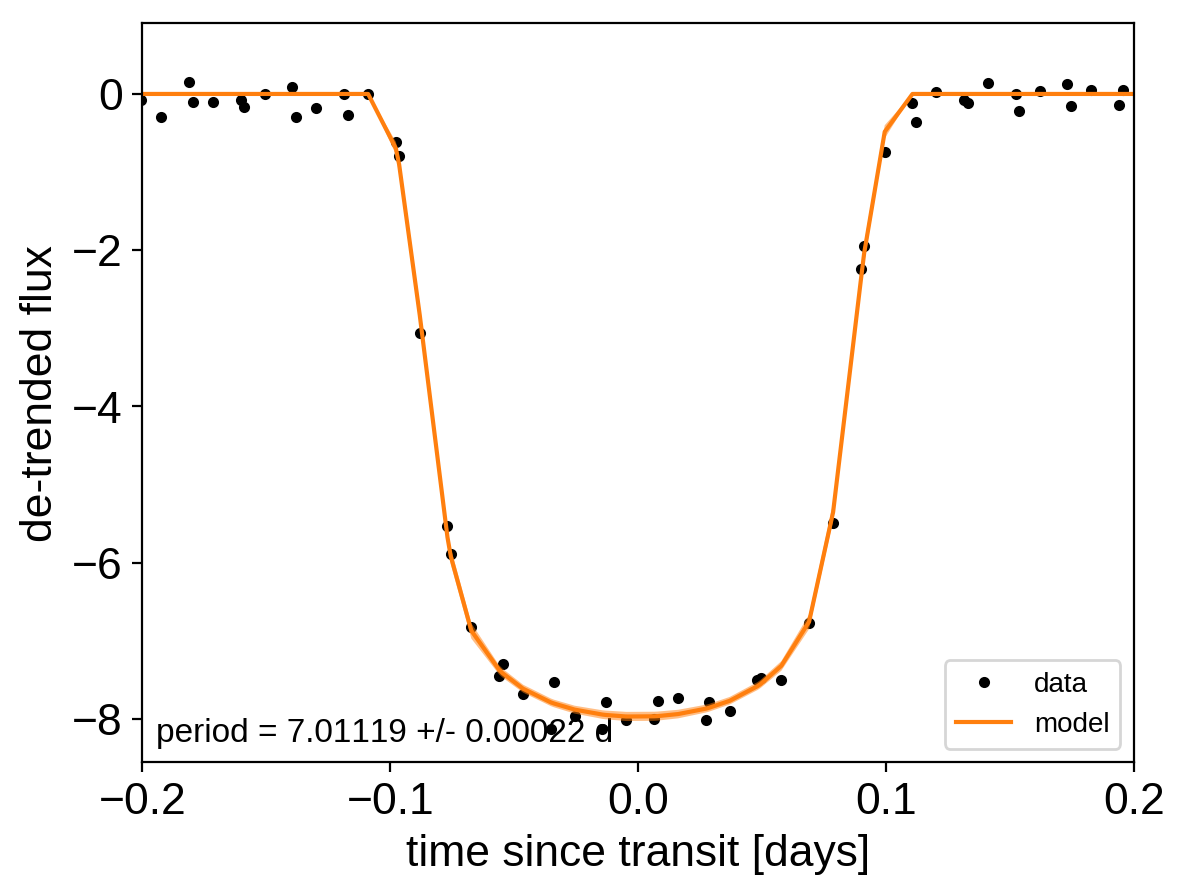

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.2, 0.2);

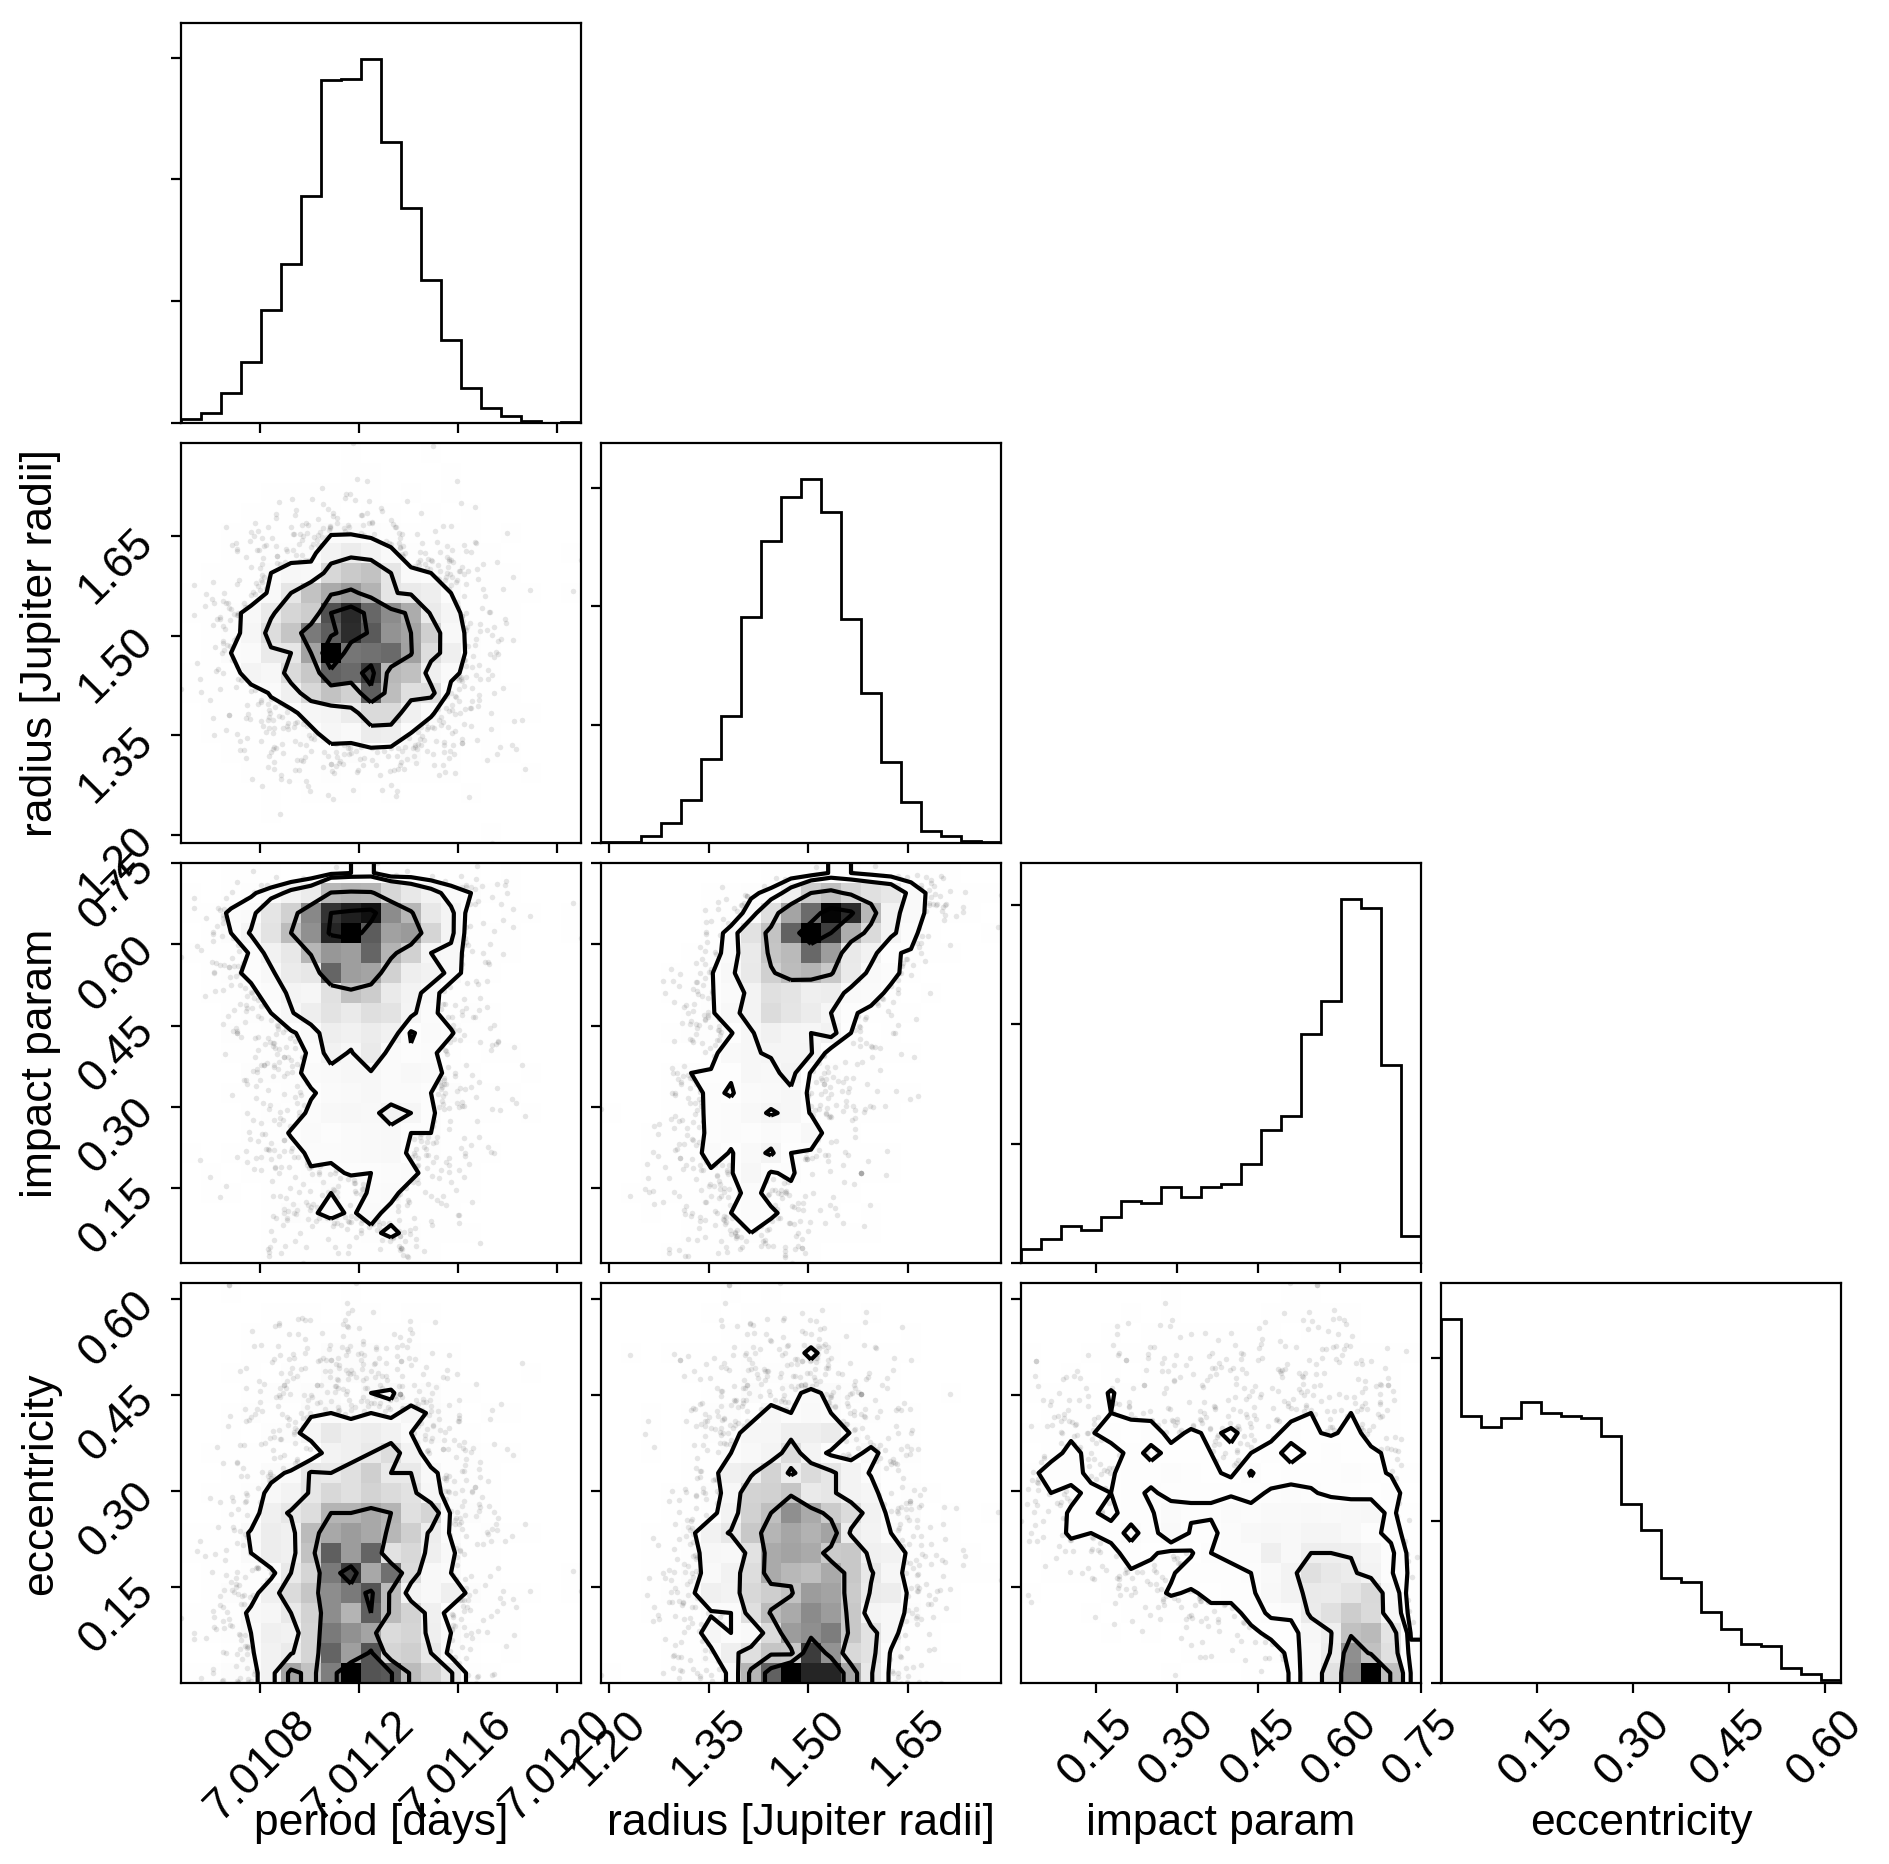

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_jupiter).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Jupiter radii]", "impact param", "eccentricity"]);

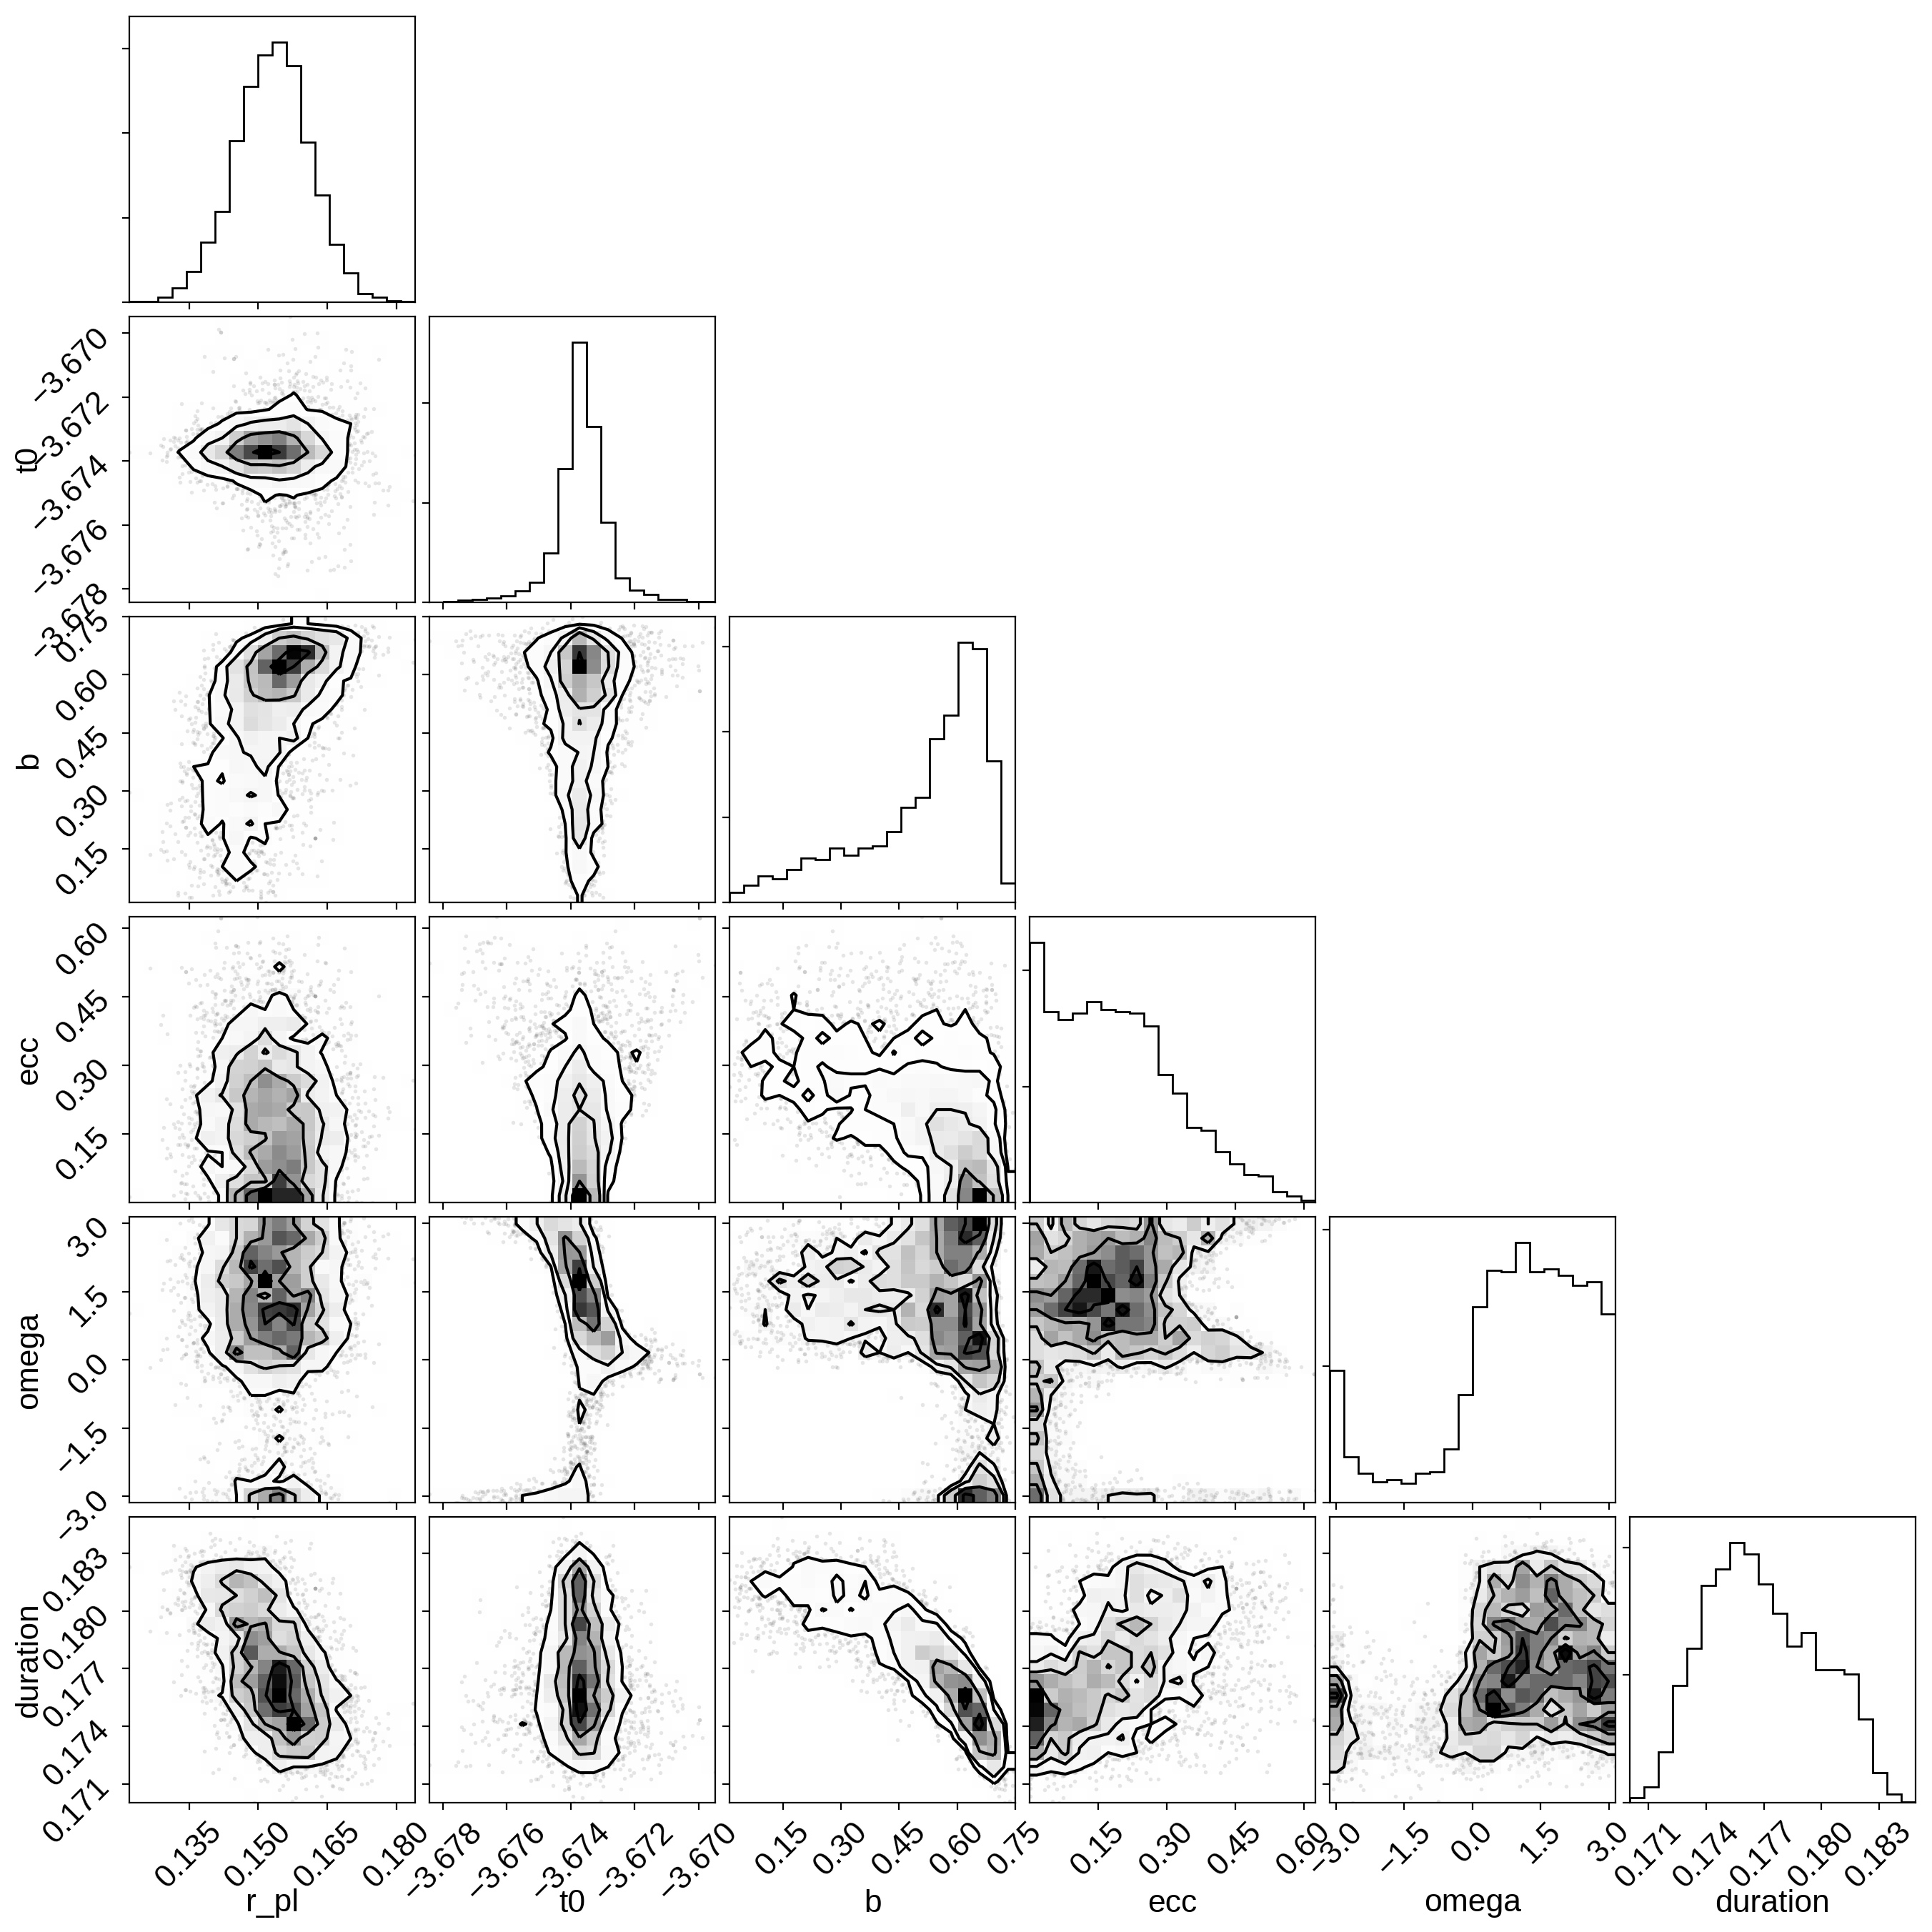

In [19]:
aor = -trace["a"] / trace["r_star"]
e = trace["ecc"]
w = trace["omega"]
i = trace["incl"]
b = trace["b"]
k = trace["r_pl"] / trace["r_star"]
P = trace["period"]

T_tot = P/np.pi * np.arcsin(np.sqrt(1 - b**2) / np.sin(i) / aor)
dur = T_tot * np.sqrt(1 - e**2) / (1 + e * np.sin(w))

samples = pm.trace_to_dataframe(trace, varnames=["r_pl", "t0", "b", "ecc", "omega"])
samples["duration"] = dur
corner.corner(samples);